In [1]:
import numpy as np
import scipy.linalg as la
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib import rcParams
from TurbCurv import orr_sommerfeld, orr_sommerfeld_non_uniform_nuT_ij, orr_sommerfeld_non_uniform_nuT_ij_iterative_debug
from TurbCurv import orr_sommerfeld_non_uniform, D_matrices_non_uniform, solve_bvp_model, orr_sommerfeld_non_uniform_nuT_ij_Chebyshev
from TurbCurv import chebyshev_grid, chebyshev_diff_matrix, interpolate_to_chebyshev
from scipy import integrate
import h5py
import cmath
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
from findiff import FinDiff
from scipy.integrate import cumtrapz
%matplotlib inline
plt.rc('text',usetex=True)
plt.rc('font',family='serif')
rcParams.update({'figure.autolayout': True})

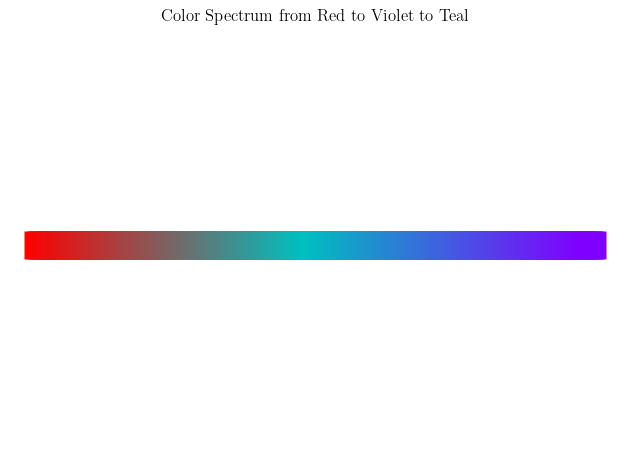

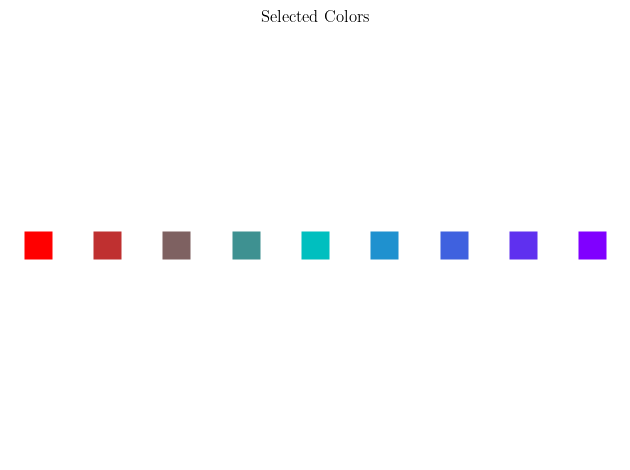

In [2]:
# Define the colors
color1 = np.array([1, 0, 0])  # red
color5 = np.array([0, 0.75, 0.75])  # teal
color9 = np.array([0.5, 0, 1])  # violet

# Number of intermediate colors
num_colors = 100

# Interpolate colors between color1 and color5
colors1_to_5 = np.linspace(color1, color5, num_colors)

# Interpolate colors between color5 and color9
colors5_to_9 = np.linspace(color5, color9, num_colors)

# Combine the colors to form a full spectrum
full_spectrum = np.vstack((colors1_to_5, colors5_to_9))

# Pick 9 colors evenly distributed across the spectrum
indices = np.round(np.linspace(0, full_spectrum.shape[0] - 1, 9)).astype(int)
selected_colors = full_spectrum[indices]

# Store the selected colors in a list
color_array = [list(selected_colors[i]) for i in range(9)]

# Plot the spectrum
plt.figure()
for i in range(full_spectrum.shape[0]):
    plt.plot(i, 1, 's', markersize=20, markeredgecolor='none', markerfacecolor=full_spectrum[i])
plt.axis('off')
plt.title('Color Spectrum from Red to Violet to Teal')
plt.show()

# Display the selected colors
plt.figure()
for i in range(9):
    plt.plot(i, 1, 's', markersize=20, markeredgecolor='none', markerfacecolor=selected_colors[i])
plt.axis('off')
plt.title('Selected Colors')
plt.show()


In [3]:
color_blue = np.array([0.12156862745098039, 0.4666666666666667, 0.7058823529411765])  # Blue
color_orange = np.array([1, 0.5, 0])  # Orange
color_green = np.array([0.17254901960784313, 0.6274509803921569, 0.17254901960784313])#np.array([0, 1, 0])  # Green
color_red_brown = np.array([0.8392156862745098, 0.15294117647058825, 0.1568627450980392])#np.array([0.6, 0, 0])  # Dark red or brownish red
color_purple = np.array([0.5, 0, 1])  # Purple/Violet
color_red_dashed = np.array([1, 0, 0])  # Red

limited_color_array = [
    color_blue, 
    color_orange, 
    color_green, 
    color_red_brown, 
    color_purple, 
    color_red_dashed
]

In [4]:
def mape(y_true, y_pred): 
    """
    Calculate Mean Absolute Percentage Error (MAPE)

    Args:
        y_true (array-like): Actual values
        y_pred (array-like): Predicted values

    Returns:
        float: MAPE value
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100



In [5]:
def ddxi_fft(f, x, kx):
    f_hat     = np.fft.fft(f)
    df_dx_hat = 1j*kx*f_hat
    df_dx     = np.real(np.fft.ifft(df_dx_hat))
    return df_dx

In [6]:
cd '/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv'

/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv


In [7]:
ls

Imp_profile_apriori.png
Imp_profile_no_decay_vs_exp5_decay_Model_nuT_LES_VanDriest.png
Imu_profile_WRLES_vs_Model.png
Imu_profile_apriori.png
Imu_profile_no_decay_vs_exp5_decay_Model_nuT_LES_VanDriest.png
Imw_profile_WRLES_vs_exp1_decay_Model_nuT.png
Imw_profile_WRLES_vs_exp1_decay_Model_nuT_VanDriest.png
Imw_profile_WRLES_vs_exp5_decay_Model_nuT.png
Imw_profile_WRLES_vs_exp5_decay_Model_nuT_VanDriest.png
Imw_profile_WRLES_vs_no_exp_decay_Model_nuT.png
Imw_profile_WRLES_vs_no_exp_decay_Model_nuT_VanDriest.png
Imw_profile_apriori.png
Imw_profile_no_decay_vs_exp5_decay_Model_nuT_VanDriest.png
Imw_profile_no_decay_vs_exp5_decay_Model_nuT_VanDriest_apriori.png
Imw_profile_nuT_2x2.png
Imw_profile_nuT_2x4.png
README.md
Rep_profile_WRLES_vs_Model.png
Rep_profile_apriori.png
Rep_profile_no_decay_vs_exp5_decay_Model_nuT_LES_VanDriest.png
Reu_profile_apriori.png
Reu_profile_no_decay_vs_exp5_decay_Model_nuT_LES_VanDriest.png
Rew_Imw_profile_nuT_2x4.png
Rew_profile_WRLES_vs_exp1_decay_Model_nuT_LE

In [639]:
filename=['phase_averaged_data_all_10_c-25.mat', 
          'phase_averaged_data_all_09_c-15.mat', 
          'phase_averaged_data_all_08_c-7.mat', 
          'phase_averaged_data_all_07_c-2.mat', 
          'phase_averaged_data_all_06_c0.mat', 
          'phase_averaged_data_all_02_c2.mat', 
          'phase_averaged_data_all_03_c7.mat', 
          'phase_averaged_data_all_04_c15.mat',
          'phase_averaged_data_all_05_c25.mat',
          'phase_averaged_data_all_01_flat.mat'];

filename_TKE=['TKE_budget_terms_10_c-25.mat', 
              'TKE_budget_terms_09_c-15.mat', 
              'TKE_budget_terms_08_c-7.mat', 
              'TKE_budget_terms_07_c-2.mat', 
              'TKE_budget_terms_06_c0.mat', 
              'TKE_budget_terms_02_c2.mat', 
              'TKE_budget_terms_03_c7.mat', 
              'TKE_budget_terms_04_c15.mat',
              'TKE_budget_terms_05_c25.mat',
              'TKE_budget_terms_01_flat.mat'];


c_array=[-25,-15,-7,-2,0,2,7,15,25,0];
limited_c_array_index=[0,3,4,5,8]
limited_color_array = [color_array[0],color_array[3],color_array[4],color_array[5],color_array[8]]
num_data=np.size(c_array)
num_data

10

In [9]:
#### Read in profiles from mat files
sully_path='/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/data/phase_averaged_and_TKE_data/'

class profile_mat_data:
    def __init__(self,Filename):
        DATA=sio.loadmat(Filename)
        zi=1
        Nx=864;
        Ny=576;
        Nz=144;

        self.eta = DATA['eta_phase_avg']
        self.u_w_surf = DATA['u_w_phase_avg'][:,0]-np.mean(DATA['u_w_phase_avg'][:,0],axis=0)
        self.w_surf   = DATA['w_phase_avg'][:,0]-np.mean(DATA['w_phase_avg'][:,0],axis=0)
        self.w   = DATA['w_phase_avg'][:,:]-np.mean(DATA['w_phase_avg'][:,:],axis=0)
        self.w_phase_avg   = DATA['w_phase_avg'][:,:]
        self.w_mean = np.mean(DATA['w_phase_avg'],axis=0)

        self.u_w_t_avg_mean = np.mean(DATA['u_w_time_avg'][:,:],axis=0)
        self.v_w_t_avg_mean = np.mean(DATA['v_w_time_avg'][:,:],axis=0)
        self.w_t_avg_mean   = np.mean(DATA['w_time_avg'][:,:],axis=0)
  
        
        self.W   = DATA['W_phase_avg'][:,:]-np.mean(DATA['W_phase_avg'][:,:],axis=0)
        self.W_phase_avg = DATA['W_phase_avg'][:,:]
        self.W_mean = np.mean(DATA['W_phase_avg'],axis=0)
        
        self.u_w = DATA['u_w_phase_avg'][:,:]-np.mean(DATA['u_w_phase_avg'][:,:],axis=0)
        self.u_w_phase_avg = DATA['u_w_phase_avg'][:,:]
        self.v_w_phase_avg = DATA['v_w_phase_avg'][:,:]
        self.u_mean =  np.mean(DATA['u_w_phase_avg'],axis=0)
        self.v_mean =  np.mean(DATA['v_w_phase_avg'],axis=0)
        
        ##############################################################################################################
        
        self.U = DATA['U_phase_avg'][:,:]-np.mean(DATA['U_phase_avg'][:,:],axis=0)
        self.U_phase_avg = DATA['U_phase_avg'][:,:]
        self.U_mean   = np.mean(DATA['U_phase_avg'],axis=0)
        
        self.uU_phase_avg = DATA['uU_phase_avg'][:,:]
        self.vU_phase_avg = DATA['vU_phase_avg'][:,:]
        self.wU_phase_avg = DATA['wU_phase_avg'][:,:]

        self.uW_phase_avg = DATA['uW_phase_avg'][:,:]
        self.vW_phase_avg = DATA['vW_phase_avg'][:,:]
        self.wW_phase_avg = DATA['wW_phase_avg'][:,:]
        
        self.uiuiU_phase_avg = DATA['uiuiU_phase_avg'][:,:]
        self.uiuiW_phase_avg = DATA['uiuiW_phase_avg'][:,:]
        
        self.uu_w_phase_avg  = DATA['uu_w_phase_avg'][:,:]
        self.vv_w_phase_avg  = DATA['vv_w_phase_avg'][:,:]
        self.ww_phase_avg    = DATA['ww_phase_avg'][:,:]

        self.upup_phase_avg  = DATA['uu_w_phase_avg'][:,:] - DATA['u_w_phase_avg'][:,:]*DATA['u_w_phase_avg'][:,:]
        self.vpvp_phase_avg  = DATA['vv_w_phase_avg'][:,:] - DATA['v_w_phase_avg'][:,:]*DATA['v_w_phase_avg'][:,:]
        self.wpwp_phase_avg  =   DATA['ww_phase_avg'][:,:] -   DATA['w_phase_avg'][:,:]*DATA['w_phase_avg'][:,:]

        self.upwp_phase_avg  = DATA['uw_phase_avg'][:,:] - DATA['u_w_phase_avg'][:,:]*DATA['w_phase_avg'][:,:]
        self.vpwp_phase_avg  = DATA['vw_phase_avg'][:,:] - DATA['v_w_phase_avg'][:,:]*DATA['w_phase_avg'][:,:]
        self.upvp_phase_avg  = DATA['uv_phase_avg'][:,:] - DATA['u_w_phase_avg'][:,:]*DATA['v_w_phase_avg'][:,:]

        self.upup_d_phase_avg=self.upup_phase_avg - (1/3)*(self.upup_phase_avg + self.vpvp_phase_avg + self.wpwp_phase_avg)
        self.vpvp_d_phase_avg=self.vpvp_phase_avg - (1/3)*(self.upup_phase_avg + self.vpvp_phase_avg + self.wpwp_phase_avg)
        self.wpwp_d_phase_avg=self.wpwp_phase_avg - (1/3)*(self.upup_phase_avg + self.vpvp_phase_avg + self.wpwp_phase_avg)
        
        

        self.zw=DATA['zw']*zi
        
        ##############################################################################################################
        
        self.tau13        = (DATA['tau13_phase_avg']-np.mean(DATA['tau13_phase_avg'][:,:],axis=0))
        self.tau13_mean   = np.mean(DATA['tau13_phase_avg'],axis=0)
        
        self.tau13_SGS      = (DATA['tau13_SGS_phase_avg']-np.mean(DATA['tau13_SGS_phase_avg'][:,:],axis=0))
        self.tau13_SGS_mean = np.mean(DATA['tau13_SGS_phase_avg'],axis=0)
        
        self.tau13_nu       = (DATA['tau13_nu_phase_avg']-np.mean(DATA['tau13_nu_phase_avg'][:,:],axis=0))
        self.tau13_nu_mean  = np.mean(DATA['tau13_nu_phase_avg'],axis=0)

        self.tau23_nu       = (DATA['tau23_nu_phase_avg']-np.mean(DATA['tau23_nu_phase_avg'][:,:],axis=0))
        self.tau23_nu_mean  = np.mean(DATA['tau23_nu_phase_avg'],axis=0)

        self.tau23_SGS       = (DATA['tau23_SGS_phase_avg']-np.mean(DATA['tau23_SGS_phase_avg'][:,:],axis=0))
        self.tau23_SGS_mean  = np.mean(DATA['tau23_SGS_phase_avg'],axis=0)

        self.tau13_wave      = ((DATA['tau13_wave_phase_avg']-np.mean(DATA['tau13_wave_phase_avg'][:,:],axis=0)))
        self.tau13_wave_mean = np.mean(DATA['tau13_wave_phase_avg'],axis=0)
        
        ##############################################################################################################
        
        self.tau31        = (DATA['tau31_phase_avg']-np.mean(DATA['tau31_phase_avg'][:,:],axis=0))
        self.tau31_mean   = np.mean(DATA['tau31_phase_avg'],axis=0)
        
        self.tau31_SGS      = (DATA['tau31_SGS_phase_avg']-np.mean(DATA['tau31_SGS_phase_avg'][:,:],axis=0))
        self.tau31_SGS_mean = np.mean(DATA['tau31_SGS_phase_avg'],axis=0)
        
        self.tau31_nu       = (DATA['tau31_nu_phase_avg']-np.mean(DATA['tau31_nu_phase_avg'][:,:],axis=0))
        self.tau31_nu_mean  = np.mean(DATA['tau31_nu_phase_avg'],axis=0)

        self.tau31_wave       = (DATA['tau31_wave_phase_avg']-np.mean(DATA['tau31_wave_phase_avg'][:,:],axis=0))
        self.tau31_wave_mean  = np.mean(DATA['tau31_wave_phase_avg'],axis=0)
        
        ##############################################################################################################
        
        self.tau11       = (DATA['tau11_phase_avg']-np.mean(DATA['tau11_phase_avg'][:,:],axis=0))
        self.tau11_mean  = np.mean(DATA['tau11_phase_avg'],axis=0)
        
        self.tau11_SGS      = (DATA['tau11_SGS_phase_avg']-np.mean(DATA['tau11_SGS_phase_avg'][:,:],axis=0))
        self.tau11_SGS_mean = np.mean(DATA['tau11_SGS_phase_avg'],axis=0)
        
        self.tau11_nu      = (DATA['tau11_nu_phase_avg']-np.mean(DATA['tau11_nu_phase_avg'][:,:],axis=0))
        self.tau11_nu_mean = np.mean(DATA['tau11_nu_phase_avg'],axis=0)
      
        self.tau21_nu      = (DATA['tau21_nu_phase_avg']-np.mean(DATA['tau21_nu_phase_avg'][:,:],axis=0))
        self.tau21_nu_mean = np.mean(DATA['tau21_nu_phase_avg'],axis=0)
      
        self.tau21_SGS      = (DATA['tau21_SGS_phase_avg']-np.mean(DATA['tau21_SGS_phase_avg'][:,:],axis=0))
        self.tau21_SGS_mean = np.mean(DATA['tau21_SGS_phase_avg'],axis=0)
        
        self.tau11_wave       = (DATA['tau11_wave_phase_avg']-np.mean(DATA['tau11_wave_phase_avg'][:,:],axis=0))
        self.tau11_wave_mean  = np.mean(DATA['tau11_wave_phase_avg'],axis=0)
        
        ##############################################################################################################
        
        self.tau33      = (DATA['tau33_phase_avg']-np.mean(DATA['tau33_phase_avg'][:,:],axis=0))
        self.tau33_mean = np.mean(DATA['tau33_phase_avg'],axis=0)
        
        self.tau33_SGS      = (DATA['tau33_SGS_phase_avg']-np.mean(DATA['tau33_SGS_phase_avg'][:,:],axis=0))
        self.tau33_SGS_mean = np.mean(DATA['tau33_SGS_phase_avg'],axis=0)
        
        self.tau33_nu      = (DATA['tau33_nu_phase_avg']-np.mean(DATA['tau33_nu_phase_avg'][:,:],axis=0))
        self.tau33_nu_mean = np.mean(DATA['tau33_nu_phase_avg'],axis=0)
        
        self.tau33_wave      = (DATA['tau33_wave_phase_avg']-np.mean(DATA['tau33_wave_phase_avg'][:,:],axis=0))
        self.tau33_wave_mean = np.mean(DATA['tau33_wave_phase_avg'],axis=0)
        
        ##############################################################################################################
        
        self.tau11_d = self.tau11 - (1/3)*(self.tau11+self.tau33)
        self.tau33_d = self.tau33 - (1/3)*(self.tau11+self.tau33)
        self.tau11_d_SGS  = self.tau11_SGS  - (1/3)*(self.tau11_SGS  + self.tau33_SGS)
        self.tau33_d_SGS  = self.tau33_SGS  - (1/3)*(self.tau11_SGS  + self.tau33_SGS)
        self.tau11_d_wave = self.tau11_wave - (1/3)*(self.tau11_wave + self.tau33_wave)
        self.tau33_d_wave = self.tau33_wave - (1/3)*(self.tau11_wave + self.tau33_wave)
        self.tau11_d_nu   = self.tau11_nu  - (1/3)*(self.tau11_nu  + self.tau33_nu)
        self.tau33_d_nu   = self.tau33_nu  - (1/3)*(self.tau11_nu  + self.tau33_nu)

        self.p_w_tilde =         DATA['p_w_phase_avg'][:,:] - np.mean(DATA['p_w_phase_avg'][:,:],axis=0)
        
        self.p_w       =         (DATA['p_w_phase_avg'][:,:] + (1/3)*(self.tau11+self.tau33) + (1/3)*(self.tau11_SGS  + self.tau33_SGS)) \
                         -np.mean(DATA['p_w_phase_avg'][:,:] + (1/3)*(self.tau11+self.tau33) + (1/3)*(self.tau11_SGS  + self.tau33_SGS),axis=0)
        self.p_w_surf  = self.p_w[:,0]  # DATA['p_w_phase_avg'][:,0]-np.mean(DATA['p_w_phase_avg'][:,0],axis=0)
        
        ##############################################################################################################
        
        self.taup_13      = (DATA['taup_13_phase_avg']-np.mean(DATA['taup_13_phase_avg'][:,:],axis=0))
        self.taup_13_mean = np.mean(DATA['taup_13_phase_avg'],axis=0)
        
        self.taup_11      = (DATA['taup_11_phase_avg']-np.mean(DATA['taup_11_phase_avg'][:,:],axis=0))
        self.taup_11_mean = np.mean(DATA['taup_11_phase_avg'],axis=0)

        self.taup_33      = DATA['p_w_phase_avg'][:,:]-np.mean(DATA['p_w_phase_avg'][:,:],axis=0)
        self.taup_33_mean = np.mean(DATA['p_w_phase_avg'][:,:],axis=0)

        ##############################################################################################################
        
#         tau13_wave_xz = np.zeros([Nx, Nz], dtype='float64')
#         for k in range(Nz):
#             tau13_wave_xz[:, k] = -(
#                 DATA['u_w_phase_avg'][:, k] - np.mean(DATA['u_w_phase_avg'][:, k], axis=0)
#             ) * (
#                 DATA['W_phase_avg'][:, k] - np.mean(DATA['W_phase_avg'][:, k], axis=0)
#             )

#         self.tau13_wave = np.mean(tau13_wave_xz[:,:],axis=0)
#         self.tau13_wave_contour = tau13_wave_xz[:,:]
        ##############################################################################################################
        
        self.tau_tot  = self.tau13+self.tau13_SGS+self.tau13_nu+self.taup_13+self.tau13_wave
        self.tau_tot_mean  = self.tau13_mean+self.tau13_SGS_mean+self.tau13_nu_mean+self.taup_13_mean+self.tau13_wave_mean


        ####################################################################################################################

        
        
LES_data =[[],[],[],[],[],[],[],[],[],[]]
for n in range(num_data):
    LES_data[n]=profile_mat_data(sully_path+filename[n])
    print(LES_data[n])

In [10]:
class TKE_profile_mat_data:
    def __init__(self,Filename):
        DATA=sio.loadmat(Filename)
        zi=1
        Nx=864;
        Ny=576;
        Nz=144;

        self.TKE = DATA['TKE']
        self.epsilon_TKE = DATA['epsilon_phase_avg']
        self.epsilon_J_TKE = DATA['epsilon_J_phase_avg']
        
        self.epsilon_SGS_TKE = DATA['epsilon_SGS_phase_avg']
        self.uiuiU_TKE   = DATA['uiuiU_TKE']
        self.uiuiW_TKE   = DATA['uiuiW_TKE']
        self.upi_taup_SGS_i1_TKE = DATA['upi_taup_SGS_i1_TKE']
        self.upi_taup_SGS_i3_TKE = DATA['upi_taup_SGS_i3_TKE']
        self.upi_taup_nu_i1_TKE = DATA['upi_taup_nu_i1_TKE']
        self.upi_taup_nu_i3_TKE = DATA['upi_taup_nu_i3_TKE']
        self.pp_Up_TKE = DATA['pp_Up_TKE']
        self.pp_Wp_TKE = DATA['pp_Wp_TKE']
        
LES_TKE_data =[[],[],[],[],[],[],[],[],[],[]]
for n in range(num_data):
    LES_TKE_data[n]=TKE_profile_mat_data(sully_path+filename_TKE[n])
    print(LES_TKE_data[n])  

In [11]:
# Problem Parameters
N = 1024*2
ak=0.1
k_wavno=4
k=4
a=ak/k# in meters 
Retau=1000
nu=1/Retau
ustar=1
kappa=0.41;

pex=0.25;
pey=0.5;
pez=1;
Lx=2*np.pi/pex;
Ly=2*np.pi/pey;
Lz=1;
zi=Lz;
Hbar=Lz;

Nx=864;
Ny=576;
Nz=144;
x_LES=np.linspace(0,Lx,Nx)
kx=np.fft.fftfreq(Nx,d = 1/(Nx*pex))

use_non_uniform_grid=1;
#Tanh-stretched grid
z_min = 1e-6  # Minimum value in the physical domain
z_max = 1.0  # Maximum value in the physical domain
alpha = 5.0  # Stretching factor (adjust for more/less stretching)

# Create a linearly spaced grid in the range [0, 1]
eta = np.linspace(-1, 1, N)

# Apply the tanh stretching
z_stretched = 0.5 * (np.tanh(alpha * eta) + 1)

# Map the stretched grid to the desired physical domain
z_non_uniform = z_min + z_stretched * (z_max - z_min)
#z_non_uniform = np.logspace(np.log10(1e-6),np.log10(zi), N)

#Uniform grid
z_uniform = np.linspace(0,zi, N)


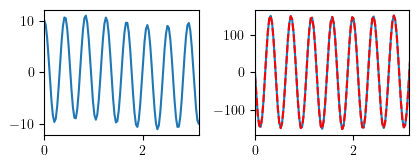

In [12]:
func = np.sin(2*x_LES) + 10*np.cos(15*x_LES)
dfunc_dx = 2*np.cos(2*x_LES) - 10*15*np.sin(15*x_LES)
dfunc_dx_fft = ddxi_fft(func, x_LES, kx)

ax1=plt.subplot(331)
plt.plot(x_LES,func)
ax1.set_xlim(0,np.pi)

ax1=plt.subplot(332)
plt.plot(x_LES,dfunc_dx)
plt.plot(x_LES,dfunc_dx_fft,'r--')
ax1.set_xlim(0,np.pi)

plt.show()

In [ ]:
#Tanh-stretched grid
z_min = 1.5e-4  # Minimum value in the physical domain
z_max = 1.0  # Maximum value in the physical domain
alpha = 8.0  # Stretching factor (adjust for more/less stretching)

# Create a linearly spaced grid in the range [0, 1]
eta = np.linspace(-1, 1, N)

# Apply the tanh stretching
z_stretched = 0.5 * (np.tanh(alpha * eta) + 1)

# Map the stretched grid to the desired physical domain
z_non_uniform = z_min + z_stretched * (z_max - z_min)

#z_non_uniform = np.logspace(np.log10(z0),np.log10(zi), N)
z = z_non_uniform #np.logspace(np.log10(z0),np.log10(zi), N)

z_cheb = chebyshev_grid(N, zi)
D  = chebyshev_diff_matrix(N, zi)
D2 = np.dot(D,D)
num_data_select=0
tau31_hat_LES = np.fft.fft(LES_data[num_data_select].tau31+LES_data[num_data_select].tau31_SGS,axis=0,norm='forward')
u_hat_LES = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')

u_hat_spline = CubicSpline(LES_data[num_data_select].zw[0:-1].flatten(),u_hat_LES[16,0:-1])
u_hat_z = u_hat_spline(z)
dudz_z  = np.gradient(u_hat_z,z,edge_order=2)
d2udz2_z  = np.gradient(dudz_z,z,edge_order=2)
u_hat_cheb = interpolate_to_chebyshev(z[0:-1],u_hat_z[0:-1], z_cheb[0:N-16])
tau31_hat_cheb = interpolate_to_chebyshev(LES_data[num_data_select].zw[0:-1].flatten(), tau31_hat_LES[16,0:-1], z_cheb)
dudz_cheb = D[0:N-16,0:N-16] @ u_hat_cheb
d2udz2_cheb = D2[0:N-16,0:N-16] @ u_hat_cheb

plt.semilogy(dudz_cheb[0:N-16].imag,z_cheb[0:N-16],'bo')
plt.semilogy(dudz_z[0:-1].imag,z[0:-1],'r--')
#plt.semilogy(u_hat_LES[16,0:-1].imag,LES_data[num_data_select].zw[0:-1].flatten(),'ro')


plt.show()

In [ ]:
z_cheb[2]

TKE budget analysis

\begin{align*}
\underbrace{\overline{U}_j\frac{\partial e}{\partial \xi_j}}_{\text{Advection}}+	\underbrace{\frac{\partial}{\partial \xi_j}\left(\overline{\frac{1}{2}u_i^\prime u_i^\prime U_j^\prime}
	+\overline{p^\prime U_j^\prime}+\overline{u_i^\prime \tau_{ij}^{\nu\prime}}+\overline{u_i^\prime \tau_{ij}^{\text{SGS}\prime}}\right)}_{\text{Transport}}+\underbrace{J^{-1}\epsilon}_{\text{Viscous dissipation}}
-\underbrace{\overline{\tau_{ij}^{\text{SGS}^\prime}s_{ij}}}_{\text{SGS dissipation}}+\underbrace{\tau_{ij}\frac{\partial\overline{u}_{i}}{\partial\xi_j}}_{\text{Production}}&=0.
\end{align*}

\begin{align*}
\tau_{ij}\frac{\partial\overline{u}_i}{\partial \xi_j}&=\mspace{20mu}\tau_{11}\frac{\partial \overline{u}}{\partial \xi} + \tau_{21}\frac{\partial \overline{v}}{\partial \xi} + \tau_{31}\frac{\partial \overline{w}}{\partial \xi}\\
&\mspace{20mu}+ \tau_{13}\frac{\partial \overline{u}}{\partial \zeta} + \tau_{23}\frac{\partial \overline{v}}{\partial \zeta} + \tau_{33}\frac{\partial \overline{w}}{\partial \zeta},
\end{align*}

$$\tau_{ij}=\overline{u_i^\prime U_j^\prime}=\overline{u_i U_j}-\overline{u}_i\overline{U}_j$$

In [ ]:
#advection
advection_TKE      = np.zeros((Nx,Nz,num_data,2),dtype='float64')
advection_TKE_mean = np.zeros((Nz,num_data,2),dtype='float64')

#transport
transport_TKE      = np.zeros((Nx,Nz,num_data,2),dtype='float64')
transport_TKE_mean = np.zeros((Nz,num_data,2),dtype='float64')

conv_transport_TKE      = np.zeros((Nx,Nz,num_data,2),dtype='float64')
conv_transport_TKE_mean = np.zeros((Nz,num_data,2),dtype='float64')

pres_transport_TKE      = np.zeros((Nx,Nz,num_data,2),dtype='float64')
pres_transport_TKE_mean = np.zeros((Nz,num_data,2),dtype='float64')

visc_transport_TKE      = np.zeros((Nx,Nz,num_data,2),dtype='float64')
visc_transport_TKE_mean = np.zeros((Nz,num_data,2),dtype='float64')

SGS_transport_TKE       = np.zeros((Nx,Nz,num_data,2),dtype='float64')
SGS_transport_TKE_mean  = np.zeros((Nz,num_data,2),dtype='float64')

#viscous dissipation
epsilon_TKE = np.zeros((Nx,Nz,num_data,2),dtype='float64')
epsilon_TKE_mean = np.zeros((Nz,num_data,2),dtype='float64')

epsilon_J_TKE = np.zeros((Nx,Nz,num_data,2),dtype='float64')
epsilon_J_TKE_mean = np.zeros((Nz,num_data,2),dtype='float64')

#SGS dissipation
epsilon_SGS_TKE = np.zeros((Nx,Nz,num_data,2),dtype='float64')
epsilon_SGS_TKE_mean = np.zeros((Nz,num_data,2),dtype='float64')

#production dissipation
production_TKE = np.zeros((Nx,Nz,num_data,2),dtype='float64')
production_TKE_mean = np.zeros((Nz,num_data,2),dtype='float64')

sum_TKE_mean = np.zeros((Nz,num_data,2),dtype='float64')
    

for n in range(num_data):
    z_data = np.asarray(LES_data[n].zw).flatten()
    g_func = z_data/zi-1
    dgdz_func = 1/zi
    Jacobian  = np.zeros((Nx,Nz),dtype='float64')

    for i in range(Nx):
       for k in range(Nz):
           Jacobian[i,k] = 1/(1-dgdz_func*a*np.cos(kx[i]*x_LES[i]))

    
    uiuiU_TKE = np.zeros((Nx,Nz),dtype='float64')
    uiuiW_TKE = np.zeros((Nx,Nz),dtype='float64')

    ddx_uiuiU = np.zeros((Nx,Nz),dtype='float64')
    ddz_uiuiW = np.zeros((Nx,Nz),dtype='float64')

    ddx_pp_Up = np.zeros((Nx,Nz),dtype='float64')
    ddz_pp_Wp = np.zeros((Nx,Nz),dtype='float64')

    ddx_upi_taup_nu_i1 = np.zeros((Nx,Nz),dtype='float64')
    ddz_upi_taup_nu_i3 = np.zeros((Nx,Nz),dtype='float64')

    ddx_upi_taup_SGS_i1 = np.zeros((Nx,Nz),dtype='float64')
    ddz_upi_taup_SGS_i3 = np.zeros((Nx,Nz),dtype='float64')
    
    ####################################################################################################
    #Advection    
    dedxi = np.zeros((Nx,Nz),dtype='float64')
    dedzeta = np.zeros((Nx,Nz),dtype='float64')
    for k in range(Nz):
        dedxi[:,k] = ddxi_fft(LES_TKE_data[n].TKE[:,k],x_LES,kx)
    for i in range(Nx):
        dedzeta[i,:] = np.gradient(LES_TKE_data[n].TKE[i,:],z_data,edge_order=2)

    advection_TKE[:,:,n,0] = LES_data[n].U_phase_avg*dedxi + LES_data[n].W_phase_avg*dedzeta
    advection_TKE_mean[:,n,0] = np.mean(advection_TKE[:,:,n,0],axis=0)

    ####################################################################################################
    #Convective Transport
    uiuiU_TKE = 0.5*(LES_data[n].uiuiU_phase_avg - (LES_data[n].uu_w_phase_avg+LES_data[n].vv_w_phase_avg+LES_data[n].ww_phase_avg)*LES_data[n].U_phase_avg \
                -2*LES_data[n].u_w_phase_avg*(LES_data[n].uU_phase_avg-LES_data[n].u_w_phase_avg*LES_data[n].U_phase_avg) \
                -2*LES_data[n].v_w_phase_avg*(LES_data[n].vU_phase_avg-LES_data[n].v_w_phase_avg*LES_data[n].U_phase_avg) \
                -2*LES_data[n].w_phase_avg*(LES_data[n].wU_phase_avg-LES_data[n].w_phase_avg*LES_data[n].U_phase_avg));
                
    uiuiW_TKE = 0.5*(LES_data[n].uiuiW_phase_avg - (LES_data[n].uu_w_phase_avg+LES_data[n].vv_w_phase_avg+LES_data[n].ww_phase_avg)*LES_data[n].W_phase_avg \
                -2*LES_data[n].u_w_phase_avg*(LES_data[n].uW_phase_avg-LES_data[n].u_w_phase_avg*LES_data[n].W_phase_avg) \
                -2*LES_data[n].v_w_phase_avg*(LES_data[n].vW_phase_avg-LES_data[n].v_w_phase_avg*LES_data[n].W_phase_avg) \
                -2*LES_data[n].w_phase_avg*(LES_data[n].wW_phase_avg-LES_data[n].w_phase_avg*LES_data[n].W_phase_avg));
    
    for k in range(Nz):
        ddx_uiuiU[:,k] = ddxi_fft(uiuiU_TKE[:,k], x_LES, kx)
    for i in range(Nx):
        ddz_uiuiW[i,:] = np.gradient(uiuiW_TKE[i,:], z_data, edge_order=2)
    
    conv_transport_TKE[:,:,n,0] = ddx_uiuiU[:,:] + ddz_uiuiW[:,:]
    conv_transport_TKE_mean[:,n,0] = np.mean(conv_transport_TKE[:,:,n,0],axis=0)

    ####################################################################################################
    #pressure transport
    for k in range(Nz):
        ddx_pp_Up[:,k] = ddxi_fft(LES_TKE_data[n].pp_Up_TKE[:,k], x_LES, kx)
    for i in range(Nx):
        ddz_pp_Wp[i,:] = np.gradient(LES_TKE_data[n].pp_Wp_TKE[i,:], z_data, edge_order=2)
    
    pres_transport_TKE[:,:,n,0]    = ddx_pp_Up[:,:] + ddz_pp_Wp[:,:]
    pres_transport_TKE_mean[:,n,0] = np.mean(pres_transport_TKE[:,:,n,0],axis=0)
    ####################################################################################################
    #viscous transport
    for k in range(Nz):
        ddx_upi_taup_nu_i1[:,k] = ddxi_fft(LES_TKE_data[n].upi_taup_nu_i1_TKE[:,k], x_LES, kx)
    for i in range(Nx):
        ddz_upi_taup_nu_i3[i,:] = np.gradient(LES_TKE_data[n].upi_taup_nu_i3_TKE[i,:], z_data, edge_order=2)
    
    visc_transport_TKE[:,:,n,0]    = ddx_upi_taup_nu_i1[:,:] + ddz_upi_taup_nu_i3[:,:]
    visc_transport_TKE_mean[:,n,0] = np.mean(visc_transport_TKE[:,:,n,0],axis=0)
    ####################################################################################################
    #SGS transport
    for k in range(Nz):
        ddx_upi_taup_SGS_i1[:,k] = ddxi_fft(LES_TKE_data[n].upi_taup_SGS_i1_TKE[:,k], x_LES, kx)
    for i in range(Nx):
        ddz_upi_taup_SGS_i3[i,:] = np.gradient(LES_TKE_data[n].upi_taup_SGS_i3_TKE[i,:], z_data, edge_order=2)
    
    SGS_transport_TKE[:,:,n,0]    = ddx_upi_taup_SGS_i1[:,:] + ddz_upi_taup_SGS_i3[:,:]
    SGS_transport_TKE_mean[:,n,0] = np.mean(SGS_transport_TKE[:,:,n,0],axis=0)
    
    transport_TKE[:,:,n,0] =  conv_transport_TKE[:,:,n,0]*1 \
                            + pres_transport_TKE[:,:,n,0]*1 \
                            + visc_transport_TKE[:,:,n,0]*1 \
                             + SGS_transport_TKE[:,:,n,0]*1
    
    transport_TKE_mean[:,n,0] = np.mean(transport_TKE[:,:,n,0],axis=0)
    ####################################################################################################
    #Viscous dissipation
    epsilon_TKE[:,:,n,0] = LES_TKE_data[n].epsilon_TKE[:,:]/Jacobian[:,:]
    epsilon_TKE_mean[:,n,0] = np.mean(epsilon_TKE[:,:,n,0],axis=0)
    
    epsilon_J_TKE[:,:,n,0] = LES_TKE_data[n].epsilon_J_TKE[:,:]
    epsilon_J_TKE_mean[:,n,0] = np.mean(epsilon_J_TKE[:,:,n,0],axis=0)

    ####################################################################################################
    #SGS dissipation
    epsilon_SGS_TKE[:,:,n,0] = -LES_TKE_data[n].epsilon_SGS_TKE[:,:]
    epsilon_SGS_TKE_mean[:,n,0] = np.mean(epsilon_SGS_TKE[:,:,n,0],axis=0)
    ####################################################################################################
    #Production term
    tau11   = np.zeros((Nx,Nz),dtype='float64')
    tau21   = np.zeros((Nx,Nz),dtype='float64')
    tau31   = np.zeros((Nx,Nz),dtype='float64')
    tau13   = np.zeros((Nx,Nz),dtype='float64')
    tau23   = np.zeros((Nx,Nz),dtype='float64')
    tau33   = np.zeros((Nx,Nz),dtype='float64')
    
    tau11  = LES_data[n].uU_phase_avg - LES_data[n].u_w_phase_avg*LES_data[n].U_phase_avg
    tau21  = LES_data[n].vU_phase_avg - LES_data[n].v_w_phase_avg*LES_data[n].U_phase_avg
    tau31  = LES_data[n].wU_phase_avg -   LES_data[n].w_phase_avg*LES_data[n].U_phase_avg

    tau13  = LES_data[n].uW_phase_avg - LES_data[n].u_w_phase_avg*LES_data[n].W_phase_avg
    tau23  = LES_data[n].vW_phase_avg - LES_data[n].v_w_phase_avg*LES_data[n].W_phase_avg
    tau33  = LES_data[n].wW_phase_avg -   LES_data[n].w_phase_avg*LES_data[n].W_phase_avg

    dudxi_TKE   = np.zeros((Nx,Nz),dtype='float64')
    dvdxi_TKE   = np.zeros((Nx,Nz),dtype='float64')
    dwdxi_TKE   = np.zeros((Nx,Nz),dtype='float64')
    dudzeta_TKE   = np.zeros((Nx,Nz),dtype='float64')
    dvdzeta_TKE   = np.zeros((Nx,Nz),dtype='float64')
    dwdzeta_TKE   = np.zeros((Nx,Nz),dtype='float64')

    for k in range(Nz):
        dudxi_TKE[:,k]   = ddxi_fft(LES_data[n].u_w_phase_avg[:,k],x_LES,kx)
        dvdxi_TKE[:,k]   = ddxi_fft(LES_data[n].v_w_phase_avg[:,k],x_LES,kx)
        dwdxi_TKE[:,k]   = ddxi_fft(  LES_data[n].w_phase_avg[:,k],x_LES,kx)

    for i in range(Nx):
        dudzeta_TKE[i,:] = np.gradient(LES_data[n].u_w_phase_avg[i,:],z_data,edge_order=2)
        dvdzeta_TKE[i,:] = np.gradient(LES_data[n].v_w_phase_avg[i,:],z_data,edge_order=2)
        dwdzeta_TKE[i,:] = np.gradient(  LES_data[n].w_phase_avg[i,:],z_data,edge_order=2)
        
    production_TKE[:,:,n,0] = tau11*dudxi_TKE  + tau21*dvdxi_TKE   + tau31*dwdxi_TKE \
                          + tau13*dudzeta_TKE+ tau23*dvdzeta_TKE + tau33*dwdzeta_TKE
    
    production_TKE_mean[:,n,0] = np.mean(production_TKE[:,:,n,0],axis=0)


    sum_TKE_mean[:,n,0] = advection_TKE_mean[:,n,0]*1+transport_TKE_mean[:,n,0]+epsilon_TKE_mean[:,n,0] \
                         +epsilon_SGS_TKE_mean[:,n,0]+production_TKE_mean[:,n,0]

\begin{align*}
	\frac{\partial}{\partial \zeta}\left(\langle \widetilde{e}\widetilde{W}\rangle+\left\langle \overline{\frac{1}{2}u_i^\prime u_i^\prime W^\prime}\right\rangle 
	+\langle \overline{p^\prime W^\prime}\rangle+\langle \overline{u_i^\prime \tau_{i3}^{\nu\prime}}\rangle +\langle \overline{u_i^\prime \tau_{i3}^{\text{SGS}\prime}}\rangle\right)+\langle J^{-1}\epsilon\rangle
	-\langle{\overline{\tau_{ij}^{\text{SGS}\prime}s_{ij}}}\rangle+\langle\tau_{ij}\rangle\frac{\partial \langle{u}_i\rangle}{\partial \xi_j}+\left\langle\widetilde{\tau}_{ij}\frac{\partial \widetilde{u}_i}{\partial \xi_j}\right\rangle&=0.
\end{align*}
\begin{align*}
\langle \widetilde{e}\widetilde{W}\rangle&=\langle (\overline{e}-\langle e\rangle)(\overline{W}-\langle W\rangle)\rangle
\end{align*}
\begin{align*}
\langle \tau_{ij}\rangle\frac{\partial \langle \overline{u}_i\rangle}{\partial \xi_j}&=\langle \tau_{13}\rangle\frac{\partial \langle \overline{u}\rangle}{\partial \zeta},\\
\end{align*}
\begin{align*}
\left\langle \widetilde{\tau}_{ij}\frac{\partial \widetilde{u}_i}{\partial \xi_j}\right\rangle&=\left\langle \widetilde{\tau}_{11}\frac{\partial \widetilde{u}_1}{\partial \xi_1}+ \widetilde{\tau}_{21}\frac{\partial \widetilde{u}_2}{\partial \xi_1}+\widetilde{\tau}_{31}\frac{\partial \widetilde{u}_3}{\partial \xi_1}\right\rangle \\
&\mspace{20mu}\left\langle \widetilde{\tau}_{13}\frac{\partial \widetilde{u}_1}{\partial \xi_3}+ \widetilde{\tau}_{23}\frac{\partial \widetilde{u}_2}{\partial \xi_3}+\widetilde{\tau}_{33}\frac{\partial \widetilde{u}_3}{\partial \xi_3}\right\rangle \\
&=\left\langle \widetilde{\tau}_{11}\frac{\partial \widetilde{u}}{\partial \xi}+ \widetilde{\tau}_{21}\frac{\partial \widetilde{v}}{\partial \xi}+\widetilde{\tau}_{31}\frac{\partial \widetilde{w}}{\partial \xi}\right\rangle \\
&\mspace{20mu}\left\langle \widetilde{\tau}_{13}\frac{\partial \widetilde{u}}{\partial \zeta}+ \widetilde{\tau}_{23}\frac{\partial \widetilde{v}}{\partial \zeta}+\widetilde{\tau}_{33}\frac{\partial \widetilde{w}}{\partial \zeta}\right\rangle
\end{align*}
\begin{align*}
\langle\tau_{ij}\rangle\frac{\partial\langle u_i\rangle}{\partial\xi_j}=\langle\tau_{13}\rangle\frac{\partial\langle u_1\rangle}{\partial\xi_3}=\langle\tau_{13}\rangle\frac{\partial\langle u\rangle}{\partial\zeta}
\end{align*}


\begin{align*}
\tau_{ij}^w\frac{\partial \langle u_i\rangle}{\partial \xi_j}+ \langle U_j\rangle \frac{\partial E^w}{\partial \xi_j}
-\widetilde{u}_i \frac{\partial \langle\tau^w_{ij}\rangle}{\partial \xi_j}+\frac{\partial}{\partial \xi_j}\left(\widetilde{u}_i\widetilde{\tau}_{ij}+\widetilde{u}_i\widetilde{\tau}_{ij}^p+\widetilde{u}_i\widetilde{\tau}_{ij}^\nu+\widetilde{u}_i\widetilde{\tau}_{ij}^{\text{SGS}}\right)&\\
\frac{\partial}{\partial \xi_j}\left(E^w\widetilde{U}_j\right)-\left(\widetilde{\tau}_{ij}+\widetilde{\tau}_{ij}^p+\widetilde{\tau}_{ij}^\nu+\widetilde{\tau}_{ij}^{\text{SGS}}\right)\frac{\partial\widetilde{u}_i}{\partial \xi_j}&=0.
\end{align*}
\begin{align*}
(\langle\tau_{ij}^w\rangle+\langle\tau_{ij}^p\rangle)\frac{\partial \langle u_i\rangle}{\partial \xi_j}
+\frac{\partial}{\partial \xi_j}\left(\langle E^w\widetilde{U}_j\rangle+\langle\widetilde{u}_i\widetilde{\tau}_{ij}\rangle+\langle\widetilde{u}_i\widetilde{\tau}_{ij}^p\rangle+\langle\widetilde{u}_i\widetilde{\tau}_{ij}^\nu\rangle+\langle\widetilde{u}_i\widetilde{\tau}_{ij}^{\text{SGS}}\rangle\right)&\\
-\left\langle\widetilde{\tau}_{ij}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle-\left\langle\widetilde{\tau}_{ij}^\nu\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle-\left\langle\widetilde{\tau}_{ij}^{\text{SGS}}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle&=0.
\end{align*}

In [ ]:
tau13_wave_production = np.zeros((Nz,num_data),dtype='float64')
taup_13_production    = np.zeros((Nz,num_data),dtype='float64')
taup_13_production_2    = np.zeros((Nz,num_data),dtype='float64')
wave_production_mean  = np.zeros((Nz,num_data),dtype='float64')

wave_to_turbulence_transfer = np.zeros((Nz,num_data),dtype='float64')
wave_viscous_dissipation    = np.zeros((Nz,num_data),dtype='float64')
wave_SGS_dissipation        = np.zeros((Nz,num_data),dtype='float64')


wave_transport                     = np.zeros((Nz,num_data),dtype='float64')
Ew_transport                       = np.zeros((Nz,num_data),dtype='float64')
ui_tilde_taui3_tilde_transport     = np.zeros((Nz,num_data),dtype='float64')
ui_tilde_taup_i3_tilde_transport   = np.zeros((Nz,num_data),dtype='float64')
ui_tilde_taui3_nu_tilde_transport  = np.zeros((Nz,num_data),dtype='float64')
ui_tilde_taui3_SGS_tilde_transport = np.zeros((Nz,num_data),dtype='float64')

for n in range(num_data):
    
    #Advection TKE term
    TKE_tilde = np.zeros((Nx,Nz),dtype='float64')  
    W_tilde   = np.zeros((Nx,Nz),dtype='float64')  
    z_data = np.asarray(LES_data[n].zw).flatten()
    
    TKE_tilde = LES_TKE_data[n].TKE-np.mean(LES_TKE_data[n].TKE,axis=0)
    W_tilde   = LES_data[n].W_phase_avg-np.mean(LES_data[n].W_phase_avg,axis=0)    
    advection_TKE[:,:,n,1]    = TKE_tilde*W_tilde
    advection_TKE_mean[:,n,1] = np.gradient(np.mean(advection_TKE[:,:,n,1],axis=0),z_data,edge_order=2)
    ####################################################################################################
    #Convective Transport
    uiuiU_TKE = np.zeros((Nx,Nz),dtype='float64')
    uiuiW_TKE = np.zeros((Nx,Nz),dtype='float64')

    ddx_uiuiU = np.zeros((Nx,Nz),dtype='float64')
    ddz_uiuiW = np.zeros((Nx,Nz),dtype='float64')

    uiuiU_TKE = 0.5*(LES_data[n].uiuiU_phase_avg - (LES_data[n].uu_w_phase_avg+LES_data[n].vv_w_phase_avg+LES_data[n].ww_phase_avg)*LES_data[n].U_phase_avg \
                -2*LES_data[n].u_w_phase_avg*(LES_data[n].uU_phase_avg-LES_data[n].u_w_phase_avg*LES_data[n].U_phase_avg) \
                -2*LES_data[n].v_w_phase_avg*(LES_data[n].vU_phase_avg-LES_data[n].v_w_phase_avg*LES_data[n].U_phase_avg) \
                -2*LES_data[n].w_phase_avg*(LES_data[n].wU_phase_avg-LES_data[n].w_phase_avg*LES_data[n].U_phase_avg));
                
    uiuiW_TKE = 0.5*(LES_data[n].uiuiW_phase_avg - (LES_data[n].uu_w_phase_avg+LES_data[n].vv_w_phase_avg+LES_data[n].ww_phase_avg)*LES_data[n].W_phase_avg \
                -2*LES_data[n].u_w_phase_avg*(LES_data[n].uW_phase_avg-LES_data[n].u_w_phase_avg*LES_data[n].W_phase_avg) \
                -2*LES_data[n].v_w_phase_avg*(LES_data[n].vW_phase_avg-LES_data[n].v_w_phase_avg*LES_data[n].W_phase_avg) \
                -2*LES_data[n].w_phase_avg*(LES_data[n].wW_phase_avg-LES_data[n].w_phase_avg*LES_data[n].W_phase_avg));
    
    for k in range(Nz):
        ddx_uiuiU[:,k] = ddxi_fft(uiuiU_TKE[:,k], x_LES, kx)
    for i in range(Nx):
        ddz_uiuiW[i,:] = np.gradient(uiuiW_TKE[i,:], z_data, edge_order=2)
    
    conv_transport_TKE[:,:,n,1] = 0*ddx_uiuiU[:,:] + ddz_uiuiW[:,:]
    conv_transport_TKE_mean[:,n,1] = np.mean(conv_transport_TKE[:,:,n,1],axis=0)
    
    #pressure transport
    ddx_pp_Up = np.zeros((Nx,Nz),dtype='float64')
    ddz_pp_Wp = np.zeros((Nx,Nz),dtype='float64')
    for k in range(Nz):
        ddx_pp_Up[:,k] = ddxi_fft(LES_TKE_data[n].pp_Up_TKE[:,k], x_LES, kx)
    for i in range(Nx):
        ddz_pp_Wp[i,:] = np.gradient(LES_TKE_data[n].pp_Wp_TKE[i,:], z_data, edge_order=2)
    
    pres_transport_TKE[:,:,n,1]    = ddx_pp_Up[:,:]*0 + ddz_pp_Wp[:,:]
    pres_transport_TKE_mean[:,n,1] = np.mean(pres_transport_TKE[:,:,n,1],axis=0)

    #viscous transport
    ddx_upi_taup_nu_i1 = np.zeros((Nx,Nz),dtype='float64')
    ddz_upi_taup_nu_i3 = np.zeros((Nx,Nz),dtype='float64')
    for k in range(Nz):
        ddx_upi_taup_nu_i1[:,k] = ddxi_fft(LES_TKE_data[n].upi_taup_nu_i1_TKE[:,k], x_LES, kx)
    for i in range(Nx):
        ddz_upi_taup_nu_i3[i,:] = np.gradient(LES_TKE_data[n].upi_taup_nu_i3_TKE[i,:], z_data, edge_order=2)
    
    visc_transport_TKE[:,:,n,1]    = ddx_upi_taup_nu_i1[:,:]*0 + ddz_upi_taup_nu_i3[:,:]
    visc_transport_TKE_mean[:,n,1] = np.mean(visc_transport_TKE[:,:,n,1],axis=0)

    #SGS transport
    SGS_transport_TKE       = np.zeros((Nx,Nz,num_data,2),dtype='float64')
    SGS_transport_TKE_mean  = np.zeros((Nz,num_data,2),dtype='float64')
    for k in range(Nz):
        ddx_upi_taup_SGS_i1[:,k] = ddxi_fft(LES_TKE_data[n].upi_taup_SGS_i1_TKE[:,k], x_LES, kx)
    for i in range(Nx):
        ddz_upi_taup_SGS_i3[i,:] = np.gradient(LES_TKE_data[n].upi_taup_SGS_i3_TKE[i,:], z_data, edge_order=2)
    
    SGS_transport_TKE[:,:,n,1]    = ddx_upi_taup_SGS_i1[:,:]*0 + ddz_upi_taup_SGS_i3[:,:]
    SGS_transport_TKE_mean[:,n,1] = np.mean(SGS_transport_TKE[:,:,n,1],axis=0)

    transport_TKE[:,:,n,1] =  conv_transport_TKE[:,:,n,1]*1 \
                            + pres_transport_TKE[:,:,n,1]*1 \
                            + visc_transport_TKE[:,:,n,1]*1 \
                             + SGS_transport_TKE[:,:,n,1]*1
    
    transport_TKE_mean[:,n,1] = np.mean(transport_TKE[:,:,n,1],axis=0)
    
    ####################################################################################################
    #Mean viscous dissipation
    epsilon_TKE[:,:,n,1] = LES_TKE_data[n].epsilon_TKE[:,:]/Jacobian[:,:]
    epsilon_TKE_mean[:,n,1] = np.mean(epsilon_TKE[:,:,n,1],axis=0)

    epsilon_J_TKE[:,:,n,1] = LES_TKE_data[n].epsilon_J_TKE[:,:]
    epsilon_J_TKE_mean[:,n,1] = np.mean(epsilon_J_TKE[:,:,n,1],axis=0)

    ####################################################################################################
    #SGS dissipation
    epsilon_SGS_TKE[:,:,n,1] = -LES_TKE_data[n].epsilon_SGS_TKE[:,:]
    epsilon_SGS_TKE_mean[:,n,1] = np.mean(epsilon_SGS_TKE[:,:,n,1],axis=0)
    ####################################################################################################
    #Production term
    tau11   = np.zeros((Nx,Nz),dtype='float64')
    tau21   = np.zeros((Nx,Nz),dtype='float64')
    tau31   = np.zeros((Nx,Nz),dtype='float64')
    tau13   = np.zeros((Nx,Nz),dtype='float64')
    tau23   = np.zeros((Nx,Nz),dtype='float64')
    tau33   = np.zeros((Nx,Nz),dtype='float64')
    
    tau11_tilde  = np.zeros((Nx,Nz),dtype='float64')
    tau21_tilde  = np.zeros((Nx,Nz),dtype='float64')
    tau31_tilde  = np.zeros((Nx,Nz),dtype='float64')
    tau13_tilde  = np.zeros((Nx,Nz),dtype='float64')
    tau23_tilde  = np.zeros((Nx,Nz),dtype='float64')
    tau33_tilde  = np.zeros((Nx,Nz),dtype='float64')
    
    tau11_mean   = np.zeros((Nz,1),dtype='float64')
    tau21_mean   = np.zeros((Nz,1),dtype='float64')
    tau31_mean   = np.zeros((Nz,1),dtype='float64')
    tau13_mean   = np.zeros((Nz,1),dtype='float64')
    tau23_mean   = np.zeros((Nz,1),dtype='float64')
    tau33_mean   = np.zeros((Nz,1),dtype='float64')
    
    tau11  = LES_data[n].uU_phase_avg - LES_data[n].u_w_phase_avg*LES_data[n].U_phase_avg
    tau21  = LES_data[n].vU_phase_avg - LES_data[n].v_w_phase_avg*LES_data[n].U_phase_avg
    tau31  = LES_data[n].wU_phase_avg -   LES_data[n].w_phase_avg*LES_data[n].U_phase_avg

    tau13  = LES_data[n].uW_phase_avg - LES_data[n].u_w_phase_avg*LES_data[n].W_phase_avg
    tau23  = LES_data[n].vW_phase_avg - LES_data[n].v_w_phase_avg*LES_data[n].W_phase_avg
    tau33  = LES_data[n].wW_phase_avg -   LES_data[n].w_phase_avg*LES_data[n].W_phase_avg

    #tau11 = tau11 - (1/3)*(tau11+tau33)
    #tau33 = tau33 - (1/3)*(tau11+tau33)
    
    tau11_mean = np.mean(tau11,axis=0)
    tau21_mean = np.mean(tau21,axis=0)
    tau31_mean = np.mean(tau31,axis=0)

    tau13_mean = np.mean(tau13,axis=0)
    tau23_mean = np.mean(tau23,axis=0)
    tau33_mean = np.mean(tau33,axis=0)

    tau11_tilde = tau11 - tau11_mean
    tau21_tilde = tau21 - tau21_mean
    tau31_tilde = tau31 - tau31_mean

    tau13_tilde = tau13 - tau13_mean
    tau23_tilde = tau23 - tau23_mean
    tau33_tilde = tau33 - tau33_mean


    u_tilde      = np.zeros((Nx,Nz),dtype='float64')
    v_tilde      = np.zeros((Nx,Nz),dtype='float64')
    w_tilde      = np.zeros((Nx,Nz),dtype='float64')
    ddx_u_tilde  = np.zeros((Nx,Nz),dtype='float64')
    ddx_v_tilde  = np.zeros((Nx,Nz),dtype='float64')
    ddx_w_tilde  = np.zeros((Nx,Nz),dtype='float64')
    ddz_u_tilde  = np.zeros((Nx,Nz),dtype='float64')
    ddz_v_tilde  = np.zeros((Nx,Nz),dtype='float64')
    ddz_w_tilde  = np.zeros((Nx,Nz),dtype='float64')
    u_mean_TKE   = np.zeros((Nx,Nz),dtype='float64')
    
    
    u_tilde    = LES_data[n].u_w_phase_avg - np.mean( LES_data[n].u_w_phase_avg,axis=0)
    v_tilde    = LES_data[n].v_w_phase_avg - np.mean( LES_data[n].v_w_phase_avg,axis=0)
    w_tilde    =   LES_data[n].w_phase_avg - np.mean(   LES_data[n].w_phase_avg,axis=0)
    u_mean_TKE = np.mean( LES_data[n].u_w_phase_avg,axis=0)
    dudz_TKE   = np.gradient(u_mean_TKE,z_data,edge_order=2)
    
    for k in range(Nz):
        ddx_u_tilde[:,k] = ddxi_fft(u_tilde[:,k],x_LES,kx)
        ddx_v_tilde[:,k] = ddxi_fft(v_tilde[:,k],x_LES,kx)
        ddx_w_tilde[:,k] = ddxi_fft(w_tilde[:,k],x_LES,kx)

    for i in range(Nx):
        ddz_u_tilde[i,:] = np.gradient(u_tilde[i,:],z_data,edge_order=2)
        ddz_v_tilde[i,:] = np.gradient(v_tilde[i,:],z_data,edge_order=2)
        ddz_w_tilde[i,:] = np.gradient(w_tilde[i,:],z_data,edge_order=2)
        
    production_TKE[:,:,n,1] = 1*(tau11_tilde*ddx_u_tilde  + tau21_tilde*ddx_v_tilde   + tau31_tilde*ddx_w_tilde \
                               + tau13_tilde*ddz_u_tilde  + tau23_tilde*ddz_v_tilde   + tau33_tilde*ddz_w_tilde) \
                               + tau13_mean*dudz_TKE
    
    production_TKE_mean[:,n,1] = np.mean(production_TKE[:,:,n,1],axis=0)

    ############################################################################################################################################
    #Wave-induced energy budget
    ############################################################################################################################################

    #Transport terms
    #wave-induced energy transport
    E_wave  = np.zeros((Nx,Nz),dtype='float')
    W_tilde = np.zeros((Nx,Nz),dtype='float')
    E_wave  = 0.5*(u_tilde*u_tilde+v_tilde*v_tilde+w_tilde*w_tilde)
    W_tilde = LES_data[n].W
    Ew_transport[:,n]=np.gradient(np.mean(E_wave*W_tilde,axis=0),z_data,edge_order=2)

    #wave-induced turbulent transport
    ui_tilde_taui3_tilde=np.zeros((Nx,Nz),dtype='float')
    ui_tilde_taui3_tilde=u_tilde*tau13_tilde+v_tilde*tau23_tilde+w_tilde*tau33_tilde
    ui_tilde_taui3_tilde_transport[:,n]=np.gradient(np.mean(ui_tilde_taui3_tilde,axis=0),z_data,edge_order=2)

    #wave-induced pressure transport
    taup_11_tilde = np.zeros((Nx,Nz),dtype='float')
    taup_13_tilde = np.zeros((Nx,Nz),dtype='float')
    taup_11_mean  = np.zeros((Nx,Nz),dtype='float')
    taup_13_mean  = np.zeros((Nx,Nz),dtype='float')
    taup_33_tilde = np.zeros((Nx,Nz),dtype='float')
    taup_33_mean  = np.zeros((Nx,Nz),dtype='float')
    
    taup_11_tilde = LES_data[n].taup_11
    taup_13_tilde = LES_data[n].taup_13
    taup_33_tilde = LES_data[n].taup_33
    
    taup_11_mean = LES_data[n].taup_11_mean
    taup_13_mean = LES_data[n].taup_13_mean
    taup_33_mean = LES_data[n].taup_33_mean

    ui_tilde_taup_i3_tilde=np.zeros((Nx,Nz),dtype='float')
    ui_tilde_taup_i3_tilde=u_tilde*taup_13_tilde + w_tilde*taup_33_tilde
    ui_tilde_taup_i3_tilde_transport[:,n]=np.gradient(np.mean(ui_tilde_taup_i3_tilde,axis=0),z_data,edge_order=2)

    #wave-induced viscous stress transport    
    tau11_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    tau21_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    tau31_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    
    tau13_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    tau23_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    tau33_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    
    tau13_nu_mean=np.zeros((Nx,Nz),dtype='float')
    tau23_nu_mean=np.zeros((Nx,Nz),dtype='float')
    tau33_nu_mean=np.zeros((Nx,Nz),dtype='float')

    tau11_nu_tilde = LES_data[n].tau11_nu
    tau21_nu_tilde = LES_data[n].tau21_nu
    tau31_nu_tilde = LES_data[n].tau31_nu
    
    tau13_nu_tilde = LES_data[n].tau13_nu
    tau23_nu_tilde = LES_data[n].tau23_nu
    tau33_nu_tilde = LES_data[n].tau33_nu
    
    tau13_nu_mean = LES_data[n].tau13_nu_mean
    tau23_nu_mean = LES_data[n].tau23_nu_mean
    tau33_nu_mean = LES_data[n].tau33_nu_mean

    ui_tilde_taui3_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    
    ui_tilde_taui3_nu_tilde=u_tilde*tau13_nu_tilde+v_tilde*tau23_nu_tilde+w_tilde*tau33_nu_tilde
    ui_tilde_taui3_nu_tilde_transport[:,n]=np.gradient(np.mean(ui_tilde_taui3_nu_tilde,axis=0),z_data,edge_order=2)

    #wave-induced SGS stress transport   
    tau11_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    tau21_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    tau31_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
   
    tau13_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    tau23_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    tau33_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    
    tau13_SGS_mean=np.zeros((Nx,Nz),dtype='float')
    tau23_SGS_mean=np.zeros((Nx,Nz),dtype='float')
    tau33_SGS_mean=np.zeros((Nx,Nz),dtype='float')

    tau11_SGS_tilde = LES_data[n].tau11_SGS-0*(1/3)*(LES_data[n].tau11_SGS+LES_data[n].tau33_SGS)
    tau21_SGS_tilde = LES_data[n].tau21_SGS
    tau31_SGS_tilde = LES_data[n].tau31_SGS
    tau13_SGS_tilde = LES_data[n].tau13_SGS
    tau23_SGS_tilde = LES_data[n].tau23_SGS
    tau33_SGS_tilde = LES_data[n].tau33_SGS-0*(1/3)*(LES_data[n].tau11_SGS+LES_data[n].tau33_SGS)
    
    tau13_SGS_mean = LES_data[n].tau13_SGS_mean
    tau23_SGS_mean = LES_data[n].tau23_SGS_mean
    tau33_SGS_mean = LES_data[n].tau33_SGS_mean

    ui_tilde_taui3_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    ui_tilde_taui3_SGS_tilde=u_tilde*tau13_SGS_tilde+v_tilde*tau23_SGS_tilde+w_tilde*tau33_SGS_tilde
    ui_tilde_taui3_SGS_tilde_transport[:,n]=np.gradient(np.mean(ui_tilde_taui3_SGS_tilde,axis=0),z_data,edge_order=2)

    wave_transport[:,n] =    Ew_transport[:,n] \
                           + ui_tilde_taui3_tilde_transport[:,n] \
                           + ui_tilde_taup_i3_tilde_transport[:,n] \
                           + ui_tilde_taui3_nu_tilde_transport[:,n] \
                           + ui_tilde_taui3_SGS_tilde_transport[:,n]

    ###################################################################################################################################
    #Production terms
    tau13_wave                 = np.zeros((Nx,Nz),dtype='float')
    tau13_wave_mean            = np.zeros((Nz,1) ,dtype='float')
    
    tau13_wave                 = u_tilde*W_tilde
    tau13_wave_mean            = np.mean(tau13_wave,axis=0)
    tau13_wave_production[:,n] = tau13_wave_mean*dudz_TKE

    taup_13_production_2[:,n]        = -np.mean(  taup_11_tilde*ddx_u_tilde +     0 +     0 \
                                                + taup_13_tilde*ddz_u_tilde +     0 +     taup_33_tilde*ddz_w_tilde, axis=0)

    taup_13_production[:,n]    =  taup_13_mean*dudz_TKE

    wave_production_mean[:,n]        =  tau13_wave_production[:,n] + 0*taup_13_production[:,n]  
    
    wave_to_turbulence_transfer[:,n] = -np.mean(  tau11_tilde*ddx_u_tilde +     tau21_tilde*ddx_v_tilde +     tau31_tilde*ddx_w_tilde \
                                                + tau13_tilde*ddz_u_tilde +     tau23_tilde*ddz_v_tilde +     tau33_tilde*ddz_w_tilde, axis=0)
    
    wave_viscous_dissipation[:,n]    = -np.mean(  tau11_nu_tilde*ddx_u_tilde +     tau21_nu_tilde*ddx_v_tilde +     tau31_nu_tilde*ddx_w_tilde \
                                                + tau13_nu_tilde*ddz_u_tilde +     tau23_nu_tilde*ddz_v_tilde +     tau33_nu_tilde*ddz_w_tilde, axis=0)
    
    wave_SGS_dissipation[:,n]        = -np.mean(  tau11_SGS_tilde*ddx_u_tilde +     tau21_SGS_tilde*ddx_v_tilde +     tau31_SGS_tilde*ddx_w_tilde \
                                                + tau13_SGS_tilde*ddz_u_tilde +     tau23_SGS_tilde*ddz_v_tilde +     tau33_SGS_tilde*ddz_w_tilde, axis=0)

    

In [ ]:
ax1=plt.subplot(1,1,1)
plt.contourf(k_wavno*x_LES, k_wavno*z_data,np.transpose(LES_data[1].tau11))
ax1.set_ylim(0,1.0)
ax1.set_xlim(0,20)
plt.colorbar()
plt.show()

In [ ]:
plt.figure(18,figsize=(10,11))
font_size=15
power_norm=0
for n in range(num_data):
    if n<num_data-1:
        print(n)
        ax1=plt.subplot(4,3,n+1)
        ax1.set_title(f'({chr(97 + n)}) $c/u_*$={c_array[n]}', fontsize=font_size)
    else:
        print(n,num_data)
        ax1=plt.subplot(4,3,n+2)
        ax1.set_title(f'({chr(97 + n)}) Flat wall', fontsize=font_size)
        
    plt.semilogy(-advection_TKE_mean[:,n,0]*(kappa*z_data/ustar**3)**power_norm,k_wavno*z_data,'r',label='Adv')
    plt.semilogy(-visc_transport_TKE_mean[:,n,0]*(kappa*z_data/ustar**3)**power_norm,k_wavno*z_data,'b--',label='visc. trans.')
    plt.semilogy(-conv_transport_TKE_mean[:,n,0]*(kappa*z_data/ustar**3)**power_norm,k_wavno*z_data,'b-',label='conv. trans.')
    plt.semilogy(-pres_transport_TKE_mean[:,n,0]*(kappa*z_data/ustar**3)**power_norm,k_wavno*z_data,'b-.',label='pres. trans.')

    # plt.semilogy(-(   advection_TKE_mean[:,n,1]*(kappa*z_data/ustar**3)**power_norm*(-1) \
    #             -  visc_transport_TKE_mean[:,n,1]*(kappa*z_data/ustar**3)**power_norm \
    #             -  pres_transport_TKE_mean[:,n,1]*(kappa*z_data/ustar**3)**power_norm \
    #             -  SGS_transport_TKE_mean[:,n,1]*(kappa*z_data/ustar**3)**power_norm \
    #             +    epsilon_TKE_mean[:,n,1]*(kappa*z_data/ustar**3)**power_norm*(-1) \
    #             +epsilon_SGS_TKE_mean[:,n,1]*(kappa*z_data/ustar**3)**power_norm*(-1) \
    #             + production_TKE_mean[:,n,1]*(kappa*z_data/ustar**3)**power_norm*(-1)),k_wavno*z_data,'b-')
    
    plt.semilogy(-production_TKE_mean[:,n,0]*(kappa*z_data/ustar**3)**power_norm,k_wavno*z_data,'m',label='Prod.')
    #plt.semilogy(epsilon_TKE_mean[:,n,1]*(kappa*z_data/ustar**3)**power_norm,k_wavno*z_data,'c')
    plt.semilogy(-epsilon_J_TKE_mean[:,n,0]*(kappa*z_data/ustar**3)**power_norm,k_wavno*z_data,'c',label='visc. dissip.')
    
    plt.semilogy(-epsilon_SGS_TKE_mean[:,n,0]*(kappa*z_data/ustar**3)**power_norm,k_wavno*z_data,'g',label='SGS dissip.')  
    
    plt.semilogy(-(   advection_TKE_mean[:,n,0]*(kappa*z_data/ustar**3)**power_norm*1 \
                +  transport_TKE_mean[:,n,0]*(kappa*z_data/ustar**3)**power_norm*1 \
                +    epsilon_TKE_mean[:,n,0]*(kappa*z_data/ustar**3)**power_norm*1 \
                +epsilon_SGS_TKE_mean[:,n,0]*(kappa*z_data/ustar**3)**power_norm*1 \
                + production_TKE_mean[:,n,0]*(kappa*z_data/ustar**3)**power_norm*1),k_wavno*z_data,'k:',label='total')
    if n==num_data-1:
        plt.legend(bbox_to_anchor=[1.01, 1], fontsize=10, frameon=False)
        
    plt.grid(True)
    ax1.tick_params(labelsize=font_size)
    ax1.set_xticks([-200, 0, 200])  # For setting y-axis ticks
    
    if power_norm:
        ax1.set_xlim(-1.5,1.5)
        ax1.set_xticks([-1, 0,1])  # For setting y-axis ticks
    
    #else:
        #ax1.set_xlim(-260,260)
    
    ax1.set_ylabel('$k \zeta$',fontsize=font_size)
    ax1.set_xlabel('Budget terms',fontsize=font_size)
plt.savefig('TKE_budget.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

plt.show()

\begin{align*}
0&=-\langle\tau_{ij}^w\rangle\frac{\partial \langle u_i\rangle}{\partial \xi_j}
-\frac{\partial}{\partial \xi_j}\left(\langle E^w\widetilde{U}_j\rangle+\langle\widetilde{u}_i\widetilde{\tau}_{ij}\rangle+\langle\widetilde{u}_i\widetilde{\tau}_{ij}^p\rangle+\langle\widetilde{u}_i\widetilde{\tau}_{ij}^\nu\rangle+\langle\widetilde{u}_i\widetilde{\tau}_{ij}^{\text{SGS}}\rangle\right)\\
&\mspace{20mu}+\left\langle\widetilde{\tau}_{ij}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle
+\left\langle\widetilde{\tau}_{ij}^\nu\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle
+\left\langle\widetilde{\tau}_{ij}^{\text{SGS}}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle
+\left\langle\widetilde{\tau}_{ij}^{p}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle.
\end{align*}

In [ ]:
plt.figure(18,figsize=(12,13))
font_size=15
power_norm=0
for n in range(num_data-1):
    if n<num_data-1:
        print(n)
        ax1=plt.subplot(4,3,n+1)
        ax1.set_title(f'({chr(97 + n)}) $c/u_*$={c_array[n]}', fontsize=font_size)
    else:
        print(n,num_data)
        ax1=plt.subplot(4,3,n+2)
        ax1.set_title(f'({chr(97 + n)}) Flat wall', fontsize=font_size)
    #normalisation=np.abs(1/wave_viscous_dissipation[0,n])
    normalisation=1/k_wavno
    
    plt.semilogy(-normalisation*wave_production_mean[:,n],z_data,color='r',linestyle='--',label=r'$-\langle\tau_{ij}^w\rangle\frac{\partial \langle u_i\rangle}{\partial \xi_j}$')

    plt.semilogy(-normalisation*taup_13_production_2[:,n],z_data,color='r',linestyle='-',label=r'$\left\langle\widetilde{\tau}_{ij}^{p}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$')
    #plt.semilogy(-taup_13_production[:,n],z_data,color='r',linestyle='-.',label=r'$-\langle\tau_{ij}^p\rangle\frac{\partial \langle u_i\rangle}{\partial \xi_j}$')

    plt.semilogy(-normalisation*wave_transport[:,n],z_data,color='b',label=r'$-{\partial T^w_j}/{\partial \xi_j}$')
    #plt.semilogy(-Ew_transport[:,n],z_data,color='b',linestyle=':')
    plt.semilogy(-normalisation*ui_tilde_taui3_nu_tilde_transport[:,n],z_data,color='b',linestyle='--',label=r'$-{\partial \langle \widetilde{u}_i\widetilde{\tau}_{ij}^\nu\rangle}/{\partial \xi_j}$')
    plt.semilogy(-normalisation*ui_tilde_taup_i3_tilde_transport[:,n],z_data,color='b',linestyle='-.',label=r'$-{\partial \langle \widetilde{u}_i\widetilde{\tau}_{ij}^p\rangle}/{\partial \xi_j}$')
    #plt.semilogy(-ui_tilde_taui3_tilde_transport[:,n]-ui_tilde_taui3_SGS_tilde_transport[:,n],z_data,color='g',linestyle='-')
    
    
    plt.semilogy(-normalisation*wave_to_turbulence_transfer[:,n],z_data,color='k',label=r'$\left\langle\widetilde{\tau}_{ij}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$')
    plt.semilogy(-normalisation*wave_viscous_dissipation[:,n],z_data,color='m',label=r'$\left\langle\widetilde{\tau}_{ij}^\nu\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$')
    plt.semilogy(-normalisation*wave_SGS_dissipation[:,n],z_data,color='c',label=r'$\left\langle\widetilde{\tau}_{ij}^{\mathrm{SGS}}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$')
    
    plt.semilogy(normalisation*(-wave_production_mean[:,n] \
                 -taup_13_production_2[:,n] \
                 -wave_transport[:,n] \
                 -wave_to_turbulence_transfer[:,n] \
                 -wave_viscous_dissipation[:,n] \
                 -wave_SGS_dissipation[:,n]),z_data,color='k',linestyle=':',label='total')

   
    if n==num_data-2:
        print(n,'legend')
        plt.legend(bbox_to_anchor=[1.01, 1], fontsize=8, frameon=False)
    
        
    plt.grid(True)
    ax1.tick_params(labelsize=font_size)
    
   # ax1.set_xlim(-np.abs((wave_viscous_dissipation[0,n]))-100,np.abs((wave_viscous_dissipation[0,n]))+100)
    ax1.set_xticks([normalisation*(np.round(-np.abs((wave_viscous_dissipation[0,n])))-10),0,normalisation*(10+np.round(np.abs((wave_viscous_dissipation[0,n]))))] )
   # ax1.set_xlim(-1.75,1.75)
   # ax1.set_xticks([-1.5,-1,-0.5,0,0.5,1,1.5] )
    
    ax1.set_ylabel('$k \zeta$',fontsize=font_size)
    ax1.set_xlabel('Normalised Budget Terms',fontsize=font_size)

plt.savefig('wave_energy_budget.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

    
plt.show()

In [ ]:
#Visualize vertical profile of viscous stress's Fourier coefficients
plt.figure(18,figsize=(12,12))
ax1=plt.subplot(331)
for num_data_select in range(9):
    plt.semilogy(+LES_data[num_data_select].tau13_nu_mean*(-1) \
                +LES_data[num_data_select].taup_13_mean*(-1) \
                +LES_data[num_data_select].tau13_mean*(-1)+ \
                +LES_data[num_data_select].tau13_wave_mean*(-1) \
                +LES_data[num_data_select].tau13_SGS_mean*(-1) \
                ,k_wavno*LES_data[num_data_select].zw,color=color_array[num_data_select],linestyle='-')
   
ax1.set_xlabel(r'$\tau(\zeta)$',fontsize=15)
ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
ax1.set_ylabel(r'$k\zeta$',fontsize=15)
ax1.tick_params(labelsize=15)


ax1=plt.subplot(332)
for num_data_select in range(3):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_prime_LES    = np.gradient(U_data,z_data,edge_order=2)
    
    tau11_nu_hat= np.fft.fft(LES_data[num_data_select].tau11_nu,axis=0,norm='forward')
    w_hat = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    dwhatdz =np.gradient(w_hat[16,:],LES_data[num_data_select].zw.flatten(),edge_order=2)
    plt.semilogy(tau11_nu_hat[16,:] \
                 ,k_wavno*LES_data[num_data_select].zw,color=color_array[num_data_select],linestyle='--')
    
    plt.semilogy(2*nu*dwhatdz \
                 ,k_wavno*LES_data[num_data_select].zw,color=color_array[num_data_select],marker='o',linestyle='none')
    

ax1.set_xlabel(r'$\widetilde{\tau}^\nu_{11}$',fontsize=15)
ax1.set_ylabel(r'$k\zeta$',fontsize=15)
ax1.tick_params(labelsize=15)

ax1=plt.subplot(333)
for num_data_select in range(9):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_prime_LES    = np.gradient(U_data,z_data,edge_order=2)
    
    tau13_nu_hat_LES= np.fft.fft(LES_data[num_data_select].tau13_nu,axis=0,norm='forward')
    
    w_hat = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    u_hat = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    duhatdz = np.gradient(u_hat[16,:],z_data,edge_order=2)
    dwhatdz =np.gradient(w_hat[16,:],z_data,edge_order=2)
    
    tau13_nu_hat_LES2=-nu*(duhatdz+1j*k_wavno*w_hat[16,:])-nu*U_prime_LES*(1/zi)*(a/2)
    
    
    plt.semilogy(tau13_nu_hat_LES[16,:] \
                 ,k_wavno*z_data,color=color_array[num_data_select],linestyle='--')
    
    plt.semilogy( tau13_nu_hat_LES2\
                 ,k_wavno*z_data,color=color_array[num_data_select],marker='o',linestyle='none')
    

ax1.set_xlabel(r'$\widetilde{\tau}^\nu_{13}$',fontsize=15)
ax1.set_ylabel(r'$k\zeta$',fontsize=15)
ax1.tick_params(labelsize=15)


ax1=plt.subplot(335)
for num_data_select in range(9):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_prime_LES    = np.gradient(U_data,z_data,edge_order=2)
    
    tau33_nu_hat_LES= np.fft.fft(LES_data[num_data_select].tau33_d_nu,axis=0,norm='forward')
    
    w_hat = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    u_hat = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    duhatdz = np.gradient(u_hat[16,:],z_data,edge_order=2)
    dwhatdz =np.gradient(w_hat[16,:],z_data,edge_order=2)
    
    tau33_nu_hat_LES2=nu*(1j*k_wavno*u_hat[16,:]-dwhatdz)
    
    
    plt.semilogy(tau33_nu_hat_LES[16,:] \
                 ,k_wavno*z_data,color=color_array[num_data_select],linestyle='-')
    
    plt.semilogy( tau33_nu_hat_LES2\
                 ,k_wavno*z_data,color=color_array[num_data_select],marker='o',linestyle='none')
    

ax1.set_xlabel(r'$\widetilde{\tau}^\nu_{33}$',fontsize=15)
ax1.set_ylabel(r'$k\zeta$',fontsize=15)
ax1.tick_params(labelsize=15)


ax1=plt.subplot(336)
for num_data_select in range(9):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_prime_LES    = np.gradient(U_data,z_data,edge_order=2)
    
    tau31_nu_hat_LES= np.fft.fft(LES_data[num_data_select].tau31_nu,axis=0,norm='forward')
    
    w_hat = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    u_hat = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    duhatdz = np.gradient(u_hat[16,:],z_data,edge_order=2)
    dwhatdz =np.gradient(w_hat[16,:],z_data,edge_order=2)
    
    tau31_nu_hat_LES2=-nu*(duhatdz+1j*k_wavno*w_hat[16,:])
    
    
    plt.semilogy(tau31_nu_hat_LES[16,:] \
                 ,k_wavno*z_data,color=color_array[num_data_select],linestyle='-')
    
    plt.semilogy( tau31_nu_hat_LES2\
                 ,k_wavno*z_data,color=color_array[num_data_select],marker='o',linestyle='none')
    

ax1.set_xlabel(r'$\widetilde{\tau}^\nu_{31}$',fontsize=15)
ax1.set_ylabel(r'$k\zeta$',fontsize=15)
ax1.tick_params(labelsize=15)

plt.show()

\begin{align*}
    (\langle u \rangle-c)\frac{\partial \tilde{u}}{\partial \xi}+(\tilde{w}+(\langle u \rangle-c)g\tilde{\eta}_\xi)\frac{\partial\langle u \rangle}{\partial\zeta}+\frac{\partial\tilde{p}}{\partial\xi}&=\nu\left(\frac{\partial^2\tilde{u}}{\partial \zeta^2}-\frac{\partial^2\tilde{w}}{\partial \xi\partial \zeta}\right)+\nu\frac{\partial}{\partial\zeta}\left(g_\zeta\frac{\partial\langle u \rangle}{\partial \zeta}\right)\tilde{\eta}-\frac{\partial \tilde{\tau}_{1m}}{\partial \xi_m}-\frac{\partial \tilde{\tau}^w_{1m}}{\partial \xi_m}
\end{align*}

\begin{align*}
    \underbrace{(\langle u \rangle-c)\mathrm{i}k\hat{u}+(\hat{w}+(\langle u \rangle-c)g\mathrm{i}k\hat{\eta})\frac{\partial\langle u \rangle}{\partial\zeta}}_{Adv}+\underbrace{\mathrm{i}k\hat{p}}_{Pre}&=\underbrace{\nu\left(\frac{\partial^2\hat{u}}{\partial \zeta^2}-\mathrm{i}k\frac{\partial\hat{w}}{\partial \zeta}\right)+\nu\frac{\partial}{\partial\zeta}\left(g_\zeta\frac{\partial\langle u \rangle}{\partial \zeta}\right)\hat{\eta}}_{Visc}-\underbrace{\mathrm{i}k\hat{\tau}_{11}-\frac{\partial \hat{\tau}_{13}}{\partial \zeta}}_{Turb}-\underbrace{\mathrm{i}k \hat{\tau}^w_{11}-\frac{\partial \hat{\tau}^w_{13}}{\partial \zeta}}_{Wave}
\end{align*}

In [ ]:
plt.figure(18,figsize=(10,10))
dtau13_nu_dzeta_LES_2=np.zeros((Nz,),dtype='float')
for num_data_select in range(9):
    
    z_data = np.asarray(LES_data[num_data_select].zw).flatten()
    
    tau13_nu_hat_LES    = np.fft.fft(LES_data[num_data_select].tau13_nu,axis=0,norm='forward')
    dtau13_nu_dzeta_LES     =  np.gradient(tau13_nu_hat_LES[16,:],z_data,edge_order=1)
    
    tau13_nu_hat_spline = CubicSpline(z_data[0:-1],tau13_nu_hat_LES[16,0:-1]) 
    tau13_nu_hat_prime_spline = tau13_nu_hat_spline.derivative(nu=1)(z)
    tau13_nu_hat_prime_interp = np.interp(z_data[0:-1],z,tau13_nu_hat_prime_spline)
    
    dz_p = z_data[2:Nz-2]-z_data[1:Nz-3]
    dz_m = z_data[1:Nz-3]-z_data[0:Nz-4]

    dtau13_nu_dzeta_LES_2[1:Nz-3] =  (tau13_nu_hat_LES[16,2:Nz-2] -tau13_nu_hat_LES[16,0:Nz-4]) / (dz_p + dz_m);
    dtau13_nu_dzeta_LES_2[0]      =  (tau13_nu_hat_LES[16,2] - tau13_nu_hat_LES[16,1]) / \
                                     (z_data[2]-z_data[0] - (z_data[1]-z_data[0]));
    dtau13_nu_dzeta_LES_2[Nz-2]      =  (tau13_nu_hat_LES[16,Nz-3] - tau13_nu_hat_LES[16,Nz-4]) / \
                                     (z_data[Nz-4]-z_data[Nz-2] - (z_data[Nz-3]-z_data[Nz-2]));
  
    
    ax1=plt.subplot(3,3,num_data_select+1)
    #plt.semilogy(tau13_nu_hat_LES [16,0:-1],z_data[0:-1],color='r')
    plt.semilogy(dtau13_nu_dzeta_LES[0:-1],z_data[0:-1],color='r')
    plt.semilogy(dtau13_nu_dzeta_LES_2[0:-1],z_data[0:-1],'b--')
    plt.semilogy(tau13_nu_hat_prime_spline,z,'c-.')
    plt.semilogy(tau13_nu_hat_prime_interp,z_data[0:-1],'m-.')
    
    
    #plt.semilogy(np.gradient(tau13_nu_hat_LES[16,:],z_data,edge_order=2),z_data)
plt.show()

In [ ]:
z_data[1]

In [ ]:
#u-momentum term by term balance
plt.figure(18,figsize=(8,16))
font_size=16;
counter=1;
for num_data_select in range(9):
    
    z_data = np.asarray(LES_data[num_data_select].zw).flatten()
    U_data = np.asarray(LES_data[num_data_select].u_mean).flatten()
    U_prime_LES    = np.gradient(U_data,z_data,edge_order=2)
    
    w_hat_LES= np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    dwhatdz=np.gradient(w_hat_LES[16,:],z_data,edge_order=2)
    d2whatdz2=np.gradient(dwhatdz,z_data,edge_order=2)
    
    u_hat_LES= np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    duhatdz=np.gradient(u_hat_LES[16,:],z_data,edge_order=2)
    d2uhatdz2=np.gradient(duhatdz,z_data,edge_order=2)
    
    tau11_nu_hat_LES= np.fft.fft(LES_data[num_data_select].tau11_nu,axis=0,norm='forward')
    
    tau13_nu_hat_LES= np.fft.fft(LES_data[num_data_select].tau13_nu,axis=0,norm='forward')
    dtau13_nu_dzeta = np.gradient(tau13_nu_hat_LES[16,:],z_data,edge_order=1)
    
    tau11_hat_LES = np.fft.fft(LES_data[num_data_select].tau11_d+LES_data[num_data_select].tau11_d_SGS,axis=0,norm='forward')
    tau13_hat_LES = np.fft.fft(LES_data[num_data_select].tau13+LES_data[num_data_select].tau13_SGS,axis=0,norm='forward')
    dtau13_dzeta  = np.gradient(tau13_hat_LES[16,:],z_data,edge_order=2)
    
    tau11_wave_hat_LES = np.fft.fft(LES_data[num_data_select].tau11_wave,axis=0,norm='forward')
    tau13_wave_hat_LES = np.fft.fft(LES_data[num_data_select].tau13_wave,axis=0,norm='forward')
    dtau13_wave_dzeta  = np.gradient(tau13_wave_hat_LES[16,:],z_data,edge_order=2)
    
    p_hat_LES= np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')
    dphatdz=np.gradient(p_hat_LES[16,:],z_data,edge_order=2)
    
    
    adv_term=(U_data-c_array[num_data_select])*1j*k_wavno*u_hat_LES[16,:] \
             + (w_hat_LES[16,:]+(U_data-c_array[num_data_select])*(z_data/zi-1)*1j*k_wavno*(a/2))*U_prime_LES 
    
    dpdx_term=1j*k_wavno*p_hat_LES[16,:]
    visc_term=-nu*(d2uhatdz2-1j*k_wavno*dwhatdz)-nu*np.gradient((1/zi)*U_prime_LES,z_data,edge_order=2)*(a/2)
    visc_term_2=(1j*k_wavno*tau11_nu_hat_LES[16,:]+dtau13_nu_dzeta*1)
    turb_term=(1j*k_wavno*tau11_hat_LES[16,:]+dtau13_dzeta)
    wave_term=(1j*k_wavno*tau11_wave_hat_LES[16,:]+dtau13_wave_dzeta)
    full_term=adv_term+dpdx_term+visc_term+turb_term+wave_term
    
    ax1=plt.subplot(6,3,num_data_select+1)

    plt.semilogy(adv_term.imag,k_wavno*z_data,'g',linewidth=2)
    plt.semilogy(dpdx_term.imag,k_wavno*z_data,'b',linewidth=2)
    plt.semilogy(visc_term.imag,k_wavno*z_data,'k',linewidth=2)
    plt.semilogy(visc_term_2.imag,k_wavno*z_data,'m--',linewidth=2)
  
    plt.semilogy(turb_term.imag,k_wavno*z_data,'r',linewidth=2)
    plt.semilogy(wave_term.imag,k_wavno*z_data,'m',linewidth=2)
    plt.semilogy(full_term.imag,k_wavno*z_data,'c',linewidth=2)
    
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=font_size)
    
    if num_data_select == 0:
        ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    ax1.set_xlabel(r'Imag',fontsize=font_size)
    
    ax1.tick_params(labelsize=font_size)
    
    ax1=plt.subplot(6,3,9+num_data_select+1)
    
    plt.semilogy(adv_term.real,k_wavno*z_data,'g',label='Adv',linewidth=2)
    plt.semilogy(dpdx_term.real,k_wavno*z_data,'b',label='Pre',linewidth=2)
    plt.semilogy(visc_term.real,k_wavno*z_data,'k',label='Visc',linewidth=2)
    plt.semilogy(turb_term.real,k_wavno*z_data,'r',label='Turb',linewidth=2)
    plt.semilogy(wave_term.real,k_wavno*z_data,'m',label='wave',linewidth=2)
    plt.semilogy(full_term.real,k_wavno*z_data,'c',label='Sum',linewidth=2)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=font_size)
 
    if num_data_select == 0:
        ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    # if 9+num_data_select+1==10:
    #     ax1.legend(fontsize=font_size,frameon=False,loc='upper left', bbox_to_anchor=(1.05, 1))
    ax1.set_xlabel(r'Real',fontsize=font_size)
   
    ax1.tick_params(labelsize=font_size)
    # ax1=plt.subplot(9,3,num_data_select*3+3)
    # plt.semilogy(u_hat_LES[16,:].real,z_data,'ro')
    # plt.semilogy(u_hat_LES[16,:].imag,z_data,'bv')
    # ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    
#plt.savefig('u_momentum_budget.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)

plt.show()


\begin{align*}
(\langle u\rangle-c)\frac{\partial \widetilde{w}}{\partial\xi}+\frac{\partial\widetilde{p}}{\partial\zeta}&=-\frac{\partial \widetilde{\tau}^\nu_{31}}{\partial\xi}-\frac{\partial \widetilde{\tau}^\nu_{33}}{\partial\zeta}-\frac{\partial \widetilde{\tau}_{31}}{\partial\xi}-\frac{\partial \widetilde{\tau}_{33}}{\partial\zeta}-\frac{\partial \widetilde{\tau}^w_{31}}{\partial\xi}-\frac{\partial \widetilde{\tau}^w_{33}}{\partial\zeta},\\
(\langle u\rangle-c)\mathrm{i}k\hat{w}+\frac{\partial\hat{p}}{\partial\zeta}&=-\mathrm{i}k \hat{\tau}^\nu_{31}-\frac{\partial \hat{\tau}^\nu_{33}}{\partial\zeta}-\mathrm{i}k \hat{\tau}_{31}-\frac{\partial \hat{\tau}_{33}}{\partial\zeta}-\mathrm{i}k \hat{\tau}^w_{31}-\frac{\partial \hat{\tau}^w_{33}}{\partial\zeta}
\end{align*}

\begin{align*}
\underbrace{(\langle u\rangle-c)\mathrm{i}k\hat{w}}_{\color{green}Adv}+\underbrace{\frac{\partial\hat{p}}{\partial\zeta}}_{\color{blue}Pre}&=-\underbrace{\mathrm{i}k \hat{\tau}^\nu_{31}-\frac{\partial \hat{\tau}^\nu_{33}}{\partial\zeta}}_{\color{white}Visc}-\underbrace{\mathrm{i}k \hat{\tau}_{31}-\frac{\partial \hat{\tau}_{33}}{\partial\zeta}}_{\color{red}Turb}-\underbrace{\mathrm{i}k \hat{\tau}^w_{31}-\frac{\partial \hat{\tau}^w_{33}}{\partial\zeta}}_{\color{magenta}Wave}
\end{align*}

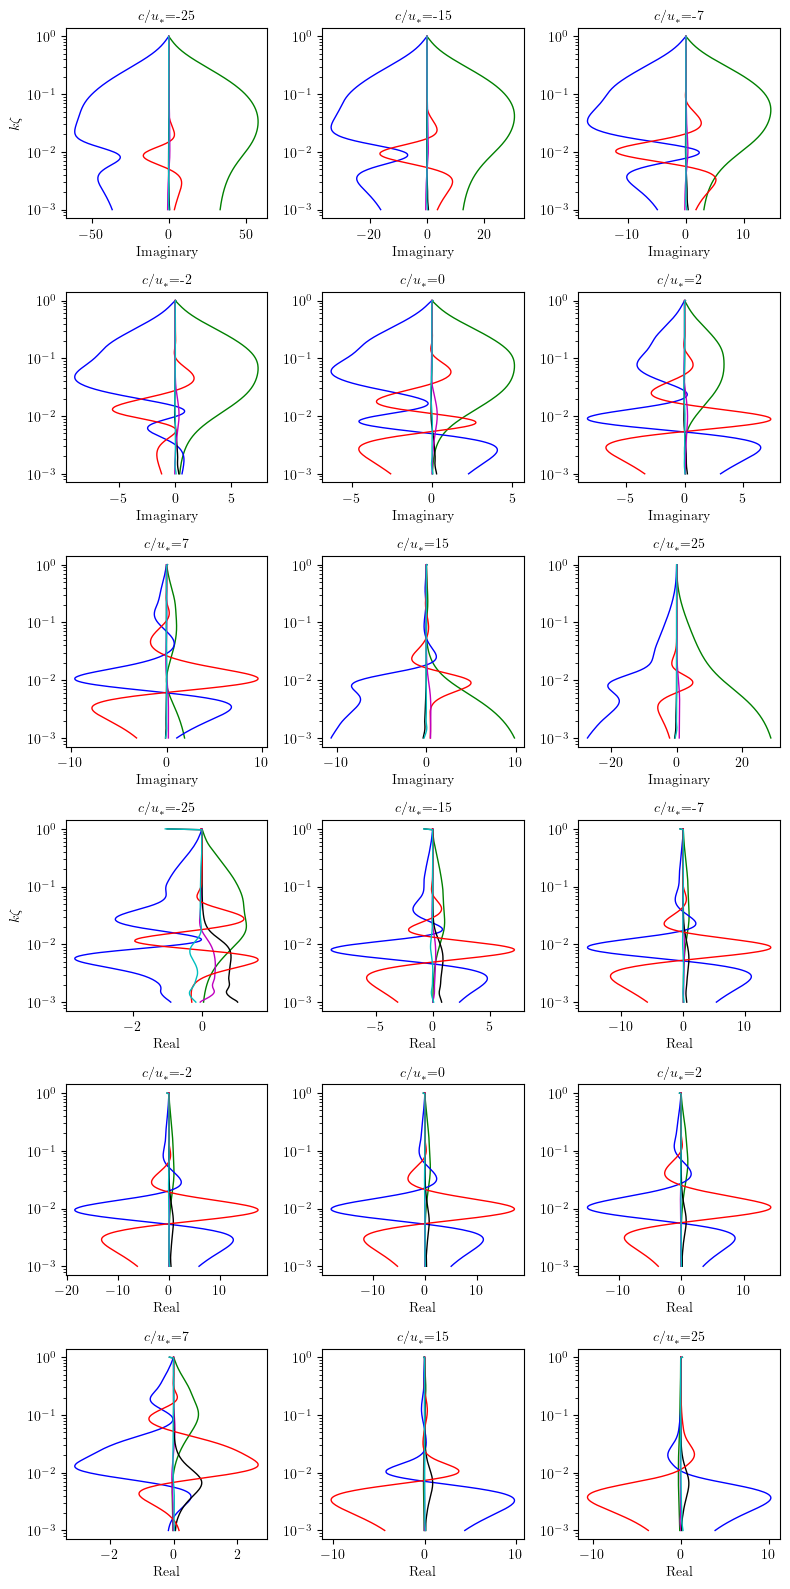

In [415]:
#w-momentum term by term balance
plt.figure(18,figsize=(8,16))

for num_data_select in range(9):
    z=np.logspace(np.log10(1.0e-3),np.log10(z_data[Nz-1]),200)
    
    z_data = np.asarray(LES_data[num_data_select].zw).flatten()
    U_data = np.asarray(LES_data[num_data_select].u_mean).flatten()
    U_prime_LES    = np.gradient(U_data,z_data,edge_order=2)

    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    ##############################################################################################################################
    w_hat_LES= np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    dwhatdz=np.gradient(w_hat_LES[16,:],z_data,edge_order=2)
    d2whatdz2=np.gradient(dwhatdz,z_data,edge_order=2)

    w_hat_spline     = CubicSpline(z_data[0:-1],w_hat_LES[16,0:-1])
    dwhatdz_spline   = w_hat_spline .derivative(nu=1)(z)
    d2whatdz2_spline = w_hat_spline .derivative(nu=2)(z)
    
    ##############################################################################################################################
    tau31_nu_hat_LES   = np.fft.fft(LES_data[num_data_select].tau31_nu,axis=0,norm='forward')
    tau33_nu_hat_LES   = np.fft.fft(LES_data[num_data_select].tau33_nu,axis=0,norm='forward')
    tau31_hat_LES      = np.fft.fft(LES_data[num_data_select].tau31+LES_data[num_data_select].tau31_SGS,axis=0,norm='forward')
    tau33_hat_LES      = np.fft.fft(LES_data[num_data_select].tau33_d+LES_data[num_data_select].tau33_d_SGS,axis=0,norm='forward')
    tau31_wave_hat_LES = np.fft.fft(LES_data[num_data_select].tau31_wave,axis=0,norm='forward')
    tau33_wave_hat_LES = np.fft.fft(LES_data[num_data_select].tau33_wave,axis=0,norm='forward')
    p_hat_LES          = np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')

    tau31_nu_hat_spline  = CubicSpline(z_data[0:-1],tau31_nu_hat_LES[16,0:-1])
    tau33_nu_hat_spline  = CubicSpline(z_data[0:-1],tau33_nu_hat_LES[16,0:-1])
    tau31_hat_spline     = CubicSpline(z_data[0:-1],tau31_hat_LES[16,0:-1])
    tau33_hat_spline     = CubicSpline(z_data[0:-1],tau33_hat_LES[16,0:-1])
    tau31_wave_hat_spline= CubicSpline(z_data[0:-1],tau31_wave_hat_LES[16,0:-1])
    tau33_wave_hat_spline= CubicSpline(z_data[0:-1],tau33_wave_hat_LES[16,0:-1])
    p_hat_spline         = CubicSpline(z_data[0:-1],p_hat_LES[16,0:-1])
    
    ##############################################################################################################################

    dtau33_nu_dzeta    = np.gradient(tau33_nu_hat_LES[16,:],z_data,edge_order=2)
    dtau33_dzeta       = np.gradient(tau33_hat_LES[16,:],z_data,edge_order=2)
    dtau33_wave_dzeta  = np.gradient(tau33_wave_hat_LES[16,:],z_data,edge_order=2)
    dphatdz            = np.gradient(p_hat_LES[16,:],z_data,edge_order=2)
    
    dtau33_nu_dzeta_spline   = tau33_nu_hat_spline.derivative(nu=1)(z)
    dtau33_dzeta_spline      = tau33_hat_spline.derivative(nu=1)(z)
    dtau33_wave_dzeta_spline = tau33_wave_hat_spline.derivative(nu=1)(z)
    dphatdz_spline           = p_hat_spline.derivative(nu=1)(z)
    
    ##############################################################################################################################
    
    adv_term=(U_data-c_array[num_data_select])**1*w_hat_LES[16,:]
    dpdz_term=(dphatdz)/((U_data-c_array[num_data_select])**0*1j*k_wavno)
    #visc_term=-nu*(-k_wavno**2*w_hat_LES[16,:]+d2whatdz2)#1j*k_wavno*tau31_nu_hat_LES[16,:]+dtau33_nu_dzeta
    visc_term=(1j*k_wavno*tau31_nu_hat_LES[16,:]+dtau33_nu_dzeta)/((U_data-c_array[num_data_select])**0*1j*k_wavno)
    turb_term=(1j*k_wavno*tau31_hat_LES[16,:]+dtau33_dzeta)/((U_data-c_array[num_data_select])**0*1j*k_wavno)
    wave_term=(1j*k_wavno*tau31_wave_hat_LES[16,:]+dtau33_wave_dzeta)/((U_data-c_array[num_data_select])**0*1j*k_wavno)
    full_term=adv_term+dpdz_term+visc_term+turb_term+wave_term

    ##############################################################################################################################
    
    adv_term_spline=((U_spline(z)-c_array[num_data_select])**1*1j*k_wavno*w_hat_spline(z))/(1j*k_wavno)
    dpdz_term_spline=(dphatdz_spline)/((U_spline(z)-c_array[num_data_select])**0*1j*k_wavno)
    #visc_term=-nu*(-k_wavno**2*w_hat_LES[16,:]+d2whatdz2)#1j*k_wavno*tau31_nu_hat_LES[16,:]+dtau33_nu_dzeta
    visc_term_spline=(1j*k_wavno*tau31_nu_hat_spline(z)   + dtau33_nu_dzeta_spline)/((U_spline(z)-c_array[num_data_select])**0*1j*k_wavno)
    turb_term_spline=(1j*k_wavno*tau31_hat_spline(z)      + dtau33_dzeta_spline)/((U_spline(z)-c_array[num_data_select])**0*1j*k_wavno)
    wave_term_spline=(1j*k_wavno*tau31_wave_hat_spline(z) + dtau33_wave_dzeta_spline)/((U_spline(z)-c_array[num_data_select])**0*1j*k_wavno)
    full_term_spline=adv_term_spline+dpdz_term_spline+visc_term_spline+turb_term_spline+wave_term_spline

    ##############################################################################################################################
    
    ax1=plt.subplot(6,3,num_data_select+1)

    # plt.semilogy(adv_term.imag,z_data,'g',linewidth=1)
    # plt.semilogy(dpdz_term.imag,z_data,'b',linewidth=1)
    # plt.semilogy(visc_term.imag,z_data,'k',linewidth=1)
    # plt.semilogy(turb_term.imag,z_data,'r',linewidth=1)
    # plt.semilogy(wave_term.imag,z_data,'m',linewidth=1)
    # plt.semilogy(full_term.imag,z_data,'c',linewidth=1)

    plt.semilogy(adv_term_spline.imag,z,'g',linewidth=1)
    plt.semilogy(dpdz_term_spline.imag,z,'b',linewidth=1)
    plt.semilogy(visc_term_spline.imag,z,'k',linewidth=1)
    plt.semilogy(turb_term_spline.imag,z,'r',linewidth=1)
    plt.semilogy(wave_term_spline.imag,z,'m',linewidth=1)
    plt.semilogy(full_term_spline.imag,z,'c',linewidth=1)
    
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=font_size)
    if num_data_select == 0:
        ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    ax1.set_xlabel(r'Imaginary',fontsize=font_size)
    
    ax1.tick_params(labelsize=font_size)
    
    ax1=plt.subplot(6,3,9+num_data_select+1)
    
    #plt.semilogy(adv_term.real,z_data,'g',linewidth=1)
    # plt.semilogy(dpdz_term.real,z_data,'b',linewidth=1)
    # plt.semilogy(visc_term.real,z_data,'k',linewidth=1)
    # plt.semilogy(turb_term.real,z_data,'r',linewidth=1)
    # plt.semilogy(wave_term.real,z_data,'m',linewidth=1)
    # plt.semilogy(full_term.real,z_data,'c',linewidth=1)

    plt.semilogy(adv_term_spline.real,z,'g',linewidth=1)
    plt.semilogy(dpdz_term_spline.real,z,'b',linewidth=1)
    plt.semilogy(wave_term_spline.real,z,'m',linewidth=1)
    plt.semilogy(visc_term_spline.real,z,'k',linewidth=1)
    plt.semilogy(turb_term_spline.real,z,'r',linewidth=1)
    plt.semilogy(full_term_spline.real,z,'c',linewidth=1)

    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=font_size)
    if num_data_select == 0:
        ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    ax1.set_xlabel(r'Real',fontsize=font_size)
    
    ax1.tick_params(labelsize=font_size)

    # ax1=plt.subplot(9,3,num_data_select*3+3)
    # plt.semilogy(w_hat_LES[16,:].real,z_data,'ro')
    # plt.semilogy(w_hat_LES[16,:].imag,z_data,'bv')
    # ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
plt.savefig('w_momentum_budget.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

plt.show()

\begin{align*}
\left[(\langle{u}\rangle-c)\left(\frac{\partial^2}{\partial\zeta^2}-k^2\right)-\frac{\partial^2\langle{u}\rangle}{\partial\zeta^2}-\frac{\nu}{\mathrm{i}k}\left[\frac{\partial^4}{\partial\zeta^4}-2k^2\frac{\partial^2}{\partial\zeta^2}+k^4\right]\right]\hat{w}&
     =\nu\hat{\eta}\frac{\partial^2}{\partial\zeta^2}\left[g\frac{\partial^2\langle u\rangle}{\partial\zeta^2}\right]\\
     &\mspace{20mu}+\mathrm{i}k\frac{\partial}{\partial\zeta}(\hat{\tau}^{w}_{11}+\hat{\tau}_{11})+\frac{\partial^2}{\partial \zeta^2}(\hat{\tau}^{w}_{13}+\hat{\tau}_{13})\\
     &\mspace{20mu}+k^2(\hat{\tau}^{w}_{31}+\hat{\tau}_{31})-\mathrm{i}k\frac{\partial}{\partial \zeta}(\hat{\tau}^{w}_{33}+\hat{\tau}_{33})
\end{align*}

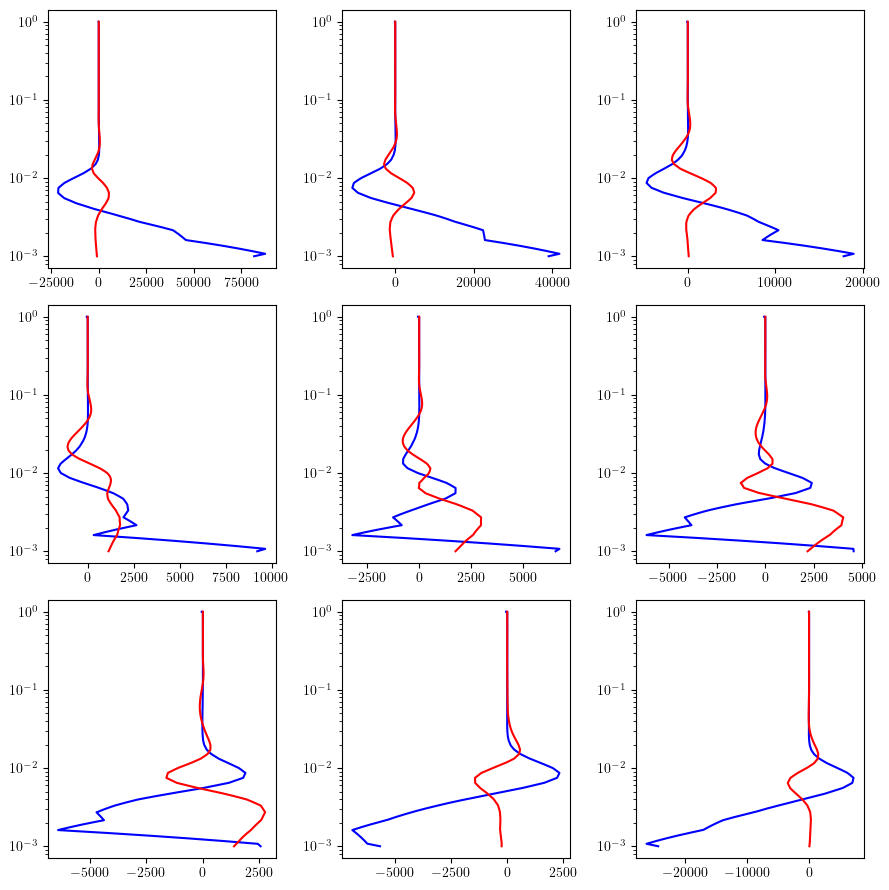

In [444]:
plt.figure(18,figsize=(9,9))
for num_data_select in range(9):
    
    ax1=plt.subplot(3,3,num_data_select+1)

    z              = np.logspace(np.log10(1.0e-3),np.log10(z_data[Nz-1]),2000)
    z_data         = np.asarray(LES_data[num_data_select].zw).flatten()
    U_data         = np.asarray(LES_data[num_data_select].u_mean).flatten()
    U_prime_LES    = np.gradient(U_data,z_data,edge_order=2)

    tau13_nu_hat_LES     = np.fft.fft(LES_data[num_data_select].tau13_nu,axis=0,norm='forward')
    tau31_nu_hat_LES     = np.fft.fft(LES_data[num_data_select].tau31_nu,axis=0,norm='forward')
    tau33_nu_hat_LES     = np.fft.fft(LES_data[num_data_select].tau33_nu,axis=0,norm='forward')
    tau11_nu_hat_LES     = np.fft.fft(LES_data[num_data_select].tau11_nu,axis=0,norm='forward')
    
    tau31_hat_LES        = np.fft.fft(LES_data[num_data_select].tau31+LES_data[num_data_select].tau31_SGS,axis=0,norm='forward')
    tau13_hat_LES        = np.fft.fft(LES_data[num_data_select].tau13+LES_data[num_data_select].tau13_SGS,axis=0,norm='forward')
    tau33_hat_LES        = np.fft.fft(LES_data[num_data_select].tau33_d+LES_data[num_data_select].tau33_d_SGS,axis=0,norm='forward')
    tau11_hat_LES        = np.fft.fft(LES_data[num_data_select].tau11_d+LES_data[num_data_select].tau11_d_SGS,axis=0,norm='forward')

    p_hat_LES            = np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')

    U_spline             = CubicSpline(z_data[0:-1],U_data[0:-1])
    
    tau13_nu_hat_spline  = CubicSpline(z_data[0:-1],tau13_nu_hat_LES[16,0:-1])
    tau31_nu_hat_spline  = CubicSpline(z_data[0:-1],tau31_nu_hat_LES[16,0:-1])
    tau11_nu_hat_spline  = CubicSpline(z_data[0:-1],tau11_nu_hat_LES[16,0:-1])
    tau33_nu_hat_spline  = CubicSpline(z_data[0:-1],tau33_nu_hat_LES[16,0:-1])

    tau13_hat_spline     = CubicSpline(z_data[0:-1],tau13_hat_LES[16,0:-1])
    tau31_hat_spline     = CubicSpline(z_data[0:-1],tau31_hat_LES[16,0:-1])
    tau33_hat_spline     = CubicSpline(z_data[0:-1],tau33_hat_LES[16,0:-1])
    tau11_hat_spline     = CubicSpline(z_data[0:-1],tau11_hat_LES[16,0:-1])
    
    d2dz2_tau13_nu_hat_spline  = tau13_nu_hat_spline.derivative(nu=2)(z)
    ddz_tau11_nu_hat_spline    = tau11_nu_hat_spline.derivative(nu=1)(z)
    ddz_tau33_nu_hat_spline    = tau33_nu_hat_spline.derivative(nu=1)(z)   
    
    visc_term = 1j*k_wavno*(ddz_tau11_nu_hat_spline-ddz_tau33_nu_hat_spline) \
                +d2dz2_tau13_nu_hat_spline+k_wavno**2*tau31_nu_hat_spline(z)

    d2dz2_tau13_hat_spline  = tau13_hat_spline.derivative(nu=2)(z)
    ddz_tau11_hat_spline    = tau11_hat_spline.derivative(nu=1)(z)
    ddz_tau33_hat_spline    = tau33_hat_spline.derivative(nu=1)(z)   
    
    turb_term = 1j*k_wavno*(ddz_tau11_hat_spline-ddz_tau33_hat_spline) \
                +d2dz2_tau13_hat_spline+k_wavno**2*tau31_hat_spline(z)

    plt.semilogy(visc_term,z,'b')
    plt.semilogy(turb_term,z,'r')
    
plt.show()


\begin{align*}
T_D&=\frac{\lambda}{|U_z-c|},\\
T_L&=\frac{\kappa z}{u_*},\\
T_D &\sim T_L,\\
k\ell&=2\kappa\frac{u_*}{|U_\ell-c|},\\
|U_\ell-c|&=\frac{2\kappa u_*}{k\ell}
\end{align*}

/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/649304484.py:11: RuntimeWarning: divide by zero encountered in divide
  ax1.semilogy(2*0.41/(k_wavno*z_data),k_wavno*z_data,'k--')
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/649304484.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=18,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/649304484.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=18,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/649304484.py:92: RuntimeWarning: invalid value encountered in sqrt
  arr=(ustar/0.41/np.asarray(LES_data[n].u_w_t_avg_mean).flatten())**(1/2)-k_wavno*z_dat

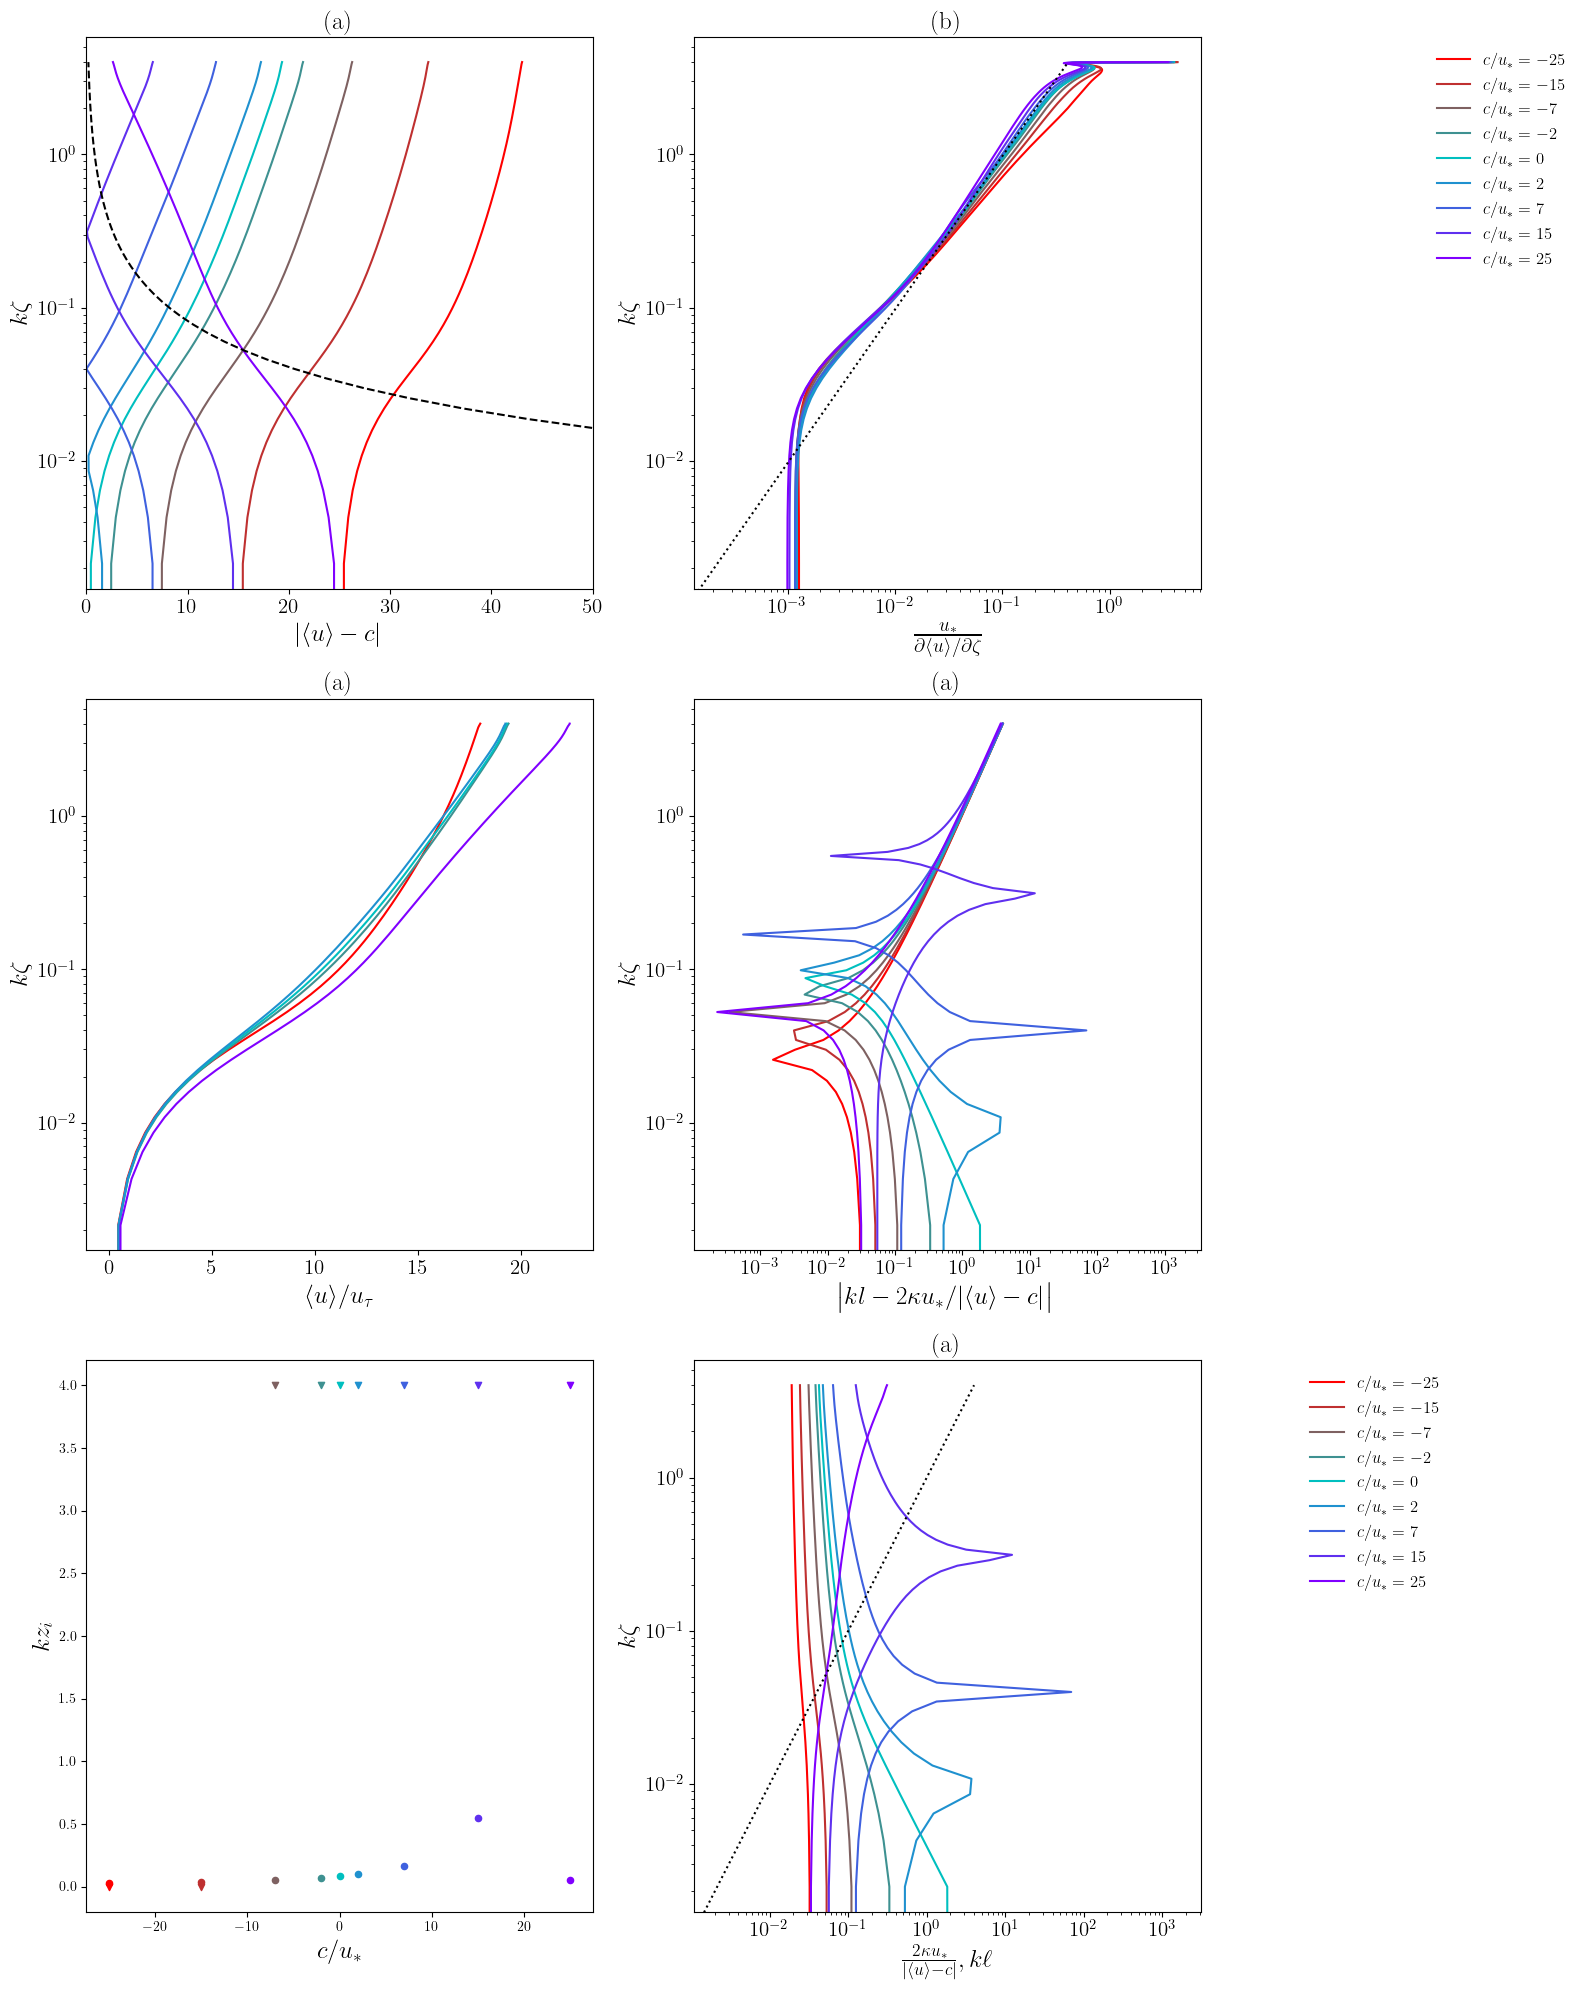

In [809]:
#Velocity plot
plt.figure(18,figsize=(16,20))
legend_name=['$c/u_*=-25$','$c/u_*=-15$','$c/u_*=-7$','$c/u_*=-2$','$c/u_*=0$','$c/u_*=2$','$c/u_*=7$','$c/u_*=15$','$c/u_*=25$']
ax1=plt.subplot(321)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    u_data = np.asarray(LES_data[n].u_mean).flatten()
    U_data = np.asarray(LES_data[n].U_mean).flatten()
    
    ax1.semilogy(np.abs(u_data-c_array[n]),k_wavno*z_data,color=color_array[n])
ax1.semilogy(2*0.41/(k_wavno*z_data),k_wavno*z_data,'k--')
plt.xlim(0,50)
#ax1.legend(bbox_to_anchor=(1.2, 1))
ax1.set_title('(a)', fontsize=18)
ax1.set_ylabel(r'$k\zeta$',fontsize=18)
ax1.set_xlabel(r'$|\langle u \rangle-c|$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
#ax1.tick_params(labelsize=18)
#ax1.set_xlim(0.,1.2)
#ax1.set_ylim(0,1)
ax1.tick_params(labelsize=15)
ax1.legend(fontsize=18,frameon=False)

ax1=plt.subplot(322)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    u_data = np.asarray(LES_data[n].u_mean).flatten()
    U_data = np.asarray(LES_data[n].U_mean).flatten()
    dUdz_data=np.gradient(U_data,z_data,edge_order=2)
    #ax1.semilogy(dUdz_data*(kappa*z_data/ustar),k_wavno*z_data,color=color_array[n],label=legend_name[n])
    ax1.loglog(1/dUdz_data,k_wavno*z_data,color=color_array[n],label=legend_name[n])
ax1.loglog(0.41*z_data,k_wavno*z_data,'k:')
    
    
#ax1.legend(bbox_to_anchor=(1.2, 1))
ax1.set_title('(b)', fontsize=18)
ax1.set_ylabel(r'$k\zeta$',fontsize=18)

#ax1.set_xlabel(r'$\frac{\partial\langle u \rangle}{\partial \zeta}\frac{\kappa \zeta}{u_\tau}$',fontsize=20)
ax1.set_xlabel(r'$\frac{u_*}{\partial\langle u \rangle/\partial \zeta}$',fontsize=20)

#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
#ax1.tick_params(labelsize=18)
#ax1.set_xlim(0.,1.2)
#ax1.set_ylim(0,1)
ax1.tick_params(labelsize=15)
ax1.legend(bbox_to_anchor=(1.75, 1),fontsize=12,frameon=False)


ax1=plt.subplot(323)
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    u_data = np.asarray(LES_data[n].u_mean).flatten()
    U_data = np.asarray(LES_data[n].U_mean).flatten()
    
    ax1.semilogy(u_data,k_wavno*z_data,color=limited_color_array[counter])
    counter=counter+1
#ax1.legend(bbox_to_anchor=(1.2, 1))
ax1.set_title('(a)', fontsize=18)
ax1.set_ylabel(r'$k\zeta$',fontsize=18)
ax1.set_xlabel(r'$\langle u \rangle/u_\tau$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
#ax1.tick_params(labelsize=18)
#ax1.set_xlim(0.,1.2)
#ax1.set_ylim(0,1)
ax1.tick_params(labelsize=15)
ax1.legend(fontsize=18,frameon=False)

ax1=plt.subplot(324)
counter=0
inner_layer_depth   = np.zeros((num_data,),dtype='float')
inner_layer_depth_2 = np.zeros((num_data,),dtype='float')
critical_layer_depth= np.zeros((num_data,),dtype='float')
outer_layer_depth   = np.zeros((num_data,),dtype='float')

for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    
    ax1.loglog(np.abs(k_wavno*z_data-2*0.41/(np.abs(np.asarray(LES_data[n].u_w_t_avg_mean).flatten()-c_array[n]))),k_wavno*z_data,color=color_array[counter])
    arr=np.abs(k_wavno*z_data-2*0.41/(np.abs(np.asarray(LES_data[n].u_w_t_avg_mean).flatten()-c_array[n])))
    min_index = np.argmin(arr)
    inner_layer_depth[n]=k_wavno*z_data[min_index]

    arr=np.abs(np.asarray(LES_data[n].u_w_t_avg_mean).flatten()-c_array[n])
    min_index = np.argmin(arr)
    critical_layer_depth[n]=k_wavno*z_data[min_index]

    arr=(ustar/0.41/np.asarray(LES_data[n].u_w_t_avg_mean).flatten())**(1/2)-k_wavno*z_data
    min_index = np.argmin(arr)
    outer_layer_depth[n]=k_wavno*z_data[min_index]
    

    counter=counter+1
#ax1.loglog(k_wavno*z_data,k_wavno*z_data,'k:')

#ax1.legend(bbox_to_anchor=(1.2, 1))
ax1.set_title('(a)', fontsize=18)
ax1.set_ylabel(r'$k\zeta$',fontsize=18)
ax1.set_xlabel(r'$\biggl|kl-2\kappa{u_*}/{|\langle u \rangle-c|}\biggr|$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
#ax1.tick_params(labelsize=18)
#ax1.set_xlim(0.,1.2)
#ax1.set_ylim(0,1)
ax1.tick_params(labelsize=15)
ax1.legend(fontsize=18,frameon=False)

ax1=plt.subplot(325)
for n in range(num_data-1):
    plt.scatter(c_array[n],inner_layer_depth[n],color=color_array[n],marker='o',s=20)
    plt.scatter(c_array[n],outer_layer_depth[n],color=color_array[n],marker='v',s=20)
ax1.set_xlabel(r'$c/u_*$',fontsize=18)
ax1.set_ylabel(r'$k z_i$',fontsize=18)


ax1=plt.subplot(326)
counter=0
z_array=np.linspace(1e-2,10,1000)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    ax1.loglog(2*kappa*1/np.abs(np.asarray(LES_data[n].u_w_t_avg_mean).flatten()-c_array[n]),k_wavno*z_data,color=color_array[counter],label=legend_name[n])
    counter=counter+1
ax1.semilogy(k_wavno*z_data,k_wavno*z_data,'k:')

#ax1.legend(bbox_to_anchor=(1.2, 1))
ax1.set_title('(a)', fontsize=18)
ax1.set_ylabel(r'$k\zeta$',fontsize=18)
ax1.set_xlabel(r'$\frac{2\kappa u_*}{|\langle u \rangle-c|},k\ell$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
#ax1.tick_params(labelsize=18)
#ax1.set_xlim(0.,1.2)
#ax1.set_ylim(0,1)
ax1.tick_params(labelsize=15)
ax1.legend(bbox_to_anchor=(1.5, 1),fontsize=12,frameon=False)

plt.savefig('U_dUdz_plot.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

plt.show()

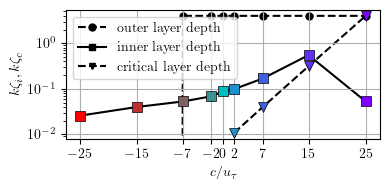

In [812]:
plt.figure(18, figsize=(4, 2))
font_size = 10
ax1 = plt.subplot(111)

# Line plots with markers
plt.semilogy(c_array[0:-1], outer_layer_depth[0:-1], linestyle='--', color='k', 
             label='outer layer depth', marker='o', markersize=5, zorder=1)

plt.semilogy(c_array[0:-1], inner_layer_depth[0:-1], linestyle='-', color='k', 
             label='inner layer depth', marker='s', markersize=5, zorder=1)
plt.semilogy(c_array[5:-1], critical_layer_depth[5:-1], linestyle='--', color='k', 
             label='critical layer depth', marker='v', markersize=5, zorder=1)

# Scatter plots with higher z-order to ensure they overlay the line plots
for n in range(num_data - 1):
    plt.scatter(c_array[n], inner_layer_depth[n], marker='s', color=color_array[n], 
                s=50, edgecolors='k', linewidth=0.5, zorder=2)
    plt.scatter(c_array[n], critical_layer_depth[n], marker='v', color=color_array[n], 
                s=50, edgecolors='k', linewidth=0.5, zorder=2)

plt.yscale('log')
plt.xticks([-25, -15, -7, -2, 0, 2, 7, 15, 25], fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.legend(fontsize=font_size)
#ax1.set_ylim(0, 1)
plt.grid()

plt.xlabel(r'$c/u_\tau$', fontsize=font_size)
plt.ylabel(r'$k\zeta_i,k\zeta_c$', fontsize=font_size)

# Save figure
plt.savefig('inner_critical_depth.png', format='png', dpi=600, bbox_inches='tight',
            transparent=False, pad_inches=0.01)

plt.show()


/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/3107313496.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=font_size,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/3107313496.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=font_size,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/3107313496.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=font_size,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/3107313496.py:75: UserWarning: No a

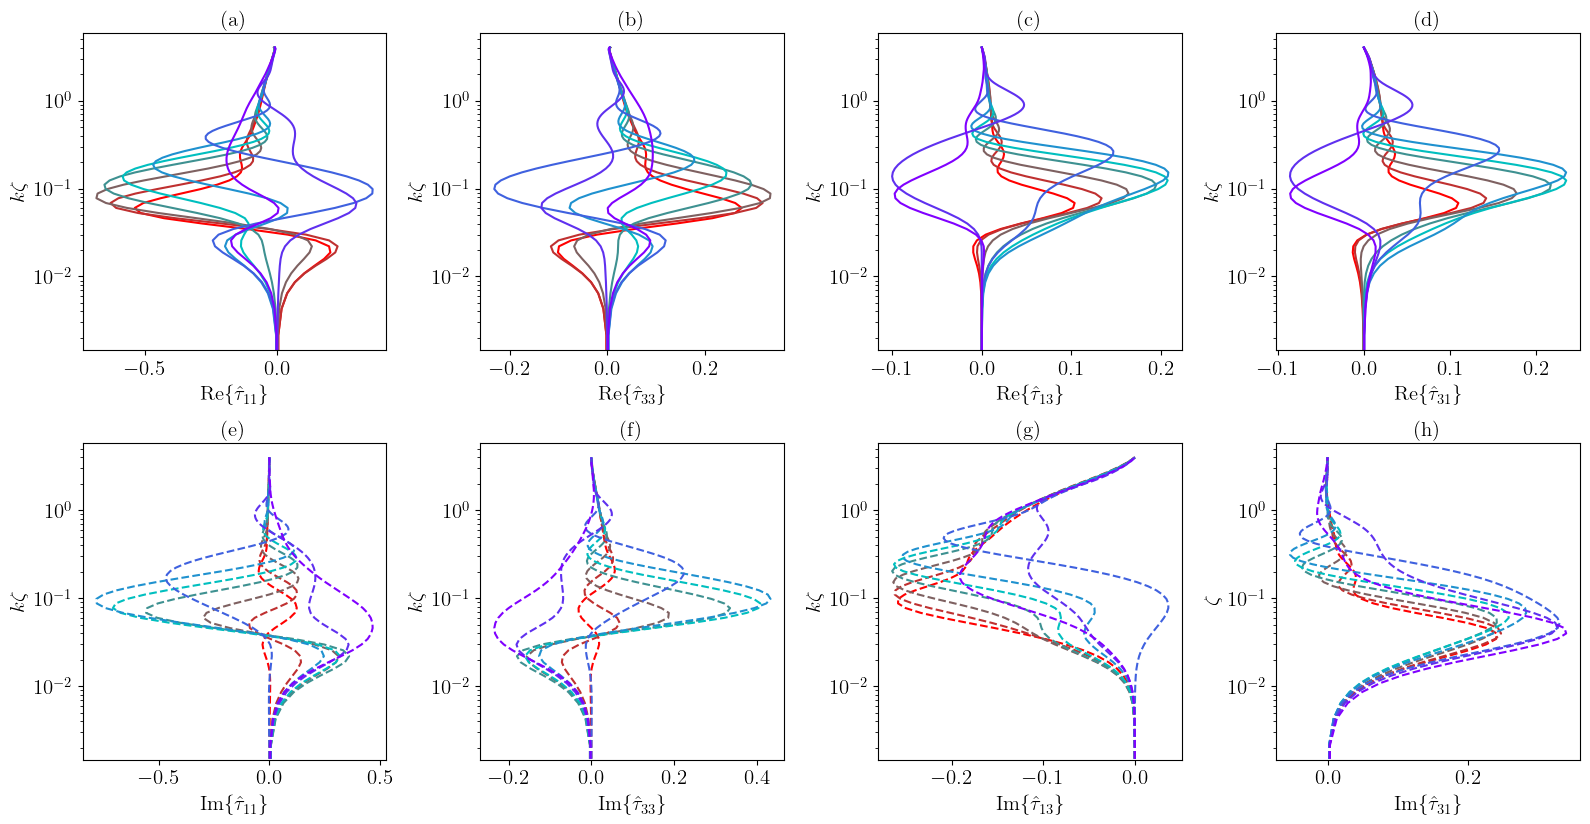

In [15]:
#Stress plot
plt.figure(18,figsize=(16,16))
# ax1=plt.subplot(341)
# for n in range(num_data-1):
#     z_data = np.asarray(LES_data[n].zw).flatten()
#     u_data = np.asarray(LES_data[n].u_mean).flatten()
#     U_data = np.asarray(LES_data[n].U_mean).flatten()
    
#     ax1.semilogy(u_data,z_data,color=color_array[n])
    

# ax1.set_ylabel(r'$\zeta$',fontsize=18)
# ax1.set_xlabel(r'$\langle u \rangle$',fontsize=18)
# #ax1.set_xticks([0,.5,1.0])
# #ax1.set_yticks([0.5,1])
# #ax1.tick_params(labelsize=18)
# #ax1.set_xlim(0.,1.2)
# #ax1.set_ylim(0,1)
# ax1.tick_params(labelsize=15)
# ax1.legend(fontsize=18,frameon=False)
font_size=15;
ax1=plt.subplot(441)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau11_hat_LES = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    
    ax1.semilogy(tau11_hat_LES[16,:].real,k_wavno*z_data,color=color_array[n])
#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
ax1.set_title('(a)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'Re$\{\hat{\tau}_{11}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(445)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau11_hat_LES = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    
    ax1.semilogy(tau11_hat_LES[16,:].imag,k_wavno*z_data,color=color_array[n],linestyle='--')

    ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_title('(e)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Im$\{\hat{\tau}_{11}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(442)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau33_hat_LES = np.fft.fft(LES_data[n].tau33+LES_data[n].tau33_SGS,axis=0,norm='forward')    
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')    
    
    ax1.semilogy(tau33_hat_LES[16,:].real,k_wavno*z_data,color=color_array[n])
ax1.set_title('(b)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'Re$\{\hat{\tau}_{33}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(446)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau33_hat_LES = np.fft.fft(LES_data[n].tau33+LES_data[n].tau33_SGS,axis=0,norm='forward')    
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau33_hat_LES[16,:].imag,k_wavno*z_data,color=color_array[n],linestyle='--')

    ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_title('(f)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Im$\{\hat{\tau}_{33}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

########################################################################################################################################################

ax1=plt.subplot(443)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau13_hat_LES = np.fft.fft(LES_data[n].tau13+LES_data[n].tau13_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau13_hat_LES[16,:].real,k_wavno*z_data,color=color_array[n])
ax1.set_title('(c)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'Re$\{\hat{\tau}_{13}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(447)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau13_hat_LES = np.fft.fft(LES_data[n].tau13+LES_data[n].tau13_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau13_hat_LES[16,:].imag,k_wavno*z_data,color=color_array[n],linestyle='--')

    ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_title('(g)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Im$\{\hat{\tau}_{13}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(444)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau31_hat_LES = np.fft.fft(LES_data[n].tau31+LES_data[n].tau31_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau31_hat_LES[16,:].real,k_wavno*z_data,color=color_array[n])
ax1.set_title('(d)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'Re$\{\hat{\tau}_{31}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(448)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau31_hat_LES = np.fft.fft(LES_data[n].tau31+LES_data[n].tau31_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau31_hat_LES[16,:].imag,k_wavno*z_data,color=color_array[n],linestyle='--')

    ax1.set_ylabel(r'$\zeta$',fontsize=font_size)
ax1.set_title('(h)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Im$\{\hat{\tau}_{31}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

plt.savefig('tau_ij_plot_LES.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

plt.show()


/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/2288323714.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=font_size,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/2288323714.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=font_size,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/2288323714.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=font_size,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/2288323714.py:82: UserWarning: No a

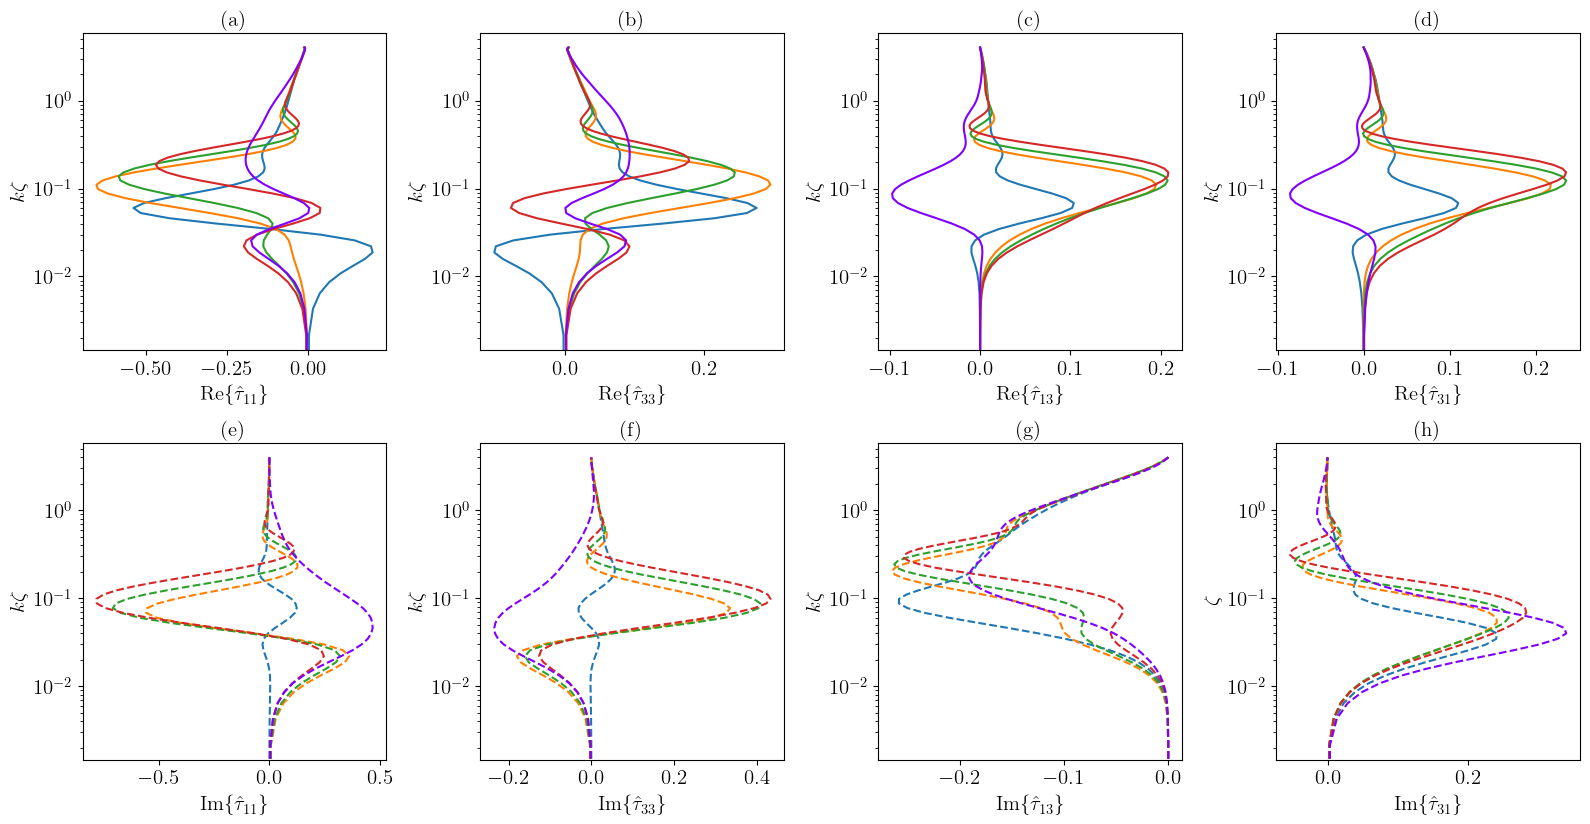

In [17]:
#Limited Stress plot
plt.figure(18,figsize=(16,16))
# ax1=plt.subplot(341)
# for n in limited_c_array_index:
#     z_data = np.asarray(LES_data[n].zw).flatten()
#     u_data = np.asarray(LES_data[n].u_mean).flatten()
#     U_data = np.asarray(LES_data[n].U_mean).flatten()
    
#     ax1.semilogy(u_data,z_data,color=limited_color_array[counter])
    

# ax1.set_ylabel(r'$\zeta$',fontsize=18)
# ax1.set_xlabel(r'$\langle u \rangle$',fontsize=18)
# #ax1.set_xticks([0,.5,1.0])
# #ax1.set_yticks([0.5,1])
# #ax1.tick_params(labelsize=18)
# #ax1.set_xlim(0.,1.2)
# #ax1.set_ylim(0,1)
# ax1.tick_params(labelsize=15)
# ax1.legend(fontsize=18,frameon=False)
font_size=15;
ax1=plt.subplot(441)
counter=0;
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau11_hat_LES = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    
    ax1.semilogy(tau11_hat_LES[16,:].real,k_wavno*z_data,color=limited_color_array[counter])
    counter=counter+1
#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
ax1.set_title('(a)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'Re$\{\hat{\tau}_{11}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(445)
counter=0;
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau11_hat_LES = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    
    ax1.semilogy(tau11_hat_LES[16,:].imag,k_wavno*z_data,color=limited_color_array[counter],linestyle='--')
    counter=counter+1
    ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_title('(e)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Im$\{\hat{\tau}_{11}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(442)
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau33_hat_LES = np.fft.fft(LES_data[n].tau33+LES_data[n].tau33_SGS,axis=0,norm='forward')    
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')    
    
    ax1.semilogy(tau33_hat_LES[16,:].real,k_wavno*z_data,color=limited_color_array[counter])
    counter=counter+1
ax1.set_title('(b)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'Re$\{\hat{\tau}_{33}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(446)
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau33_hat_LES = np.fft.fft(LES_data[n].tau33+LES_data[n].tau33_SGS,axis=0,norm='forward')    
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau33_hat_LES[16,:].imag,k_wavno*z_data,color=limited_color_array[counter],linestyle='--')

    ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    counter=counter+1
ax1.set_title('(f)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Im$\{\hat{\tau}_{33}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

########################################################################################################################################################

ax1=plt.subplot(443)
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau13_hat_LES = np.fft.fft(LES_data[n].tau13+LES_data[n].tau13_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau13_hat_LES[16,:].real,k_wavno*z_data,color=limited_color_array[counter])
    counter=counter+1
ax1.set_title('(c)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'Re$\{\hat{\tau}_{13}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(447)
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau13_hat_LES = np.fft.fft(LES_data[n].tau13+LES_data[n].tau13_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau13_hat_LES[16,:].imag,k_wavno*z_data,color=limited_color_array[counter],linestyle='--')

    ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    counter=counter+1
ax1.set_title('(g)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Im$\{\hat{\tau}_{13}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(444)
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau31_hat_LES = np.fft.fft(LES_data[n].tau31+LES_data[n].tau31_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau31_hat_LES[16,:].real,k_wavno*z_data,color=limited_color_array[counter])
    counter=counter+1
ax1.set_title('(d)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'Re$\{\hat{\tau}_{31}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(448)
counter=0;
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau31_hat_LES = np.fft.fft(LES_data[n].tau31+LES_data[n].tau31_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau31_hat_LES[16,:].imag,k_wavno*z_data,color=limited_color_array[counter],linestyle='--')

    ax1.set_ylabel(r'$\zeta$',fontsize=font_size)
    counter=counter+1;
ax1.set_title('(h)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Im$\{\hat{\tau}_{31}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

plt.savefig('tau_ij_plot_LES_limited.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

plt.show()

/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/1706624037.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=font_size,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/1706624037.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=font_size,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/1706624037.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=font_size,frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/1706624037.py:100: UserWarning: No 

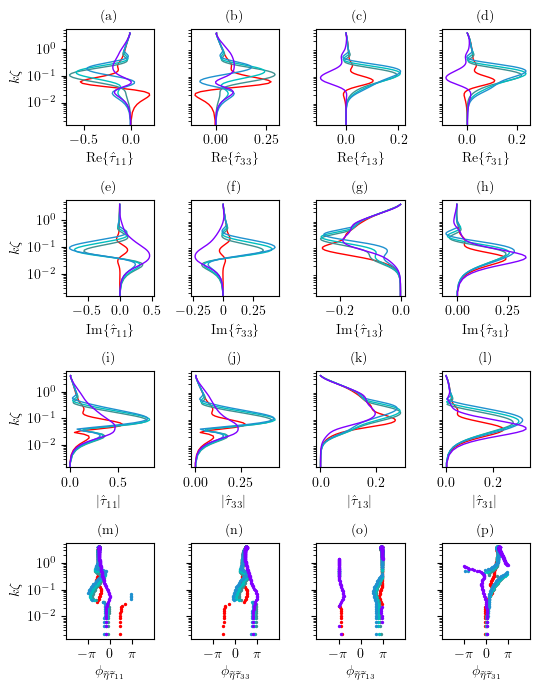

In [641]:
#Limited Stress plot - Re, Im, mag, phase
plt.figure(18,figsize=(5.5,7))

font_size=10;
ax1=plt.subplot(441)
counter=0;
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau11_hat_LES = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    
    ax1.semilogy(tau11_hat_LES[16,:].real,k_wavno*z_data,color=limited_color_array[counter],linewidth=1)
    counter=counter+1
#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
ax1.set_title('(a)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'Re$\{\hat{\tau}_{11}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(445)
counter=0;
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau11_hat_LES = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    
    ax1.semilogy(tau11_hat_LES[16,:].imag,k_wavno*z_data,color=limited_color_array[counter],linestyle='-',linewidth=1)
    counter=counter+1
    ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_title('(e)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Im$\{\hat{\tau}_{11}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(449)
counter=0;
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau11_hat_LES = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    
    ax1.semilogy(np.abs(tau11_hat_LES[16,:]),k_wavno*z_data,color=limited_color_array[counter],linestyle='-',linewidth=1)
    counter=counter+1
    ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_title('(i)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{11}|$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

# ax1=plt.subplot(4,4,13,projection='polar')
# ax1.tick_params(labelsize=font_size, pad=-3)
# counter=0
# for n in limited_c_array_index:
#     z_data = np.asarray(LES_data[n].zw).flatten()
#     tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')    
#     #ax1.semilogy( np.arctan2(np.real(tau11_hat_LES[16,0:-2]), np.imag(tau11_hat_LES[16,0:-2]))*180/np.pi,k_wavno*z_data[0:-2],color=limited_color_array[counter],marker='o',markerfacecolor='none',linestyle='none')
#     ax1.scatter( np.arctan2(np.real(tau11_hat_LES[16,0:-2]), np.imag(tau11_hat_LES[16,0:-2])),k_wavno*z_data[0:-2],color=limited_color_array[counter],marker='o',s=2)
    
#     counter=counter+1
# ax1.set_title('(m)', fontsize=font_size, loc='center')
# #ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
# ax1.text(np.deg2rad(360-20), 2.5, r'$k\zeta$', fontsize=font_size, verticalalignment='bottom', horizontalalignment='center')
# ax1.set_xlabel(r'$\phi_{\widetilde{\eta}\widetilde{\tau}_{11}}$',fontsize=font_size)
# ax1.tick_params(labelsize=font_size)
# tick_locations = np.radians([0, 90, 180, 270])
# tick_labels = [r'$0$', r'$\pi/2$', 
#                r'$\pi$',  r'$3\pi/2$']
# ax1.set_xticks(tick_locations)
# ax1.set_xticklabels(tick_labels, fontsize=font_size)

# #ax1.set_xlim(-200,200)
# #ax1.set_xticks([-180,-90,0,90,180])

# ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(4,4,13)
counter=0
ax1.tick_params(labelsize=font_size)
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')    
    #ax1.semilogy( np.arctan2(np.real(tau13_hat_LES[16,0:-2]), np.imag(tau13_hat_LES[16,0:-2]))*180/np.pi,k_wavno*z_data[0:-2],color=limited_color_array[counter],marker='o',markerfacecolor='none',linestyle='none')
    ax1.scatter( np.arctan2(np.real(tau11_hat_LES[16,0:-2]), np.imag(tau11_hat_LES[16,0:-2])),k_wavno*z_data[0:-2],color=limited_color_array[counter],marker='o',s=2)
 
    counter=counter+1
plt.yscale('log')

ax1.set_title('(m)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'$\phi_{\widetilde{\eta}\widetilde{\tau}_{11}}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
tick_locations = np.radians([-180,0,180])
tick_labels = [r'$-\pi$',r'$0$',  r'$\pi$']
ax1.set_xticks(tick_locations)
ax1.set_xticklabels(tick_labels, fontsize=font_size)
ax1.set_xlim(-2*np.pi,2*np.pi)
ax1.set_xticks(tick_locations)
ax1.legend(fontsize=font_size,frameon=False)

########################################################################################################################################################

ax1=plt.subplot(442)
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau33_hat_LES = np.fft.fft(LES_data[n].tau33+LES_data[n].tau33_SGS,axis=0,norm='forward')    
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')    
    
    ax1.semilogy(tau33_hat_LES[16,:].real,k_wavno*z_data,color=limited_color_array[counter],linewidth=1)
    counter=counter+1
ax1.set_title('(b)', fontsize=font_size, loc='center')
#ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'Re$\{\hat{\tau}_{33}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.set_yticks([])
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(446)
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau33_hat_LES = np.fft.fft(LES_data[n].tau33+LES_data[n].tau33_SGS,axis=0,norm='forward')    
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau33_hat_LES[16,:].imag,k_wavno*z_data,color=limited_color_array[counter],linestyle='-',linewidth=1)

    counter=counter+1
#ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_title('(f)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Im$\{\hat{\tau}_{33}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.set_yticks([])
tick_locations = np.array([-0.25,0,0.25])
tick_labels = [r'$-0.25$', r'$0$', r'$0.25$']
ax1.set_xticks(tick_locations)
ax1.set_xticklabels(tick_labels, fontsize=font_size)  # Adjust fontsize as necessary
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(4,4,10)
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau33_hat_LES = np.fft.fft(LES_data[n].tau33+LES_data[n].tau33_SGS,axis=0,norm='forward')    
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')    
    ax1.semilogy(np.abs(tau33_hat_LES[16,:]),k_wavno*z_data,color=limited_color_array[counter],linestyle='-',linewidth=1)

    counter=counter+1
#ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_title('(j)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{33}|$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.set_yticks([])
ax1.legend(fontsize=font_size,frameon=False)


# ax1=plt.subplot(4,4,14,projection='polar')
# ax1.tick_params(labelsize=font_size, pad=-3)
# counter=0
# for n in limited_c_array_index:
#     z_data = np.asarray(LES_data[n].zw).flatten()
#     tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')    
#     #ax1.semilogy( np.arctan2(np.real(tau33_hat_LES[16,0:-2]), np.imag(tau33_hat_LES[16,0:-2]))*180/np.pi,k_wavno*z_data[0:-2],color=limited_color_array[counter],marker='o',markerfacecolor='none',linestyle='none')
#     ax1.scatter( np.arctan2(np.real(tau33_hat_LES[16,0:-2]), np.imag(tau33_hat_LES[16,0:-2])),k_wavno*z_data[0:-2],color=limited_color_array[counter],marker='o',s=2)
    
#     counter=counter+1
# ax1.set_title('(n)', fontsize=font_size, loc='center')
# #ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
# ax1.text(np.deg2rad(360-20), 2.5, r'$k\zeta$', fontsize=font_size, verticalalignment='bottom', horizontalalignment='center')
# ax1.set_xlabel(r'$\phi_{\widetilde{\eta}\widetilde{\tau}_{33}}$',fontsize=font_size)
# ax1.tick_params(labelsize=font_size)
# tick_locations = np.radians([0, 90, 180, 270])
# tick_labels = [r'$0$', r'$\pi/2$', 
#                r'$\pi$',  r'$3\pi/2$']
# ax1.set_xticks(tick_locations)
# ax1.set_xticklabels(tick_labels, fontsize=font_size)

# #ax1.set_xlim(-200,200)
# #ax1.set_xticks([-180,-90,0,90,180])

# ax1.legend(fontsize=font_size,frameon=False)


ax1=plt.subplot(4,4,14)
counter=0
ax1.tick_params(labelsize=font_size)
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')    
    #ax1.semilogy( np.arctan2(np.real(tau13_hat_LES[16,0:-2]), np.imag(tau13_hat_LES[16,0:-2]))*180/np.pi,k_wavno*z_data[0:-2],color=limited_color_array[counter],marker='o',markerfacecolor='none',linestyle='none')
    ax1.scatter( np.arctan2(np.real(tau33_hat_LES[16,0:-2]), np.imag(tau33_hat_LES[16,0:-2])),k_wavno*z_data[0:-2],color=limited_color_array[counter],marker='o',s=2)
 
    counter=counter+1
plt.yscale('log')

ax1.set_title('(n)', fontsize=font_size, loc='center')
#ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'$\phi_{\widetilde{\eta}\widetilde{\tau}_{33}}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
tick_locations = np.radians([-180,0,180])
tick_labels = [r'$-\pi$',r'$0$',  r'$\pi$']
ax1.set_xticks(tick_locations)
ax1.set_xticklabels(tick_labels, fontsize=font_size)
ax1.set_xlim(-2*np.pi,2*np.pi)
ax1.set_xticks(tick_locations)
ax1.set_yticklabels('')
ax1.legend(fontsize=font_size,frameon=False)


########################################################################################################################################################

ax1=plt.subplot(443)
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau13_hat_LES = np.fft.fft(LES_data[n].tau13+LES_data[n].tau13_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau13_hat_LES[16,:].real,k_wavno*z_data,color=limited_color_array[counter],linewidth=1)
    counter=counter+1
ax1.set_title('(c)', fontsize=font_size, loc='center')
#ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'Re$\{\hat{\tau}_{13}\}$',fontsize=font_size)
ax1.set_yticks([])
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(447)
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau13_hat_LES = np.fft.fft(LES_data[n].tau13+LES_data[n].tau13_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau13_hat_LES[16,:].imag,k_wavno*z_data,color=limited_color_array[counter],linestyle='-',linewidth=1)

    counter=counter+1
#ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_title('(g)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Im$\{\hat{\tau}_{13}\}$',fontsize=font_size)
ax1.set_yticks([])
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(4,4,11)
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau13_hat_LES = np.fft.fft(LES_data[n].tau13+LES_data[n].tau13_SGS,axis=0,norm='forward')    
    ax1.semilogy(np.abs(tau13_hat_LES[16,:]),k_wavno*z_data,color=limited_color_array[counter],linestyle='-',linewidth=1)
    counter=counter+1
#ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_title('(k)', fontsize=font_size, loc='center')
ax1.set_yticks([])
ax1.set_xlabel(r'$|\hat{\tau}_{13}|$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

# ax1=plt.subplot(4,4,15,projection='polar')
# counter=0
# ax1.tick_params(labelsize=font_size, pad=-3)
# for n in limited_c_array_index:
#     z_data = np.asarray(LES_data[n].zw).flatten()
#     tau13_hat_LES = np.fft.fft(LES_data[n].tau13+LES_data[n].tau13_SGS,axis=0,norm='forward')    
#     #ax1.semilogy( np.arctan2(np.real(tau13_hat_LES[16,0:-2]), np.imag(tau13_hat_LES[16,0:-2]))*180/np.pi,k_wavno*z_data[0:-2],color=limited_color_array[counter],marker='o',markerfacecolor='none',linestyle='none')
#     ax1.scatter( np.arctan2(np.real(tau13_hat_LES[16,0:-2]), np.imag(tau13_hat_LES[16,0:-2])),k_wavno*z_data[0:-2],color=limited_color_array[counter],marker='o',s=2)
 
#     counter=counter+1
# ax1.set_title('(o)', fontsize=font_size, loc='center')
# ax1.text(np.deg2rad(360-20), 2.5, r'$k\zeta$', fontsize=font_size, verticalalignment='bottom', horizontalalignment='center')
# #ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
# ax1.set_xlabel(r'$\phi_{\widetilde{\eta}\widetilde{\tau}_{13}}$',fontsize=font_size)
# ax1.tick_params(labelsize=font_size)
# tick_locations = np.radians([0, 90, 180, 270])
# tick_labels = [r'$0$', r'$\pi/2$', 
#                r'$\pi$',  r'$3\pi/2$']
# ax1.set_xticks(tick_locations)
# ax1.set_xticklabels(tick_labels, fontsize=font_size)
# #ax1.set_xlim(-200,200)
# #ax1.set_xticks([-180,-90,0,90,180])
# ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(4,4,15)
counter=0
ax1.tick_params(labelsize=font_size)
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau13_hat_LES = np.fft.fft(LES_data[n].tau13+LES_data[n].tau13_SGS,axis=0,norm='forward')    
    #ax1.semilogy( np.arctan2(np.real(tau13_hat_LES[16,0:-2]), np.imag(tau13_hat_LES[16,0:-2]))*180/np.pi,k_wavno*z_data[0:-2],color=limited_color_array[counter],marker='o',markerfacecolor='none',linestyle='none')
    ax1.scatter( np.arctan2(np.real(tau13_hat_LES[16,0:-2]), np.imag(tau13_hat_LES[16,0:-2])),k_wavno*z_data[0:-2],color=limited_color_array[counter],marker='o',s=2)
 
    counter=counter+1
plt.yscale('log')

ax1.set_title('(o)', fontsize=font_size, loc='center')
#ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'$\phi_{\widetilde{\eta}\widetilde{\tau}_{13}}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
tick_locations = np.radians([-180,0,180])
tick_labels = [r'$-\pi$',r'$0$',  r'$\pi$']
ax1.set_xticks(tick_locations)
ax1.set_xticklabels(tick_labels, fontsize=font_size)
ax1.set_xlim(-2*np.pi,2*np.pi)
ax1.set_xticks(tick_locations)
ax1.set_yticklabels('')
ax1.legend(fontsize=font_size,frameon=False)

########################################################################################################################################################


ax1=plt.subplot(444)
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau31_hat_LES = np.fft.fft(LES_data[n].tau31+LES_data[n].tau31_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau31_hat_LES[16,:].real,k_wavno*z_data,color=limited_color_array[counter],linewidth=1)
    counter=counter+1
ax1.set_title('(d)', fontsize=font_size, loc='center')
#ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'Re$\{\hat{\tau}_{31}\}$',fontsize=font_size)
ax1.set_yticks([])
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(448)
counter=0;
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau31_hat_LES = np.fft.fft(LES_data[n].tau31+LES_data[n].tau31_SGS,axis=0,norm='forward')    
    ax1.semilogy(tau31_hat_LES[16,:].imag,k_wavno*z_data,color=limited_color_array[counter],linestyle='-',linewidth=1)
    counter=counter+1;
#ax1.set_ylabel(r'$\zeta$',fontsize=font_size)
ax1.set_title('(h)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Im$\{\hat{\tau}_{31}\}$',fontsize=font_size)
ax1.set_yticks([])
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)


ax1=plt.subplot(4,4,12)
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau31_hat_LES = np.fft.fft(LES_data[n].tau31+LES_data[n].tau31_SGS,axis=0,norm='forward')    
    ax1.semilogy(np.abs(tau31_hat_LES[16,:]),k_wavno*z_data,color=limited_color_array[counter],linewidth=1)
    counter=counter+1
ax1.set_title('(l)', fontsize=font_size, loc='center')
#ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'$|\hat{\tau}_{31}|$',fontsize=font_size)
ax1.set_yticks([])
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)


# ax1=plt.subplot(4,4,16,projection='polar')
# counter=0
# ax1.tick_params(labelsize=font_size, pad=-3)

# tick_locations = np.radians([0, 90, 180, 270])
# tick_labels = [r'$0$', r'$\pi/2$', 
#                r'$\pi$',  r'$3\pi/2$']
# for n in limited_c_array_index:
#     z_data = np.asarray(LES_data[n].zw).flatten()
#     tau31_hat_LES = np.fft.fft(LES_data[n].tau31+LES_data[n].tau31_SGS,axis=0,norm='forward')    
#     phase_angle   = 90-np.angle(((tau31_hat_LES[16,:]*1)),deg=True)
    
#     #ax1.semilogy( np.arctan2(np.real(tau31_hat_LES[16,0:-2]), np.imag(tau31_hat_LES[16,0:-2]))*180/np.pi,k_wavno*z_data[0:-2],color=limited_color_array[counter],marker='o',markerfacecolor='none',linestyle='none')
#     #ax1.semilogy( phase_angle[0:-2],k_wavno*z_data[0:-2],color=limited_color_array[counter],marker='+',markerfacecolor='none',linestyle='none') 
    
#     plt.scatter(np.arctan2(np.real(tau31_hat_LES[16,0:Nz-2]), np.imag(tau31_hat_LES[16,0:Nz-2])), k_wavno*z_data[0:Nz-2],color=limited_color_array[counter],marker='o',s=2)
#     counter=counter+1
# ax1.set_title('(p)', fontsize=font_size, loc='center')
# #ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
# ax1.set_xlabel(r'$\phi_{\widetilde{\eta}\widetilde{\tau}_{31}}$',fontsize=font_size)
# ax1.text(np.deg2rad(360-20), 2.5, r'$k\zeta$', fontsize=font_size, verticalalignment='bottom', horizontalalignment='center')
# #ax1.set_xlim(-200,200)
# #ax1.set_xticks([0,2,4])
# ax1.tick_params(labelsize=font_size)
# ax1.set_xticks(tick_locations)
# ax1.set_xticklabels(tick_labels, fontsize=font_size)
# ax1.legend(fontsize=font_size,frameon=False)


ax1=plt.subplot(4,4,16)
counter=0
ax1.tick_params(labelsize=font_size)
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau31_hat_LES = np.fft.fft(LES_data[n].tau31+LES_data[n].tau31_SGS,axis=0,norm='forward')    
    #ax1.semilogy( np.arctan2(np.real(tau13_hat_LES[16,0:-2]), np.imag(tau13_hat_LES[16,0:-2]))*180/np.pi,k_wavno*z_data[0:-2],color=limited_color_array[counter],marker='o',markerfacecolor='none',linestyle='none')
    ax1.scatter( np.arctan2(np.real(tau31_hat_LES[16,0:-2]), np.imag(tau31_hat_LES[16,0:-2])),k_wavno*z_data[0:-2],color=limited_color_array[counter],marker='o',s=2)
 
    counter=counter+1
plt.yscale('log')

ax1.set_title('(p)', fontsize=font_size, loc='center')
#ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'$\phi_{\widetilde{\eta}\widetilde{\tau}_{31}}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
tick_locations = np.radians([-180,0,180])
tick_labels = [r'$-\pi$',r'$0$',  r'$\pi$']
ax1.set_xticks(tick_locations)
ax1.set_xticklabels(tick_labels, fontsize=font_size)
ax1.set_xlim(-2*np.pi,2*np.pi)
ax1.set_xticks(tick_locations)
ax1.set_yticklabels('')
ax1.legend(fontsize=font_size,frameon=False)


########################################################################################################################################################

plt.savefig('tau_ij_plot_LES_phase_mag_limited.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

#plt.savefig('tau_ij_plot_LES_phase_mag_limited.eps', format='eps', dpi=600, 
#            bbox_inches='tight', transparent=False, pad_inches=0.01)


plt.show()

In [ ]:
# Stress plot - scaling laws
plt.figure(18,figsize=(16,16))
font_size=15;
magnitude_max=np.zeros((num_data-1,2),dtype='float')#0-tau11,1-tau33
max_loc=np.zeros((num_data-1,2),dtype='float')#0-tau11,1-tau33

#tau11
ax1=plt.subplot(441)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    magnitude_max[n,0] = np.max(np.abs(tau11_hat_LES[16,0:-1]-0*tau33_hat_LES[16,0:-1]))
    max_index          = np.argmax(np.abs(tau11_hat_LES[16,0:-1]-0*tau33_hat_LES[16,0:-1]))
    max_loc[n,0] = z_data[max_index]
    
    if c_array[n]<=0:
        ax1.plot((np.abs(tau11_hat_LES[16,:]*1-tau33_hat_LES[16,:]*0))/magnitude_max[n,0]**0,z_data/max_loc[n,0]**0,color=color_array[n],linestyle='-')
        #ax1.scatter(np.abs((tau11_hat_LES[16,:]-tau33_hat_LES[16,:])),k_wavno*z_data,color=color_array[n],marker='o')

#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
plt.yscale('log')  # Set y-axis to log scale
ax1.set_title('(a)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'$|\hat{\tau}_{11}|$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(443)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    magnitude_max[n,0] = np.max(np.abs(tau11_hat_LES[16,0:-1]-0*tau33_hat_LES[16,0:-1]))
    max_index  = np.argmax(np.abs(tau11_hat_LES[16,0:-1]-0*tau33_hat_LES[16,0:-1]))
    max_loc[n,0] = z_data[max_index]
    
    if c_array[n]>=0:
        ax1.plot((np.abs(tau11_hat_LES[16,:]*1-tau33_hat_LES[16,:]*0))/magnitude_max[n,0]**0,z_data/max_loc[n,0]**0,color=color_array[n],linestyle='-')
        #ax1.scatter(np.abs((tau11_hat_LES[16,:]-tau33_hat_LES[16,:])),k_wavno*z_data,color=color_array[n],marker='o')

#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
plt.yscale('log')  # Set y-axis to log scale
ax1.set_title('(c)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'$|\hat{\tau}_{11}|$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

#tau11 with normalization
ax1=plt.subplot(442)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    magnitude_max[n] = np.max(np.abs(tau11_hat_LES[16,0:-1]-0*tau33_hat_LES[16,0:-1]))
    max_index  = np.argmax(np.abs(tau11_hat_LES[16,0:-1]-0*tau33_hat_LES[16,0:-1]))
    max_loc[n] = z_data[max_index]
    
    if c_array[n]<=0:
        ax1.plot((np.abs(tau11_hat_LES[16,:]*1-tau33_hat_LES[16,:]*0))/magnitude_max[n,0],z_data/max_loc[n,0],color=color_array[n],linestyle='-')
        #ax1.scatter(np.abs((tau11_hat_LES[16,:]-tau33_hat_LES[16,:])),k_wavno*z_data,color=color_array[n],marker='o')

#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
plt.yscale('log')  # Set y-axis to log scale
ax1.set_title('(b)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$\zeta/\zeta_{scale}$',fontsize=font_size)
ax1.set_xlabel(r'$|\hat{\tau}_{11}|/|\hat{\tau}_{11}|_{max}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(444)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    magnitude_max[n] = np.max(np.abs(tau11_hat_LES[16,0:-1]-0*tau33_hat_LES[16,0:-1]))
    max_index  = np.argmax(np.abs(tau11_hat_LES[16,0:-1]-0*tau33_hat_LES[16,0:-1]))
    max_loc[n] = z_data[max_index]
    
    if c_array[n]>=0:
        ax1.plot((np.abs(tau11_hat_LES[16,:]*1-tau33_hat_LES[16,:]*0))/magnitude_max[n,0],z_data/max_loc[n,0],color=color_array[n],linestyle='-')
        #ax1.scatter(np.abs((tau11_hat_LES[16,:]-tau33_hat_LES[16,:])),k_wavno*z_data,color=color_array[n],marker='o')

#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
plt.yscale('log')  # Set y-axis to log scale
ax1.set_title('(d)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$\zeta/\zeta_{scale}$',fontsize=font_size)
ax1.set_xlabel(r'$|\hat{\tau}_{11}|/|\hat{\tau}_{11}|_{max}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

################################################################################################################################################################################################
ax1=plt.subplot(445)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    magnitude_max[n,1] = np.max(np.abs(tau11_hat_LES[16,0:-1]*0-1*tau33_hat_LES[16,0:-1]))
    max_index  = np.argmax(np.abs(tau11_hat_LES[16,0:-1]*0-1*tau33_hat_LES[16,0:-1]))
    max_loc[n,1] = z_data[max_index]
    
    if c_array[n]<=0:
        ax1.plot((np.abs(tau11_hat_LES[16,:]*1-tau33_hat_LES[16,:]*0))/magnitude_max[n,1]**0,z_data/max_loc[n,1]**0,color=color_array[n],linestyle='-')
        #ax1.scatter(np.abs((tau11_hat_LES[16,:]-tau33_hat_LES[16,:])),k_wavno*z_data,color=color_array[n],marker='o')

#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
plt.yscale('log')  # Set y-axis to log scale
ax1.set_title('(e)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'$|\hat{\tau}_{33}|$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(447)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    magnitude_max[n,1] = np.max(np.abs(tau11_hat_LES[16,0:-1]*0-1*tau33_hat_LES[16,0:-1]))
    max_index  = np.argmax(np.abs(tau11_hat_LES[16,0:-1]*0-1*tau33_hat_LES[16,0:-1]))
    max_loc[n,1] = z_data[max_index]
    
    if c_array[n]>=0:
        ax1.plot((np.abs(tau11_hat_LES[16,:]*1-tau33_hat_LES[16,:]*0))/magnitude_max[n,1]**0,z_data/max_loc[n,1]**0,color=color_array[n],linestyle='-')
        #ax1.scatter(np.abs((tau11_hat_LES[16,:]-tau33_hat_LES[16,:])),k_wavno*z_data,color=color_array[n],marker='o')

#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
plt.yscale('log')  # Set y-axis to log scale
ax1.set_title('(g)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'$|\hat{\tau}_{33}|$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(446)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    magnitude_max[n,1] = np.max(np.abs(tau11_hat_LES[16,0:-1]*0-tau33_hat_LES[16,0:-1]))
    max_index  = np.argmax(np.abs(tau11_hat_LES[16,0:-1]*0-tau33_hat_LES[16,0:-1]))
    max_loc[n,1] = z_data[max_index]
    
    if c_array[n]<=0:
        ax1.plot((np.abs(tau11_hat_LES[16,:]*0-1*tau33_hat_LES[16,:]*1))/magnitude_max[n,1]**1,z_data/max_loc[n,1]**1,color=color_array[n],linestyle='-')
        #ax1.scatter(np.abs((tau11_hat_LES[16,:]-tau33_hat_LES[16,:])),k_wavno*z_data,color=color_array[n],marker='o')

#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
plt.yscale('log')  # Set y-axis to log scale
ax1.set_title('(f)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$\zeta/\zeta_{scale}$',fontsize=font_size)
ax1.set_xlabel(r'$|\hat{\tau}_{33}|/|\hat{\tau}_{33}|_{max}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(448)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    magnitude_max[n,1] = np.max(np.abs(tau11_hat_LES[16,0:-1]*0-tau33_hat_LES[16,0:-1]))
    max_index  = np.argmax(np.abs(tau11_hat_LES[16,0:-1]*0-tau33_hat_LES[16,0:-1]))
    max_loc[n,1] = z_data[max_index]
    
    if c_array[n]>=0:
        ax1.plot((np.abs(tau11_hat_LES[16,:]*0-1*tau33_hat_LES[16,:]*1))/magnitude_max[n,1]**1,z_data/max_loc[n,1]**1,color=color_array[n],linestyle='-')
        #ax1.scatter(np.abs((tau11_hat_LES[16,:]-tau33_hat_LES[16,:])),k_wavno*z_data,color=color_array[n],marker='o')

#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
plt.yscale('log')  # Set y-axis to log scale
ax1.set_title('(h)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$\zeta/\zeta_{scale}$',fontsize=font_size)
ax1.set_xlabel(r'$|\hat{\tau}_{33}|/|\hat{\tau}_{33}|_{max}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)


################################################################################################################################################################################################

ax1=plt.subplot(449)
for n in range(num_data-1):
    plt.plot(c_array[n],magnitude_max[n,0],marker='s',color=color_array[n])
    plt.plot(c_array[n],magnitude_max[n,1],marker='o',color=color_array[n])
# Fit lines through the points
fit1 = np.polyfit(c_array[0:5], magnitude_max[0:5,0], 1)
fit2 = np.polyfit(c_array[0:5], magnitude_max[0:5,1], 1)

fit3 = np.polyfit(c_array[4:8], magnitude_max[4:8,0], 1)
fit4 = np.polyfit(c_array[4:8], magnitude_max[4:8,1], 1)

fit5 = np.polyfit(c_array[8:9], magnitude_max[8:9,0], 1)
fit6 = np.polyfit(c_array[8:9], magnitude_max[8:9,1], 1)

# Generate points for the fitted lines
fit_x = np.linspace(-25, 0, 100)
fit_y1 = fit1[0] * fit_x + fit1[1]
fit_y2 = fit2[0] * fit_x + fit2[1]

fit_x2 = np.linspace(0, 15, 100)
fit_y3 = fit3[0] * fit_x2 + fit3[1]
fit_y4 = fit4[0] * fit_x2 + fit4[1]

fit_x3 = np.linspace(15, 25, 100)
fit_y5 = fit5[0] * fit_x3 + fit5[1]
fit_y6 = fit6[0] * fit_x3 + fit6[1]

# Plot the fitted lines
plt.plot(fit_x, fit_y1, '--', color='k')
plt.plot(fit_x, fit_y2, '--', color='k')
plt.plot(fit_x2, fit_y3, '--', color='k')
plt.plot(fit_x2, fit_y4, '--', color='k')
plt.plot(fit_x3, fit_y5, '--', color='k')
plt.plot(fit_x3, fit_y6, '--', color='k')

slope1 = fit1[0]
intercept1 = fit1[1]
line_equation1 = f'y = {slope1:.4f}x + {intercept1:.4f}'

slope2 = fit2[0]
intercept2 = fit2[1]
line_equation2 = f'y = {slope2:.4f}x + {intercept2:.4f}'

slope3 = fit3[0]
intercept3 = fit3[1]
line_equation3 = f'y = {slope3:.4f}x + {intercept3:.4f}'

angle = np.degrees(np.arctan(slope1))
# Add the equation text to the plot
plt.text(0.2, 0.75, line_equation1, transform=plt.gca().transAxes, 
         rotation=40, # Rotate based on slope
         verticalalignment='center', 
         horizontalalignment='center',
         fontsize=10)

plt.text(0.25, 0.35, line_equation2, transform=plt.gca().transAxes, 
         rotation=28, # Rotate based on slope
         verticalalignment='center', 
         horizontalalignment='center',
         fontsize=10)

ax1.set_xlabel(r'$c/u_*$',fontsize=font_size)
ax1.set_ylabel(r'$|\tau_{ii}|_{max}$',fontsize=font_size)
ax1.set_title('(i)', fontsize=font_size, loc='center')
ax1.set_xticks([-25, -15, -7, -2, 0, 2, 7, 15, 25])

ax1=plt.subplot(4,4,10)
for n in range(num_data-1):
    plt.plot(c_array[n],k_wavno*max_loc[n,0],marker='s',color=color_array[n])
    plt.plot(c_array[n],k_wavno*max_loc[n,1],marker='o',color=color_array[n])
ax1.set_xlabel(r'$c/u_*$',fontsize=font_size)
ax1.set_ylabel(r'$k\zeta_{scale}$',fontsize=font_size)
ax1.set_title('(j)', fontsize=font_size, loc='center')

################################################################################################################################################################################################

ax1=plt.subplot(4,4,11,projection='polar')
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    phase_angle = np.angle(((tau11_hat_LES[16,:]*1-tau33_hat_LES[16,:]*0)))
    #if c_array[n]<=0:
    plt.scatter(phase_angle, k_wavno*z_data, color=color_array[n], marker='v')

#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
ax1.set_title('(k)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'Phase of $\hat{\tau}_{11}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)


ax1=plt.subplot(4,4,12,projection='polar')
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    phase_angle = np.angle(((tau33_hat_LES[16,:]*1)))
    #if c_array[n]>=0:
    plt.scatter(phase_angle, k_wavno*z_data, color=color_array[n], marker='v')

#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
ax1.set_title('(l)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'Phase of $\hat{\tau}_{33}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

plt.savefig('tau_ij_plot_LES_scaling.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)


plt.show()

In [ ]:
# Stress plot - scaling laws
plt.figure(18,figsize=(16,16))
font_size=15;
magnitude_max=np.zeros((num_data-1,2),dtype='float')#0-tau11,1-tau33
max_loc=np.zeros((num_data-1,2),dtype='float')#0-tau11,1-tau33

#tau11


#tau11 with normalization
ax1=plt.subplot(441)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    magnitude_max[n] = np.max(np.abs(tau11_hat_LES[16,0:-1]-0*tau33_hat_LES[16,0:-1]))
    max_index  = np.argmax(np.abs(tau11_hat_LES[16,0:-1]-0*tau33_hat_LES[16,0:-1]))
    max_loc[n] = z_data[max_index]
    
    #if c_array[n]<=0:
    ax1.plot((np.abs(tau11_hat_LES[16,:]*1-tau33_hat_LES[16,:]*0))/magnitude_max[n,0],z_data/max_loc[n,0],color=color_array[n],linestyle='-')
    #ax1.scatter(np.abs((tau11_hat_LES[16,:]-tau33_hat_LES[16,:])),k_wavno*z_data,color=color_array[n],marker='o')

#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
plt.yscale('log')  # Set y-axis to log scale
ax1.set_title('(b)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$\zeta/\zeta_{scale}$',fontsize=font_size)
ax1.set_xlabel(r'$|\hat{\tau}_{11}|/|\hat{\tau}_{11}|_{max}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

################################################################################################################################################################################################
ax1=plt.subplot(442)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    magnitude_max[n,1] = np.max(np.abs(tau11_hat_LES[16,0:-1]*0-tau33_hat_LES[16,0:-1]))
    max_index  = np.argmax(np.abs(tau11_hat_LES[16,0:-1]*0-tau33_hat_LES[16,0:-1]))
    max_loc[n,1] = z_data[max_index]
    
    #if c_array[n]<=0:
    ax1.plot((np.abs(tau11_hat_LES[16,:]*0-1*tau33_hat_LES[16,:]*1))/magnitude_max[n,1]**1,z_data/max_loc[n,1]**1,color=color_array[n],linestyle='-')
    #ax1.scatter(np.abs((tau11_hat_LES[16,:]-tau33_hat_LES[16,:])),k_wavno*z_data,color=color_array[n],marker='o')

#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
plt.yscale('log')  # Set y-axis to log scale
ax1.set_title('(f)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$\zeta/\zeta_{scale}$',fontsize=font_size)
ax1.set_xlabel(r'$|\hat{\tau}_{33}|/|\hat{\tau}_{33}|_{max}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)


################################################################################################################################################################################################

ax1=plt.subplot(446)
for n in range(num_data-1):
    plt.plot(c_array[n],magnitude_max[n,0],marker='s',color=color_array[n])
    plt.plot(c_array[n],magnitude_max[n,1],marker='o',color=color_array[n])
# Fit lines through the points
fit1 = np.polyfit(c_array[0:5], magnitude_max[0:5,0], 1)
fit2 = np.polyfit(c_array[0:5], magnitude_max[0:5,1], 1)

fit3 = np.polyfit(c_array[4:8], magnitude_max[4:8,0], 1)
fit4 = np.polyfit(c_array[4:8], magnitude_max[4:8,1], 1)

fit5 = np.polyfit(c_array[8:9], magnitude_max[8:9,0], 1)
fit6 = np.polyfit(c_array[8:9], magnitude_max[8:9,1], 1)

# Generate points for the fitted lines
fit_x = np.linspace(-25, 0, 100)
fit_y1 = fit1[0] * fit_x + fit1[1]
fit_y2 = fit2[0] * fit_x + fit2[1]

fit_x2 = np.linspace(0, 15, 100)
fit_y3 = fit3[0] * fit_x2 + fit3[1]
fit_y4 = fit4[0] * fit_x2 + fit4[1]

fit_x3 = np.linspace(15, 25, 100)
fit_y5 = fit5[0] * fit_x3 + fit5[1]
fit_y6 = fit6[0] * fit_x3 + fit6[1]

# Plot the fitted lines
plt.plot(fit_x, fit_y1, '--', color='k')
plt.plot(fit_x, fit_y2, '--', color='k')
plt.plot(fit_x2, fit_y3, '--', color='k')
plt.plot(fit_x2, fit_y4, '--', color='k')
plt.plot(fit_x3, fit_y5, '--', color='k')
plt.plot(fit_x3, fit_y6, '--', color='k')

slope1 = fit1[0]
intercept1 = fit1[1]
line_equation1 = f'y = {slope1:.4f}x + {intercept1:.4f}'

slope2 = fit2[0]
intercept2 = fit2[1]
line_equation2 = f'y = {slope2:.4f}x + {intercept2:.4f}'

slope3 = fit3[0]
intercept3 = fit3[1]
line_equation3 = f'y = {slope3:.4f}x + {intercept3:.4f}'

angle = np.degrees(np.arctan(slope1))
# Add the equation text to the plot
plt.text(0.2, 0.75, line_equation1, transform=plt.gca().transAxes, 
         rotation=40, # Rotate based on slope
         verticalalignment='center', 
         horizontalalignment='center',
         fontsize=10)

plt.text(0.25, 0.35, line_equation2, transform=plt.gca().transAxes, 
         rotation=28, # Rotate based on slope
         verticalalignment='center', 
         horizontalalignment='center',
         fontsize=10)

ax1.set_xlabel(r'$c/u_*$',fontsize=font_size)
ax1.set_ylabel(r'$|\tau_{ii}|_{max}$',fontsize=font_size)
ax1.set_title('(e)', fontsize=font_size, loc='center')
ax1.set_xticks([-25, -15, -7, -2, 0, 2, 7, 15, 25])

ax1=plt.subplot(4,4,7)
for n in range(num_data-1):
    plt.plot(c_array[n],k_wavno*max_loc[n,0],marker='s',color=color_array[n])
    plt.plot(c_array[n],k_wavno*max_loc[n,1],marker='o',color=color_array[n])
ax1.set_xlabel(r'$c/u_*$',fontsize=font_size)
ax1.set_ylabel(r'$k\zeta_{scale}$',fontsize=font_size)
ax1.set_xticks([-25, -15, -7, -2, 0, 2, 7, 15, 25])

ax1.set_title('(f)', fontsize=font_size, loc='center')

################################################################################################################################################################################################

ax1=plt.subplot(4,4,3,projection='polar')
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    phase_angle = 90-np.angle(((tau11_hat_LES[16,:]*1-tau33_hat_LES[16,:]*0)))
    #if c_array[n]<=0:
    plt.scatter(phase_angle, k_wavno*z_data, color=color_array[n], marker='v')

#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
ax1.set_title('(c)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'Phase of $\hat{\tau}_{11}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)


ax1=plt.subplot(4,4,4,projection='polar')
counter=1
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d+LES_data[n].tau33_d_SGS,axis=0,norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d+LES_data[n].tau11_d_SGS,axis=0,norm='forward')  
    phase_angle = 90-np.angle(((tau33_hat_LES[16,:]*1)))
    #if c_array[n]>=0:
    plt.scatter(phase_angle, k_wavno*z_data, color=color_array[n], marker='v')
    counter=counter+1

#ax1.text(0.85, 0.125, '(a)', transform=ax1.transAxes, fontsize=font_size, 
#         verticalalignment='top', horizontalalignment='left')
ax1.set_title('(d)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'Phase of $\hat{\tau}_{33}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)


plt.savefig('tau_11_33_plot_LES_scaling.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)


plt.show()

\begin{align*}
\overline{u_i^\prime U_j^\prime}&=J^{-1}\overline{u_i^\prime u_k^\prime}\frac{\partial \xi_j}{\partial x_k},\\
\overline{u^\prime U^\prime}&=J^{-1}\overline{u^\prime u^\prime}\xi_x,\\
\overline{w^\prime W^\prime}&=J^{-1}(\overline{u^\prime w^\prime}\zeta_x+\overline{v^\prime w^\prime}\zeta_y+\overline{w^\prime w^\prime}\zeta_z)
\end{align*}


In [ ]:
# Stress plot
plt.figure(18,figsize=(16,16))
font_size=15;
magnitude_max=np.zeros((num_data-1,2),dtype='float')#0-tau11,1-tau33
max_loc=np.zeros((num_data-1,2),dtype='float')#0-tau11,1-tau33
zeta_z_LES=np.zeros((Nx,Nz),dtype='float')
zeta_x_LES=np.zeros((Nx,Nz),dtype='float')
for k in range(Nz):
    zeta_z_LES[:,k]=1/(1-a*np.cos(k_wavno*x_LES))
    zeta_x_LES[:,k]=(LES_data[n].zw[k]/zi-1)*(-a*k_wavno*np.sin(k_wavno*x_LES))/(1-a*np.cos(k_wavno*x_LES))
#tau11
ax1=plt.subplot(441)
for n in range(num_data-1):
    z_data           = np.asarray(LES_data[n].zw).flatten()
    tau11_hat_LES    = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward')  
    tau11_2_hat_LES  = np.fft.fft(LES_data[n].upup_phase_avg/zeta_z_LES,axis=0,norm='forward')  
    
    if c_array[n]<=0:
        ax1.plot(np.abs(tau11_hat_LES[16,:]),k_wavno*z_data,color=color_array[n],linestyle='-')
        ax1.scatter(np.abs(tau11_2_hat_LES[16,:]),k_wavno*z_data,color=color_array[n],marker='o')

plt.yscale('log')  # Set y-axis to log scale
ax1.set_title('(a)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'$|\hat{\tau}_{11}|$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(442)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward') 
    tau11_2_hat_LES  = np.fft.fft(LES_data[n].upup_phase_avg/zeta_z_LES,axis=0,norm='forward')  
    
    if c_array[n]<=0:
        ax1.plot(np.real(tau11_hat_LES[16,:]),k_wavno*z_data,color=color_array[n],linestyle='-')
        ax1.scatter(np.real(tau11_2_hat_LES[16,:]),k_wavno*z_data,color=color_array[n],marker='o')

plt.yscale('log')  # Set y-axis to log scale
ax1.set_title('(b)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'$\mathrm{Re}\{\hat{\tau}_{11}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(443)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward') 
    tau11_2_hat_LES  = np.fft.fft(LES_data[n].upup_phase_avg/zeta_z_LES,axis=0,norm='forward')  
    
    if c_array[n]<=0:
        ax1.plot(np.imag(tau11_hat_LES[16,:]),k_wavno*z_data,color=color_array[n],linestyle='-')
        ax1.scatter(np.imag(tau11_2_hat_LES[16,:]),k_wavno*z_data,color=color_array[n],marker='o')

plt.yscale('log')  # Set y-axis to log scale
ax1.set_title('(c)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'$\mathrm{Im}\{\hat{\tau}_{11}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(445)
for n in range(num_data-1):
    z_data           = np.asarray(LES_data[n].zw).flatten()
    tau11_hat_LES    = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward')  
    tau11_2_hat_LES  = np.fft.fft(LES_data[n].upup_phase_avg/zeta_z_LES**1,axis=0,norm='forward')  
    
    if c_array[n]<=0:
     ax1.plot(np.abs(tau11_hat_LES[16,:]),k_wavno*z_data,color=color_array[n],linestyle='-')
     ax1.plot(np.abs(tau11_2_hat_LES[16,:]),k_wavno*z_data,color=color_array[n],linestyle=':')

plt.yscale('log')  # Set y-axis to log scale
ax1.set_title('(a)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'$|\mathrm{F}\{{\overline{u^\prime u^\prime}}\}|$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(446)
for n in range(num_data-1):
    z_data           = np.asarray(LES_data[n].zw).flatten()
    tau11_hat_LES    = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward')  
    tau11_2_hat_LES  = np.fft.fft(LES_data[n].upup_phase_avg/zeta_z_LES**0,axis=0,norm='forward')  
    
    #if c_array[n]<=0:
    #ax1.plot(np.abs(tau11_hat_LES[16,:]),k_wavno*z_data,color=color_array[n],linestyle='-')
    ax1.plot(np.real(tau11_2_hat_LES[16,:]),k_wavno*z_data,color=color_array[n])

plt.yscale('log')  # Set y-axis to log scale
ax1.set_title('(a)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'$\mathrm{Re}\{\mathrm{F}\{{\overline{u^\prime u^\prime}}\}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)

ax1=plt.subplot(447)
for n in range(num_data-1):
    z_data           = np.asarray(LES_data[n].zw).flatten()
    tau11_hat_LES    = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward')  
    tau11_2_hat_LES  = np.fft.fft(LES_data[n].upup_phase_avg/zeta_z_LES**0,axis=0,norm='forward')  
    
    #if c_array[n]<=0:
    #ax1.plot(np.abs(tau11_hat_LES[16,:]),k_wavno*z_data,color=color_array[n],linestyle='-')
    ax1.plot(np.imag(tau11_2_hat_LES[16,:]),k_wavno*z_data,color=color_array[n])

plt.yscale('log')  # Set y-axis to log scale
ax1.set_title('(a)', fontsize=font_size, loc='center')
ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_xlabel(r'$\mathrm{Im}\{\mathrm{F}\{{\overline{u^\prime u^\prime}}\}\}$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size,frameon=False)


plt.show()

In [ ]:
plt.figure(18,figsize=(18,16))
################################################################################################################
ax1 = plt.subplot(441)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau11_hat_LES = np.fft.fft(LES_data[n].tau11 + LES_data[n].tau11_SGS, axis=0, norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d + LES_data[n].tau11_d_SGS, axis=0, norm='forward')  
    
    plt.semilogy(np.abs(tau11_hat_LES[16, :]), z_data, color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(a)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{11}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(442)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau33_hat_LES = np.fft.fft(LES_data[n].tau33 + LES_data[n].tau33_SGS, axis=0, norm='forward')  
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d + LES_data[n].tau33_d_SGS, axis=0, norm='forward')  
    
    plt.semilogy(np.abs(tau33_hat_LES[16, :]), z_data, color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(b)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{33}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(443)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau13_hat_LES = np.fft.fft(LES_data[n].tau13 + LES_data[n].tau13_SGS, axis=0, norm='forward')  
    
    plt.semilogy(np.abs(tau13_hat_LES[16, :]), z_data, color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(c)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{13}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(444)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau31_hat_LES = np.fft.fft(LES_data[n].tau31 + LES_data[n].tau31_SGS, axis=0, norm='forward')    
    plt.semilogy(np.abs(tau31_hat_LES[16, :]), z_data, color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(d)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{31}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
#ax2 = ax1.twinx() 
#ax2.yaxis.set_label_position("right")
#ax2.set_ylabel("LES",fontsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

################################################################################################################
ax1 = plt.subplot(4,4,5)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES 
    plt.semilogy(np.abs(tau11_hat_model), z_data[0:-1], color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(e)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{11}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,6)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES)
 
    plt.semilogy(np.abs(tau33_hat_model), z_data[0:-1], color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(f)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{33}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,7)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) - nuT_linear*U_prime_LES*(1/zi)*(a/2)
    
    plt.semilogy(np.abs(tau13_hat_model), z_data[0:-1], color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(g)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{13}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,8)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) 
    
    plt.semilogy(np.abs(tau31_hat_model), z_data[0:-1], color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(h)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{31}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
#ax2 = ax1.twinx() 
#ax2.yaxis.set_label_position("right")
#ax2.set_xlabel('Model-II', fontsize=font_size)

ax1.legend(fontsize=font_size, frameon=False)

################################################################################################################
ax1 = plt.subplot(4,4,9)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES 
    plt.semilogy(np.abs(tau11_hat_model), z_data[0:-1], color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(i)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{11}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,10)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES)
 
    plt.semilogy(np.abs(tau33_hat_model), z_data[0:-1], color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(j)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{33}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,11)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) - nuT_linear*U_prime_LES*(1/zi)*(a/2)
    
    plt.semilogy(np.abs(tau13_hat_model), z_data[0:-1], color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(k)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{13}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,12)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) 
    
    plt.semilogy(np.abs(tau31_hat_model), z_data[0:-1], color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(l)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{31}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

plt.savefig('tau_ij_magnitude_plot.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()

In [ ]:
#Tau_ij magnitude plot-limited
plt.figure(18,figsize=(18,16))
################################################################################################################
ax1 = plt.subplot(441)  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau11_hat_LES = np.fft.fft(LES_data[n].tau11 + LES_data[n].tau11_SGS, axis=0, norm='forward')  
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d + LES_data[n].tau11_d_SGS, axis=0, norm='forward')  
    
    plt.semilogy(np.abs(tau11_hat_LES[16, :]), z_data, color=limited_color_array[counter], linestyle='-')
    counter=counter+1
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(a)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{11}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(442)  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau33_hat_LES = np.fft.fft(LES_data[n].tau33 + LES_data[n].tau33_SGS, axis=0, norm='forward')  
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d + LES_data[n].tau33_d_SGS, axis=0, norm='forward')  
    
    plt.semilogy(np.abs(tau33_hat_LES[16, :]), z_data, color=limited_color_array[counter], linestyle='-')
    counter=counter+1
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(b)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{33}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(443)  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau13_hat_LES = np.fft.fft(LES_data[n].tau13 + LES_data[n].tau13_SGS, axis=0, norm='forward')  
    
    plt.semilogy(np.abs(tau13_hat_LES[16, :]), z_data, color=limited_color_array[counter], linestyle='-')
    counter=counter+1
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(c)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{13}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(444)  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau31_hat_LES = np.fft.fft(LES_data[n].tau31 + LES_data[n].tau31_SGS, axis=0, norm='forward')    
    plt.semilogy(np.abs(tau31_hat_LES[16, :]), z_data, color=limited_color_array[counter], linestyle='-')
    counter=counter+1
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(d)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{31}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
#ax2 = ax1.twinx() 
#ax2.yaxis.set_label_position("right")
#ax2.set_ylabel("LES",fontsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

################################################################################################################
ax1 = plt.subplot(4,4,5)  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES 
    plt.semilogy(np.abs(tau11_hat_model), z_data[0:-1], color=limited_color_array[counter], linestyle='-')
    counter=counter+1
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(e)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{11}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,6)  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES)
 
    plt.semilogy(np.abs(tau33_hat_model), z_data[0:-1], color=limited_color_array[counter], linestyle='-')
    counter=counter+1
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(f)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{33}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,7)  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) - nuT_linear*U_prime_LES*(1/zi)*(a/2)
    
    plt.semilogy(np.abs(tau13_hat_model), z_data[0:-1], color=limited_color_array[counter], linestyle='-')
    counter=counter+1
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(g)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{13}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,8)  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) 
    
    plt.semilogy(np.abs(tau31_hat_model), z_data[0:-1], color=limited_color_array[counter], linestyle='-')
    counter=counter+1
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(h)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{31}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
#ax2 = ax1.twinx() 
#ax2.yaxis.set_label_position("right")
#ax2.set_xlabel('Model-II', fontsize=font_size)

ax1.legend(fontsize=font_size, frameon=False)

################################################################################################################
ax1 = plt.subplot(4,4,9)  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES 
    plt.semilogy(np.abs(tau11_hat_model), z_data[0:-1], color=limited_color_array[counter], linestyle='-')
    counter=counter+1
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(i)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{11}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,10)  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES)
 
    plt.semilogy(np.abs(tau33_hat_model), z_data[0:-1], color=limited_color_array[counter], linestyle='-')
    counter=counter+1
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(j)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{33}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,11)  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) - nuT_linear*U_prime_LES*(1/zi)*(a/2)
    
    plt.semilogy(np.abs(tau13_hat_model), z_data[0:-1], color=limited_color_array[counter], linestyle='-')
    counter=counter+1
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(k)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{13}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,12)  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) 
    
    plt.semilogy(np.abs(tau31_hat_model), z_data[0:-1], color=limited_color_array[counter], linestyle='-')
    counter=counter+1
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(l)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{31}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

plt.savefig('tau_ij_magnitude_plot_limited.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()

In [ ]:
#tau_ij_phase_plot
plt.figure(18,figsize=(18,16))
ax1 = plt.subplot(4,4,1,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau11_hat_LES = np.fft.fft(LES_data[n].tau11 + LES_data[n].tau11_SGS, axis=0, norm='forward') 
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d + LES_data[n].tau11_d_SGS, axis=0, norm='forward') 
    
    tau11_hat_phase = np.angle(tau11_hat_LES[16, :])  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data  # Radial coordinate

    plt.scatter(tau11_hat_phase, r_data, color=color_array[n], marker='p')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(a)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{11}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,2,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d + LES_data[n].tau33_d_SGS, axis=0, norm='forward') 
    tau33_hat_phase = np.angle(tau33_hat_LES[16, :])  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data  # Radial coordinate
    plt.scatter(tau33_hat_phase, r_data, color=color_array[n], marker='o')
    
#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(b)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{33}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,3,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau13_hat_LES = np.fft.fft(LES_data[n].tau13 + LES_data[n].tau13_SGS, axis=0, norm='forward') 
    tau13_hat_phase = np.angle(tau13_hat_LES[16, :])  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data  # Radial coordinate

    plt.scatter(tau13_hat_phase, r_data, color=color_array[n], marker='*')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(c)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{13}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,4,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau31_hat_LES = np.fft.fft(LES_data[n].tau31 + LES_data[n].tau31_SGS, axis=0, norm='forward') 
    tau31_hat_phase = np.angle(tau31_hat_LES[16, :])  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data  # Radial coordinate

    plt.scatter(tau31_hat_phase, r_data, color=color_array[n], marker='v')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(d)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{31}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)
######################################################################################################################################
ax1 = plt.subplot(4,4,5,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES 
    tau11_hat_model_phase = np.angle(tau11_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau11_hat_model_phase, r_data, color=color_array[n], marker='v')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(e)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{11}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,6,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES)
    tau33_hat_model_phase = np.angle(tau33_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau33_hat_model_phase, r_data, color=color_array[n], marker='v')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(f)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{33}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,7,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) - nuT_linear*U_prime_LES*(1/zi)*(a/2)
    
    tau13_hat_model_phase = np.angle(tau13_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau13_hat_model_phase, r_data, color=color_array[n], marker='v')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(g)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{13}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,8,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1])
    
    tau31_hat_model_phase = np.angle(tau31_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau31_hat_model_phase, r_data, color=color_array[n], marker='v')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(h)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{31}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)
######################################################################################################################################
ax1 = plt.subplot(4,4,9,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES 
    tau11_hat_model_phase = np.angle(tau11_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau11_hat_model_phase, r_data, color=color_array[n], marker='v')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(i)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{11}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,10,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES)
    tau33_hat_model_phase = np.angle(tau33_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau33_hat_model_phase, r_data, color=color_array[n], marker='v')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(j)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{33}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,11,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) - nuT_linear*U_prime_LES*(1/zi)*(a/2)
    
    tau13_hat_model_phase = np.angle(tau13_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau13_hat_model_phase, r_data, color=color_array[n], marker='v')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(k)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{13}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,12,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1])
    
    tau31_hat_model_phase = np.angle(tau31_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau31_hat_model_phase, r_data, color=color_array[n], marker='v')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(l)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{31}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)
plt.savefig('tau_ij_phase_plot.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

plt.show()

/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/1511628742.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=font_size, frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/1511628742.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=font_size, frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/1511628742.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=font_size, frameon=False)
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/1511628742.py:72: UserWarning: N

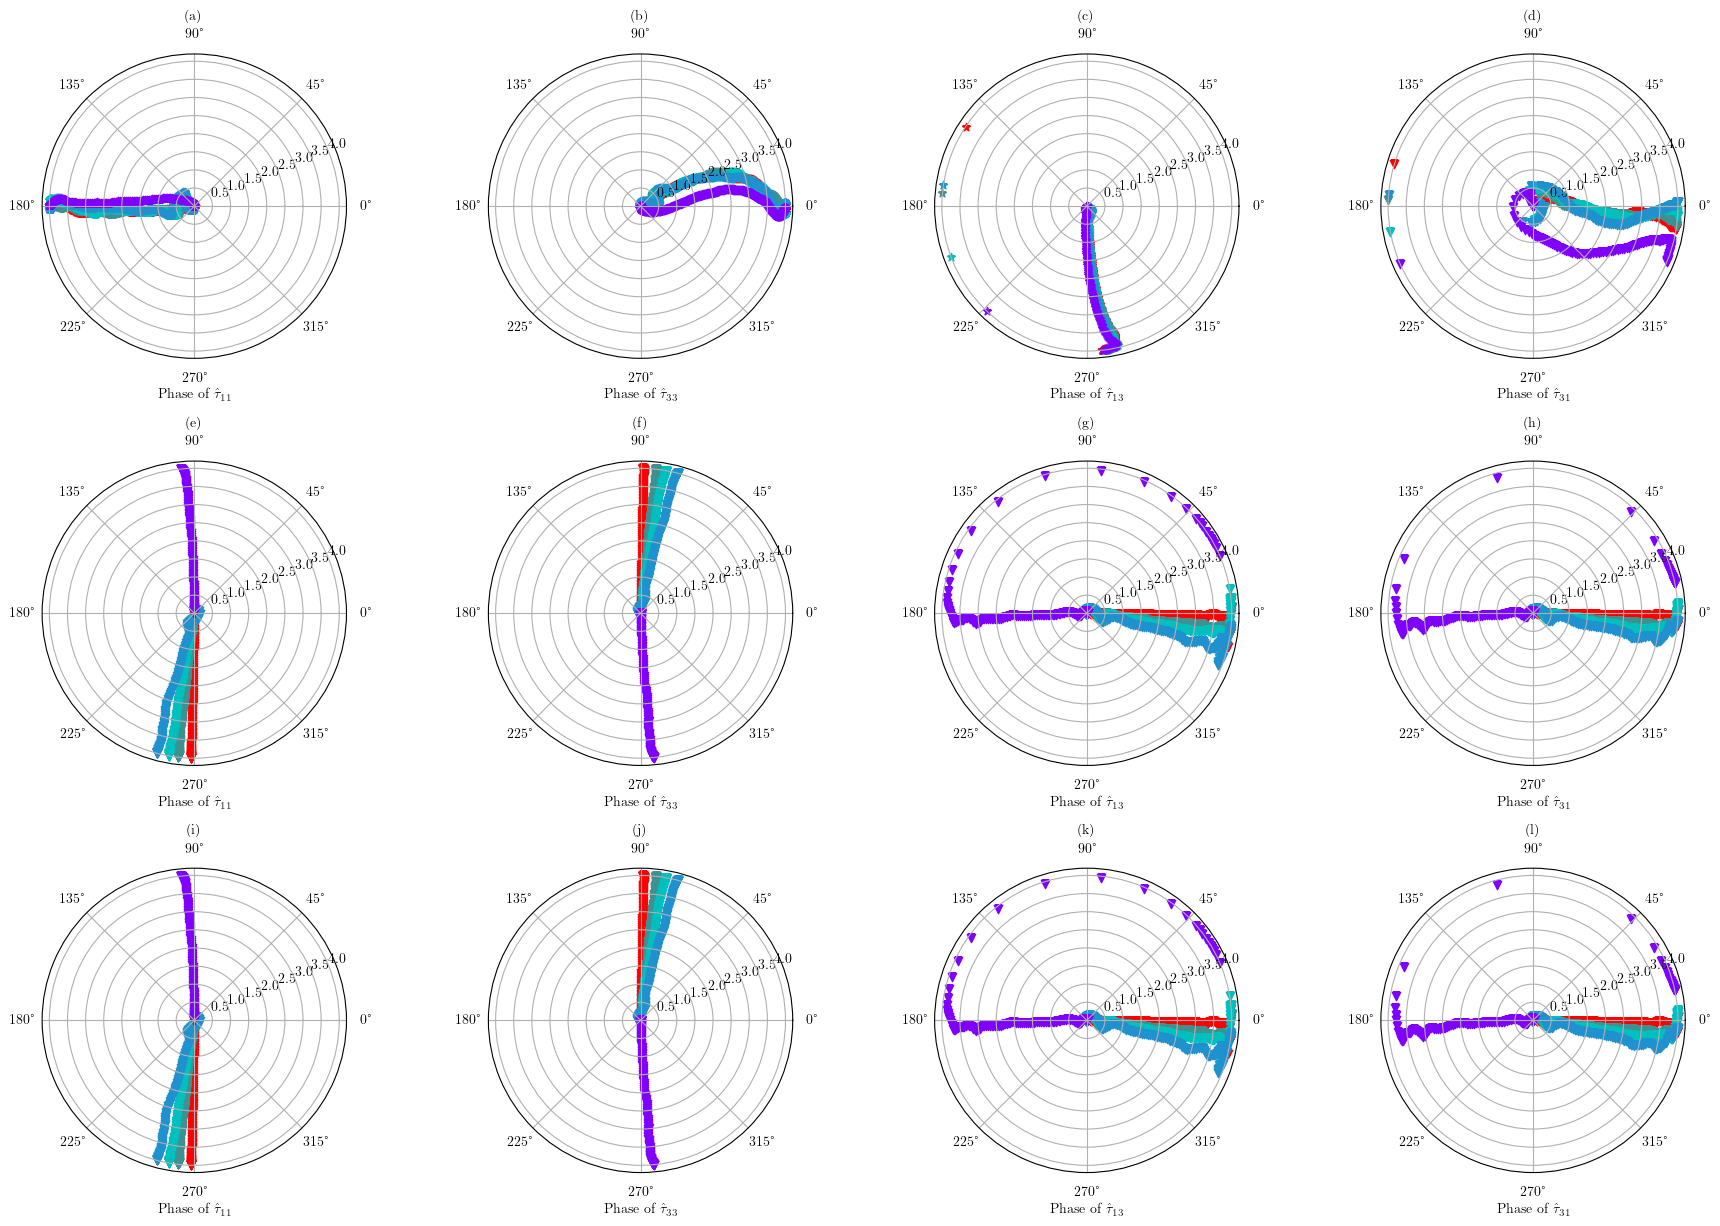

In [640]:
#tau_ij_phase_plot-limited
plt.figure(18,figsize=(18,16))
counter=0
ax1 = plt.subplot(4,4,1,projection='polar')  # Set polar projection
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    #tau11_hat_LES = np.fft.fft(LES_data[n].tau11 + LES_data[n].tau11_SGS, axis=0, norm='forward') 
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d + LES_data[n].tau11_d_SGS, axis=0, norm='forward') 
    
    tau11_hat_phase = np.angle(tau11_hat_LES[16, :])  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data  # Radial coordinate

    plt.scatter(tau11_hat_phase, r_data, color=limited_color_array[counter], marker='p')
    counter=counter+1

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(a)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{11}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,2,projection='polar')  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d + LES_data[n].tau33_d_SGS, axis=0, norm='forward') 
    tau33_hat_phase = np.angle(tau33_hat_LES[16, :])  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data  # Radial coordinate
    plt.scatter(tau33_hat_phase, r_data, color=limited_color_array[counter], marker='o')
    counter=counter+1

    
#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(b)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{33}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,3,projection='polar')  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau13_hat_LES = np.fft.fft(LES_data[n].tau13 + LES_data[n].tau13_SGS, axis=0, norm='forward') 
    tau13_hat_phase = np.angle(tau13_hat_LES[16, :])  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data  # Radial coordinate

    plt.scatter(tau13_hat_phase, r_data, color=limited_color_array[counter], marker='*')
    counter=counter+1


#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(c)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{13}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,4,projection='polar')  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau31_hat_LES = np.fft.fft(LES_data[n].tau31 + LES_data[n].tau31_SGS, axis=0, norm='forward') 
    tau31_hat_phase = np.angle(tau31_hat_LES[16, :])  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data  # Radial coordinate

    plt.scatter(tau31_hat_phase, r_data, color=limited_color_array[counter], marker='v')
    counter=counter+1

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(d)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{31}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)
######################################################################################################################################
ax1 = plt.subplot(4,4,5,projection='polar')  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES 
    tau11_hat_model_phase = np.angle(tau11_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau11_hat_model_phase, r_data, color=limited_color_array[counter], marker='v')
    counter=counter+1


#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(e)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{11}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,6,projection='polar')  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES)
    tau33_hat_model_phase = np.angle(tau33_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau33_hat_model_phase, r_data, color=limited_color_array[counter], marker='v')
    counter=counter+1


#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(f)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{33}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,7,projection='polar')  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) - nuT_linear*U_prime_LES*(1/zi)*(a/2)
    
    tau13_hat_model_phase = np.angle(tau13_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau13_hat_model_phase, r_data, color=limited_color_array[counter], marker='v')
    counter=counter+1


#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(g)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{13}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,8,projection='polar')  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1])
    
    tau31_hat_model_phase = np.angle(tau31_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau31_hat_model_phase, r_data, color=limited_color_array[counter], marker='v')
    counter=counter+1


#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(h)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{31}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)
######################################################################################################################################
ax1 = plt.subplot(4,4,9,projection='polar')  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES 
    tau11_hat_model_phase = np.angle(tau11_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau11_hat_model_phase, r_data, color=limited_color_array[counter], marker='v')
    counter=counter+1


#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(i)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{11}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,10,projection='polar')  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES)
    tau33_hat_model_phase = np.angle(tau33_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau33_hat_model_phase, r_data, color=limited_color_array[counter], marker='v')
    counter=counter+1


#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(j)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{33}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,11,projection='polar')  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) - nuT_linear*U_prime_LES*(1/zi)*(a/2)
    
    tau13_hat_model_phase = np.angle(tau13_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau13_hat_model_phase, r_data, color=limited_color_array[counter], marker='v')
    counter=counter+1


#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(k)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{13}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,12,projection='polar')  # Set polar projection
counter=0
for n in limited_c_array_index:
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1])
    
    tau31_hat_model_phase = np.angle(tau31_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau31_hat_model_phase, r_data, color=limited_color_array[counter], marker='v')
    counter=counter+1


#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(l)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{31}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)
plt.savefig('tau_ij_phase_plot_limited.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

plt.show()

In [ ]:
print(np.angle(tau31_hat_model[10])*180/np.pi, np.degrees(np.arctan2(tau31_hat_model[10].imag, tau31_hat_model[10].real)))

In [ ]:
plt.figure(18,figsize=(18,16))
################################################################################################################
ax1 = plt.subplot(441)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d + LES_data[n].tau11_d_SGS, axis=0, norm='forward')    
    plt.semilogy(np.abs(tau11_hat_LES[16, :]), z_data, color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(a)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{11}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(442)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d + LES_data[n].tau33_d_SGS, axis=0, norm='forward')    
    plt.semilogy(np.abs(tau33_hat_LES[16, :]), z_data, color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(b)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{33}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(443)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau13_hat_LES = np.fft.fft(LES_data[n].tau13 + LES_data[n].tau13_SGS, axis=0, norm='forward')    
    plt.semilogy(np.abs(tau13_hat_LES[16, :]), z_data, color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(c)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{13}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(444)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau31_hat_LES = np.fft.fft(LES_data[n].tau31 + LES_data[n].tau31_SGS, axis=0, norm='forward')    
    plt.semilogy(np.abs(tau31_hat_LES[16, :]), z_data, color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(c)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{31}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

################################################################################################################
ax1 = plt.subplot(4,4,5+4,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d + LES_data[n].tau11_d_SGS, axis=0, norm='forward') 
    tau11_hat_phase = np.angle(tau11_hat_LES[16, :])  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data  # Radial coordinate

    plt.scatter(tau11_hat_phase, r_data, color=color_array[n], marker='p')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(e)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{11}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,6+4,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d + LES_data[n].tau33_d_SGS, axis=0, norm='forward') 
    tau33_hat_phase = np.angle(tau33_hat_LES[16, :])  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data  # Radial coordinate
    plt.scatter(tau33_hat_phase, r_data, color=color_array[n], marker='o')
    
#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(f)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{33}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,7+4,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau13_hat_LES = np.fft.fft(LES_data[n].tau13 + LES_data[n].tau13_SGS, axis=0, norm='forward') 
    tau13_hat_phase = np.angle(tau13_hat_LES[16, :])  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data  # Radial coordinate

    plt.scatter(tau13_hat_phase, r_data, color=color_array[n], marker='*')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(g)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{13}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,8+4,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau31_hat_LES = np.fft.fft(LES_data[n].tau31 + LES_data[n].tau31_SGS, axis=0, norm='forward') 
    tau31_hat_phase = np.angle(tau31_hat_LES[16, :])  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data  # Radial coordinate

    plt.scatter(tau31_hat_phase, r_data, color=color_array[n], marker='v')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(h)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{31}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)
################################################################################################################
ax1 = plt.subplot(4,4,9-4)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES 
    plt.semilogy(np.abs(tau11_hat_model), z_data[0:-1], color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(i)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{11}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,10-4)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES)
 
    plt.semilogy(np.abs(tau33_hat_model), z_data[0:-1], color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(j)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{33}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,11-4)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) - nuT_linear*U_prime_LES*(1/zi)*(a/2)
    
    plt.semilogy(np.abs(tau13_hat_model), z_data[0:-1], color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(k)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{13}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,12-4)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) 
    
    plt.semilogy(np.abs(tau31_hat_model), z_data[0:-1], color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(l)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$|\hat{\tau}_{31}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

################################################################################################################
ax1 = plt.subplot(4,4,13,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES 
    tau11_hat_model_phase = np.angle(tau11_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau11_hat_model_phase, r_data, color=color_array[n], marker='v')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(m)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{11}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,14,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES)
    tau33_hat_model_phase = np.angle(tau33_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau33_hat_model_phase, r_data, color=color_array[n], marker='v')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(n)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{33}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,15,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) - nuT_linear*U_prime_LES*(1/zi)*(a/2)
    
    tau13_hat_model_phase = np.angle(tau13_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau13_hat_model_phase, r_data, color=color_array[n], marker='v')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(o)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{13}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

ax1 = plt.subplot(4,4,16,projection='polar')  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])    
    U_prime_LES = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    nuT_linear   = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1])
    
    tau31_hat_model_phase = np.angle(tau31_hat_model)  # Phase of tau11_hat_LES
    r_data = k_wavno * z_data[0:-1]  # Radial coordinate

    plt.scatter(tau31_hat_model_phase, r_data, color=color_array[n], marker='v')

#ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(p)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'Phase of $\hat{\tau}_{31}$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)

  
   
plt.show()

In [ ]:
plt.figure(18,figsize=(18,16))
ax1 = plt.subplot(441)  # Set polar projection
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    tau11_hat_LES = np.fft.fft(LES_data[n].tau11_d + LES_data[n].tau11_d_SGS, axis=0, norm='forward')  
    tau33_hat_LES = np.fft.fft(LES_data[n].tau33_d + LES_data[n].tau33_d_SGS, axis=0, norm='forward')  
    plt.semilogy(np.abs(np.gradient(tau11_hat_LES[16, :]-tau33_hat_LES[16, :],z_data,edge_order=2)), z_data, color=color_array[n], linestyle='-')
ax1.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax1.set_title('(a)', fontsize=font_size, loc='center')
ax1.set_xlabel(r'$\partial_\zeta|\hat{\tau}_{11}-\hat{\tau}_{33}|$', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.legend(fontsize=font_size, frameon=False)
plt.show()

In [ ]:
plt.figure(18,figsize=(16,12))
z=z_non_uniform
ax1=plt.subplot(341)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U        = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime        = U_prime_spline(z)
    
    U_double_prime_LES    = U_spline.derivative(nu=2)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_double_prime_spline = CubicSpline(z_data[0:-1],U_double_prime_LES)
    U_double_prime        = U_double_prime_spline(z)
    
    U_triple_prime_LES    = U_spline.derivative(nu=3)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_triple_prime_spline = CubicSpline(z_data[0:-1],U_triple_prime_LES)
    U_triple_prime        = U_triple_prime_spline(z)
    
    ax1.semilogy(U,k_wavno*z_non_uniform,color=color_array[n])
    
#ax1.semilogy(U_model,z_non_uniform,color='k',linestyle='--')
#ax1.semilogy(U_model_1,z_non_uniform,color='m',linestyle='--')

ax1.set_ylabel(r'$k\zeta$',fontsize=18)
ax1.set_xlabel(r'$\langle u \rangle$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
#ax1.tick_params(labelsize=18)
#ax1.set_xlim(0.,1.2)
#ax1.set_ylim(0,1)
ax1.tick_params(labelsize=15)
ax1.legend(fontsize=18,frameon=False)

ax1=plt.subplot(342)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U        = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime        = U_prime_spline(z)
    
    U_double_prime_LES    = U_spline.derivative(nu=2)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_double_prime_spline = CubicSpline(z_data[0:-1],U_double_prime_LES)
    U_double_prime        = U_double_prime_spline(z)
    
    U_triple_prime_LES    = U_spline.derivative(nu=3)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_triple_prime_spline = CubicSpline(z_data[0:-1],U_triple_prime_LES)
    U_triple_prime        = U_triple_prime_spline(z)
    
    ax1.semilogy(U_prime,z_non_uniform,color=color_array[n])
    
#ax1.semilogy(dUdz_model,z_non_uniform,'k--')
#ax1.semilogy(dUdz_model_1,z_non_uniform,'m--')

ax1.set_ylabel(r'$\zeta$',fontsize=18)
ax1.set_xlabel(r'$\partial\langle u \rangle/\partial\zeta$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
#ax1.tick_params(labelsize=18)
#ax1.set_xlim(0.,1.2)
#ax1.set_ylim(0,1)
ax1.tick_params(labelsize=15)
ax1.legend(fontsize=18,frameon=False)


ax1=plt.subplot(343)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U        = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime        = U_prime_spline(z)
    
    U_double_prime_LES    = U_spline.derivative(nu=2)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_double_prime_spline = CubicSpline(z_data[0:-1],U_double_prime_LES)
    U_double_prime        = U_double_prime_spline(z)
    
    U_triple_prime_LES    = U_spline.derivative(nu=3)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_triple_prime_spline = CubicSpline(z_data[0:-1],U_triple_prime_LES)
    U_triple_prime        = U_triple_prime_spline(z)

    ax1.semilogy(U_double_prime,z_non_uniform,color=color_array[n])
    
#ax1.semilogy(d2Udz2_model,z_non_uniform,'k--')
#ax1.semilogy(d2Udz2_model_1,z_non_uniform,'c-.')
    
ax1.set_ylabel(r'$\zeta$',fontsize=18)
ax1.set_xlabel(r'$\partial^2\langle u \rangle/\partial\zeta^2$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
ax1.tick_params(labelsize=15)
#ax1.set_xlim(0.,1.2)
#ax1.set_ylim(0,1)
ax1.legend(fontsize=18,frameon=False)

ax1=plt.subplot(344)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U        = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime        = U_prime_spline(z)
    
    U_double_prime_LES    = U_spline.derivative(nu=2)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_double_prime_spline = CubicSpline(z_data[0:-1],U_double_prime_LES)
    U_double_prime        = U_double_prime_spline(z)
    
    U_triple_prime_LES    = U_spline.derivative(nu=3)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_triple_prime_spline = CubicSpline(z_data[0:-1],U_triple_prime_LES)
    U_triple_prime        = U_triple_prime_spline(z)

    ax1.semilogy(U_triple_prime,z_non_uniform,color=color_array[n])
    
ax1.set_xlabel(r'$\partial^3\langle u\rangle/\partial\zeta^3$',fontsize=18)
ax1.set_ylabel(r'$\zeta$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
ax1.tick_params(labelsize=15)
#ax1.set_xlim(0.,1.2)
#ax1.set_ylim(0,1)
ax1.legend(fontsize=18,frameon=False)


ax1=plt.subplot(345)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U        = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime        = U_prime_spline(z)
    

    nuT_LES    = -(LES_data[n].tau13_mean[0:-1]+LES_data[n].tau13_SGS_mean[0:-1])/U_prime_LES
    nuT_spline = CubicSpline(z_data[0:-1],nuT_LES)
    nuT        = nuT_spline(z)
    
    nuT_prime  = nuT_spline.derivative()(z)
    nuT_double_prime  = nuT_spline.derivative(nu=2)(z)
  
    ax1.plot(nu+nuT,z,color=color_array[n])
    ax1.plot(nu+ ustar**2*kappa**2*z**2*U_prime,z,color=color_array[n],linestyle='--')
    #ax1.loglog((LES_data[n].tau13[0:-1]+LES_data[n].tau13_wave[0:-1]+LES_data[n].tau13_SGS[0:-1])/dUdz_LES,z_data[0:-1],color=color_array[n])
    
    #ax1.loglog((1-z_non_uniform)/dUdz_LES,z_non_uniform,color=color_array[n])
#ax1.loglog(nu*0+nuT_Cess,z_non_uniform,color='k',linestyle='--')
#ax1.loglog(nu_1*0+nuT_Cess_1,z_non_uniform,color='m',linestyle='--')

ax1.set_xlabel(r'$\nu+\nu_{T}$',fontsize=18)
ax1.set_ylabel(r'$\zeta$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
#ax1.tick_params(labelsize=18)
#ax1.set_xlim(0.,2*np.pi)
#ax1.set_ylim(0,1)
ax1.tick_params(labelsize=15)
ax1.legend(fontsize=18,frameon=False)


ax1=plt.subplot(346)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U        = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime        = U_prime_spline(z)
    

    nuT_LES    = -(LES_data[n].tau13_mean[0:-1]+LES_data[n].tau13_SGS_mean[0:-1])/U_prime_LES
    
    nuT_spline = CubicSpline(z_data[0:-1],nuT_LES)
    nuT        = nuT_spline(z)
    
    nuT_prime  = nuT_spline.derivative(nu=1)(z)
    nuT_double_prime  = nuT_spline.derivative(nu=2)(z)
  
    ax1.semilogy(nuT_prime[0:-1000],k_wavno*z[0:-1000],color=color_array[n])
    
    
#ax1.loglog((LES_data[n].tau13[0:-1]+LES_data[n].tau13_wave[0:-1]+LES_data[n].tau13_SGS[0:-1])/dUdz_LES,z_data[0:-1],color=color_array[n])
#ax1.loglog((1-z_non_uniform)/dUdz_LES,z_non_uniform,color=color_array[n])
#ax1.loglog(nu*0+nuT_Cess,z_non_uniform,color='k',linestyle='--')
#ax1.loglog(nu_1*0+nuT_Cess_1,z_non_uniform,color='m',linestyle='--')

ax1.set_xlabel(r'$\nu_T^{\prime}$',fontsize=18)
ax1.set_ylabel(r'$k\zeta$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
#ax1.tick_params(labelsize=18)
#ax1.set_xlim(0.,2*np.pi)
#ax1.set_ylim(0,1)
ax1.tick_params(labelsize=15)
ax1.legend(fontsize=18,frameon=False)


ax1=plt.subplot(347)
for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U        = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime        = U_prime_spline(z)
   

    nuT_LES    = -(LES_data[n].tau13_mean[0:-1]+LES_data[n].tau13_SGS_mean[0:-1])/U_prime_LES
    
    nuT_spline = CubicSpline(z_data[0:-1],nuT_LES)
    nuT        = nuT_spline(z)
    
    nuT_prime  = nuT_spline.derivative(nu=1)(z)
    nuT_double_prime  = nuT_spline.derivative(nu=2)(z)
  
    ax1.semilogy(nuT_double_prime[0:-500],k_wavno*z[0:-500],color=color_array[n])
    
    #ax1.loglog((LES_data[n].tau13[0:-1]+LES_data[n].tau13_wave[0:-1]+LES_data[n].tau13_SGS[0:-1])/dUdz_LES,z_data[0:-1],color=color_array[n])
    
    #ax1.loglog((1-z_non_uniform)/dUdz_LES,z_non_uniform,color=color_array[n])
#ax1.loglog(nu*0+nuT_Cess,z_non_uniform,color='k',linestyle='--')
#ax1.loglog(nu_1*0+nuT_Cess_1,z_non_uniform,color='m',linestyle='--')

ax1.set_xlabel(r'$\nu_T^{\prime\prime}$',fontsize=18)
ax1.set_ylabel(r'$\zeta$',fontsize=18)
#ax1.set_xticks([0,.5,1.0])
#ax1.set_yticks([0.5,1])
#ax1.tick_params(labelsize=18)
#ax1.set_xlim(0.,2*np.pi)
#ax1.set_ylim(0,1)
ax1.tick_params(labelsize=15)
ax1.legend(fontsize=18,frameon=False)


ax1=plt.subplot(348)
for num_data_select in range(num_data-1):
    plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*1+LES_data[num_data_select].taup_13_mean*1+LES_data[num_data_select].tau13_mean*1+LES_data[num_data_select].tau13_wave_mean*1+1*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color=color_array[num_data_select],linestyle='-')
    plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*0+LES_data[num_data_select].taup_13_mean*0+LES_data[num_data_select].tau13_mean*1+LES_data[num_data_select].tau13_wave_mean*1+1*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color=color_array[num_data_select],linestyle='--')
    plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*1+LES_data[num_data_select].taup_13_mean*1+LES_data[num_data_select].tau13_mean*0+LES_data[num_data_select].tau13_wave_mean*0+0*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color=color_array[num_data_select],linestyle='-.')
ax1.set_xlabel(r'$\tau(\zeta)$',fontsize=15)
ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
ax1.set_ylabel(r'$k\zeta$',fontsize=15)
ax1.tick_params(labelsize=15)

#plt.savefig('vel_nuT_LES.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)
plt.show()

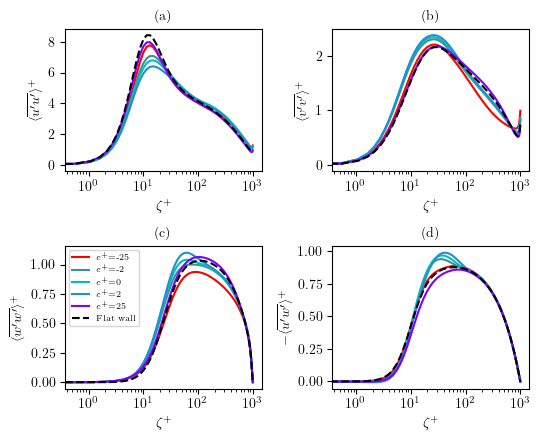

In [659]:
plt.figure(18,figsize=(5.5,4.5))
font_size=10
ax1=plt.subplot(2,2,1)
for num_data_select in [0,3,4,5,8,9]:
    upup = LES_data[num_data_select].upup_phase_avg 
    upup_mean = np.mean(upup,axis=0)
    if num_data_select<9:
        plt.semilogx(LES_data[num_data_select].zw*Retau,upup_mean,color=color_array[num_data_select])
    else:
        plt.semilogx(LES_data[num_data_select].zw*Retau,upup_mean,'k',linestyle='--')
ax1.tick_params(labelsize=font_size)
ax1.set_title('(a)',fontsize=font_size)
plt.xlabel(r'$\zeta^+$',fontsize=font_size)
plt.ylabel(r'$\langle \overline{u^\prime u^\prime} \rangle^+$',fontsize=font_size)


ax1=plt.subplot(2,2,2)
for num_data_select in [0,3,4,5,8,9]:
    vpvp = LES_data[num_data_select].vpvp_phase_avg 
    vpvp_mean = np.mean(vpvp,axis=0)
    if num_data_select<9:
        plt.semilogx(LES_data[num_data_select].zw*Retau,vpvp_mean,color=color_array[num_data_select])
    else:
        plt.semilogx(LES_data[num_data_select].zw*Retau,vpvp_mean,'k',linestyle='--')
ax1.tick_params(labelsize=font_size)
ax1.set_title('(b)',fontsize=font_size)
plt.xlabel(r'$\zeta^+$',fontsize=font_size)
plt.ylabel(r'$\langle \overline{v^\prime v^\prime} \rangle^+$',fontsize=font_size)

ax1=plt.subplot(2,2,3)
for num_data_select in [0,3,4,5,8,9]:
    wpwp = LES_data[num_data_select].wpwp_phase_avg 
    wpwp_mean = np.mean(wpwp,axis=0)
    if num_data_select<9:
        plt.semilogx(LES_data[num_data_select].zw*Retau,wpwp_mean,color=color_array[num_data_select],label=f'$c^+$={c_array[num_data_select]}')
    else:
        plt.semilogx(LES_data[num_data_select].zw*Retau,wpwp_mean,'k',linestyle='--',label='Flat wall')
plt.legend(fontsize=6)
ax1.tick_params(labelsize=font_size)
ax1.set_title('(c)',fontsize=font_size)
plt.xlabel(r'$\zeta^+$',fontsize=font_size)
plt.ylabel(r'$\langle \overline{w^\prime w^\prime} \rangle^+$',fontsize=font_size)


ax1=plt.subplot(2,2,4)
for num_data_select in [0,3,4,5,8,9]:
    upwp = LES_data[num_data_select].upwp_phase_avg 
    upwp_mean = np.mean(upwp,axis=0)
    if num_data_select<9:
        plt.semilogx(LES_data[num_data_select].zw*Retau,-upwp_mean,color=color_array[num_data_select])
    else:
        plt.semilogx(LES_data[num_data_select].zw*Retau,-upwp_mean,'k',linestyle='--')
#plt.semilogx(LES_data[num_data_select].zw*Retau,(1-LES_data[num_data_select].zw)*(1-np.exp(-LES_data[num_data_select].zw*Retau/25)),'m')
ax1.tick_params(labelsize=font_size)
ax1.set_title('(d)',fontsize=font_size)
plt.xlabel(r'$\zeta^+$',fontsize=font_size)
plt.ylabel(r'$-\langle \overline{u^\prime w^\prime} \rangle^+$',fontsize=font_size)

plt.savefig('mean_stress_profiles.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()

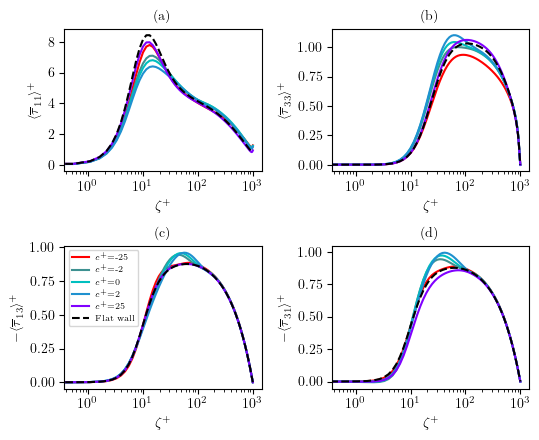

In [660]:
plt.figure(18,figsize=(5.5,4.5))
font_size=10
ax1=plt.subplot(2,2,1)
for num_data_select in [0,3,4,5,8,9]:
    upup = LES_data[num_data_select].uU_phase_avg - LES_data[num_data_select].u_w_phase_avg*LES_data[num_data_select].U_phase_avg
    upup_mean = np.mean(upup,axis=0)
    if num_data_select<9:
        plt.semilogx(LES_data[num_data_select].zw*Retau,upup_mean,color=color_array[num_data_select])
    else:
        plt.semilogx(LES_data[num_data_select].zw*Retau,upup_mean,'k',linestyle='--')
ax1.tick_params(labelsize=font_size)
ax1.set_title('(a)',fontsize=font_size)
plt.xlabel(r'$\zeta^+$',fontsize=font_size)
plt.ylabel(r'$\langle \overline{\tau}_{11} \rangle^+$',fontsize=font_size)


ax1=plt.subplot(2,2,2)
for num_data_select in [0,3,4,5,8,9]:
    vpvp = LES_data[num_data_select].wW_phase_avg - LES_data[num_data_select].w_phase_avg*LES_data[num_data_select].W_phase_avg
    vpvp_mean = np.mean(vpvp,axis=0)
    if num_data_select<9:
        plt.semilogx(LES_data[num_data_select].zw*Retau,vpvp_mean,color=color_array[num_data_select])
    else:
        plt.semilogx(LES_data[num_data_select].zw*Retau,vpvp_mean,'k',linestyle='--')
ax1.tick_params(labelsize=font_size)
ax1.set_title('(b)',fontsize=font_size)
plt.xlabel(r'$\zeta^+$',fontsize=font_size)
plt.ylabel(r'$\langle \overline{\tau}_{33} \rangle^+$',fontsize=font_size)

ax1=plt.subplot(2,2,3)
for num_data_select in [0,3,4,5,8,9]:
    wpwp = LES_data[num_data_select].uW_phase_avg - LES_data[num_data_select].u_w_phase_avg*LES_data[num_data_select].W_phase_avg
    wpwp_mean = np.mean(wpwp,axis=0)
    if num_data_select<9:
        plt.semilogx(LES_data[num_data_select].zw*Retau,-wpwp_mean,color=color_array[num_data_select],label=f'$c^+$={c_array[num_data_select]}')
    else:
        plt.semilogx(LES_data[num_data_select].zw*Retau,-wpwp_mean,'k',linestyle='--',label='Flat wall')
plt.legend(fontsize=6)
ax1.tick_params(labelsize=font_size)
ax1.set_title('(c)',fontsize=font_size)
plt.xlabel(r'$\zeta^+$',fontsize=font_size)
plt.ylabel(r'$-\langle \overline{\tau}_{13} \rangle^+$',fontsize=font_size)


ax1=plt.subplot(2,2,4)
for num_data_select in [0,3,4,5,8,9]:
    upwp = LES_data[num_data_select].wU_phase_avg - LES_data[num_data_select].w_phase_avg*LES_data[num_data_select].U_phase_avg
    upwp_mean = np.mean(upwp,axis=0)
    if num_data_select<9:
        plt.semilogx(LES_data[num_data_select].zw*Retau,-upwp_mean,color=color_array[num_data_select])
    else:
        plt.semilogx(LES_data[num_data_select].zw*Retau,-upwp_mean,'k',linestyle='--')
#plt.semilogx(LES_data[num_data_select].zw*Retau,(1-LES_data[num_data_select].zw)*(1-np.exp(-LES_data[num_data_select].zw*Retau/25)),'m')
ax1.tick_params(labelsize=font_size)
ax1.set_title('(d)',fontsize=font_size)
plt.xlabel(r'$\zeta^+$',fontsize=font_size)
plt.ylabel(r'$-\langle \overline{\tau}_{31} \rangle^+$',fontsize=font_size)

plt.savefig('mean_stress_profiles_curv_coord.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()

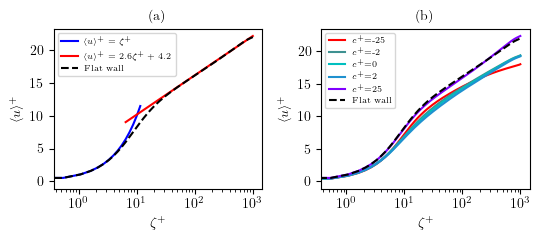

In [638]:
plt.figure(18,figsize=(5.5,2.5))
font_size=10
ax1=plt.subplot(1,2,1)
plt.semilogx(LES_data[num_data_select].zw[0:15]*Retau,LES_data[num_data_select].zw[0:15]*Retau,'b',linestyle='-',label=r'$\langle u\rangle^+=\zeta^+$')
plt.semilogx(LES_data[num_data_select].zw[10:]*Retau,2.6*np.log(LES_data[num_data_select].zw[10:]*Retau)+4.2,'r',linestyle='-',label=r'$\langle u\rangle^+=2.6\zeta^+ + 4.2$')
plt.semilogx(LES_data[num_data_select].zw*Retau,LES_data[9].u_mean,'k',linestyle='--',label='Flat wall')

plt.legend(fontsize=6)
ax1.set_title('(a)',fontsize=font_size)
plt.xlabel(r'$\zeta^+$',fontsize=font_size)
plt.ylabel(r'$\langle u \rangle^+$',fontsize=font_size)

ax1=plt.subplot(1,2,2)
for num_data_select in [0,3,4,5,8,9]:
    upup = LES_data[num_data_select].upup_phase_avg 
    upup_mean = np.mean(upup,axis=0)
    if num_data_select<9:
       plt.semilogx(LES_data[num_data_select].zw*Retau,LES_data[num_data_select].u_mean,color=color_array[num_data_select],label=f'$c^+$={c_array[num_data_select]}')

    else:
       plt.semilogx(LES_data[num_data_select].zw*Retau,LES_data[9].u_mean,'k',linestyle='--',label='Flat wall')
plt.legend(fontsize=6)
ax1.tick_params(labelsize=font_size)
ax1.set_title('(b)',fontsize=font_size)
plt.xlabel(r'$\zeta^+$',fontsize=font_size)
plt.ylabel(r'$\langle u \rangle^+$',fontsize=font_size)

plt.savefig('mean_velocity_profiles.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()

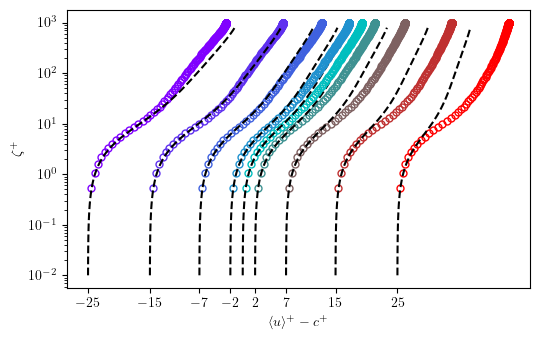

In [806]:
from  scipy import integrate 
plt.figure(18,figsize=(5.5,6.5-3))
font_size=10


for num_data_select in range(9):
    #ax1=plt.subplot(3,3,num_data_select+1)
    z_data = LES_data[num_data_select].zw.flatten()
    upup   = LES_data[num_data_select].upup_phase_avg 
    upup_mean = np.mean(upup,axis=0)
    z_array = np.logspace(-5,0,100)
    nuT_model = nu + c1_fit_const[num_data_select]*(1-z_array)**0.8*0.41*z_array*(1-np.exp(-z_array*1000/25))

    taup13_spline     = CubicSpline(z_data[0:-1],LES_data[num_data_select].taup_13_mean[0:-1])
    tau13_wave_spline = CubicSpline(z_data[0:-1],LES_data[num_data_select].tau13_wave_mean[0:-1])
    
    #U_model = integrate.cumulative_trapezoid(((1-z_array)**1.0+taup13_mean_surf[num_data_select]*(1-np.tanh((k_wavno*z_array/inner_layer_depth[num_data_select])**2))-0*taup13_mean_surf[num_data_select]*np.exp(-k_wavno*z_array))/nuT_model,z_array)
    U_model = integrate.cumulative_trapezoid(((1-z_array)**1.0+taup13_mean_surf[num_data_select]*np.exp(-k_wavno*z_array))/nuT_model,z_array)
    
    #U_model = integrate.cumulative_trapezoid(((1-z_array)**1.0-1*(taup13_spline(z_array)+0*tau13_wave_spline(z_array)))/nuT_model,z_array)
    if num_data_select < 4:
        U_model_2 = integrate.cumulative_trapezoid(((1-z_array)**1.0-1*(taup13_spline(z_array)+0*tau13_wave_spline(z_array)))/nuT_model,z_array)
    else:
        U_model_2 = integrate.cumulative_trapezoid(((1-z_array)**1.0+1*(taup13_spline(z_array)+0*tau13_wave_spline(z_array)))/nuT_model,z_array)
    
    
    if num_data_select<9:
       plt.semilogy(LES_data[num_data_select].u_mean[0:-1:1]-c_array[num_data_select],LES_data[num_data_select].zw[0:-1:1]*Retau,color=color_array[num_data_select],label=f'$c^+$={c_array[num_data_select]}',marker='o',markerfacecolor='none',markersize=5,linestyle='none')
       plt.semilogy(U_model[0:-1]-c_array[num_data_select],z_array[0:-2]*Retau,'k',linestyle='--')
       #plt.semilogy(U_model_2[0:-1]-c_array[num_data_select],z_array[0:-2]*Retau,'k',linestyle='-.')
    else:
       plt.semilogy(LES_data[9].u_mean,LES_data[num_data_select].zw*Retau,'k',linestyle='--',label='Flat wall')
    #plt.legend(fontsize=6)
    plt.xticks([-25,-15,-7,-2,2,7,15,25])
    ax1.tick_params(labelsize=font_size)
    ax1.set_title('(b)',fontsize=font_size)
    plt.ylabel(r'$\zeta^+$',fontsize=font_size)
    plt.xlabel(r'$\langle u \rangle^+-c^+$',fontsize=font_size)

#plt.savefig('mean_velocity_profiles.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)
plt.show()

((99,), (100,))

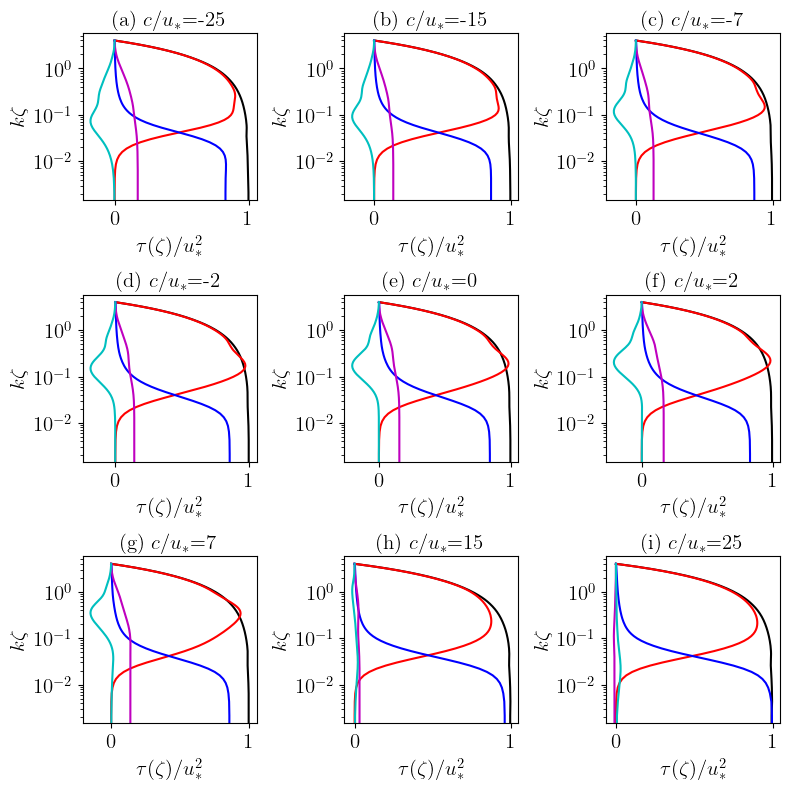

In [755]:
plt.figure(18,figsize=(8,8))
for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*1+LES_data[num_data_select].taup_13_mean*1+LES_data[num_data_select].tau13_mean*1+LES_data[num_data_select].tau13_wave_mean*1+1*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color='k',linestyle='-')#tau_tot
    plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*0+LES_data[num_data_select].taup_13_mean*0+LES_data[num_data_select].tau13_mean*1+LES_data[num_data_select].tau13_wave_mean*0+1*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color='r',linestyle='-')#tau_turb
    plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*1+LES_data[num_data_select].taup_13_mean*0+LES_data[num_data_select].tau13_mean*0+LES_data[num_data_select].tau13_wave_mean*0+0*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color='b',linestyle='-')#tau_visc
    plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*0+LES_data[num_data_select].taup_13_mean*1+LES_data[num_data_select].tau13_mean*0+LES_data[num_data_select].tau13_wave_mean*0+0*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color='m',linestyle='-')#tau_p
    plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*0+LES_data[num_data_select].taup_13_mean*0+LES_data[num_data_select].tau13_mean*0+LES_data[num_data_select].tau13_wave_mean*1+0*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color='c',linestyle='-')#tau_wave
    #plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*0+LES_data[num_data_select].taup_13_mean*1+LES_data[num_data_select].tau13_mean*0+LES_data[num_data_select].tau13_wave_mean*1+0*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color='c',linestyle='--')#tau_wave
    
    ax1.set_xlabel(r'$\tau(\zeta)/u_*^2$',fontsize=15)
    ax1.set_title(f'({chr(97 + num_data_select)}) $c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
plt.savefig('stress_balance.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()

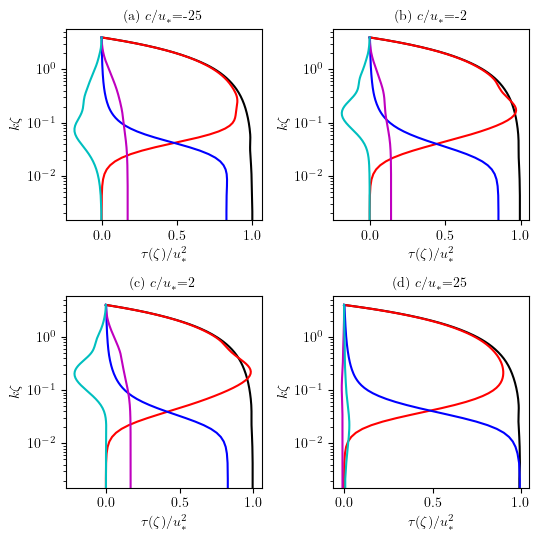

In [743]:
plt.figure(18,figsize=(5.5,5.5))
counter=1
font_size=10
for num_data_select in [0,3,5,8]:
    ax1=plt.subplot(2,2,counter)
    plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*1+LES_data[num_data_select].taup_13_mean*1+LES_data[num_data_select].tau13_mean*1+LES_data[num_data_select].tau13_wave_mean*1+1*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color='k',linestyle='-')#tau_tot
    plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*0+LES_data[num_data_select].taup_13_mean*0+LES_data[num_data_select].tau13_mean*1+LES_data[num_data_select].tau13_wave_mean*0+1*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color='r',linestyle='-')#tau_turb
    plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*1+LES_data[num_data_select].taup_13_mean*0+LES_data[num_data_select].tau13_mean*0+LES_data[num_data_select].tau13_wave_mean*0+0*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color='b',linestyle='-')#tau_visc
    plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*0+LES_data[num_data_select].taup_13_mean*1+LES_data[num_data_select].tau13_mean*0+LES_data[num_data_select].tau13_wave_mean*0+0*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color='m',linestyle='-')#tau_p
    plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*0+LES_data[num_data_select].taup_13_mean*0+LES_data[num_data_select].tau13_mean*0+LES_data[num_data_select].tau13_wave_mean*1+0*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color='c',linestyle='-')#tau_wave
    #plt.semilogy(-(LES_data[num_data_select].tau13_nu_mean*0+LES_data[num_data_select].taup_13_mean*1+LES_data[num_data_select].tau13_mean*0+LES_data[num_data_select].tau13_wave_mean*1+0*LES_data[num_data_select].tau13_SGS_mean),k_wavno*LES_data[num_data_select].zw,color='c',linestyle='--')#tau_wave
    
    ax1.set_xlabel(r'$\tau(\zeta)/u_*^2$',fontsize=font_size)
    ax1.set_title(f'({chr(97 + counter-1)}) $c/u_*$={c_array[num_data_select]}', fontsize=font_size)
    ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    ax1.tick_params(labelsize=font_size)
    counter+=1
plt.savefig('stress_balance_2x2.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()

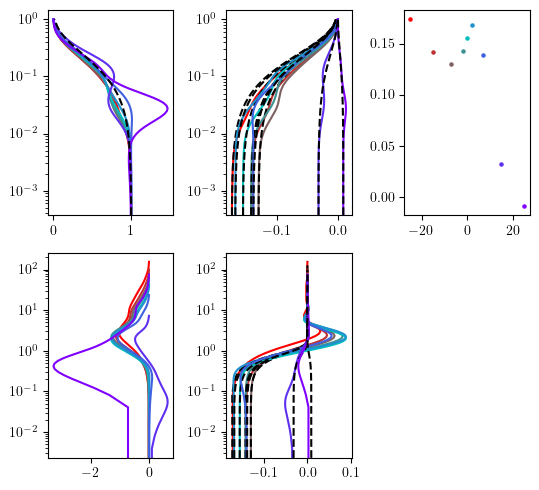

In [761]:
plt.figure(18,figsize=(5.5,5))
taup13_mean_surf=np.zeros((9,),dtype=float)
ax1=plt.subplot(2,3,1)
for num_data_select in range(9):
   taup13_mean_surf[num_data_select] = LES_data[num_data_select].taup_13_mean[0]
   plt.semilogy(LES_data[num_data_select].taup_13_mean/LES_data[num_data_select].taup_13_mean[0],LES_data[num_data_select].zw.flatten(),color=color_array[num_data_select])
plt.semilogy(np.exp(-k_wavno*LES_data[num_data_select].zw.flatten()),LES_data[num_data_select].zw.flatten(),'k',linestyle='--')

ax1=plt.subplot(2,3,2)
for num_data_select in range(9):
   plt.semilogy(LES_data[num_data_select].taup_13_mean,LES_data[num_data_select].zw.flatten(),color=color_array[num_data_select])
   plt.semilogy(LES_data[num_data_select].taup_13_mean[0]*np.exp(-k_wavno*LES_data[num_data_select].zw.flatten()),LES_data[num_data_select].zw.flatten(),'k',linestyle='--')

ax1=plt.subplot(2,3,3)
for num_data_select in range(9):
    plt.scatter(c_array[num_data_select],-taup13_mean_surf[num_data_select],color=color_array[num_data_select],marker='o',s=5)

ax1=plt.subplot(2,3,4)
for num_data_select in range(9):
   plt.semilogy((LES_data[num_data_select].tau13_wave_mean+0*LES_data[num_data_select].taup_13_mean)/taup13_mean_surf[num_data_select],k_wavno*LES_data[num_data_select].zw.flatten()/inner_layer_depth[num_data_select]**1,color=color_array[num_data_select])

#plt.semilogy(1-np.tanh((k_wavno*LES_data[num_data_select].zw.flatten()/inner_layer_depth[num_data_select])**2),k_wavno*LES_data[num_data_select].zw.flatten()/inner_layer_depth[num_data_select],'k',linestyle='--')


ax1=plt.subplot(2,3,5)
for num_data_select in range(9):
   plt.semilogy((LES_data[num_data_select].tau13_wave_mean+LES_data[num_data_select].taup_13_mean)/taup13_mean_surf[num_data_select]**0,k_wavno*LES_data[num_data_select].zw.flatten()/inner_layer_depth[num_data_select]**1,color=color_array[num_data_select])
   plt.semilogy(taup13_mean_surf[num_data_select]*(1-np.tanh((k_wavno*LES_data[num_data_select].zw.flatten()/inner_layer_depth[num_data_select])**2)),k_wavno*LES_data[num_data_select].zw.flatten()/inner_layer_depth[num_data_select],'k',linestyle='--')


plt.show()

\begin{align}
    &-\Biggl[\mathrm{i}k\frac{\partial^2 \langle{u}\rangle}{\partial \zeta^2}-(\langle{u}\rangle-c)\mathrm{i}k\nabla^2
    +(\nu+\nu_T)\nabla^4+2\dfrac{\partial\nu_T}{\partial \zeta}\nabla^2D
    +\dfrac{\partial^2\nu_T}{\partial\zeta^2}\left(D^2+k^2\right)\Biggr]\dfrac{\hat{w}}{\mathrm{i}k}
     \nonumber \\
    &\mspace{20mu}=\hat{\eta}(\nu+\nu_T)\frac{\partial^2}{\partial\zeta^2}\left[g\frac{\partial^2\langle{u}\rangle}{\partial\zeta^2}\right]+\frac{\partial\nu_T}{\partial\zeta}\left(2\frac{\partial^2}{\partial\zeta^2}-k^2\right)g\hat{\eta}\frac{\partial \langle{u}\rangle}{\partial \zeta}+\frac{\partial^2\nu_T}{\partial\zeta^2}g\hat{\eta}\frac{\partial^2 \langle{u}\rangle}{\partial \zeta^2}, \\
    &\nabla^2=D^2-k^2, \ D=\partial/\partial\zeta.
\end{align}
\begin{align*}
\zeta=\frac{z-\eta}{H-\eta}
\end{align*}

Boundary conditions:

\begin{align*}
\eta(x,t)&=a\cos[k(x-ct)],\\
u_s(x,t)&=akc\cos[k(x-ct)],\\
w_s(x,t)&=akc\sin[k(x-ct)],\\
v_s(x,t)&=0.
\end{align*}

Phase-averaged boudnary conditions are:
\begin{align*}
\overline{\eta}=\widetilde{\eta}&=a\cos kx,\\
\overline{u}_s=\widetilde{u}_s&=akc\cos kx,\\
\overline{w}_s=\widetilde{w}_s&=akc\sin kx,\\
\overline{v}_s=\widetilde{v}_s&=0
\end{align*}

Pressure perturbation:


\begin{align*}
    \Re[\hat{p}]|_{\zeta}&= \int_{\zeta}^{\lambda}-(\langle{u}\rangle-c)k\text{Im}[\hat{w}]d\zeta- \int_{\zeta}^{\lambda}\nu_T\left(D^2-k^2\right)\text{Re}[\hat{w}]d\zeta\\
    &\mspace{20mu}- \int_{\zeta}^{\lambda}\frac{\partial\nu_T}{\partial\zeta}\left(2\frac{\partial\text{Re}[\hat{w}]}{\partial\zeta}-gk\Im[\hat{\eta}]\frac{\partial\langle{u}\rangle}{\partial\zeta}\right)d\zeta,\\
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    \Im[\hat{p}]|_{\zeta}&= \int_{\zeta}^{\lambda}(\langle{u}\rangle-c)k\text{Re}[\hat{w}]d\zeta-\int_{\zeta}^{\lambda}\nu_T\left(D^2-k^2\right)\text{Im}[\hat{w}]d\zeta\\
    &\mspace{20mu}-\int_{\zeta}^{\lambda}\frac{\partial\nu_T}{\partial\zeta}\left(2\frac{\partial\text{Im}[\hat{w}]}{\partial\zeta}+gk\Re[\hat{\eta}]\frac{\partial\langle{u}\rangle}{\partial\zeta}\right)d\zeta,\\
    \tilde{p}|_\zeta&=2\text{Re}[\hat{p}]|_\zeta\cos k\xi-2\text{Im}[\hat{p}]|_\zeta\sin k\xi
\end{align*}

Form drag:

\begin{align*}
F_p=\frac{1}{\lambda}\int_{0}^{\lambda}\frac{\widetilde{p}}{\rho_a u_\tau^2}\frac{d\widetilde{\eta}}{dx} \ dx
\end{align*}



\begin{align*}
\tilde{\tau}^\prime_{31}&=\tilde{\tau}_{31}-\frac{1}{3}\delta_{31}\tilde{\tau}_{kk}=-\nu_T\left(\frac{\partial\tilde{u}}{\partial\zeta}+\frac{\partial\tilde{w}}{\partial\xi}\right),\\
    \tilde{\tau}^\prime_{33}&=\tilde{\tau}_{33}-\frac{1}{3}\delta_{33}\tilde{\tau}_{kk}=\nu_T\left(\frac{\partial\tilde{u}}{\partial\xi}-\frac{\partial\tilde{w}}{\partial\zeta}\right)
\end{align*}

\begin{align*}
    \tilde{\tau}^{\prime}_{11}&=\tilde{\tau}_{11}-\frac{1}{3}\delta_{11}\tilde{\tau}_{kk}=2\nu_T\frac{\partial\tilde{w}}{\partial\zeta},\\
    \tilde{\tau}^{\prime}_{13}&=\tilde{\tau}_{13}-\frac{1}{3}\delta_{13}\tilde{\tau}_{kk}=-\nu_T\left(\frac{\partial\tilde{u}}{\partial\zeta}+\frac{\partial\tilde{w}}{\partial\xi}\right)-{\nu_T\frac{\partial\langle{u}\rangle}{\partial\zeta}g_\zeta\tilde{\eta}}.
\end{align*}

\begin{align*}
\left[(\langle{u\rangle}-c)\left(\frac{\partial^2}{\partial\zeta^2}-k^2\right)-\frac{\partial^2\langle{u\rangle}}{\partial\zeta^2}\right]\hat{w}&=\mathrm{i}k\frac{\partial}{\partial\zeta}(\hat{\tau}^{\nu}_{11}+\hat{\tau}^{w}_{11}+\hat{\tau}_{11})+\frac{\partial^2}{\partial \zeta^2}(\hat{\tau}^{\nu}_{13}+\hat{\tau}^{w}_{13}+\hat{\tau}_{13}),\\
    &\mspace{20mu}+k^2(\hat{\tau}^{\nu}_{31}+\hat{\tau}^{w}_{31}+\hat{\tau}_{31})-\mathrm{i}k\frac{\partial}{\partial \zeta}(\hat{\tau}^{\nu}_{33}+\hat{\tau}^{w}_{33}+\hat{\tau}_{33}).
\end{align*}


\begin{align*}
\hat{\tau}^\nu_{11}&=-2\nu\frac{\partial \hat{w}}{\partial\zeta},\\
\hat{\tau}^\nu_{33}&=\nu\left(\mathrm{i}k\hat{u}-\frac{\partial\hat{w}}{\partial\zeta}\right),\\
\hat{\tau}^\nu_{13}&=\nu\left(\frac{\partial\hat{u}}{\partial\zeta}+\mathrm{i}k\hat{w}\right)+\nu\frac{\partial\langle u\rangle}{\partial\zeta}g_\zeta \hat{\eta},\\
\hat{\tau}^\nu_{31}&=\nu\left(\frac{\partial\hat{u}}{\partial\zeta}+\mathrm{i}k\hat{w}\right)
\end{align*}

In [ ]:
#Visualize tau_ij and nu_T
num_data_select=0
tau31_wave_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau13_wave_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau11_d_wave_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau33_d_wave_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)

tau31_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,3),dtype=complex)
tau13_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,3),dtype=complex)
tau11_d_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,3),dtype=complex)
tau33_d_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,3),dtype=complex)

tau31_nu_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau13_nu_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau11_d_nu_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau33_d_nu_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)

tau31_SGS_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau13_SGS_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau11_d_SGS_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)
tau33_d_SGS_hat=np.zeros((LES_data[num_data_select].zw.size-1,num_data,2),dtype=complex)

nuT_LES=np.zeros((LES_data[num_data_select].zw.size-1,num_data,7),dtype=complex)
plt.figure(11,figsize=(12,24))
for num_data_select in range(num_data-1):
    z_data = np.asarray(LES_data[num_data_select].zw).flatten()
    U_data = np.asarray(LES_data[num_data_select].U_mean).flatten()
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    # U_visc = U_spline(z)
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    #U_prime_visc   = U_prime_spline(z)    
    tau13_mean_tot = (LES_data[num_data_select].tau13_wave_mean[0:-1]*1+LES_data[num_data_select].tau13_mean[0:-1]+LES_data[num_data_select].tau13_SGS_mean[0:-1]).flatten()
    tau31_mean_tot = (LES_data[num_data_select].tau31_mean[0:-1]+LES_data[num_data_select].tau31_SGS_mean[0:-1]).flatten()
    
    
    nuT_LES[:,num_data_select,0] = -tau13_mean_tot/U_prime_LES
    
    #pow=1
    #zeta_plus=z_data[0:-1]*k_wavno
    #nuT_LES[:,num_data_select,1] = 0.41*z_data[0:-1]*(np.exp(-1*(zeta_plus-0.1)**2)) #(0.41*z_data[0:-1])**(1+pow)*(U_prime_LES)**pow
    #nuT_LES[:,num_data_select,1] = 0.41*z_data[0:-1]*(1-np.exp(-1*(zeta_plus-0.1)**1)) #(0.41*z_data[0:-1])**(1+pow)*(U_prime_LES)**pow
    
    nuT_LES[:,num_data_select,1] = nuT_LES[:,num_data_select,0]*np.exp(-5*k_wavno*z_data[0:-1])

    if num_data_select == [3,4,5,6]:
        nuT_LES[:,num_data_select,2] = 1*ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*(k_wavno*z_data[0:-1]))
    else:  
        nuT_LES[:,num_data_select,2] = 1*ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*(k_wavno*z_data[0:-1]))
    #Turbulent stress
    
    
    
    tau31_hat_LES = np.fft.fft(LES_data[num_data_select].tau31+LES_data[num_data_select].tau31_SGS,axis=0,norm='forward')
    tau31_hat[:,num_data_select,0]=tau31_hat_LES[16,0:-1]
    
    tau13_hat_LES = np.fft.fft(LES_data[num_data_select].tau13+LES_data[num_data_select].tau13_SGS,axis=0,norm='forward')
    tau13_hat[:,num_data_select,0]=tau13_hat_LES[16,0:-1]
    
    tau11_d_hat_LES = np.fft.fft(LES_data[num_data_select].tau11_d+LES_data[num_data_select].tau11_d_SGS,axis=0,norm='forward')
    tau11_d_hat[:,num_data_select,0]=tau11_d_hat_LES[16,0:-1]
    
    tau33_d_hat_LES = np.fft.fft(LES_data[num_data_select].tau33_d+LES_data[num_data_select].tau33_d_SGS,axis=0,norm='forward')
    tau33_d_hat[:,num_data_select,0]=tau33_d_hat_LES[16,0:-1]

    w_hat_LES = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    u_hat_LES = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    
    nuT_LES[:,num_data_select,3] = np.abs(tau11_d_hat_LES[16,0:-1])/np.abs(dwdz_hat_LES)
    nuT_LES[:,num_data_select,4] = np.abs(tau33_d_hat_LES[16,0:-1])/np.abs(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES)
    nuT_LES[:,num_data_select,5] = np.abs(tau13_hat_LES[16,0:-1])/np.abs(dudz_hat_LES + 1j*k_wavno*w_hat_LES[16,0:-1]+U_prime_LES*a/2)
    nuT_LES[:,num_data_select,6] = np.abs(tau31_hat_LES[16,0:-1])/np.abs(dudz_hat_LES + 1j*k_wavno*w_hat_LES[16,0:-1])
    
   
    #Viscous stress
    
    tau31_nu_hat_LES = np.fft.fft(LES_data[num_data_select].tau31_nu,axis=0,norm='forward')
    tau31_nu_hat[:,num_data_select,0]=tau31_nu_hat_LES[16,0:-1]
    
    tau13_nu_hat_LES = np.fft.fft(LES_data[num_data_select].tau13_nu,axis=0,norm='forward')
    tau13_nu_hat[:,num_data_select,0]=tau13_nu_hat_LES[16,0:-1]
    
    tau11_d_nu_hat_LES = np.fft.fft(LES_data[num_data_select].tau11_d_nu,axis=0,norm='forward')
    tau11_d_nu_hat[:,num_data_select,0]=tau11_d_nu_hat_LES[16,0:-1]
    
    tau33_d_nu_hat_LES = np.fft.fft(LES_data[num_data_select].tau33_d_nu,axis=0,norm='forward')
    tau33_d_nu_hat[:,num_data_select,0]=tau33_d_nu_hat_LES[16,0:-1]
    
    #Viscous stress-model
    w_hat_LES = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    dwhatdz_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1])
    
    u_hat_LES = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    duhatdz_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1])
    
    tau11_d_nu_hat[:,num_data_select,1]=-2*nu*dwhatdz_LES
    tau33_d_nu_hat[:,num_data_select,1]=nu*(1j*k_wavno*u_hat_LES[16,0:-1]-dwhatdz_LES)
    tau31_nu_hat[:,num_data_select,1]=-nu*(1j*k_wavno*w_hat_LES[16,0:-1]+duhatdz_LES)
    tau13_nu_hat[:,num_data_select,1]=-nu*(1j*k_wavno*w_hat_LES[16,0:-1]+duhatdz_LES)-nu*U_prime_LES*(1/zi)*(a/2)
    
    #Turbulent stress-model
    tau11_d_hat[:,num_data_select,1]=-2*nuT_LES[:,num_data_select,1]*dwhatdz_LES
    tau33_d_hat[:,num_data_select,1]=nuT_LES[:,num_data_select,1]*(1j*k_wavno*u_hat_LES[16,0:-1]-dwhatdz_LES)
    tau31_hat[:,num_data_select,1]=-nuT_LES[:,num_data_select,1]*(1j*k_wavno*w_hat_LES[16,0:-1]+duhatdz_LES)
    tau13_hat[:,num_data_select,1]=-nuT_LES[:,num_data_select,1]*(1j*k_wavno*w_hat_LES[16,0:-1]+duhatdz_LES)-nuT_LES[:,num_data_select,1]*U_prime_LES*(1/zi)*(a/2)
   
    tau11_d_hat[:,num_data_select,2]=-2*nuT_LES[:,num_data_select,2]*dwhatdz_LES
    tau33_d_hat[:,num_data_select,2]=nuT_LES[:,num_data_select,2]*(1j*k_wavno*u_hat_LES[16,0:-1]-dwhatdz_LES)
    tau31_hat[:,num_data_select,2]=-nuT_LES[:,num_data_select,2]*(1j*k_wavno*w_hat_LES[16,0:-1]+duhatdz_LES)
    tau13_hat[:,num_data_select,2]=-nuT_LES[:,num_data_select,2]*(1j*k_wavno*w_hat_LES[16,0:-1]+duhatdz_LES)-nuT_LES[:,num_data_select,2]*U_prime_LES*(1/zi)*(a/2)
    
    ax1=plt.subplot(6,3,num_data_select+1)
    #plt.semilogy(nuT_LES[:,num_data_select,0],z_data[0:-1],color=color_array[num_data_select])
    #plt.semilogy(nuT_LES[:,num_data_select,1],z_data[0:-1],color=color_array[num_data_select],linestyle='--')
    #plt.semilogy(nuT_LES[:,num_data_select,2],z_data[0:-1],color=color_array[num_data_select],linestyle='-.')
    plt.scatter(nuT_LES[:,num_data_select,3],k_wavno*z_data[0:-1],marker='o',s=5,label=r'$\nu_{T,11}$',color='r')
    plt.scatter(nuT_LES[:,num_data_select,4],k_wavno*z_data[0:-1],marker='v',s=5,label=r'$\nu_{T,33}$',color='b')
    plt.scatter(nuT_LES[:,num_data_select,5],k_wavno*z_data[0:-1],marker='s',s=5,label=r'$\nu_{T,13}$',color='k')
    plt.scatter(nuT_LES[:,num_data_select,6],k_wavno*z_data[0:-1],marker='*',s=5,label=r'$\nu_{T,31}$',color='m')
    plt.yscale('log')
    plt.xscale('log')
    
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_xlim(0,0.5)
    ax1.set_xlabel(r'$\nu_{T,ij}$',fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    # Add legend only for the first subplot
    if num_data_select == 0:
        plt.legend(fontsize=10, loc='best')
        
    #SGS stress
    
    tau31_SGS_hat_LES = np.fft.fft(LES_data[num_data_select].tau31_SGS,axis=0,norm='forward')
    tau31_SGS_hat[:,num_data_select,0]=tau31_SGS_hat_LES[16,0:-1]
    
    tau13_SGS_hat_LES = np.fft.fft(LES_data[num_data_select].tau13_SGS,axis=0,norm='forward')
    tau13_SGS_hat[:,num_data_select,0]=tau13_SGS_hat_LES[16,0:-1]
    
    tau11_d_SGS_hat_LES = np.fft.fft(LES_data[num_data_select].tau11_d_SGS,axis=0,norm='forward')
    tau11_d_SGS_hat[:,num_data_select,0]=tau11_d_SGS_hat_LES[16,0:-1]
    
    tau33_d_SGS_hat_LES = np.fft.fft(LES_data[num_data_select].tau33_d_SGS,axis=0,norm='forward')
    tau33_d_SGS_hat[:,num_data_select,0]=tau33_d_SGS_hat_LES[16,0:-1]
    
    #Wave-induced stress
    
    tau31_wave_hat_LES = np.fft.fft(LES_data[num_data_select].tau31_wave,axis=0,norm='forward')
    tau31_wave_hat[:,num_data_select,0]=tau31_wave_hat_LES[16,0:-1]
    
    tau13_wave_hat_LES = np.fft.fft(LES_data[num_data_select].tau13_wave,axis=0,norm='forward')
    tau13_wave_hat[:,num_data_select,0]=tau13_wave_hat_LES[16,0:-1]
    
    tau11_d_wave_hat_LES = np.fft.fft(LES_data[num_data_select].tau11_d_wave,axis=0,norm='forward')
    tau11_d_wave_hat[:,num_data_select,0]=tau11_d_wave_hat_LES[16,0:-1]
    
    tau33_d_wave_hat_LES = np.fft.fft(LES_data[num_data_select].tau33_d_wave,axis=0,norm='forward')
    tau33_d_wave_hat[:,num_data_select,0]=tau33_d_wave_hat_LES[16,0:-1]   
    
    u_hat_LES = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    duhatdz_LES=np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    
    w_hat_LES = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    dwhatdz_LES=np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)

ax1=plt.subplot(6,3,10)
norm_power=0
for num_data_select in range(num_data-1):
    
    plt.scatter(nuT_LES[:,num_data_select,3]/np.round(inner_layer_depth[num_data_select], 3),k_wavno*z_data[0:-1]/np.round(inner_layer_depth[num_data_select], 3)**norm_power,color=color_array[num_data_select],marker='o',s=5)
    nuT_val = (1/(400*z_data[0:-1]**2/np.round(inner_layer_depth[num_data_select], 3))**2+1**2)**(-1/2)
    plt.loglog(nuT_val,k_wavno*z_data[0:-1]/np.round(inner_layer_depth[num_data_select], 3)**norm_power,color=color_array[num_data_select],linestyle='--')

    ax1.set_xlabel(r'$\nu_{T,11}/(u_*z_i)$',fontsize=15)
    ax1.set_ylabel(r'$k\zeta/z_i$',fontsize=15)
    
    ax1.tick_params(axis='both', which='major', labelsize=15)
    plt.yscale('log')
    plt.xscale('log')
    
    # Add grid
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax1.set_xlim(1e-4,1e1)
#plt.loglog((1/(0.41*z_data[0:-1])**1+1/0.1**1)**(-1),k_wavno*z_data[0:-1],color='k',linestyle='--')
#plt.loglog(1e-1*(1-np.exp(-z_data[0:-1]*k_wavno/0.05)),k_wavno*z_data[0:-1],color='k',linestyle='--')

ax1=plt.subplot(6,3,11)

for num_data_select in range(num_data-1):
    plt.scatter(nuT_LES[:,num_data_select,4]/0.2/np.round(inner_layer_depth[num_data_select], 3),k_wavno*z_data[0:-1]/np.round(inner_layer_depth[num_data_select], 3)**norm_power,color=color_array[num_data_select],marker='o',s=5)
    nuT_val = (1/(400*z_data[0:-1]**2/np.round(inner_layer_depth[num_data_select], 3))**2+1**2)**(-1/2)
    plt.loglog(nuT_val,k_wavno*z_data[0:-1]/np.round(inner_layer_depth[num_data_select], 3)**norm_power,color=color_array[num_data_select],linestyle='--')

    ax1.set_xlabel(r'$\nu_{T,33}/(0.2 u_*z_i)$',fontsize=15)
    ax1.set_ylabel(r'$k\zeta/z_i$',fontsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=15)
    plt.yscale('log')
    plt.xscale('log')
    
    # Add grid
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    #ax1.set_xlim(1e-4,1e1)
#plt.loglog((1/(0.41*z_data[0:-1])**1+1/0.1**1)**(-1),k_wavno*z_data[0:-1],color='k',linestyle='--')


ax1=plt.subplot(6,3,13)

for num_data_select in range(num_data-1):
    plt.scatter(nuT_LES[:,num_data_select,5]/np.round(inner_layer_depth[num_data_select], 3),k_wavno*z_data[0:-1]/np.round(inner_layer_depth[num_data_select], 3)**norm_power,color=color_array[num_data_select],marker='o',s=5)
    nuT_val = (1/(1000*z_data[0:-1]**3/np.round(inner_layer_depth[num_data_select], 3))**2+1**2)**(-1/2)
    plt.loglog(nuT_val,k_wavno*z_data[0:-1]/np.round(inner_layer_depth[num_data_select], 3)**norm_power,color=color_array[num_data_select],linestyle='--')


    plt.xscale('log')
    plt.yscale('log')
    ax1.set_xlabel(r'$\nu_{T,13}/(u_* z_i)$',fontsize=15)
    ax1.set_ylabel(r'$k\zeta/z_i$',fontsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=15)
    
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    #ax1.set_xlim(1e-4,1e1)
#plt.loglog((1/(0.41*z_data[0:-1])**1+1/0.1**1)**(-1),k_wavno*z_data[0:-1],color='k',linestyle='--')

ax1=plt.subplot(6,3,14)

for num_data_select in range(num_data-1):
    plt.scatter(nuT_LES[:,num_data_select,6]/0.1/np.round(inner_layer_depth[num_data_select], 3),k_wavno*z_data[0:-1]/np.round(inner_layer_depth[num_data_select], 3)**norm_power,color=color_array[num_data_select],marker='o',s=5)
    nuT_val = (1/(600*z_data[0:-1]**2/np.round(inner_layer_depth[num_data_select], 3))**2+1**2)**(-1/2)
    plt.loglog(nuT_val,k_wavno*z_data[0:-1]/np.round(inner_layer_depth[num_data_select], 3)**norm_power,color=color_array[num_data_select],linestyle='--')

    plt.xscale('log')
    plt.yscale('log')
    ax1.set_xlabel(r'$\nu_{T,31}/(0.1 u_* z_i)$',fontsize=15)
    ax1.set_ylabel(r'$k\zeta/z_i$',fontsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=15)
    
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    #ax1.set_xlim(1e-4,1e1)


ax1=plt.subplot(6,3,15)
for num_data_select in range(num_data-1):
    plt.scatter(nuT_LES[:,num_data_select,3]/np.round(inner_layer_depth[num_data_select], 3),k_wavno*z_data[0:-1]/np.round(inner_layer_depth[num_data_select],3)**norm_power,color=color_array[num_data_select],marker='o',s=5)
    plt.scatter(nuT_LES[:,num_data_select,4]/0.2/np.round(inner_layer_depth[num_data_select], 3),k_wavno*z_data[0:-1]/np.round(inner_layer_depth[num_data_select],3)**norm_power,color=color_array[num_data_select],marker='v',s=5)
    plt.scatter(nuT_LES[:,num_data_select,5]/np.round(inner_layer_depth[num_data_select], 3),k_wavno*z_data[0:-1]/np.round(inner_layer_depth[num_data_select],3)**norm_power,color=color_array[num_data_select],marker='s',s=5)
    plt.scatter(nuT_LES[:,num_data_select,6]/0.1/np.round(inner_layer_depth[num_data_select], 3),k_wavno*z_data[0:-1]/np.round(inner_layer_depth[num_data_select],3)**norm_power,color=color_array[num_data_select],marker='*',s=5)

    nuT_val = (1/(1000*z_data[0:-1]**3/np.round(inner_layer_depth[num_data_select], 3))**2+1**2)**(-1/2)
    plt.loglog(nuT_val,k_wavno*z_data[0:-1]/np.round(inner_layer_depth[num_data_select], 3)**norm_power,color=color_array[num_data_select],linestyle='--')
    nuT_val = (1/(400*z_data[0:-1]**2/np.round(inner_layer_depth[num_data_select], 3))**2+1**2)**(-1/2)
    plt.loglog(nuT_val,k_wavno*z_data[0:-1]/np.round(inner_layer_depth[num_data_select], 3)**norm_power,color=color_array[num_data_select],linestyle='--')

    plt.xscale('log')
    plt.yscale('log')
    ax1.set_xlabel(r'$\nu_{T,ij}/(c u_*z_i)$',fontsize=15)
    ax1.set_ylabel(r'$k\zeta/z_i$',fontsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=15)
    xticks=[1e-5,1e-3,1,10]
    plt.xticks(xticks)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    #ax1.set_xlim(1e-4,1e1)
#plt.loglog(1e-1*0.41*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*k_wavno/1e-2)),k_wavno*z_data[0:-1],color='k',linestyle='--')


plt.savefig('tau_nuT_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# plt.plot([np.round(inner_layer_depth[num_data_select], 3), np.round(inner_layer_depth[num_data_select], 3)], k_wavno * [z_data[0], z_data[Nz-1]], 'k--')
[np.round(inner_layer_depth[num_data_select], 3), np.round(inner_layer_depth[num_data_select], 3)], [k_wavno*z_data[0], k_wavno*z_data[Nz-1]]

In [ ]:
plt.figure(11,figsize=(12,24))
counter=0
for num_data_select in range(num_data-1):
    z_data = np.asarray(LES_data[num_data_select].zw).flatten()

    ax1=plt.subplot(9,4,counter+1)
    plt.contourf(x_LES,z_data[0:-1],np.transpose(LES_data[num_data_select].tau11_d[:,0:-1]+LES_data[num_data_select].tau11_d_SGS[:,0:-1]),22)
    plt.xlim(0,5)
    plt.ylim(1e-5,1)
    plt.yscale('log')
    plt.colorbar()
    
    
    ax1=plt.subplot(9,4,counter+2)
    plt.contourf(x_LES,z_data[0:-1],np.transpose(LES_data[num_data_select].tau33[:,0:-1]+LES_data[num_data_select].tau33_SGS[:,0:-1]),22)
    plt.xlim(0,5)
    plt.ylim(1e-5,1)
    plt.yscale('log')
    plt.colorbar()
    
    ax1=plt.subplot(9,4,counter+3)
    plt.contourf(x_LES,z_data[0:-1],np.transpose(LES_data[num_data_select].tau13[:,0:-1]+LES_data[num_data_select].tau13_SGS[:,0:-1]),22)
    plt.xlim(0,5)
    plt.ylim(1e-5,1)
    plt.yscale('log')
    plt.colorbar()


    ax1=plt.subplot(9,4,counter+4)
    plt.contourf(x_LES,z_data[0:-1],np.transpose(LES_data[num_data_select].tau31[:,0:-1]+LES_data[num_data_select].tau31_SGS[:,0:-1]),22)
    plt.xlim(0,5)
    plt.ylim(1e-5,1)
    plt.yscale('log')
    plt.colorbar()
    counter=counter+4
plt.show()

\begin{align*}
\hat{\tau}^\nu_{11}&=-2\nu\frac{\partial \hat{w}}{\partial\zeta},\\
\hat{\tau}^\nu_{33}&=\nu\left(\mathrm{i}k\hat{u}-\frac{\partial\hat{w}}{\partial\zeta}\right),\\
\hat{\tau}_{31}&=-\nu\left(\frac{\partial\hat{u}}{\partial\zeta}+\mathrm{i}k\hat{w}\right),\\
\hat{\tau}_{13}&=-\nu\left(\frac{\partial\hat{u}}{\partial\zeta}+\mathrm{i}k\hat{w}\right)-\nu\frac{\partial\langle u\rangle}{\partial\zeta}g_\zeta\hat{\eta}
\end{align*}

In [ ]:
plt.figure(11,figsize=(10,12))
for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    
    w_hat_LES = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    dwhatdz_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1])
    
    u_hat_LES = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    duhatdz_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1])
    
    plot_real=1;   
    if plot_real:
        #plt.semilogy((tau13_hat[:,num_data_select,0]).real,k_wavno*z_data[0:-1],'ko',markerfacecolor='none',label='LES')
        #plt.semilogy((tau13_hat[:,num_data_select,1]).real,k_wavno*z_data[0:-1],'rv',markerfacecolor='none',label='Model')
        plt.semilogy((tau31_hat[:,num_data_select,0]).real,k_wavno*z_data[0:-1],'ks',markerfacecolor='none',label='LES')
        plt.semilogy((tau31_hat[:,num_data_select,1]).real,k_wavno*z_data[0:-1],'rv',markerfacecolor='none',label=r'$\nu_T=\langle \tau_{31}\rangle/\partial\langle u\rangle/\partial\zeta e^{-5k\zeta} $')
        plt.semilogy((tau31_hat[:,num_data_select,2]).real,k_wavno*z_data[0:-1],'b*',markerfacecolor='none',label=r'$\nu_T=u_*\kappa\zeta (1-e^{-\zeta^+/25})e^{-5k\zeta} $')
        
        #plt.semilogy((tau31_hat[:,num_data_select,1]).real*(0.5*(1-np.tanh(1e10*(z_data[0:-1]-0.1)**1))),k_wavno*z_data[0:-1],'rv',markerfacecolor='none',label='Model')
        
        #plt.semilogy(-(tau31_hat[:,num_data_select,0]).real/(1j*k_wavno*w_hat_LES[16,0:-1]+duhatdz_LES),k_wavno*z_data[0:-1],'ko',markerfacecolor='none',label='LES')
        
        #plt.semilogy(nuT_LES[:,num_data_select,1],k_wavno*z_data[0:-1],'rv',markerfacecolor='none',label='LES')
        
        #plt.semilogy((tau31_hat[:,num_data_select,1]).real*np.exp(-2*k_wavno*z_data[0:-1]),k_wavno*z_data[0:-1],'rv',markerfacecolor='none',label='Model')
        #plt.semilogy((tau31_nu_hat[:,num_data_select,1]).real,k_wavno*z_data[0:-1],'m*',markerfacecolor='none',label='$\Re\{\hat{\tau}_{31}\}$ (LES)')
        ax1.set_xlabel(r'$\Re\{\hat{\tau}_{31}\}$',fontsize=15)

        if num_data_select==0:
            ax1.legend()
    else:
        plt.semilogy((tau31_hat[:,num_data_select,0]).real,k_wavno*z_data[0:-1],'co',markerfacecolor='none',label='$\Re\{\hat{\tau}_{31}\}$ (LES)')
       
        plt.semilogy((tau31_hat[:,num_data_select,0]).imag,k_wavno*z_data[0:-1],'ro',markerfacecolor='none',label='$\Re\{\hat{\tau}_{31}\}$ (LES)')
        plt.semilogy((tau31_hat[:,num_data_select,1]).imag*np.exp(-k_wavno*z_data[0:-1]),k_wavno*z_data[0:-1],'bv',markerfacecolor='none',label='$\Re\{\hat{\tau}_{31}\}$ (LES)')
        #plt.semilogy((tau31_nu_hat[:,num_data_select,1]).imag,k_wavno*z_data[0:-1],'m*',markerfacecolor='none',label='$\Re\{\hat{\tau}_{31}\}$ (LES)')
        ax1.set_xlabel(r'$\Im\{\hat{\tau}_{31}\}$',fontsize=15)
    ax1.set_xlim(-0.7,0.7)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)

#plt.savefig('tau13_LES_vs_Model_exp5_decay_VanDriest.png',format='png',dpi=600,bbox_inches='tight',
#            transparent=False,pad_inches=0.01)
plt.show()

\begin{align*}
\left[(\langle{u\rangle}-c)\left(\frac{\partial^2}{\partial\zeta^2}-k^2\right)-\frac{\partial^2\langle{u\rangle}}{\partial\zeta^2}\right]\hat{w}&=\mathrm{i}k\frac{\partial}{\partial\zeta}(\hat{\tau}^{\nu}_{11}+\hat{\tau}^{w}_{11}+\hat{\tau}_{11})+\frac{\partial^2}{\partial \zeta^2}(\hat{\tau}^{\nu}_{13}+\hat{\tau}^{w}_{13}+\hat{\tau}_{13}),\\
    &\mspace{20mu}+k^2(\hat{\tau}^{\nu}_{31}+\hat{\tau}^{w}_{31}+\hat{\tau}_{31})-\mathrm{i}k\frac{\partial}{\partial \zeta}(\hat{\tau}^{\nu}_{33}+\hat{\tau}^{w}_{33}+\hat{\tau}_{33}).
\end{align*}

\begin{align*}
\left[(\langle{u}\rangle-c)\left(\frac{\partial^2}{\partial\zeta^2}-k^2\right)-\frac{\partial^2\langle{u}\rangle}{\partial\zeta^2}\right]\hat{w}&
     =\mathrm{i}k\frac{\partial}{\partial\zeta}(\hat{\tau}^{\nu}_{11}-\hat{\tau}^{\nu}_{33})+\frac{\partial^2\hat{\tau}^{\nu}_{13}}{\partial \zeta^2}+k^2(\hat{\tau}^{\nu}_{31})\\
     &\mspace{20mu}+\mathrm{i}k\frac{\partial}{\partial\zeta}(\hat{\tau}^{w}_{11}+\hat{\tau}_{11})+\frac{\partial^2}{\partial \zeta^2}(\hat{\tau}^{w}_{13}+\hat{\tau}_{13})\\
     &\mspace{20mu}+k^2(\hat{\tau}^{w}_{31}+\hat{\tau}_{31})-\mathrm{i}k\frac{\partial}{\partial \zeta}(\hat{\tau}^{w}_{33}+\hat{\tau}_{33})
\end{align*}




In [502]:
select_all_model=0
if select_all_model==1:
        n_num_array_index  =[0,1,2,3,4,5,6,7]
        color_array_plot   =['b-','r--','g-.','m:','y-.','y:','b--','m--'];
        color_array_plot_Re=['b-','r--','g-.','m:','y-.','y:','b--','m--'];
        color_array_plot_Im=['b-','r--','g-.','m:','y-.','y:','b--','m--'];
else:
        n_num_array_index  =[0,1,4,5]
        color_array_plot   =['b-','r--','g-.','m:','g-.','m:','c--','m--'];
        color_array_plot_Re=['b-','r--','g-.','m:','g-.','m:','c--','m--'];
        color_array_plot_Im=['b-','r--','g-.','m:','g-.','m:','c--','m--'];

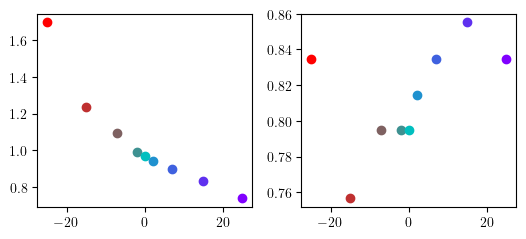

In [503]:
plt.figure(11,figsize=(8,2.5))

c1_fit = np.logspace(np.log10(0.001),np.log10(200),500);
c2_fit = np.logspace(np.log10(0.001),np.log10(200),500);
[C1_FIT,C2_FIT]=np.meshgrid(c1_fit,c2_fit)
c_error = np.zeros((np.size(c1_fit),np.size(c2_fit),num_data-1),dtype=float)
c1_fit_const = np.zeros((num_data-1,),dtype=float)
c2_fit_const = np.zeros((num_data-1,),dtype=float)
for num_data_select in range(num_data-1):
    z_data = LES_data[num_data_select].zw.flatten()
    U_data = LES_data[num_data_select].u_mean.flatten()
    U_prime_LES = np.gradient(U_data[0:-1],z_data[0:-1],edge_order=2)
    tau13  = LES_data[num_data_select].tau13_mean + LES_data[num_data_select].tau31_SGS_mean
    nuT_LES    = -tau13[0:-1]/U_prime_LES
    
    counter1=0
    for const1 in c1_fit:
        counter2=0
        for const2 in c2_fit:
            nuT_model  =  const1*0.41*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*1000/25))*(1-z_data[0:-1])**(const2)
            #nuT_model  =  0.41*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*1000/25))*np.exp(-const*z_data[0:-1])
            
            c_error[counter1,counter2,num_data_select] = np.mean(np.abs(nuT_LES-nuT_model))#mape(nuT_LES, nuT_model)
            counter2+=1
        counter1+=1
    # Get the index of the minimum value
    min_index_flat = np.argmin(c_error[:,:,num_data_select])  # Flattened index
    
    # Convert to (row, col) index
    min_index = np.unravel_index(min_index_flat, c_error[:,:,num_data_select].shape)    
    c1_fit_const[num_data_select] = C1_FIT[min_index[1],min_index[0]] 
    c2_fit_const[num_data_select] = C2_FIT[min_index[1],min_index[0]]


plt.figure(11,figsize=(8,4))
ax1=plt.subplot(1,3,1)
for num_data_select in range(num_data-1):
    #plt.loglog(c_fit,c_error[:,num_data_select],color=color_array[num_data_select])
    plt.scatter(c_array[num_data_select],c1_fit_const[num_data_select],color=color_array[num_data_select]) 

ax1=plt.subplot(1,3,2)
for num_data_select in range(num_data-1):
    plt.scatter(c_array[num_data_select],c2_fit_const[num_data_select],color=color_array[num_data_select]) 

plt.show()

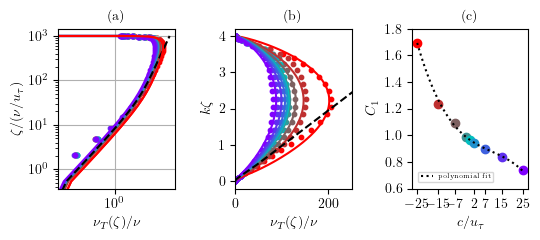

In [879]:
plt.figure(11,figsize=(5.5,2.5))

c2_const = 0.8# np.mean(c2_fit_const)
ax1=plt.subplot(1,3,1)
plt.tick_params(axis='both', labelsize=font_size) 
for num_data_select in range(9):
    z_data = LES_data[num_data_select].zw.flatten()
    U_data = LES_data[num_data_select].u_mean.flatten()
    U_prime_LES = np.gradient(U_data[0:-1],z_data[0:-1],edge_order=2)
    tau13  = LES_data[num_data_select].tau13_mean + LES_data[num_data_select].tau31_SGS_mean
    nuT_LES    = -tau13[0:-1]/U_prime_LES

    nuT_model  =  c1_fit_const[num_data_select]*0.41*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*1000/25))*(1-z_data[0:-1])**(c2_const)
    #nuT_model  =  0.41*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*1000/25))*np.exp(-c_fit_const[num_data_select]*z_data[0:-1])
        
    plt.scatter(nuT_LES[0:Nz:4]/nu, (ustar/nu) * z_data[0:Nz:4], marker='o',s=10,color=color_array[num_data_select],label=fr'$c/u_\tau={c_array[num_data_select]}$')
    plt.semilogy(nuT_model/nu,(ustar/nu) * z_data[0:-1],color=color_array[num_data_select])

plt.semilogy(0.41*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*1000/25))/nu,(ustar/nu)*z_data[0:-1],'k--',label=r'$\nu_{T,\mathrm{I}}$')
plt.yscale('log')
plt.xscale('log')

num_data_select = 0
nuT_model  =  c1_fit_const[num_data_select]*0.41*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*1000/25))*(1-z_data[0:-1])**(c2_fit_const[num_data_select])
plt.semilogy(nuT_model/nu,(ustar/nu)*z_data[0:-1],'r-',label=r'$\nu_{T,\mathrm{II}}$')
#plt.xlabel(r'$\nu_T(\zeta)=\frac{\langle\tau_{13}\rangle}{(\partial\langle u\rangle/\partial\zeta)}$',fontsize=font_size)    
plt.xlabel(r'$\nu_T(\zeta)/\nu$',fontsize=font_size)    
plt.ylabel(r'$\zeta/(\nu/u_\tau)$',fontsize=font_size) 
#plt.legend(loc='upper left', borderaxespad=1.,fontsize=4.5)
ax1.set_title('(a)',fontsize=font_size)
plt.grid()

ax1=plt.subplot(1,3,2)
plt.tick_params(axis='both', labelsize=font_size) 
for num_data_select in range(9):
    z_data = LES_data[num_data_select].zw.flatten()
    U_data = LES_data[num_data_select].u_mean.flatten()
    U_prime_LES = np.gradient(U_data[0:-1],z_data[0:-1],edge_order=2)
    tau13  = LES_data[num_data_select].tau13_mean + LES_data[num_data_select].tau31_SGS_mean
    nuT_LES    = -tau13[0:-1]/U_prime_LES

    nuT_model  =  c1_fit_const[num_data_select]*0.41*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*1000/25))*(1-z_data[0:-1])**(c2_const)
    #nuT_model  =  0.41*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*1000/25))*np.exp(-c_fit_const[num_data_select]*z_data[0:-1])
        
    plt.scatter(nuT_LES[0:Nz:4]/nu, k_wavno * z_data[0:Nz:4], marker='o',s=10,color=color_array[num_data_select],label=fr'$c/u_\tau={c_array[num_data_select]}$')
    plt.plot(nuT_model/nu,k_wavno*z_data[0:-1],color=color_array[num_data_select])
plt.semilogy(0.41*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*1000/25))/nu,k_wavno*z_data[0:-1],'k--',label=r'$\nu_{T,\mathrm{I}}$')
plt.yscale('linear')

#plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1.,fontsize=8)
#plt.xlabel(r'$\nu_T(\zeta)=\frac{\langle\tau_{13}\rangle}{(\partial\langle u\rangle/\partial\zeta)}$',fontsize=font_size)    
plt.xlabel(r'$\nu_T(\zeta)/\nu$',fontsize=font_size)    
plt.ylabel(r'$k\zeta$',fontsize=font_size) 
ax1.set_xlim(0,0.25/nu) 
ax1.set_title('(b)',fontsize=font_size)

ax1=plt.subplot(1,3,3)
plt.tick_params(axis='both', labelsize=font_size) 
for num_data_select in range(num_data-1):
    plt.scatter(c_array[num_data_select],c1_fit_const[num_data_select],color=color_array[num_data_select]) 

degree = 3
coeffs = np.polyfit(c_array[0:-1], c1_fit_const[0:9], degree)
coeffs = np.round(coeffs,6)
poly_func = np.poly1d(coeffs)
c_array_fit=np.linspace(-25,25,100)
plt.plot(c_array_fit,poly_func(c_array_fit),'k',linestyle=':',label='polynomial fit')
plt.legend(loc='lower left', borderaxespad=1.,fontsize=4.5)
plt.xticks([-25,-15,-7,2,7,15,25])
ax1.set_ylim(0.6,1.8)
plt.yticks(np.linspace(0.6,1.8,7))

plt.ylabel(r'$C_1$',fontsize=font_size)
plt.xlabel(r'$c/u_\tau$',fontsize=font_size)
ax1.set_title('(c)',fontsize=font_size)

# ax1=plt.subplot(2,2,4)
# plt.tick_params(axis='both', labelsize=font_size) 
# for num_data_select in range(num_data-1):
#     plt.scatter(c_array[num_data_select],c2_fit_const[num_data_select],color=color_array[num_data_select]) 
# plt.xticks([-25,-15,-7,-2,2,7,15,25])
# plt.xlabel(r'$c_2$',fontsize=font_size)
# plt.ylabel(r'$k\zeta$',fontsize=font_size)
# ax1.set_ylim(0,1)

plt.savefig('nuT_mean_flow.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

plt.show()

In [661]:
np.mean(c2_fit_const),coeffs

(0.8126000076308038,
 array([-1.30000e-05,  3.95000e-04, -1.11420e-02,  9.64377e-01]))

0
0 -25


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.23582e-42): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=8.19633e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=9.29455e-43): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048
n,N 6 2048
n,N 7 2048


/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


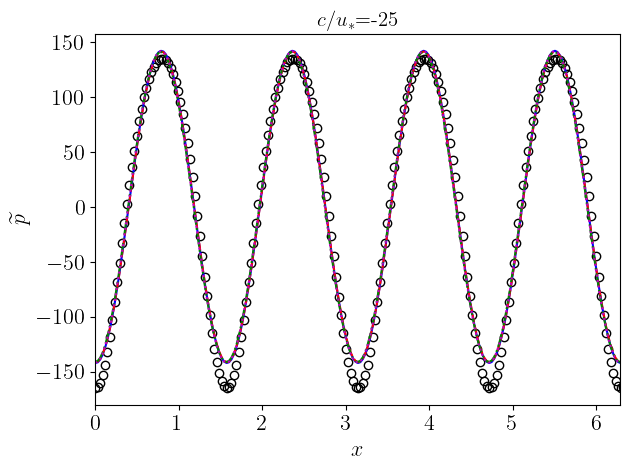

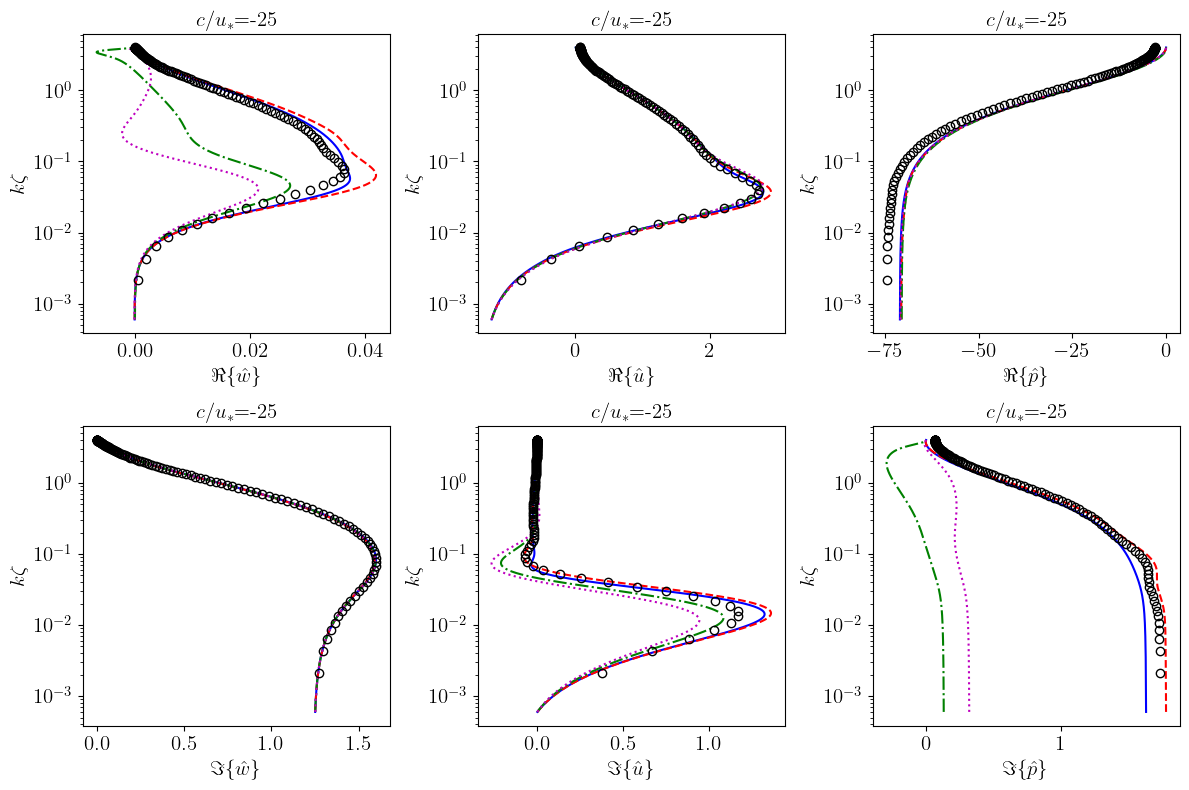

1
1 -15


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.0311e-42): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.49641e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.44911e-42): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048
n,N 6 2048
n,N 7 2048


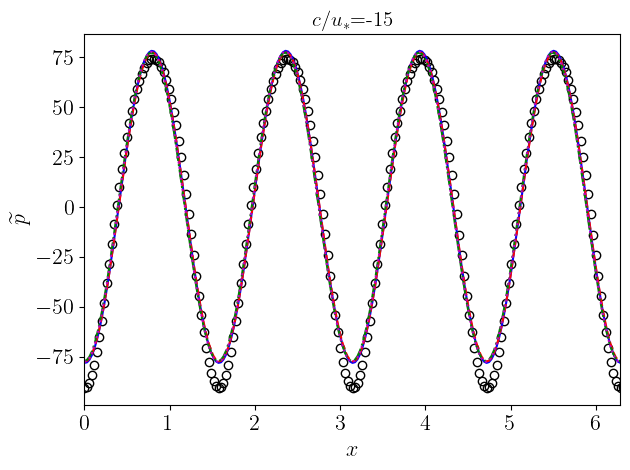

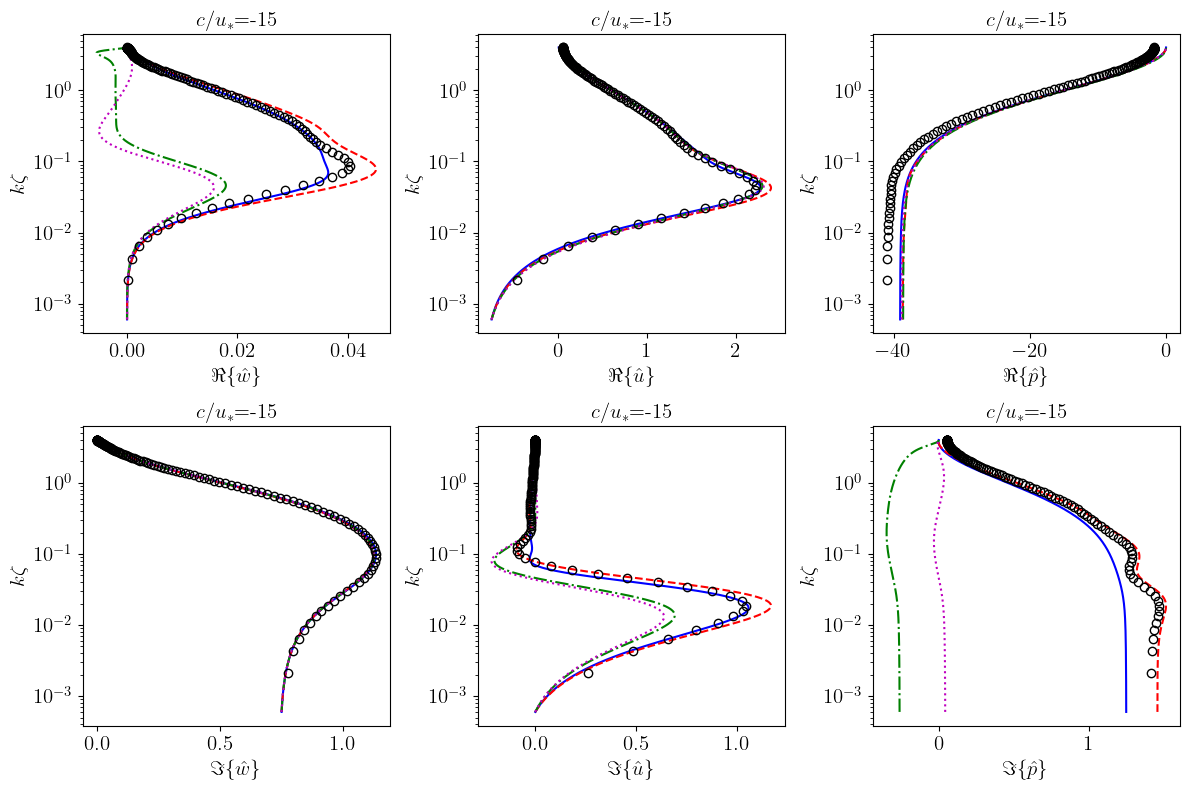

2
2 -7


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=7.13517e-43): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=4.06276e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=5.11887e-43): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048
n,N 6 2048
n,N 7 2048


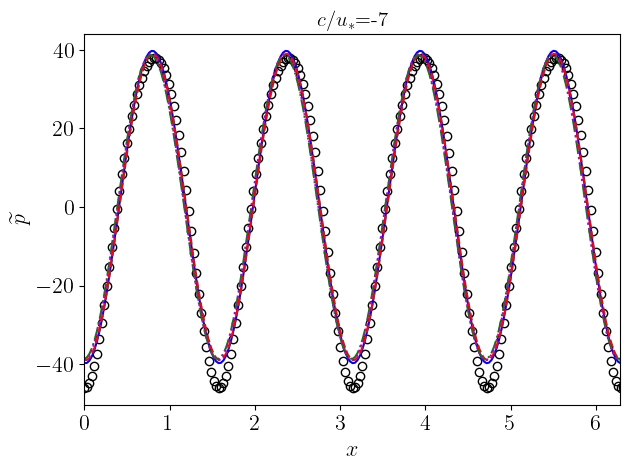

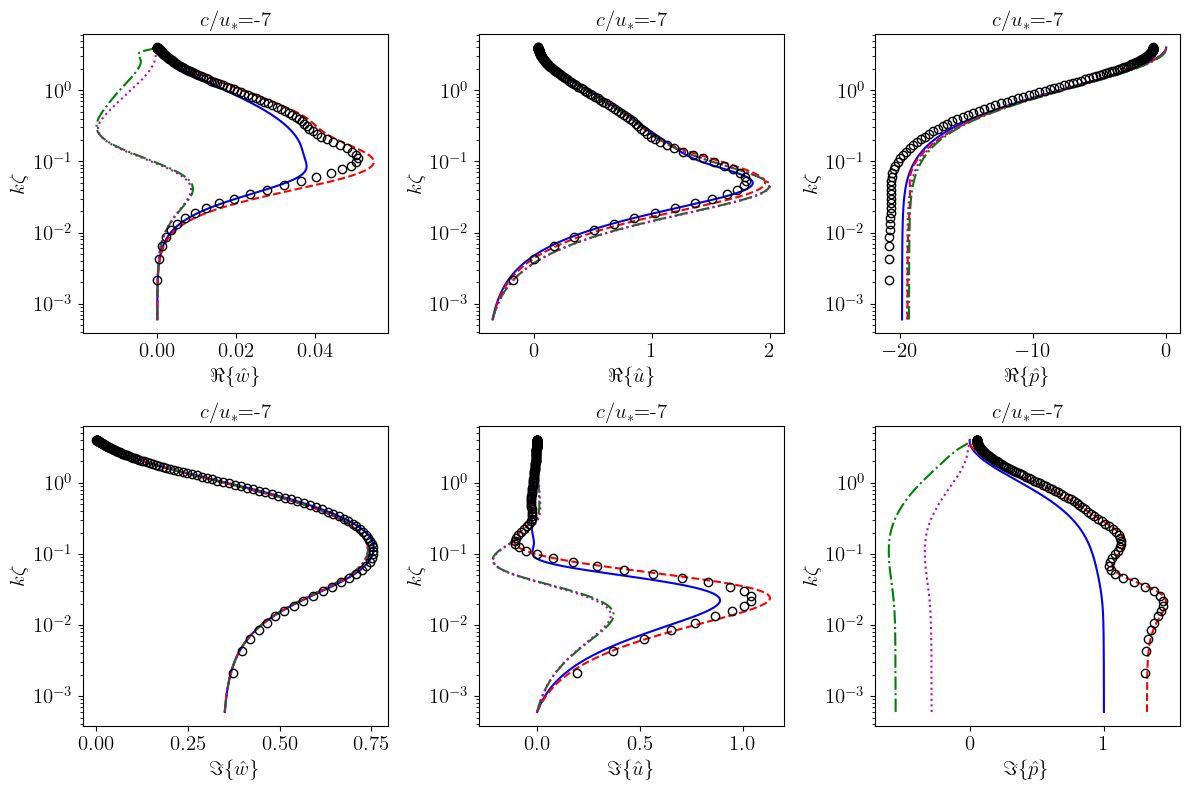

3
3 -2


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=6.69314e-43): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.89591e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=5.09893e-42): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048
n,N 6 2048
n,N 7 2048


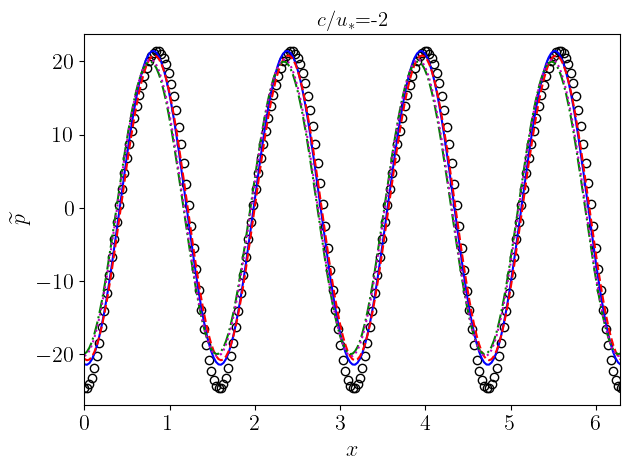

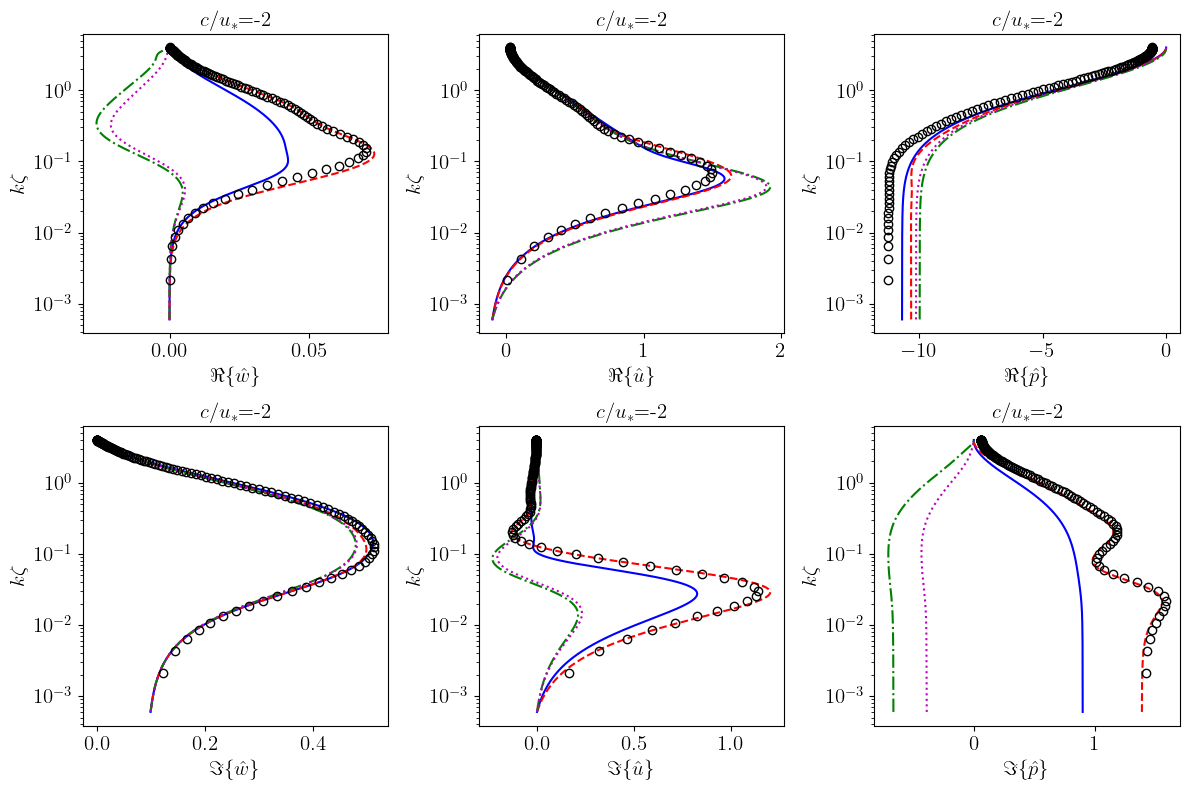

4
4 0


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=7.90996e-43): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.99182e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=3.79867e-43): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048
n,N 6 2048
n,N 7 2048


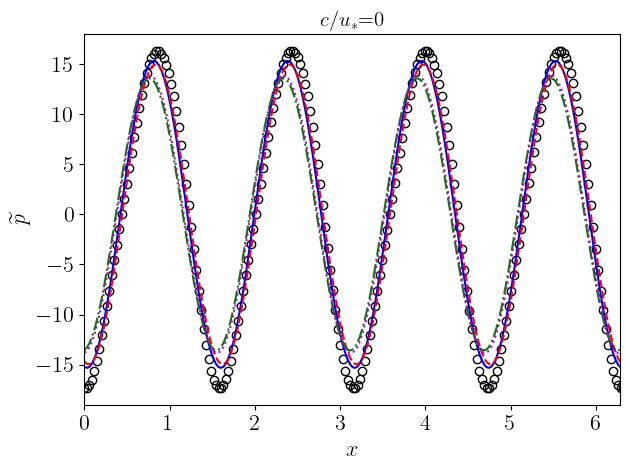

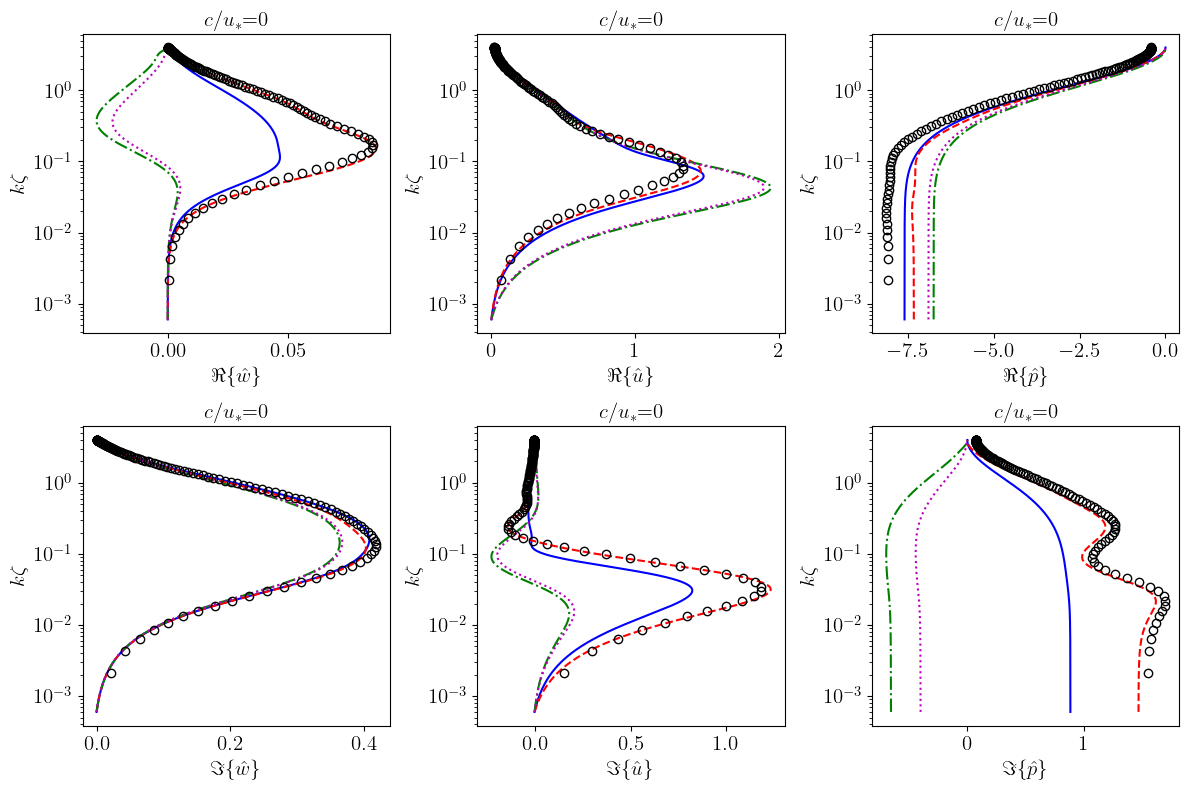

5
5 2


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.33189e-43): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=5.58652e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=6.74229e-43): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048
n,N 6 2048
n,N 7 2048


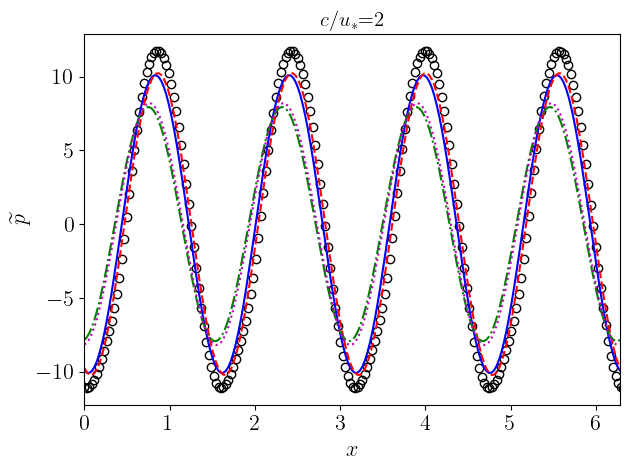

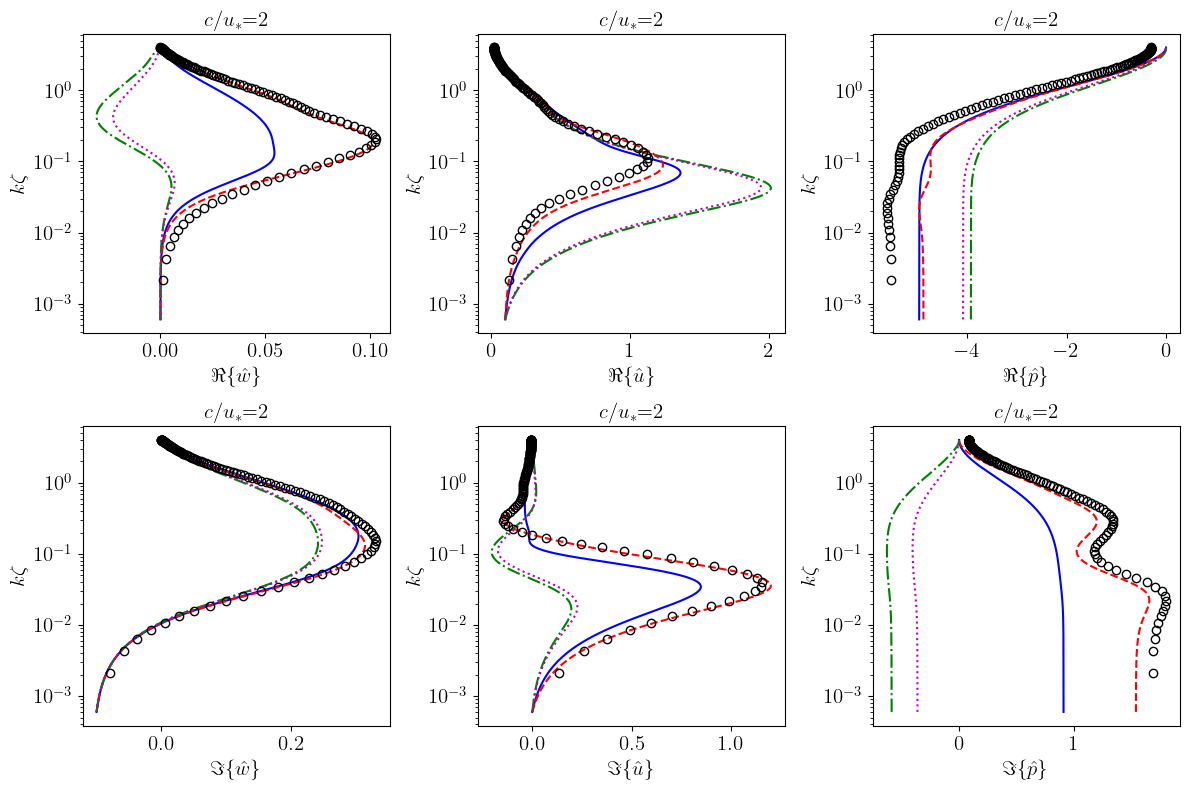

6
6 7


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=3.42794e-43): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.36587e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.20371e-43): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048
n,N 6 2048
n,N 7 2048


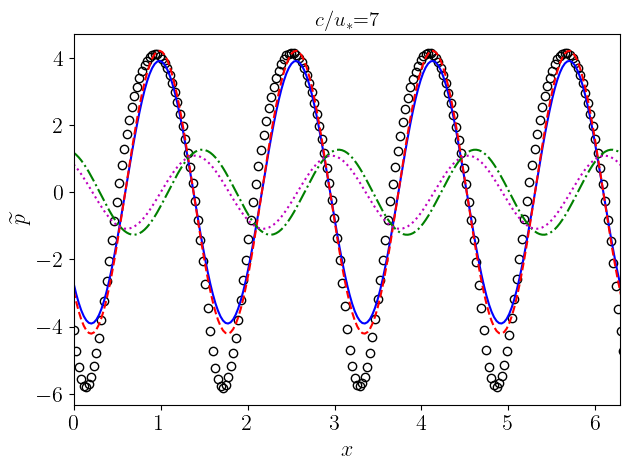

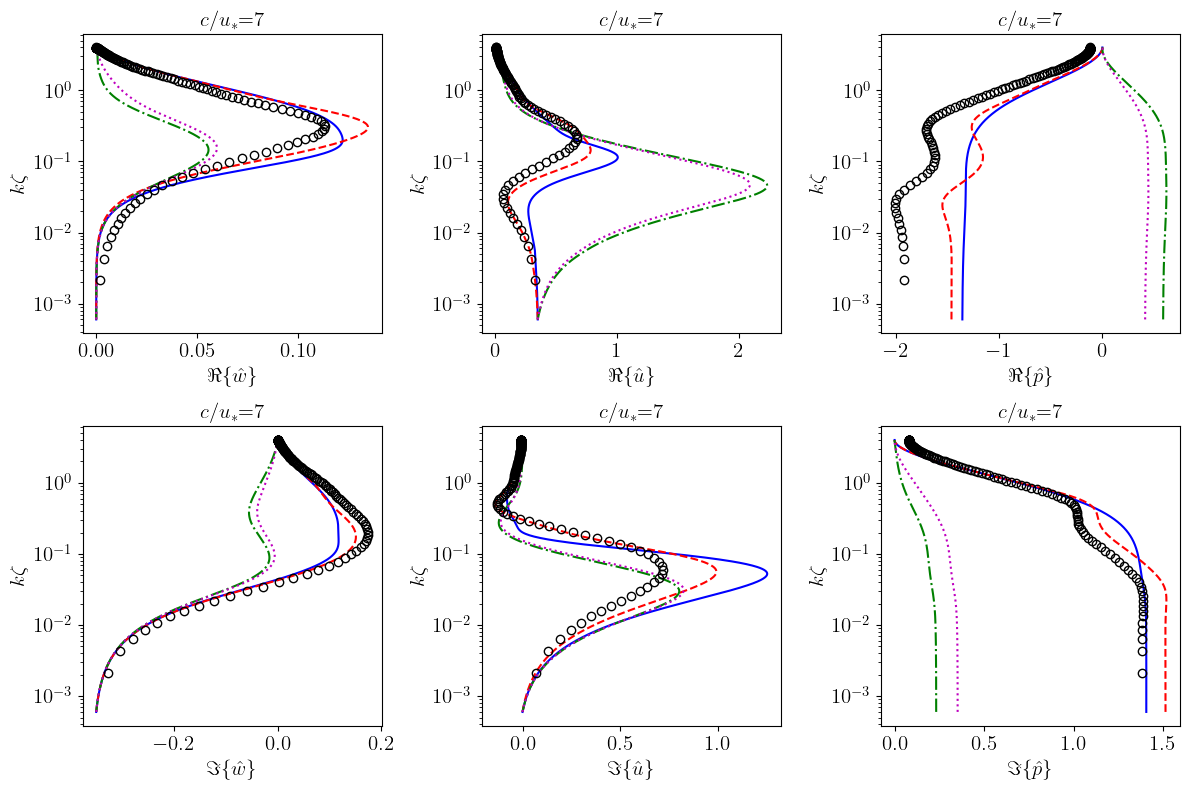

7
7 15


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=7.38256e-43): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=5.55759e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=8.37424e-44): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048
n,N 6 2048
n,N 7 2048


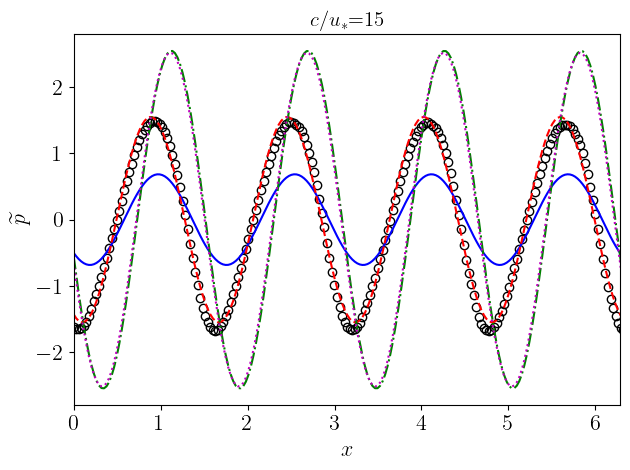

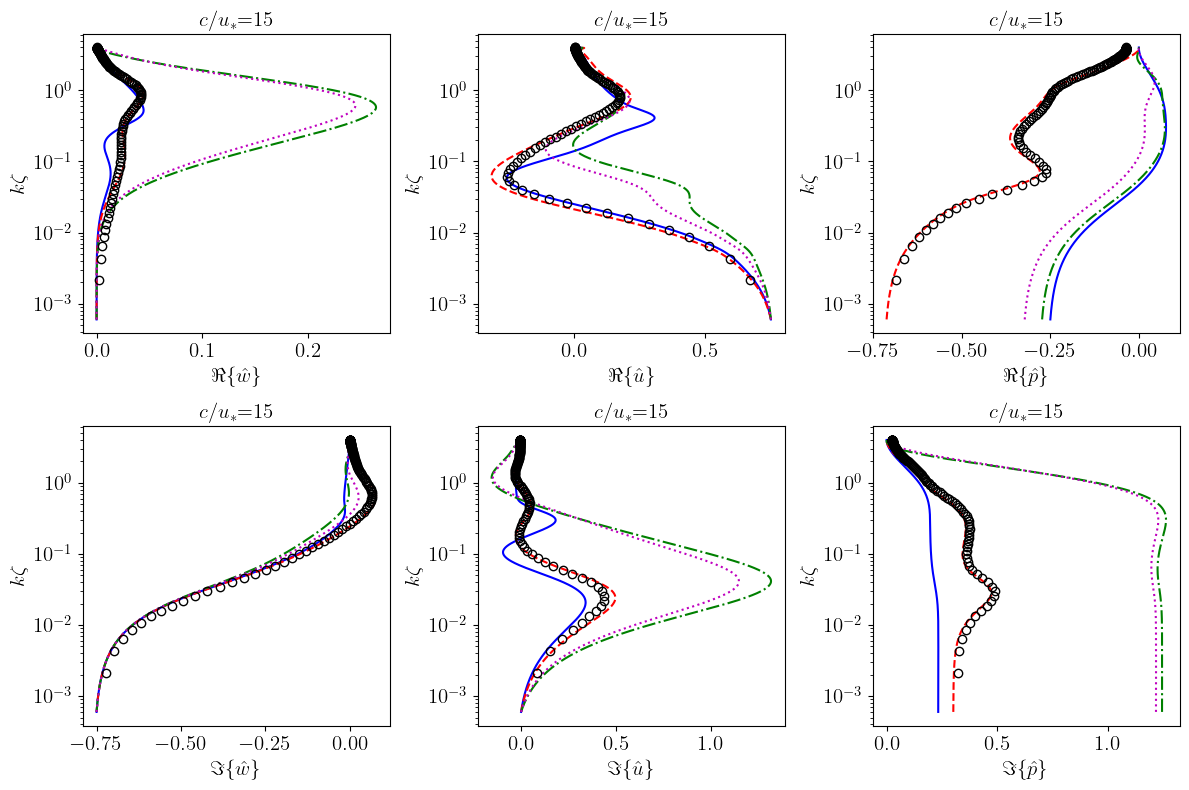

8
8 25


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.84668e-44): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.09465e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.17312e-44): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048
n,N 6 2048
n,N 7 2048


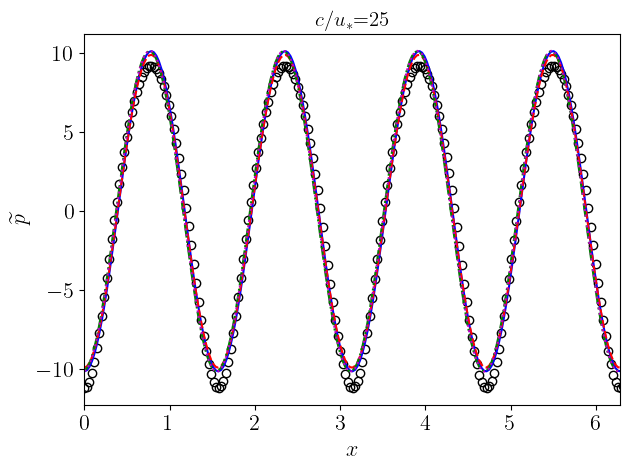

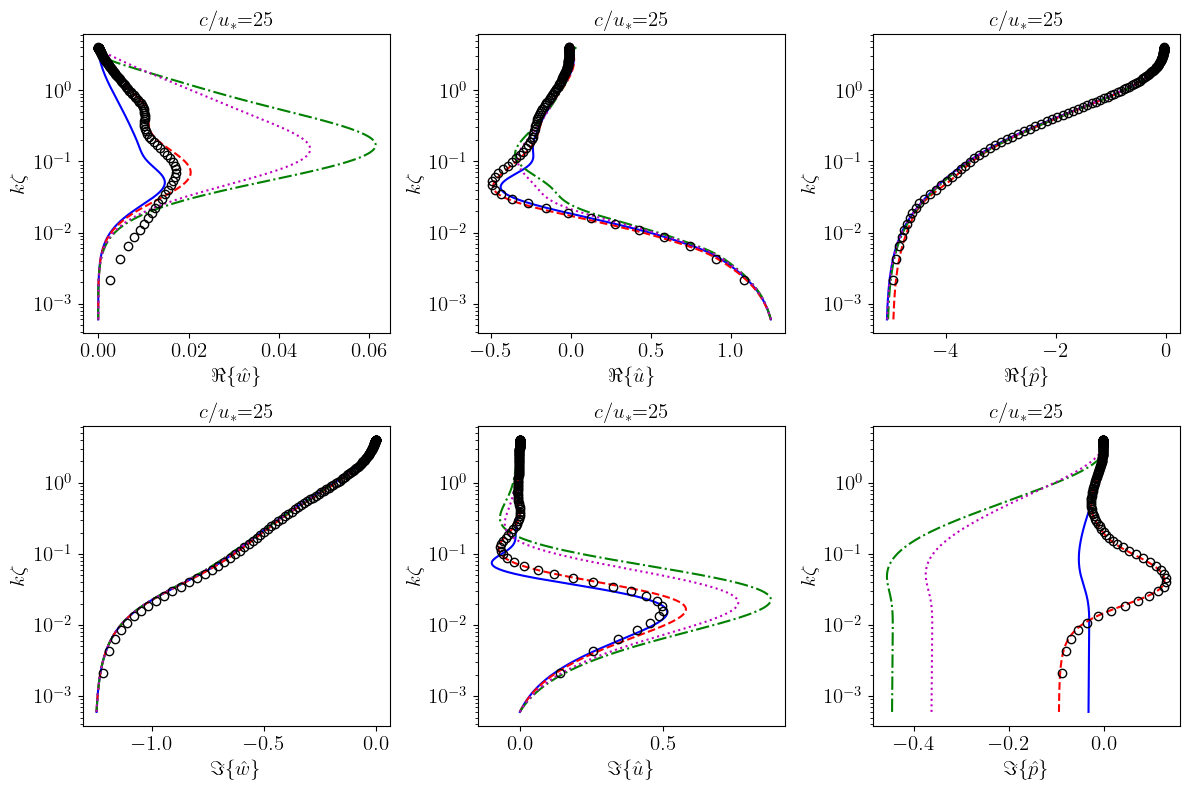

In [506]:
n_num = 8;
w     = np.zeros((N,n_num,9),dtype=complex)
Rew   = np.zeros((N,n_num,9),dtype=complex)
Imw   = np.zeros((N,n_num,9),dtype=complex)
DRew  = np.zeros((N,n_num,9),dtype=complex)
DImw  = np.zeros((N,n_num,9),dtype=complex)
D2Rew = np.zeros((N,n_num,9),dtype=complex)
D2Imw = np.zeros((N,n_num,9),dtype=complex)
Reu   = np.zeros((N,n_num,9),dtype=complex)
Imu   = np.zeros((N,n_num,9),dtype=complex)
U     = np.zeros((N,n_num,9),dtype=complex)
U_prime        = np.zeros((N,n_num,9),dtype=complex)
U_double_prime = np.zeros((N,n_num,9),dtype=complex)
U_triple_prime = np.zeros((N,n_num,9),dtype=complex)

nuT11_LES = np.zeros((Nz,9),dtype=complex)
nuT33_LES = np.zeros((Nz,9),dtype=complex)
nuT13_LES = np.zeros((Nz,9),dtype=complex)
nuT31_LES = np.zeros((Nz,9),dtype=complex)

nuT11_interp = np.zeros((N,9),dtype=complex)
nuT33_interp = np.zeros((N,9),dtype=complex)
nuT13_interp = np.zeros((N,9),dtype=complex)
nuT31_interp = np.zeros((N,9),dtype=complex)

x = np.linspace(0,Lx,Nx)
y = a*np.cos(k_wavno*x)

Rep = np.zeros((N,4,n_num,9),dtype=complex)
Imp = np.zeros((N,4,n_num,9),dtype=complex)

for num_data_select in range(9):
    print(num_data_select)
    c=c_array[num_data_select] # in meter per second
    print(num_data_select,c)
    filename_fig = [
        '01_SurfacePressure_ComparisonWithLES_case0.png',
        '01_SurfacePressure_ComparisonWithLES_case1.png',
        '01_SurfacePressure_ComparisonWithLES_case2.png',
        '01_SurfacePressure_ComparisonWithLES_case3.png',
        '01_SurfacePressure_ComparisonWithLES_case4.png',
        '01_SurfacePressure_ComparisonWithLES_case5.png',
        '01_SurfacePressure_ComparisonWithLES_case6.png',
        '01_SurfacePressure_ComparisonWithLES_case7.png',
        '01_SurfacePressure_ComparisonWithLES_case8.png'
    ]
    if num_data_select<7:
        z0=3.0e-4/2
    else:
        z0=1.5e-4
        
        #z0=1.75e-4 #case-8

    #Log-law model
    if use_non_uniform_grid:
        
        #Tanh-stretched grid
        z_min = z0  # Minimum value in the physical domain
        z_max = 1.0  # Maximum value in the physical domain
        alpha = 8.0  # Stretching factor (adjust for more/less stretching)

        # Create a linearly spaced grid in the range [0, 1]
        eta = np.linspace(-1, 1, N)

        # Apply the tanh stretching
        z_stretched = 0.5 * (np.tanh(alpha * eta) + 1)

        # Map the stretched grid to the desired physical domain
        z_non_uniform = z_min + z_stretched * (z_max - z_min)

        #z_non_uniform = np.logspace(np.log10(z0),np.log10(zi), N)
        z = z_non_uniform #np.logspace(np.log10(z0),np.log10(zi), N)
    else:
        z_uniform = np.linspace(z0,zi, N)
        z = z_uniform     #np.linspace(z0,zi, N)
    ###########################################################################################################################################################
    
    #Input from LES for viscous Curvilinear model
    z_data = np.asarray(LES_data[num_data_select].zw).flatten()
    U_data = np.asarray(LES_data[num_data_select].u_mean).flatten()
    
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U_visc = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime_visc   = U_prime_spline(z)
    
    
    U_double_prime_LES    = U_spline.derivative(nu=2)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_double_prime_spline = CubicSpline(z_data[0:-1],U_double_prime_LES)
    U_double_prime_visc   = U_double_prime_spline(z)
    
    U_triple_prime_LES    = U_spline.derivative(nu=3)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_triple_prime_spline = CubicSpline(z_data[0:-1],U_triple_prime_LES)
    U_triple_prime_visc   = U_triple_prime_spline(z)
    
    for n in range(n_num):
        U[:,n,num_data_select]       = U_visc
        U_prime[:,n,num_data_select] = U_prime_visc
        U_double_prime[:,n,num_data_select] = U_double_prime_visc
        U_triple_prime[:,n,num_data_select] = U_triple_prime_visc

    ##########################################################################################################################################
    w_hat_LES = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    tau13_mean_tot_LES = (LES_data[num_data_select].tau13_wave_mean[0:-1]*0+LES_data[num_data_select].tau13_mean[0:-1]+LES_data[num_data_select].tau13_SGS_mean[0:-1]).flatten()
    tau31_mean_tot_LES = (LES_data[num_data_select].tau31_mean[0:-1]+LES_data[num_data_select].tau31_SGS_mean[0:-1]).flatten()

    #Viscous stress
    tau11_nu_hat_LES = np.fft.fft(LES_data[num_data_select].tau11_nu[:,0:-1],norm='forward')
    tau13_nu_hat_LES = np.fft.fft(LES_data[num_data_select].tau13_nu[:,0:-1],norm='forward')
    tau31_nu_hat_LES = np.fft.fft(LES_data[num_data_select].tau31_nu[:,0:-1],norm='forward')
    tau33_nu_hat_LES = np.fft.fft(LES_data[num_data_select].tau33_nu[:,0:-1],norm='forward')
    
    tau11_nu_hat_LES_spline = CubicSpline(z_data[0:-1],tau11_nu_hat_LES[16,:])
    tau13_nu_hat_LES_spline = CubicSpline(z_data[0:-1],tau13_nu_hat_LES[16,:])
    tau31_nu_hat_LES_spline = CubicSpline(z_data[0:-1],tau31_nu_hat_LES[16,:])
    tau33_nu_hat_LES_spline = CubicSpline(z_data[0:-1],tau33_nu_hat_LES[16,:])
    
    dtau11_nu_hat_dz_LES_interp   = tau11_nu_hat_LES_spline.derivative(nu=1)(z)
    d2tau13_nu_hat_dz2_LES_interp = tau13_nu_hat_LES_spline.derivative(nu=2)(z)
    tau31_nu_hat_LES_interp       = tau31_nu_hat_LES_spline(z)
    dtau33_nu_hat_dz_LES_interp   = tau33_nu_hat_LES_spline.derivative(nu=1)(z)
    
    #nuT_linear = -tau13_mean_tot_LES/U_prime_LES*np.exp(-5*k_wavno*z_data[0:-1])# from LES
    nuT_linear = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    #nuT_linear = (1/(kappa*z_data[0:-1])+1/0.1)**(-1)
    #nuT_linear = np.round(inner_layer_depth[num_data_select], 3)*(1/(1000*z_data[0:-1]**3/np.round(inner_layer_depth[num_data_select], 3))**2+1**2)**(-1/2)
    #nuT_linear = ustar*kappa*(inner_layer_depth[num_data_select]/k_wavno)*(1-np.exp(-k_wavno*z_data[0:-1]/inner_layer_depth[num_data_select]))
    nuT_linear_1_interp  = np.interp(z,z_data[0:-1],nuT_linear)
    nuT_prime_1          = np.gradient(nuT_linear,z_data[0:-1])
    nuT_prime_1_interp   = np.interp(z,z_data[0:-1],nuT_prime_1)
    nuT_double_prime_1   = np.gradient(nuT_prime_1,z_data[0:-1])    
    nuT_double_prime_1_interp   = np.interp(z,z_data[0:-1],nuT_double_prime_1)
    
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) - nuT_linear*U_prime_LES*(1/zi)*(a/2)
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) 
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES)

    #nuT_linear_2 = -tau31_mean_tot_LES/U_prime_LES*np.exp(-5*k_wavno*z_data[0:-1]) # from LES
    
    nuT_linear_2 = c1_fit_const[num_data_select]*0.41*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*(1-z_data[0:-1])**(c2_const)#ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-0.5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    nuT_linear_2_interp  = np.interp(z,z_data[0:-1],nuT_linear_2)

    nuT_prime_2  = np.gradient(nuT_linear_2,z_data[0:-1])
    nuT_prime_2_interp  = np.interp(z,z_data[0:-1],nuT_prime_2)


    nuT_double_prime_2  = np.gradient(nuT_prime_2,z_data[0:-1])    
    nuT_double_prime_2_interp   = np.interp(z,z_data[0:-1],nuT_double_prime_2)
    
    
    tau11_hat_model_2 = 2*nuT_linear_2*dwdz_hat_LES
    tau13_hat_model_2 =  -nuT_linear_2*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) - nuT_linear_2*U_prime_LES*(1/zi)*(a/2)
    tau31_hat_model_2 =  -nuT_linear_2*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) 
    tau33_hat_model_2 =   nuT_linear_2*(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES)

    
    tau11_hat_model_spline = CubicSpline(z_data[0:-1],tau11_hat_model)
    tau13_hat_model_spline = CubicSpline(z_data[0:-1],tau13_hat_model)
    tau31_hat_model_spline = CubicSpline(z_data[0:-1],tau31_hat_model)
    tau33_hat_model_spline = CubicSpline(z_data[0:-1],tau33_hat_model)
    dtau11_hat_dz_model_interp   = tau11_hat_model_spline.derivative(nu=1)(z)
    d2tau13_hat_dz2_model_interp = tau13_hat_model_spline.derivative(nu=2)(z)
    tau31_hat_model_interp     = tau31_hat_model_spline(z)
    dtau33_hat_dz_model_interp = tau33_hat_model_spline.derivative(nu=1)(z)

    tau11_hat_model_2_spline = CubicSpline(z_data[0:-1],tau11_hat_model_2)
    tau13_hat_model_2_spline = CubicSpline(z_data[0:-1],tau13_hat_model_2)
    tau31_hat_model_2_spline = CubicSpline(z_data[0:-1],tau31_hat_model_2)
    tau33_hat_model_2_spline = CubicSpline(z_data[0:-1],tau33_hat_model_2)
    dtau11_hat_dz_model_2_interp   = tau11_hat_model_2_spline.derivative(nu=1)(z)
    d2tau13_hat_dz2_model_2_interp = tau13_hat_model_2_spline.derivative(nu=2)(z)
    tau31_hat_model_2_interp = tau31_hat_model_2_spline(z)
    dtau33_hat_dz_model_2_interp = tau33_hat_model_2_spline.derivative(nu=1)(z)
    
    tau11_hat_LES = np.fft.fft(LES_data[num_data_select].tau11_d+LES_data[num_data_select].tau11_d_SGS,axis=0,norm='forward')
    tau13_hat_LES = np.fft.fft(LES_data[num_data_select].tau13  +LES_data[num_data_select].tau13_SGS,axis=0,norm='forward')
    tau31_hat_LES = np.fft.fft(LES_data[num_data_select].tau31  +LES_data[num_data_select].tau31_SGS,axis=0,norm='forward')
    tau33_hat_LES = np.fft.fft(LES_data[num_data_select].tau33_d+LES_data[num_data_select].tau33_d_SGS,axis=0,norm='forward')

    nuT11_LES[0:-1,num_data_select] = (tau11_hat_LES[16,0:-1]/(2*dwdz_hat_LES))
    nuT13_LES[0:-1,num_data_select] = (tau13_hat_LES[16,0:-1]/(-(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) -U_prime_LES*(1/zi)*(a/2)))
    nuT31_LES[0:-1,num_data_select] = (tau31_hat_LES[16,0:-1]/(-(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1])))
    nuT33_LES[0:-1,num_data_select] = (tau33_hat_LES[16,0:-1]/(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES))
    
    nuT11_spline = CubicSpline(z_data[0:-1],nuT11_LES[0:-1,num_data_select], bc_type='not-a-knot')
    nuT13_spline = CubicSpline(z_data[0:-1],nuT13_LES[0:-1,num_data_select], bc_type='not-a-knot')
    nuT31_spline = CubicSpline(z_data[0:-1],nuT31_LES[0:-1,num_data_select], bc_type='not-a-knot')
    nuT33_spline = CubicSpline(z_data[0:-1],nuT33_LES[0:-1,num_data_select], bc_type='not-a-knot')
    nuT11_interp[:,num_data_select] = inner_layer_depth[num_data_select]/k_wavno*2*np.ones((N,),dtype=float)# nuT11_spline(z)
    nuT13_interp[:,num_data_select] = inner_layer_depth[num_data_select]/k_wavno*2*np.ones((N,),dtype=float)#nuT13_spline(z)
    nuT31_interp[:,num_data_select] = inner_layer_depth[num_data_select]/k_wavno*0.5*np.ones((N,),dtype=float)#nuT31_spline(z)
    nuT33_interp[:,num_data_select] = inner_layer_depth[num_data_select]/k_wavno*1*np.ones((N,),dtype=float)# nuT33_spline(z)
    
    
    tau11_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau11_wave,axis=0,norm='forward')
    tau13_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau13_wave,axis=0,norm='forward')
    tau31_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau31_wave,axis=0,norm='forward')
    tau33_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau33_wave,axis=0,norm='forward')

    tau11_hat_spline = CubicSpline(z_data[0:-1],tau11_hat_LES[16,0:-1])
    tau13_hat_spline = CubicSpline(z_data[0:-1],tau13_hat_LES[16,0:-1])
    tau31_hat_spline = CubicSpline(z_data[0:-1],tau31_hat_LES[16,0:-1])
    tau33_hat_spline = CubicSpline(z_data[0:-1],tau33_hat_LES[16,0:-1])
    
    tau11_wave_hat_spline = CubicSpline(z_data[0:-1],tau11_wave_hat_LES[16,0:-1])
    tau13_wave_hat_spline = CubicSpline(z_data[0:-1],tau13_wave_hat_LES[16,0:-1])
    tau31_wave_hat_spline = CubicSpline(z_data[0:-1],tau31_wave_hat_LES[16,0:-1])
    tau33_wave_hat_spline = CubicSpline(z_data[0:-1],tau33_wave_hat_LES[16,0:-1])
    
    tau11_hat_interp = tau11_hat_spline(z)
    tau13_hat_interp = tau13_hat_spline(z)
    tau31_hat_interp = tau31_hat_spline(z)
    tau33_hat_interp = tau33_hat_spline(z)
    
    tau11_wave_hat_interp = tau11_wave_hat_spline(z)
    tau13_wave_hat_interp = tau13_wave_hat_spline(z)
    tau31_wave_hat_interp = tau31_wave_hat_spline(z)
    tau33_wave_hat_interp = tau33_wave_hat_spline(z)
    
    dtau11_hat_dz_interp      = tau11_hat_spline.derivative(nu=1)(z)
    dtau11_wave_hat_dz_interp = tau11_wave_hat_spline.derivative(nu=1)(z)
    dtau33_hat_dz_interp      = tau33_hat_spline.derivative(nu=1)(z)
    dtau33_wave_hat_dz_interp = tau33_wave_hat_spline.derivative(nu=1)(z)
    
    d2tau13_hat_dz2_interp      = tau13_hat_spline.derivative(nu=2)(z)
    d2tau13_wave_hat_dz2_interp = tau13_wave_hat_spline.derivative(nu=1)(z)
    #########################################################################################################################################
    
    # Inhomogeneous term
    
    #g = lambda z, zi: z/zi -1
    g = z/zi-1
    g_zeta = 1/zi
    f_RHS  = np.zeros((N,n_num),dtype=complex)
    
    f_RHS[:,0] =  nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) 
          
    f_RHS[:,1] =   nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) \
                  +( 1*1j*k_wavno*dtau11_hat_dz_interp + 1*d2tau13_hat_dz2_interp )\
                  +( 1*k_wavno**2*tau31_hat_interp - 1*1j*k_wavno*dtau33_hat_dz_interp )
    
    #f_RHS[:,2] =   nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) \
    #              +1j*k_wavno*(dtau11_hat_dz_interp+dtau11_wave_hat_dz_interp) + d2tau13_hat_dz2_interp + d2tau13_wave_hat_dz2_interp \
    #              +k**2*(tau31_wave_hat_interp+tau31_hat_interp) -1j*k_wavno*(dtau33_hat_dz_interp+dtau33_wave_hat_dz_interp)

    f_RHS[:,2] =   nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) \
                   +( 1j*k_wavno*dtau11_hat_dz_model_interp + 1*d2tau13_hat_dz2_model_interp )\
                   +1*( 1*k_wavno**2*tau31_hat_model_interp - 1j*k_wavno*dtau33_hat_dz_model_interp )
    
    f_RHS[:,3] =   nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) \
                   +( 1j*k_wavno*dtau11_hat_dz_model_2_interp + d2tau13_hat_dz2_model_2_interp )\
                   +( k_wavno**2*tau31_hat_model_2_interp - 1j*k_wavno*dtau33_hat_dz_model_2_interp )

    f_RHS[:,4] =   (nu*1+nuT_linear_1_interp*1)*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) \
                   +1*nuT_prime_1_interp*a/2*g*(2*U_triple_prime[:,0,num_data_select]-k_wavno**2*U_prime[:,0,num_data_select]) \
                   +1*nuT_prime_1_interp*a/2*g_zeta*2*U_double_prime[:,0,num_data_select] \
                   +1*nuT_double_prime_1_interp*g*a/2*U_double_prime[:,0,num_data_select]
    
    f_RHS[:,5] =   (nu*1+nuT_linear_2_interp*1)*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) \
                   +1*nuT_prime_2_interp*a/2*g*(2*U_triple_prime[:,0,num_data_select]-k_wavno**2*U_prime[:,0,num_data_select]) \
                   +1*nuT_prime_2_interp*a/2*g_zeta*2*U_double_prime[:,0,num_data_select] \
                   +1*nuT_double_prime_2_interp*g*a/2*U_double_prime[:,0,num_data_select]

    f_RHS[:,6] =   nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) 
    #np.gradient(np.gradient((nu+nuT13_interp[:,num_data_select])*g*(a/2)*U_double_prime_visc,z,edge_order=2),z,edge_order=2) \
    #               -(a/2)*k_wavno**2*np.gradient(nuT33_interp[:,num_data_select]*g*U_prime_visc,z,edge_order=2) \
    #               +nuT31_interp[:,num_data_select]*k_wavno**2*np.gradient(g*(a/2)*U_prime_visc,z,edge_order=2)

    f_RHS[:,7] =  (nu*1+nuT_linear_2_interp*1)*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) \
                   +1*nuT_prime_2_interp*a/2*g*(2*U_triple_prime[:,0,num_data_select]-k_wavno**2*U_prime[:,0,num_data_select]) \
                   +1*nuT_prime_2_interp*a/2*g_zeta*2*U_double_prime[:,0,num_data_select] \
                   +1*nuT_double_prime_2_interp*g*a/2*U_double_prime[:,0,num_data_select]
    #plt.semilogy(nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2),z)
    #plt.semilogy(f_RHS[:,0],z)
    plt.show()

    # Solve Orr-Sommerfeld equation
    
    if use_non_uniform_grid:
        ##Boundary conditions: [phi(-1), phi'(-1), phi(1), phi'(1)]
    
        w_s   = -1j*0.5*a*k_wavno*c

        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime[0,0,num_data_select]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]

        w[:,0,num_data_select]    = orr_sommerfeld_non_uniform(N, z, nu*1, np.zeros((N,),dtype='float'), np.zeros((N,),dtype='float'), np.zeros((N,),dtype='float') , k_wavno, U[:,0,num_data_select], c, U_double_prime[:,0,num_data_select], f_RHS[:,0],z_bc)
    
        ######################################################################################################################################################################################
       
        w_s   = -1j*0.5*a*k_wavno*c
       
        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime[0,1,num_data_select]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]
        
        w[:,1,num_data_select]    = orr_sommerfeld_non_uniform(N, z, nu*1, np.zeros((N,),dtype='float'), np.zeros((N,),dtype='float'), np.zeros((N,),dtype='float')  , k_wavno, U[:,1,num_data_select], c, U_double_prime[:,1,num_data_select], f_RHS[:,1],z_bc)
        
        ######################################################################################################################################################################################
       
        w_s   = -1j*0.5*a*k_wavno*c

        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime[0,2,num_data_select]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]
        
        w[:,2,num_data_select]    = orr_sommerfeld_non_uniform(N, z, nu*1,np.zeros((N,),dtype='float'), np.zeros((N,),dtype='float'), np.zeros((N,),dtype='float') , k_wavno, U[:,2,num_data_select], c, U_double_prime[:,2,num_data_select], f_RHS[:,2],z_bc)

    ######################################################################################################################################################################################
       
        w_s   = -1j*0.5*a*k_wavno*c

        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime[0,3,num_data_select]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]
        
        w[:,3,num_data_select]    = orr_sommerfeld_non_uniform(N, z, nu*1,np.zeros((N,),dtype='float'), np.zeros((N,),dtype='float'), np.zeros((N,),dtype='float')  , k_wavno, U[:,3,num_data_select], c, U_double_prime[:,3,num_data_select], f_RHS[:,3],z_bc)
    
    ######################################################################################################################################################################################
       
        w_s   = -1j*0.5*a*k_wavno*c

        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime[0,4,num_data_select]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]
        
        w[:,4,num_data_select]    = orr_sommerfeld_non_uniform(N, z, nu*1, nuT_linear_1_interp*1, nuT_prime_1_interp*1, nuT_double_prime_1_interp*1  , k_wavno, U[:,4,num_data_select], c, U_double_prime[:,4,num_data_select], f_RHS[:,4],z_bc)

    ######################################################################################################################################################################################
       
        w_s   = -1j*0.5*a*k_wavno*c

        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime[0,4,num_data_select]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]
        
        w[:,5,num_data_select]    = orr_sommerfeld_non_uniform(N, z, nu*1, nuT_linear_2_interp*1, nuT_prime_2_interp*1, nuT_double_prime_2_interp*1  , k_wavno, U[:,4,num_data_select], c, U_double_prime[:,4,num_data_select], f_RHS[:,5],z_bc)
    ######################################################################################################################################################################################
       
        w_s   = -1j*0.5*a*k_wavno*c

        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime_visc[0]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]
        
        #w[:,6,num_data_select]= orr_sommerfeld_non_uniform_nuT_ij(N, z, nu, nuT11_interp[:,num_data_select], nuT33_interp[:,num_data_select], nuT13_interp[:,num_data_select], nuT31_interp[:,num_data_select], k_wavno, U_visc, c, U_double_prime_visc, f_RHS[:,6],z_bc)

        #w[:,6,num_data_select] = orr_sommerfeld_non_uniform_nuT_ij_iterative_debug(N, a/2, z, zi, nu, nuT11_interp[:,num_data_select], nuT33_interp[:,num_data_select], nuT13_interp[:,num_data_select], nuT31_interp[:,num_data_select], k_wavno, U_visc, c, U_prime_visc, U_double_prime_visc, f_RHS[:,6],z_bc,0.75)
    
        #w[:,6,num_data_select] = orr_sommerfeld_non_uniform_nuT_ij_Chebyshev(N, a, z, zi, nu, nuT11_interp[:,num_data_select], nuT33_interp[:,num_data_select], nuT13_interp[:,num_data_select], nuT31_interp[:,num_data_select], k_wavno, U_visc, c, U_prime_visc, U_double_prime_visc, f_RHS[:,6],z_bc,0.75)     
    ######################################################################################################################################################################################
       
        w_s   = -1j*0.5*a*k_wavno*c

        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime_visc[0]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]
        
        sol   = solve_bvp_model(N, z     , nu*1, nuT_linear_2_interp*1, nuT_linear_2_interp*1, nuT_linear_2_interp*1, nuT_linear_2_interp*1  , k_wavno, U[:,4,num_data_select], c, U_double_prime[:,4,num_data_select], f_RHS[:,7],z_bc)
        w[:,7,num_data_select]  =  sol['y'][0,:]

        
    else:
        print("Use non uniform grid")
       # w[:,0,num_data_select]    = orr_sommerfeld(N, z, nu*1, nuT*0, nuT_prime*0, nuT_double_prime*0  , k_wavno, U_visc, c, U_double_prime_visc, f_RHS[:,0],z_bc_nu)
       # w[:,1,num_data_select]    = orr_sommerfeld(N, z, nu*1, nuT*0, nuT_prime*0, nuT_double_prime*0  , k_wavno, U_visc, c, U_double_prime_visc, f_RHS[:,1],z_bc)
       # w[:,2,num_data_select]    = orr_sommerfeld(N, z, nu*1, nuT*0, nuT_prime*0, nuT_double_prime*0  , k_wavno, U_visc, c, U_double_prime_visc, f_RHS[:,2],z_bc)
        
    
    # Calculate Real and Imaginary parts of w perturbation
    for n in range(n_num):
        Rew[:,n,num_data_select]  = np.real(w[:,n,num_data_select])
        Imw[:,n,num_data_select]  = np.imag(w[:,n,num_data_select])
        DRew[:,n,num_data_select] = np.gradient(np.real(w[:,n,num_data_select]),z,edge_order=2)
        DImw[:,n,num_data_select] = np.gradient(np.imag(w[:,n,num_data_select]),z,edge_order=2)
        D2Rew[:,n,num_data_select]= np.gradient(DRew[:,n,num_data_select],z,edge_order=2)
        D2Imw[:,n,num_data_select]= np.gradient(DImw[:,n,num_data_select],z,edge_order=2)
        Reu[:,n,num_data_select]  = -(1/k_wavno)*DImw[:,n,num_data_select]-0.5*a*(-1)*U_prime[:,n,num_data_select]
        Imu[:,n,num_data_select]  =  (1/k_wavno)*DRew[:,n,num_data_select]
         
    #### Compute pressure
    g      = (z/zi-1)
    for n in range(n_num):
        print('n,N',n,N)
        for i in range(N):
            D2w_hat    =   D2Rew[i:,n,num_data_select]+1j*D2Imw[i:,n,num_data_select]
            p_hat_adv  =   np.trapz(1j*k_wavno*(U[i:,n,num_data_select]-c)*w[i:,n,num_data_select],z[i:])
            p_hat_visc =  -nu*np.trapz(-k_wavno**2*w[i:,n,num_data_select]+D2w_hat,z[i:])
            if n<2:
                p_hat_turb =  1j*k_wavno*np.trapz(tau31_hat_interp[i:],z[i:])+np.trapz(dtau33_hat_dz_interp[i:],z[i:])
            if n==2:
                p_hat_turb =  1j*k_wavno*np.trapz(tau31_hat_model_interp[i:],z[i:])+np.trapz(dtau33_hat_dz_model_interp[i:],z[i:])
            if n==3:
                p_hat_turb =  1j*k_wavno*np.trapz(tau31_hat_model_2_interp[i:],z[i:])+np.trapz(dtau33_hat_dz_model_2_interp[i:],z[i:])

            
            Rep[i,0,n,num_data_select] = p_hat_adv.real
            Rep[i,1,n,num_data_select] = p_hat_visc.real
            Rep[i,2,n,num_data_select] = p_hat_turb.real
            
            if n==0:
                Rep[i,3,n,num_data_select] = Rep[i,0,n,num_data_select]+Rep[i,1,n,num_data_select]*1+Rep[i,2,n,num_data_select]*0
            else:
                Rep[i,3,n,num_data_select] = Rep[i,0,n,num_data_select]+Rep[i,1,n,num_data_select]*1+Rep[i,2,n,num_data_select]
                
            Imp[i,0,n,num_data_select] =  p_hat_adv.imag
            Imp[i,1,n,num_data_select] =  p_hat_visc.imag
            Imp[i,2,n,num_data_select] =  p_hat_turb.imag
            
            if n==0:
                Imp[i,3,n,num_data_select]=  Imp[i,0,n,num_data_select]+Imp[i,1,n,num_data_select]*1+Imp[i,2,n,num_data_select]*0
            else:
                Imp[i,3,n,num_data_select]=  Imp[i,0,n,num_data_select]+Imp[i,1,n,num_data_select]*1+Imp[i,2,n,num_data_select]
    # plot it
    # f, (a0, a1, a2, a3) = plt.subplots(4, 1, gridspec_kw={'height_ratios': [10, 1, 10, 10]})
    fig, (a0) = plt.subplots(1, 1, gridspec_kw={'height_ratios': [5]})
        
    phase_diff=np.pi/2*0;
    a0.plot(x, LES_data[num_data_select].p_w_surf-np.mean(LES_data[num_data_select].p_w_surf),'ok',markerfacecolor='none',label='LES')
    
    for n in n_num_array_index:
        a0.plot(x, 2*Rep[0,3,n,num_data_select]*np.cos(k_wavno*x+phase_diff)*1-1*2*Imp[0,3,n,num_data_select]*np.sin(k_wavno*x+phase_diff),color_array_plot[n],label=r'$2Re\{\hat{p}\}\cos (k\xi)-2Im\{\hat{p}\}\sin (k\xi)$ (TurbCurv)')
    a0.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    a0.set_ylabel(r'$\widetilde{p}$',fontsize=16)
    a0.set_xlabel(r'$x$',fontsize=16)
    a0.tick_params(labelsize=16)
    a0.set_xlim(0,2*np.pi)
    #a0.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #a0.set_ylim(-1,1)
    fig.tight_layout()
    #plt.savefig(filename_fig[num_data_select],format='png',dpi=100,bbox_inches='tight', 
    #               transparent=False,
    #               pad_inches=0.01)

    filename_fig = [
        '01_what_profile_ComparisonWithLES_case0.png',
        '01_what_profile_ComparisonWithLES_case1.png',
        '01_what_profile_ComparisonWithLES_case2.png',
        '01_what_profile_ComparisonWithLES_case3.png',
        '01_what_profile_ComparisonWithLES_case4.png',
        '01_what_profile_ComparisonWithLES_case5.png',
        '01_what_profile_ComparisonWithLES_case6.png',
        '01_what_profile_ComparisonWithLES_case7.png',
        '01_what_profile_ComparisonWithLES_case8.png'
    ]
    
    plt.figure(11,figsize=(12,8))
    
    ax1=plt.subplot(231)
    for n in n_num_array_index:
        plt.semilogy(Rew[:,n,num_data_select],k_wavno*z,color_array_plot_Re[n],label='$\Re\{\hat{w}\}$ (Model)')
        
    w_LES_data = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    plt.semilogy(w_LES_data[16,:].real,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none',label='$\Re\{\hat{w}\}$ (LES)')
    
    
    ax1.set_xlabel(r'$\Re\{\hat{w}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
    
    #ax1.legend(fontsize=11, frameon=False, loc='upper right', bbox_to_anchor=(2, 1))
    #plt.savefig(filename_fig[num_data_select],format='png',dpi=100,bbox_inches='tight', 
    #               transparent=False,
    #               pad_inches=0.01)
    #plt.close()


    ax1=plt.subplot(232)
    for n in n_num_array_index:
        plt.semilogy(Reu[:,n,num_data_select],k_wavno*z,color_array_plot_Re[n])
        #plt.semilogy(Imu[:,n],k*z,color_array_plot_Im[n])
    #plt.semilogy(np.sqrt(   Reuopposing[:]**2+Imuopposing[:]**2),k*z,'b--',label='$|\hat{u}|$ (Model)')
    #plt.semilogy(np.sqrt(Reuopposing_nu[:]**2+Imuopposing_nu[:]**2),k*z,'b-.',label='$|\hat{u}_\nu|$ (Model)')
    
    u_LES_data = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    plt.semilogy(u_LES_data[16,:].real,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    #plt.semilogy(u_LES_data[16,:].imag,k*LES_data[num_data_select].zw,'mo',markerfacecolor='none')
    #plt.semilogy(np.abs(u_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{u}|$ (LES)')
    
    ax1.set_xlabel(r'$\Re\{\hat{u}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)

    ax1=plt.subplot(233)
    for n in n_num_array_index:
        plt.semilogy(Rep[:,3,n,num_data_select],k_wavno*z,color_array_plot_Re[n])
        #plt.semilogy(Imp[:,3,n],k*z,color_array_plot_Im[n])
    #plt.semilogy(np.sqrt(   Rep_opposing[:]**2+Imp_opposing[:]**2),k*z,'b--',label='$|\hat{p}|$ (Model)')
    #plt.semilogy(np.sqrt(Rep_opposing_nu[:]**2+Imp_opposing_nu[:]**2),k*z,'b-.',label='$|\hat{p}_\nu|$ (Model)')
    
    p_LES_data = np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')
    plt.semilogy(p_LES_data[16,:].real,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    #plt.semilogy(p_LES_data[16,:].imag,k*LES_data[num_data_select].zw,'mo',markerfacecolor='none')
    #plt.semilogy(np.abs(p_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{p}|$ (LES)')
    ax1.set_xlabel(r'$\Re\{\hat{p}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)


    ax1=plt.subplot(234)
    for n in n_num_array_index:
        #plt.semilogy(Rew[:,n],k*z,color_array_plot_Re[n],label='$\Re\{\hat{w}\}$ (Model)')
        plt.semilogy(Imw[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n],label='$\Im\{\hat{w}\}$ (Model)')
    #plt.semilogy(np.sqrt(Rewopposing[:]**2+Imwopposing[:]**2),k*z,'b--',label='$|\hat{w}|$ (Model)')
    #plt.semilogy(np.sqrt(Rewopposing_nu[:]**2+Imwopposing_nu[:]**2),k*z,'b-.',label='$|\hat{w}_\nu|$ (Model)')
    
    w_LES_data = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    #plt.semilogy(w_LES_data[16,:].real,k*LES_data[num_data_select].zw,'ko',markerfacecolor='none',label='$\Re\{\hat{w}\}$ (LES)')
    plt.semilogy(w_LES_data[16,:].imag,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none',label='$\Im\{\hat{w}\}$ (LES)')
    #plt.semilogy(np.abs(w_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{w}|$ (LES)')
    
    ax1.set_xlabel(r'$\Im\{\hat{w}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
    
    ax1=plt.subplot(235)
    for n in n_num_array_index:
        #plt.semilogy(Reu[:,n],k*z,color_array_plot_Re[n])
        plt.semilogy(Imu[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n])
    #plt.semilogy(np.sqrt(   Reuopposing[:]**2+Imuopposing[:]**2),k*z,'b--',label='$|\hat{u}|$ (Model)')
    #plt.semilogy(np.sqrt(Reuopposing_nu[:]**2+Imuopposing_nu[:]**2),k*z,'b-.',label='$|\hat{u}_\nu|$ (Model)')
    
    u_LES_data = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    #plt.semilogy(u_LES_data[16,:].real,k*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    plt.semilogy(u_LES_data[16,:].imag,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    #plt.semilogy(np.abs(u_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{u}|$ (LES)')
    
    ax1.set_xlabel(r'$\Im\{\hat{u}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
    
    ax1=plt.subplot(236)
    for n in n_num_array_index:
        #plt.semilogy(Rep[:,3,n],k*z,color_array_plot_Re[n])
        plt.semilogy(Imp[:,3,n,num_data_select],k_wavno*z,color_array_plot_Im[n])
    #plt.semilogy(np.sqrt(   Rep_opposing[:]**2+Imp_opposing[:]**2),k*z,'b--',label='$|\hat{p}|$ (Model)')
    #plt.semilogy(np.sqrt(Rep_opposing_nu[:]**2+Imp_opposing_nu[:]**2),k*z,'b-.',label='$|\hat{p}_\nu|$ (Model)')
    
    p_LES_data = np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')
    #plt.semilogy(p_LES_data[16,:].real,k*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    plt.semilogy(p_LES_data[16,:].imag,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    #plt.semilogy(np.abs(p_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{p}|$ (LES)')
    ax1.set_xlabel(r'$\Im\{\hat{p}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)

    #plt.savefig(filename_fig[num_data_select],format='png',dpi=600,bbox_inches='tight',
    #            transparent=False,pad_inches=0.01)
    plt.show()

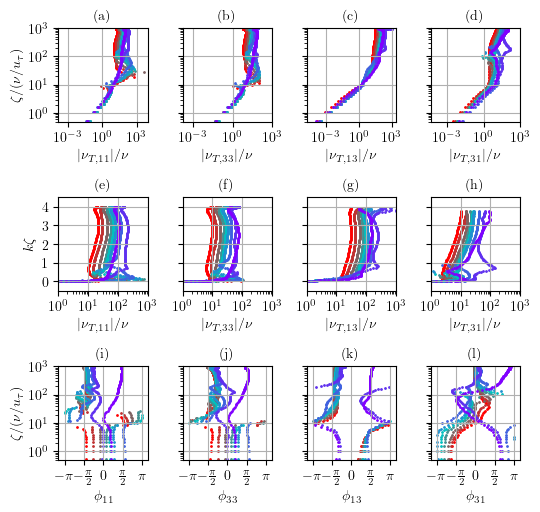

In [1008]:
plt.figure(11,figsize=(5.5,6.5))
font_size=10
ax1=plt.subplot(4,4,1)
for num_data_select in range(9):
    plt.scatter(np.abs(nuT11_LES[0:-1,num_data_select])/nu,(ustar/nu)*LES_data[num_data_select].zw[0:-1].flatten(), \
    color=color_array[num_data_select],marker='o',s=1)
plt.xscale('log')
plt.yscale('log')
#plt.loglog((LES_data[num_data_select].zw[0:-1].flatten())**2,k_wavno*LES_data[num_data_select].zw[0:-1].flatten(),'k:')
#plt.loglog((LES_data[num_data_select].zw[0:-1].flatten())**1,k_wavno*LES_data[num_data_select].zw[0:-1].flatten(),'m:')
plt.xlabel(r'$|{\nu}_{T,11}|/\nu$',fontsize=font_size)
plt.ylabel(r'$\zeta/(\nu/u_\tau)$',fontsize=font_size)
ax1.set_title('(a)',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
plt.xticks([1e-3,1,1e3])
plt.ylim(5e-1,1e3)
plt.yticks([1,1e1,1e2,1e3])
plt.grid()   

ax1=plt.subplot(4,4,2)
for num_data_select in range(9):
    plt.scatter(np.abs(nuT33_LES[0:-1,num_data_select])/nu,(ustar/nu)*LES_data[num_data_select].zw[0:-1].flatten(), \
    color=color_array[num_data_select],marker='o',s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$|{\nu}_{T,33}|/\nu$',fontsize=font_size)
plt.ylabel('')
ax1.set_yticklabels('')
ax1.set_title('(b)',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
plt.xticks([1e-3,1,1e3])
plt.ylim(5e-1,1e3)
plt.yticks([1,1e1,1e2,1e3])
plt.grid()   

ax1=plt.subplot(4,4,3)
for num_data_select in range(9):
    plt.scatter(np.abs(nuT13_LES[0:-20,num_data_select])/nu,(ustar/nu)*LES_data[num_data_select].zw[0:-20].flatten(), \
    color=color_array[num_data_select],marker='o',s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$|{\nu}_{T,13}|/\nu$',fontsize=font_size)
ax1.set_yticklabels('')
ax1.set_title('(c)',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
plt.xticks([1e-3,1,1e3])
plt.ylim(5e-1,1e3)
plt.yticks([1,1e1,1e2,1e3])
plt.grid()   

ax1=plt.subplot(4,4,4)
for num_data_select in range(9):
    plt.scatter(np.abs(nuT31_LES[0:-30,num_data_select])/nu,(ustar/nu)*LES_data[num_data_select].zw[0:-30].flatten(), \
    color=color_array[num_data_select],marker='o',s=1)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$|{\nu}_{T,31}|/\nu$',fontsize=font_size)
ax1.set_yticklabels('')
ax1.set_title('(d)',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
plt.xticks([1e-3,1,1e3])
plt.ylim(5e-1,1e3)
plt.yticks([1,1e1,1e2,1e3])
plt.grid()   
# ################################################################################################################################################
ax1=plt.subplot(4,4,5)
for num_data_select in range(9):
    plt.scatter(np.abs(nuT11_LES[0:-1,num_data_select])/nu,k_wavno*LES_data[num_data_select].zw[0:-1].flatten(), \
    color=color_array[num_data_select],marker='o',s=1)
plt.xscale('log')
plt.yscale('linear')
#plt.loglog((LES_data[num_data_select].zw[0:-1].flatten())**2,k_wavno*LES_data[num_data_select].zw[0:-1].flatten(),'k:')
#plt.loglog((LES_data[num_data_select].zw[0:-1].flatten())**1,k_wavno*LES_data[num_data_select].zw[0:-1].flatten(),'m:')
plt.xlabel(r'$|{\nu}_{T,11}|/\nu$',fontsize=font_size)
plt.ylabel(r'$k\zeta$',fontsize=font_size)
ax1.set_title('(e)',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
plt.xlim(1,1e3)
plt.xticks([1,1e1,1e2,1e3])
plt.ylim(-0.5,4.5)
plt.yticks([0,1,2,3,4])
plt.grid()   

ax1=plt.subplot(4,4,6)
for num_data_select in range(9):
    plt.scatter(np.abs(nuT33_LES[0:-1,num_data_select])/nu,k_wavno*LES_data[num_data_select].zw[0:-1].flatten(), \
    color=color_array[num_data_select],marker='o',s=1)
plt.xscale('log')
plt.yscale('linear')
plt.xlabel(r'$|{\nu}_{T,33}|/\nu$',fontsize=font_size)
plt.ylabel('')
ax1.set_yticklabels('')
ax1.set_title('(f)',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
plt.xlim(1,1e3)
plt.xticks([1,1e1,1e2,1e3])
plt.ylim(-0.5,4.5)
plt.yticks([0,1,2,3,4])
plt.grid()   

ax1=plt.subplot(4,4,7)
for num_data_select in range(9):
    plt.scatter(np.abs(nuT13_LES[0:-20,num_data_select])/nu,k_wavno*LES_data[num_data_select].zw[0:-20].flatten(), \
    color=color_array[num_data_select],marker='o',s=1)
plt.xscale('log')
plt.yscale('linear')
plt.xlabel(r'$|{\nu}_{T,13}|/\nu$',fontsize=font_size)
ax1.set_yticklabels('')
ax1.set_title('(g)',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
plt.xlim(1,1e3)
plt.xticks([1,1e1,1e2,1e3])
plt.ylim(-0.5,4.5)
plt.yticks([0,1,2,3,4])
plt.grid()   

ax1=plt.subplot(4,4,8)
for num_data_select in range(9):
    plt.scatter(np.abs(nuT31_LES[0:-30,num_data_select])/nu,k_wavno*LES_data[num_data_select].zw[0:-30].flatten(), \
    color=color_array[num_data_select],marker='o',s=1)
plt.xscale('log')
plt.yscale('linear')

plt.xlabel(r'$|{\nu}_{T,31}|/\nu$',fontsize=font_size)
ax1.set_yticklabels('')
ax1.set_title('(h)',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
plt.xlim(1,1e3)
plt.xticks([1,1e1,1e2,1e3])
plt.ylim(-0.5,4.5)
plt.yticks([0,1,2,3,4])
plt.grid()   
################################################################################################################################################

ax1=plt.subplot(4,4,9)
for num_data_select in range(9):
    phase = np.arctan2(nuT11_LES[0:-1,num_data_select].imag,nuT11_LES[0:-1,num_data_select].real)
    plt.scatter(phase,(ustar/nu)*LES_data[num_data_select].zw[0:-1].flatten(),color=color_array[num_data_select],s=1)
    plt.yscale('log')
plt.xlabel(r'$\phi_{11}$',fontsize=font_size)
plt.ylabel(r'$\zeta/(\nu/u_\tau)$')
ax1.set_title('(i)',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
plt.xlim(-np.pi-0.5,np.pi+0.5)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$',r'$\pi$'])
plt.ylim(5e-1,1e3)
plt.yticks([1,1e1,1e2,1e3])
plt.grid()   

ax1=plt.subplot(4,4,10)
for num_data_select in range(9):
    phase = np.arctan2(nuT33_LES[0:-1,num_data_select].imag,nuT33_LES[0:-1,num_data_select].real)
    plt.scatter(phase,(ustar/nu)*LES_data[num_data_select].zw[0:-1].flatten(),color=color_array[num_data_select],s=1)
    plt.yscale('log')
plt.xlabel(r'$\phi_{33}$',fontsize=font_size)
ax1.set_yticklabels('')
ax1.set_title('(j)',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
plt.xlim(-np.pi-0.5,np.pi+0.5)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$',r'$\pi$'])
plt.ylim(5e-1,1e3)
plt.yticks([1,1e1,1e2,1e3])
plt.grid()   

ax1=plt.subplot(4,4,11)
for num_data_select in range(9):
    phase = np.arctan2(nuT13_LES[0:-30,num_data_select].imag,nuT13_LES[0:-30,num_data_select].real)
    plt.scatter(phase,(ustar/nu)*LES_data[num_data_select].zw[0:-30].flatten(),color=color_array[num_data_select],s=1)
    plt.yscale('log')
plt.xlabel(r'$\phi_{13}$',fontsize=font_size)
ax1.set_yticklabels('')
ax1.set_title('(k)',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
plt.xlim(-np.pi-0.5,np.pi+0.5)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$',r'$\pi$'])
plt.ylim(5e-1,1e3)
plt.yticks([1,1e1,1e2,1e3])
plt.grid()   

ax1=plt.subplot(4,4,12)
for num_data_select in range(9):
    phase = np.arctan2(nuT31_LES[0:-30,num_data_select].imag,nuT31_LES[0:-30,num_data_select].real)
    plt.scatter(phase,(ustar/nu)*LES_data[num_data_select].zw[0:-30].flatten(),color=color_array[num_data_select],s=1)
    plt.yscale('log')
plt.xlabel(r'$\phi_{31}$',fontsize=font_size)
ax1.set_yticklabels('')
ax1.set_title('(l)',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
plt.xlim(-np.pi-0.5,np.pi+0.5)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$',r'$\pi$'])
plt.ylim(5e-1,1e3)
plt.yticks([1,1e1,1e2,1e3])
plt.grid()   

plt.savefig('nuTij_magnitude_phase_profile.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

plt.show()



In [965]:
np.mean(nuT11_const),np.mean(nuT33_const),np.mean(nuT13_const),np.mean(nuT31_const)

(2.7777777777777777, 1.3555555555555556, 3.744444444444445, 0.9333333333333331)

/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/2009994746.py:313: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


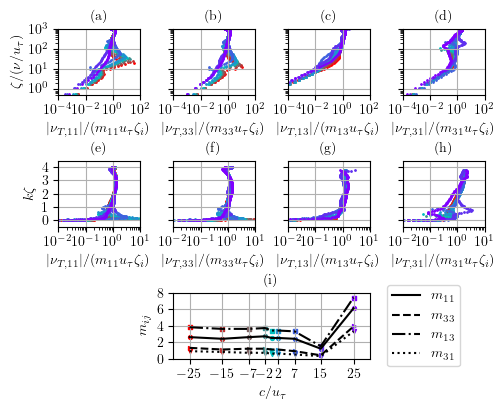

In [1007]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Make sure these variables are defined before running:
# LES_data, nuT11_LES, nuT33_LES, nuT13_LES, nuT31_LES,
# inner_layer_depth, k_wavno, nu, ustar, c_array,
# color_array, font_size

fig = plt.figure(11, figsize=(5.5, 6))
gs = gridspec.GridSpec(nrows=4, ncols=4)
# Adjust spacing between subplots if needed
gs.update(wspace=0.4, hspace=1)

norm_power = 0

# ----------------- (a) Subplot -----------------
ax1 = fig.add_subplot(gs[0, 0])
nuT11_const = np.zeros((9,), dtype=float)
for num_data_select in range(9):
    arr = np.abs(LES_data[num_data_select].zw[0:-1].flatten() - 120 * nu / ustar)
    min_index = np.argmin(arr)
    nuT11_const[num_data_select] = np.round(
        np.mean(
            np.abs(nuT11_LES[min_index:-1, num_data_select]) 
            / (inner_layer_depth[num_data_select] / k_wavno)
        ), 1
    )

for num_data_select in range(9):
    ax1.scatter(
        np.abs(nuT11_LES[0:-1, num_data_select]) 
        / (nuT11_const[num_data_select] * inner_layer_depth[num_data_select] / k_wavno),
        (ustar / nu) * LES_data[num_data_select].zw[0:-1].flatten() 
        / inner_layer_depth[num_data_select]**norm_power,
        color=color_array[num_data_select], marker='o', s=1
    )

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$|{\nu}_{T,11}|/(m_{11} u_\tau \zeta_i)$', fontsize=font_size)
ax1.set_ylabel(r'$\zeta/(\nu/u_\tau)$', fontsize=font_size)
ax1.set_xlim(1e-4, 1e2)
ax1.set_xticks([1e-4, 1e-2, 1, 1e2])
ax1.set_title('(a)', fontsize=font_size)
ax1.tick_params(labelsize=font_size)
if norm_power:
    ax1.set_ylabel(r'$\zeta/\zeta_i$', fontsize=font_size)
    ax1.set_ylim(1e-2, 1e3)
    ax1.set_yticks([1e-2, 1e-1, 1, 1e1, 1e2, 1e3])
else:
    ax1.set_ylim(5e-1, 1e3)
    ax1.set_yticks([1, 1e1, 1e2, 1e3])
ax1.grid()

# ----------------- (b) Subplot -----------------
ax2 = fig.add_subplot(gs[0, 1])
nuT33_const = np.zeros((9,), dtype=float)
for num_data_select in range(9):
    arr = np.abs(LES_data[num_data_select].zw[0:-1].flatten() - 120 * nu / ustar)
    min_index = np.argmin(arr)
    nuT33_const[num_data_select] = np.round(
        np.mean(
            np.abs(nuT33_LES[min_index:-1, num_data_select]) 
            / (inner_layer_depth[num_data_select] / k_wavno)
        ), 1
    )

for num_data_select in range(9):
    ax2.scatter(
        np.abs(nuT33_LES[0:-1, num_data_select]) 
        / (nuT33_const[num_data_select] * inner_layer_depth[num_data_select] / k_wavno),
        (ustar / nu) * LES_data[num_data_select].zw[0:-1].flatten() 
        / inner_layer_depth[num_data_select]**norm_power,
        color=color_array[num_data_select], marker='o', s=1
    )

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'$|{\nu}_{T,33}|/(m_{33}u_\tau \zeta_i)$', fontsize=font_size)
ax2.set_xlim(1e-4, 1e2)
ax2.set_xticks([1e-4, 1e-2, 1, 1e2])
ax2.set_title('(b)', fontsize=font_size)
ax2.tick_params(labelsize=font_size)
ax2.set_yticklabels([])
if norm_power:
    ax2.set_ylim(1e-2, 1e2)
    ax2.set_yticks([1e-2, 1e-1, 1, 1e1, 1e2])
else:
    ax2.set_ylim(5e-1, 1e3)
    ax2.set_yticks([1, 1e1, 1e2, 1e3])
ax2.grid()

# ----------------- (c) Subplot -----------------
ax3 = fig.add_subplot(gs[0, 2])
nuT13_const = np.zeros((9,), dtype=float)
for num_data_select in range(9):
    arr = np.abs(LES_data[num_data_select].zw[0:-1].flatten() - 120 * nu / ustar)
    min_index = np.argmin(arr)
    nuT13_const[num_data_select] = np.round(
        np.mean(
            np.abs(nuT13_LES[min_index:-1, num_data_select]) 
            / (inner_layer_depth[num_data_select] / k_wavno)
        ), 1
    )

for num_data_select in range(9):
    ax3.scatter(
        np.abs(nuT13_LES[0:-30, num_data_select]) 
        / (nuT13_const[num_data_select] * inner_layer_depth[num_data_select] / k_wavno),
        (ustar / nu) * LES_data[num_data_select].zw[0:-30].flatten() 
        / inner_layer_depth[num_data_select]**norm_power,
        color=color_array[num_data_select], marker='o', s=1
    )

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'$|{\nu}_{T,13}|/(m_{13}u_\tau \zeta_i)$', fontsize=font_size)
ax3.set_xlim(1e-4,1e2)
ax3.set_xticks([1e-4, 1e-2, 1, 1e2])
ax3.set_title('(c)', fontsize=font_size)
ax3.tick_params(labelsize=font_size)
ax3.set_yticklabels([])
if norm_power:
    ax3.set_ylim(1e-2, 1e2)
    ax3.set_yticks([1e-2, 1e-1, 1, 1e1, 1e2])
else:
    ax3.set_ylim(5e-1, 1e3)
    ax3.set_yticks([1, 1e1, 1e2, 1e3])
ax3.grid()

# ----------------- (d) Subplot -----------------
ax4 = fig.add_subplot(gs[0, 3])
nuT31_const = np.zeros((9,), dtype=float)
for num_data_select in range(9):
    arr = np.abs(LES_data[num_data_select].zw[0:-1].flatten() - 60 * nu / ustar)
    min_index = np.argmin(arr)
    nuT31_const[num_data_select] = np.round(
        np.mean(
            np.abs(nuT31_LES[min_index:-1, num_data_select]) 
            / (inner_layer_depth[num_data_select] / k_wavno)
        ), 1
    )

for num_data_select in range(9):
    ax4.scatter(
        np.abs(nuT31_LES[0:-30, num_data_select]) 
        / (nuT31_const[num_data_select] * inner_layer_depth[num_data_select] / k_wavno),
        (ustar / nu) * LES_data[num_data_select].zw[0:-30].flatten() 
        / inner_layer_depth[num_data_select]**norm_power,
        color=color_array[num_data_select], marker='o', s=1
    )

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel(r'$|{\nu}_{T,31}|/(m_{31}u_\tau \zeta_i)$', fontsize=font_size)
ax4.set_xlim(1e-4,1e2)
ax4.set_xticks([1e-4, 1e-2, 1, 1e2])
ax4.set_title('(d)', fontsize=font_size)
ax4.tick_params(labelsize=font_size)
ax4.set_yticklabels([])
if norm_power:
    ax4.set_ylim(1e-2, 1e2)
    ax4.set_yticks([1e-2, 1e-1, 1, 1e1, 1e2])
else:
    ax4.set_ylim(5e-1, 1e3)
    ax4.set_yticks([1, 1e1, 1e2, 1e3])
ax4.grid()

# ----------------- (e) Subplot -----------------
ax5 = fig.add_subplot(gs[1, 0])
for num_data_select in range(9):
    ax5.scatter(
        np.abs(nuT11_LES[0:-1, num_data_select]) 
        / (nuT11_const[num_data_select] * inner_layer_depth[num_data_select] / k_wavno),
        (k_wavno) * LES_data[num_data_select].zw[0:-1].flatten() 
        / inner_layer_depth[num_data_select]**norm_power,
        color=color_array[num_data_select], marker='o', s=1
    )

ax5.set_xscale('log')
ax5.set_yscale('linear')
ax5.set_xlabel(r'$|{\nu}_{T,11}|/(m_{11} u_\tau \zeta_i)$', fontsize=font_size)
ax5.set_ylabel(r'$k\zeta$', fontsize=font_size)
ax5.set_xlim(1e-2, 1e1)
ax5.set_xticks([1e-2, 1e-1, 1, 1e1])
ax5.set_title('(e)', fontsize=font_size)
ax5.tick_params(labelsize=font_size)
if norm_power:
    ax5.set_ylabel(r'$\zeta/\zeta_i$', fontsize=font_size)
    ax5.set_ylim(1e-2, 1e3)
    ax5.set_yticks([1e-2, 1e-1, 1, 1e1, 1e2, 1e3])
else:
    ax5.set_ylim(-0.5, 4.5)
    ax5.set_yticks([0, 1, 2, 3, 4])
ax5.grid()

# ----------------- (f) Subplot -----------------
ax6 = fig.add_subplot(gs[1, 1])
for num_data_select in range(9):
    ax6.scatter(
        np.abs(nuT33_LES[0:-1, num_data_select]) 
        / (nuT33_const[num_data_select] * inner_layer_depth[num_data_select] / k_wavno),
        (k_wavno) * LES_data[num_data_select].zw[0:-1].flatten() 
        / inner_layer_depth[num_data_select]**norm_power,
        color=color_array[num_data_select], marker='o', s=1
    )

ax6.set_xscale('log')
ax6.set_yscale('linear')
ax6.set_xlabel(r'$|{\nu}_{T,33}|/(m_{33}u_\tau \zeta_i)$', fontsize=font_size)
ax6.set_xlim(1e-2, 1e1)
ax6.set_xticks([1e-2, 1e-1, 1, 1e1])
ax6.set_title('(f)', fontsize=font_size)
ax6.tick_params(labelsize=font_size)
ax6.set_yticklabels([])
if norm_power:
    ax6.set_ylim(1e-2, 1e2)
    ax6.set_yticks([1e-2, 1e-1, 1, 1e1, 1e2])
else:
    ax6.set_ylim(-0.5, 4.5)
    ax6.set_yticks([0, 1, 2, 3, 4])
ax6.grid()

# ----------------- (g) Subplot -----------------
ax7 = fig.add_subplot(gs[1, 2])
for num_data_select in range(9):
    ax7.scatter(
        np.abs(nuT13_LES[0:-30, num_data_select]) 
        / (nuT13_const[num_data_select] * inner_layer_depth[num_data_select] / k_wavno),
        (k_wavno) * LES_data[num_data_select].zw[0:-30].flatten() 
        / inner_layer_depth[num_data_select]**norm_power,
        color=color_array[num_data_select], marker='o', s=1
    )

ax7.set_xscale('log')
ax7.set_yscale('linear')
ax7.set_xlabel(r'$|{\nu}_{T,13}|/(m_{13}u_\tau \zeta_i)$', fontsize=font_size)
ax7.set_xlim(1e-2, 1e1)
ax7.set_xticks([1e-2, 1e-1, 1, 1e1])
ax7.set_title('(g)', fontsize=font_size)
ax7.tick_params(labelsize=font_size)
ax7.set_yticklabels([])
if norm_power:
    ax7.set_ylim(1e-2, 1e2)
    ax7.set_yticks([1e-2, 1e-1, 1, 1e1, 1e2])
else:
    ax7.set_ylim(-0.5, 4.5)
    ax7.set_yticks([0, 1, 2, 3, 4])
ax7.grid()

# ----------------- (h) Subplot -----------------
ax8 = fig.add_subplot(gs[1, 3])
for num_data_select in range(9):
    ax8.scatter(
        np.abs(nuT31_LES[0:-30, num_data_select]) 
        / (nuT31_const[num_data_select] * inner_layer_depth[num_data_select] / k_wavno),
        (k_wavno) * LES_data[num_data_select].zw[0:-30].flatten() 
        / inner_layer_depth[num_data_select]**norm_power,
        color=color_array[num_data_select], marker='o', s=1
    )

ax8.set_xscale('log')
ax8.set_yscale('linear')
ax8.set_xlabel(r'$|{\nu}_{T,31}|/(m_{31}u_\tau \zeta_i)$', fontsize=font_size)
ax8.set_xlim(1e-2, 1e1)
ax8.set_xticks([1e-2, 1e-1, 1, 1e1])
ax8.set_title('(h)', fontsize=font_size)
ax8.tick_params(labelsize=font_size)
ax8.set_yticklabels([])
if norm_power:
    ax8.set_ylim(1e-2, 1e2)
    ax8.set_yticks([1e-2, 1e-1, 1, 1e1, 1e2])
else:
    ax8.set_ylim(-0.5, 4.5)
    ax8.set_yticks([0, 1, 2, 3, 4])
ax8.grid()

# ----------------- (i) Expanded Plot -----------------
ax9 = fig.add_subplot(gs[2, 1:3])  # row=2, columns=1 and 2
ax9.plot(c_array[:-1], nuT11_const, 'k', label=r'$m_{11}$')
ax9.plot(c_array[:-1], nuT33_const, 'k--', label=r'$m_{33}$')
ax9.plot(c_array[:-1], nuT13_const, 'k-.', label=r'$m_{13}$')
ax9.plot(c_array[:-1], nuT31_const, 'k:', label=r'$m_{31}$')

for num_data_select in range(9):
    ax9.scatter(
        c_array[num_data_select], nuT11_const[num_data_select],
        marker='o', s=8, color=color_array[num_data_select]
    )
    ax9.scatter(
        c_array[num_data_select], nuT33_const[num_data_select],
        marker='>', s=8, color=color_array[num_data_select]
    )
    ax9.scatter(
        c_array[num_data_select], nuT13_const[num_data_select],
        marker='s', s=8, color=color_array[num_data_select]
    )
    ax9.scatter(
        c_array[num_data_select], nuT31_const[num_data_select],
        marker='v', s=8, color=color_array[num_data_select]
    )

ax9.set_ylim(0, 8)
ax9.set_yticks([0, 2, 4, 6, 8])
ax9.set_xlim(-30, 30)
ax9.set_xticks([-25, -15, -7, -2, 2, 7, 15, 25])
ax9.set_xlabel(r'$c/u_\tau$', fontsize=font_size)
ax9.set_ylabel(r'$m_{ij}$', fontsize=font_size)
ax9.set_title('(i)', fontsize=font_size)
ax9.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.grid()
plt.savefig(
    'nuTij_magnitude_profile_scaling.png',
    format='png',
    dpi=600,
    bbox_inches='tight',
    transparent=False,
    pad_inches=0.01
)
plt.show()



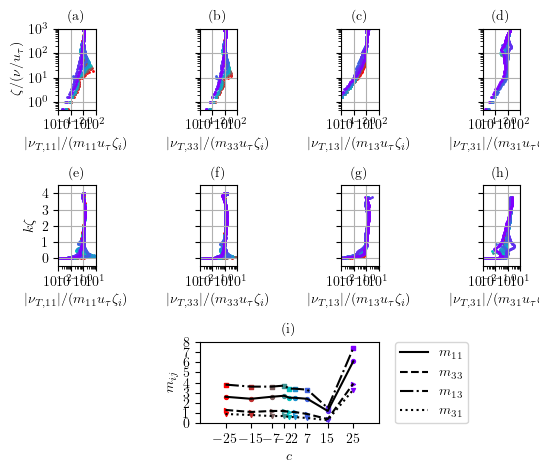

In [998]:
plt.figure(11,figsize=(5.5,6))
norm_power=0
ax1=plt.subplot(4,4,1)
nuT11_const=np.zeros((9,),dtype=float)
for num_data_select in range(9):
    arr = np.abs(LES_data[num_data_select].zw[0:-1].flatten()-120*nu/ustar)
    min_index = np.argmin(arr)
    nuT11_const[num_data_select] = np.round(np.mean(np.abs(nuT11_LES[min_index:-1,num_data_select])/(inner_layer_depth[num_data_select]/k_wavno)),1)

for num_data_select in range(9):
    plt.scatter(np.abs(nuT11_LES[0:-1,num_data_select])/(nuT11_const[num_data_select]*inner_layer_depth[num_data_select]/k_wavno), \
    (ustar/nu)*LES_data[num_data_select].zw[0:-1].flatten()/inner_layer_depth[num_data_select]**norm_power, \
    color=color_array[num_data_select],marker='o',s=1)
plt.xscale('log')
plt.yscale('log')
#plt.loglog((LES_data[num_data_select].zw[0:-1].flatten())**2,k_wavno*LES_data[num_data_select].zw[0:-1].flatten(),'k:')
#plt.loglog((LES_data[num_data_select].zw[0:-1].flatten())**1,k_wavno*LES_data[num_data_select].zw[0:-1].flatten(),'m:')
plt.xlabel(r'$|{\nu}_{T,11}|/(m_{11} u_\tau \zeta_i)$',fontsize=font_size)
plt.ylabel(r'$\zeta/(\nu/u_\tau)$')
plt.xlim(1e-4,1e2)
plt.xticks([1e-4,1e-2,1,1e2])
ax1.tick_params(labelsize=font_size)
ax1.set_title('(a)',fontsize=font_size)
if norm_power:
    plt.ylabel(r'$\zeta/\zeta_i$',fontsize=font_size)
    plt.ylim(1e-2,1e3)
    plt.yticks([1e-2,1e-1,1,1e1,1e2,1e3])
else:
    plt.ylim(5e-1,1e3)
    plt.yticks([1,1e1,1e2,1e3])

plt.grid()

ax1=plt.subplot(4,4,2)
nuT33_const=np.zeros((9,),dtype=float)
for num_data_select in range(9):
    arr = np.abs(LES_data[num_data_select].zw[0:-1].flatten()-120*nu/ustar)
    min_index = np.argmin(arr)
    nuT33_const[num_data_select] = np.round(np.mean(np.abs(nuT33_LES[min_index:-1,num_data_select])/(inner_layer_depth[num_data_select]/k_wavno)),1)

for num_data_select in range(9):
    plt.scatter(np.abs(nuT33_LES[0:-1,num_data_select])/(nuT33_const[num_data_select]*inner_layer_depth[num_data_select]/k_wavno),(ustar/nu)*LES_data[num_data_select].zw[0:-1].flatten()/inner_layer_depth[num_data_select]**norm_power, color=color_array[num_data_select],marker='o',s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$|{\nu}_{T,33}|/(m_{33}u_\tau \zeta_i)$',fontsize=font_size)
plt.ylabel('')
ax1.set_yticklabels('')
plt.xlim(1e-4,1e2)
plt.xticks([1e-4,1e-2,1,1e2])
ax1.tick_params(labelsize=font_size)
ax1.set_title('(b)',fontsize=font_size)

if norm_power:
    plt.ylim(1e-2,1e2)
    plt.yticks([1e-2,1e-2,1e-1,1,1e1,1e2])
else:
    plt.ylim(5e-1,1e3)
    plt.yticks([1,1e1,1e2,1e3])

plt.grid()

ax1=plt.subplot(4,4,3)
nuT13_const=np.zeros((9,),dtype=float)
for num_data_select in range(9):
    arr = np.abs(LES_data[num_data_select].zw[0:-1].flatten()-120*nu/ustar)
    min_index = np.argmin(arr)
    nuT13_const[num_data_select] = np.round(np.mean(np.abs(nuT13_LES[min_index:-1,num_data_select])/(inner_layer_depth[num_data_select]/k_wavno)),1)

for num_data_select in range(9):
    plt.scatter(np.abs(nuT13_LES[0:-30,num_data_select])/(nuT13_const[num_data_select]*inner_layer_depth[num_data_select]/k_wavno), \
    (ustar/nu)*LES_data[num_data_select].zw[0:-30].flatten()/inner_layer_depth[num_data_select]**norm_power, \
    color=color_array[num_data_select],marker='o',s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$|{\nu}_{T,13}|/(m_{13}u_\tau \zeta_i)$',fontsize=font_size)
ax1.set_yticklabels('')
plt.xlim(1e-4,1e2)
plt.xticks([1e-4,1e-2,1,1e2])
ax1.tick_params(labelsize=font_size)
ax1.set_title('(c)',fontsize=font_size)
if norm_power:
    plt.ylim(1e-2,1e2)
    plt.yticks([1e-2,1e-2,1e-1,1,1e1,1e2])
else:
    plt.ylim(5e-1,1e3)
    plt.yticks([1,1e1,1e2,1e3])
    
plt.grid()

ax1=plt.subplot(4,4,4)
nuT31_const=np.zeros((9,),dtype=float)
for num_data_select in range(9):
    arr = np.abs(LES_data[num_data_select].zw[0:-1].flatten()-60*nu/ustar)
    min_index = np.argmin(arr)
    nuT31_const[num_data_select] = np.round(np.mean(np.abs(nuT31_LES[min_index:-1,num_data_select])/(inner_layer_depth[num_data_select]/k_wavno)),1)

for num_data_select in range(9):
    plt.scatter(np.abs(nuT31_LES[0:-30,num_data_select])/(nuT31_const[num_data_select]*inner_layer_depth[num_data_select]/k_wavno), \
    (ustar/nu)*LES_data[num_data_select].zw[0:-30].flatten()/inner_layer_depth[num_data_select]**norm_power,\
    color=color_array[num_data_select],marker='o',s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$|{\nu}_{T,31}|/(m_{31}u_\tau \zeta_i)$',fontsize=font_size)
ax1.set_yticklabels('')
plt.xlim(1e-4,1e2)
plt.xticks([1e-4,1e-2,1,1e2])
ax1.tick_params(labelsize=font_size)
ax1.set_title('(d)',fontsize=font_size)
if norm_power:
    plt.ylim(1e-2,1e2)
    plt.yticks([1e-2,1e-2,1e-1,1,1e1,1e2])
else:
    plt.ylim(5e-1,1e3)
    plt.yticks([1,1e1,1e2,1e3])

plt.grid()

#####################################################################################################################################################################
norm_power=0
ax1=plt.subplot(4,4,5)
for num_data_select in range(9):
    plt.scatter(np.abs(nuT11_LES[0:-1,num_data_select])/(nuT11_const[num_data_select]*inner_layer_depth[num_data_select]/k_wavno), \
    (k_wavno)*LES_data[num_data_select].zw[0:-1].flatten()/inner_layer_depth[num_data_select]**norm_power, \
    color=color_array[num_data_select],marker='o',s=1)
plt.xscale('log')
plt.yscale('linear')
#plt.loglog((LES_data[num_data_select].zw[0:-1].flatten())**2,k_wavno*LES_data[num_data_select].zw[0:-1].flatten(),'k:')
#plt.loglog((LES_data[num_data_select].zw[0:-1].flatten())**1,k_wavno*LES_data[num_data_select].zw[0:-1].flatten(),'m:')
plt.xlabel(r'$|{\nu}_{T,11}|/(m_{11} u_\tau \zeta_i)$',fontsize=font_size)
plt.ylabel(r'$k\zeta$')
plt.xlim(1e-2,1e1)
plt.xticks([1e-2,1e-1,1,1e1])
ax1.tick_params(labelsize=font_size)
ax1.set_title('(e)',fontsize=font_size)
if norm_power:
    plt.ylabel(r'$\zeta/\zeta_i$',fontsize=font_size)
    plt.ylim(1e-2,1e3)
    plt.yticks([1e-2,1e-2,1e-1,1,1e1,1e2,1e3])
else:
    plt.ylim(-0.5,4.5)
    plt.yticks([0,1,2,3,4])

plt.grid()

ax1=plt.subplot(4,4,6)
for num_data_select in range(9):
    plt.scatter(np.abs(nuT33_LES[0:-1,num_data_select])/(nuT33_const[num_data_select]*inner_layer_depth[num_data_select]/k_wavno),(k_wavno)*LES_data[num_data_select].zw[0:-1].flatten()/inner_layer_depth[num_data_select]**norm_power, color=color_array[num_data_select],marker='o',s=1)
plt.xscale('log')
plt.yscale('linear')
plt.xlabel(r'$|{\nu}_{T,33}|/(m_{33}u_\tau \zeta_i)$',fontsize=font_size)
plt.ylabel('')
ax1.set_yticklabels('')
plt.xlim(1e-2,1e1)
plt.xticks([1e-2,1e-1,1,1e1])
ax1.tick_params(labelsize=font_size)
ax1.set_title('(f)',fontsize=font_size)
if norm_power:
    plt.ylim(1e-2,1e2)
    plt.yticks([1e-2,1e-2,1e-1,1,1e1,1e2])
else:
    plt.ylim(-0.5,4.5)
    plt.yticks([0,1,2,3,4])

plt.grid()

ax1=plt.subplot(4,4,7)
for num_data_select in range(9):
    plt.scatter(np.abs(nuT13_LES[0:-30,num_data_select])/(nuT13_const[num_data_select]*inner_layer_depth[num_data_select]/k_wavno), \
    (k_wavno)*LES_data[num_data_select].zw[0:-30].flatten()/inner_layer_depth[num_data_select]**norm_power, \
    color=color_array[num_data_select],marker='o',s=1)
plt.xscale('log')
plt.yscale('linear')
plt.xlabel(r'$|{\nu}_{T,13}|/(m_{13}u_\tau \zeta_i)$',fontsize=font_size)
ax1.set_yticklabels('')
plt.xlim(1e-2,1e1)
plt.xticks([1e-2,1e-1,1,1e1])
ax1.tick_params(labelsize=font_size)
ax1.set_title('(g)',fontsize=font_size)
if norm_power:
    plt.ylim(1e-2,1e2)
    plt.yticks([1e-2,1e-2,1e-1,1,1e1,1e2])
else:
    plt.ylim(-0.5,4.5)
    plt.yticks([0,1,2,3,4])

plt.grid()

ax1=plt.subplot(4,4,8)
for num_data_select in range(9):
    plt.scatter(np.abs(nuT31_LES[0:-30,num_data_select])/(nuT31_const[num_data_select]*inner_layer_depth[num_data_select]/k_wavno), \
    (k_wavno)*LES_data[num_data_select].zw[0:-30].flatten()/inner_layer_depth[num_data_select]**norm_power,\
    color=color_array[num_data_select],marker='o',s=1)
plt.xscale('log')
plt.yscale('linear')
plt.xlabel(r'$|{\nu}_{T,31}|/(m_{31}u_\tau \zeta_i)$',fontsize=font_size)
ax1.set_yticklabels('')
plt.xlim(1e-2,1e1)
plt.xticks([1e-2,1e-1,1,1e1])
ax1.tick_params(labelsize=font_size)
ax1.set_title('(h)',fontsize=font_size)
if norm_power:
    plt.ylim(1e-2,1e2)
    plt.yticks([1e-2,1e-2,1e-1,1,1e1,1e2])
else:
    plt.ylim(-0.5,4.5)
    plt.yticks([0,1,2,3,4])

plt.grid()
#####################################################################################################################################################################
# ax1=plt.subplot(4,4,10)
# plt.plot(c_array[0:-1],nuT11_const,'k')
# plt.plot(c_array[0:-1],nuT33_const,'k',linestyle='--')
# plt.plot(c_array[0:-1],nuT13_const,'k',linestyle='-.')
# plt.plot(c_array[0:-1],nuT31_const,'k',linestyle=':')
# for num_data_select in range(9):
#     plt.scatter(c_array[num_data_select],nuT11_const[num_data_select],marker='o',s=6,color=color_array[num_data_select])
#     plt.scatter(c_array[num_data_select],nuT33_const[num_data_select],marker='>',s=6,color=color_array[num_data_select])
#     plt.scatter(c_array[num_data_select],nuT13_const[num_data_select],marker='s',s=6,color=color_array[num_data_select])
#     plt.scatter(c_array[num_data_select],nuT31_const[num_data_select],marker='v',s=6,color=color_array[num_data_select])
# plt.ylim(0,6.5)
# plt.yticks([0,1,2,3,4,5,6])
# #plt.grid()


# Expanded Plot
ax1 = plt.subplot2grid((4, 4), (2, 1), colspan=2)
plt.plot(c_array[:-1], nuT11_const, 'k', label=r'$m_{11}$')
plt.plot(c_array[:-1], nuT33_const, 'k', linestyle='--', label=r'$m_{33}$')
plt.plot(c_array[:-1], nuT13_const, 'k', linestyle='-.', label=r'$m_{13}$')
plt.plot(c_array[:-1], nuT31_const, 'k', linestyle=':', label=r'$m_{31}$')

for num_data_select in range(9):
    plt.scatter(c_array[num_data_select], nuT11_const[num_data_select], marker='o', s=8, color=color_array[num_data_select])
    plt.scatter(c_array[num_data_select], nuT33_const[num_data_select], marker='>', s=8, color=color_array[num_data_select])
    plt.scatter(c_array[num_data_select], nuT13_const[num_data_select], marker='s', s=8, color=color_array[num_data_select])
    plt.scatter(c_array[num_data_select], nuT31_const[num_data_select], marker='v', s=8, color=color_array[num_data_select])

plt.ylim(0, 8)
plt.yticks([0, 1, 2, 3, 4, 5, 6,7,8])
plt.xlim(-35,35)
plt.xticks([-25,-15,-7,-2,2,7,15,25])
plt.xlabel(r'$c$', fontsize=font_size)
plt.ylabel(r'$m_{ij}$', fontsize=font_size)
plt.title('(i)', fontsize=font_size)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

#####################################################################################################################################################################

# norm_power=1
# ax1=plt.subplot(4,4,9)
# for num_data_select in range(9):
#     plt.loglog(np.abs(nuT11_LES[0:-1,num_data_select])/(2*inner_layer_depth[num_data_select]/k_wavno), \
#     k_wavno*LES_data[num_data_select].zw[0:-1].flatten()/(inner_layer_depth[num_data_select]*2)**norm_power, \
#     color=color_array[num_data_select],marker='o',markersize=1,linestyle='none')
# #plt.loglog((LES_data[num_data_select].zw[0:-1].flatten())**2,k_wavno*LES_data[num_data_select].zw[0:-1].flatten(),'k:')
# #plt.loglog((LES_data[num_data_select].zw[0:-1].flatten())**1,k_wavno*LES_data[num_data_select].zw[0:-1].flatten(),'m:')
# plt.xlabel(r'$|\hat{\nu}_{T,11}|/(2 u_\tau \zeta_i)$',fontsize=font_size)
# plt.xlim(1e-2,1e1)
# plt.xticks([1e-2,1e-1,1,1e1])
# plt.ylabel(r'$\zeta/\zeta_i$',fontsize=font_size)
# ax1.set_title('(e)',fontsize=font_size)
# plt.ylim(1e-2,1e3)
# plt.yticks([1e-2,1e-2,1e-1,1,1e1,1e2,1e3])
# ax1.tick_params(labelsize=font_size)
# plt.grid()

# ax1=plt.subplot(4,4,10)
# for num_data_select in range(9):
#     plt.loglog(np.abs(nuT33_LES[0:-1,num_data_select])/(inner_layer_depth[num_data_select]/k_wavno), \
#     k_wavno*LES_data[num_data_select].zw[0:-1].flatten()/inner_layer_depth[num_data_select]**norm_power, \
#     color=color_array[num_data_select],marker='o',markersize=1,linestyle='none')
# plt.xlabel(r'$|\hat{\nu}_{T,33}|/(u_\tau \zeta_i)$',fontsize=font_size)
# plt.ylabel('')
# ax1.set_title('(f)',fontsize=font_size)
# plt.xlim(1e-2,1e1)
# plt.xticks([1e-2,1e-1,1,1e1])
# plt.ylim(1e-2,1e3)
# plt.yticks([1e-2,1e-2,1e-1,1,1e1,1e2,1e3])
# ax1.set_yticklabels('')
# ax1.tick_params(labelsize=font_size)
# plt.grid()

# ax1=plt.subplot(4,4,11)
# for num_data_select in range(9):
#     plt.loglog(np.abs(nuT13_LES[0:-30,num_data_select])/(2*inner_layer_depth[num_data_select]/k_wavno), \
#     k_wavno*LES_data[num_data_select].zw[0:-30].flatten()/inner_layer_depth[num_data_select]**norm_power, \
#     color=color_array[num_data_select],marker='o',markersize=1,linestyle='none')
# plt.xlabel(r'$|\hat{\nu}_{T,13}|/(2u_\tau\zeta_i)$',fontsize=font_size)
# plt.xlim(1e-2,1e1)
# plt.xticks([1e-2,1e-1,1,1e1])
# plt.ylim(1e-2,1e3)
# plt.yticks([1e-2,1e-2,1e-1,1,1e1,1e2,1e3])
# ax1.set_yticklabels('')
# ax1.set_title('(g)',fontsize=font_size)
# ax1.tick_params(labelsize=font_size)
# plt.grid()

# ax1=plt.subplot(4,4,12)
# for num_data_select in range(9):
#     plt.loglog(np.abs(nuT31_LES[0:-30:2,num_data_select])/(0.5*inner_layer_depth[num_data_select]/k_wavno), \
#     k_wavno*LES_data[num_data_select].zw[0:-30:2].flatten()/inner_layer_depth[num_data_select]**norm_power, \
#     color=color_array[num_data_select],marker='o',markersize=1,linestyle='none')
# plt.xlabel(r'$|\hat{\nu}_{T,31}|/(0.5u_\tau \zeta_i)$',fontsize=font_size)
# plt.xlim(1e-2,1e1)
# plt.xticks([1e-2,1e-1,1,1e1])
# plt.ylim(1e-2,1e3)
# plt.yticks([1e-2,1e-2,1e-1,1,1e1,1e2,1e3])
# ax1.set_yticklabels('')
# ax1.set_title('(h)',fontsize=font_size)
# ax1.tick_params(labelsize=font_size)
# plt.grid()

plt.savefig('nuTij_magnitude_profile_scaling.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

plt.show()



In [962]:
nuT11_const,nuT33_const

(array([2.77777778, 2.79753086, 2.84170096, 2.86855662, 2.88728514,
        2.93031682, 2.9781298 , 3.04236644, 3.24707382]),
 array([1.3, 1.1, 1.2, 1.2, 1.1, 1.1, 0.9, 0.4, 3.9]))

In [ ]:
from scipy.interpolate import Rbf
from scipy.misc import derivative
plt.figure(11,figsize=(12,24))

counter=1
for num_data_select in range(9):
    w_hat_LES = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)

    tau11_hat_LES = np.fft.fft(LES_data[num_data_select].tau11_d+LES_data[num_data_select].tau11_d_SGS,axis=0,norm='forward')
    tau13_hat_LES = np.fft.fft(LES_data[num_data_select].tau13  +LES_data[num_data_select].tau13_SGS,axis=0,norm='forward')
    tau31_hat_LES = np.fft.fft(LES_data[num_data_select].tau31  +LES_data[num_data_select].tau31_SGS,axis=0,norm='forward')
    tau33_hat_LES = np.fft.fft(LES_data[num_data_select].tau33_d+LES_data[num_data_select].tau33_d_SGS,axis=0,norm='forward')

    nuT11_LES[0:-1,num_data_select] = (tau11_hat_LES[16,0:-1]/(2*dwdz_hat_LES))
    nuT13_LES[0:-1,num_data_select] = (tau13_hat_LES[16,0:-1]/(-(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) -U_prime_LES*(1/zi)*(a/2)))
    nuT31_LES[0:-1,num_data_select] = (tau31_hat_LES[16,0:-1]/(-(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1])))
    nuT33_LES[0:-1,num_data_select] = (tau33_hat_LES[16,0:-1]/(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES))

    nuT11_interp_rbf_func = Rbf(LES_data[num_data_select].zw[0:-1], nuT11_LES[0:-1,num_data_select], function='linear')  # Try 'multiquadric' or 'cubic' for different behaviors
    nuT11_interp_rbf = nuT11_interp_rbf_func(z)
    
    ax1=plt.subplot(9,4,counter)
    plt.semilogy(np.gradient(np.real(nuT11_LES[0:-1,num_data_select]),LES_data[num_data_select].zw[0:-1].flatten(),edge_order=2),k_wavno*LES_data[num_data_select].zw[0:-1]/inner_layer_depth[num_data_select],color=color_array[num_data_select])
    plt.semilogy(np.gradient(np.real(nuT11_interp_rbf),z,edge_order=2),k_wavno*z/inner_layer_depth[num_data_select],'b--')
    #plt.semilogy(np.real(nuT11_interp[:,num_data_select]),k_wavno*z/inner_layer_depth[num_data_select],'m--')
    ax1.set_ylim(1,4)
    
    ax1=plt.subplot(9,4,counter+1)
    plt.semilogy(np.imag(nuT11_LES[0:-1,num_data_select]),k_wavno*LES_data[num_data_select].zw[0:-1]/inner_layer_depth[num_data_select],color=color_array[num_data_select])
    plt.semilogy(np.imag(nuT11_interp_rbf),k_wavno*z/inner_layer_depth[num_data_select],'b--')
    #plt.semilogy(np.imag(nuT11_interp[:,num_data_select]),k_wavno*z/inner_layer_depth[num_data_select],'m--')
    ax1.set_ylim(1,4)
   
    ax1=plt.subplot(9,4,counter+2)
    plt.loglog(np.abs(nuT11_LES[0:-1,num_data_select]),k_wavno*LES_data[num_data_select].zw[0:-1]/inner_layer_depth[num_data_select],color=color_array[num_data_select])
    plt.loglog(np.abs(nuT11_interp_rbf),k_wavno*z/inner_layer_depth[num_data_select],'b--')
    #plt.loglog(np.abs(nuT11_interp[:,num_data_select]),k_wavno*z/inner_layer_depth[num_data_select],'m--')
    ax1.set_ylim(1,4)
   
    ax1=plt.subplot(9,4,counter+3)
    angle=np.arctan2(nuT11_LES[0:-1,num_data_select].imag,nuT11_LES[0:-1,num_data_select].real)
    plt.semilogy(angle,k_wavno*LES_data[num_data_select].zw[0:-1]/inner_layer_depth[num_data_select],color=color_array[num_data_select])
    ax1.set_ylim(1,4)
   
    counter+=4
    

plt.show()

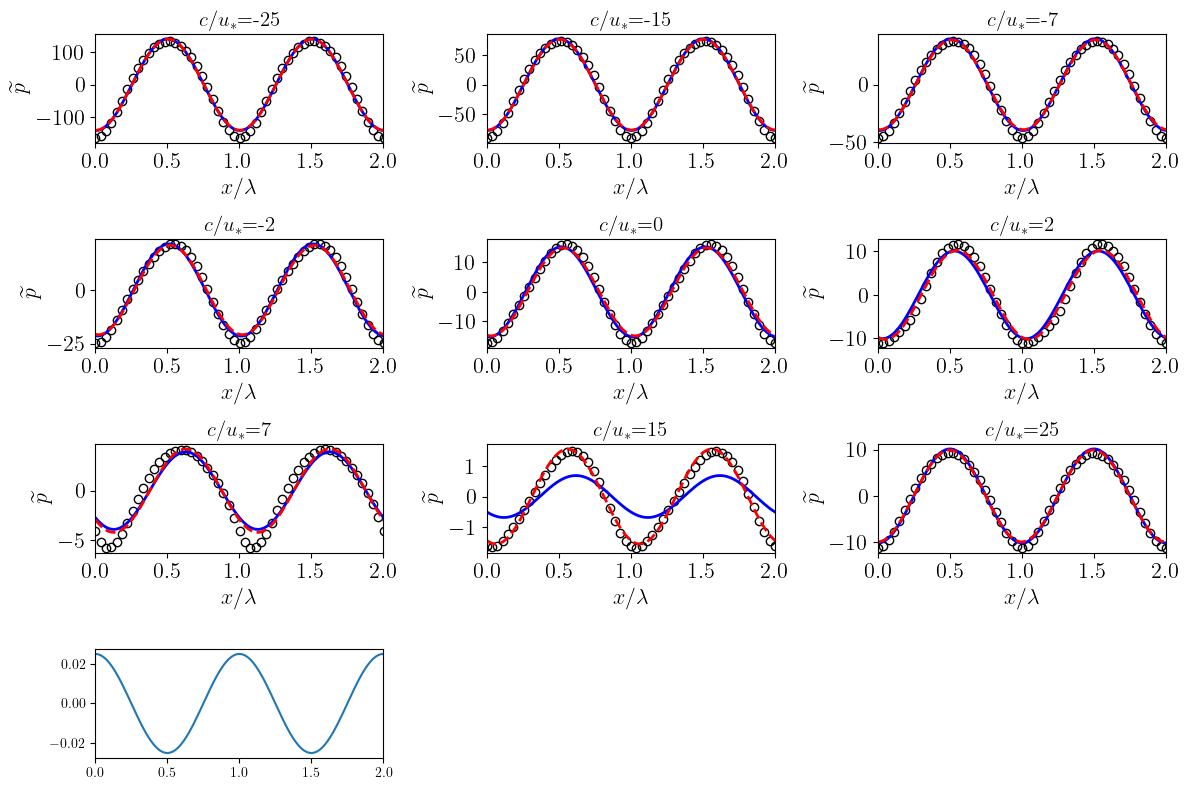

In [450]:
plt.figure(11,figsize=(12,8))
wavelength=2*np.pi/k_wavno
for num_data_select in range(9):
    ax1=plt.subplot(4,3,num_data_select+1)
    phase_diff=np.pi/2*0;
    ax1.plot(x[::2]/wavelength, LES_data[num_data_select].p_w_surf[::2]-np.mean(LES_data[num_data_select].p_w_surf[::2]),'ok',markerfacecolor='none',label='LES')

    for n in n_num_array_index:
        ax1.plot(x/wavelength, 2*Rep[0,3,n,num_data_select]*np.cos(k_wavno*x+phase_diff)*1-1*2*Imp[0,3,n,num_data_select]*np.sin(k_wavno*x+phase_diff),color_array_plot[n],label=r'$2Re\{\hat{p}\}\cos (k\xi)-2Im\{\hat{p}\}\sin (k\xi)$ (TurbCurv)',linewidth=2)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$\widetilde{p}$',fontsize=16)
    ax1.set_xlabel(r'$x/\lambda$',fontsize=16)
    ax1.tick_params(labelsize=16)
    ax1.set_xlim(0,2)
    
ax1=plt.subplot(4,3,10)
ax1.plot(x_LES/wavelength,y)
ax1.set_xlim(0,2)

plt.show()
    

plt.savefig('p_surface_WRLES_vs_Model.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

0 0 32.74553280676372 0.1844224916802676
0 1 32.918231639282105 0.23337973915417326
1 0 33.32522429794194 0.18661027088306345
1 1 33.63762243841062 0.24890880122178655
2 0 33.6064559640625 0.18184138743871614
2 1 34.21753414698175 0.25148396674951917
3 0 35.048683806343575 0.17054194428249214
3 1 35.88379627510337 0.24536863083061966
4 0 55.70145006329531 0.17545848440776124
4 1 56.561825728301315 0.24928725543315863
5 0 38.29842194578331 0.2883070971651684
5 1 38.26793143009397 0.28170431599344736
6 0 43.67534435573828 0.614072102264185
6 1 41.34115829098036 0.4095910537685209
7 0 71.72491702928029 0.8244537965245107
7 1 41.49293413102185 0.32093438779007
8 0 37.254886179341575 0.35958383681309913
8 1 36.348410221996566 0.3131667789343291


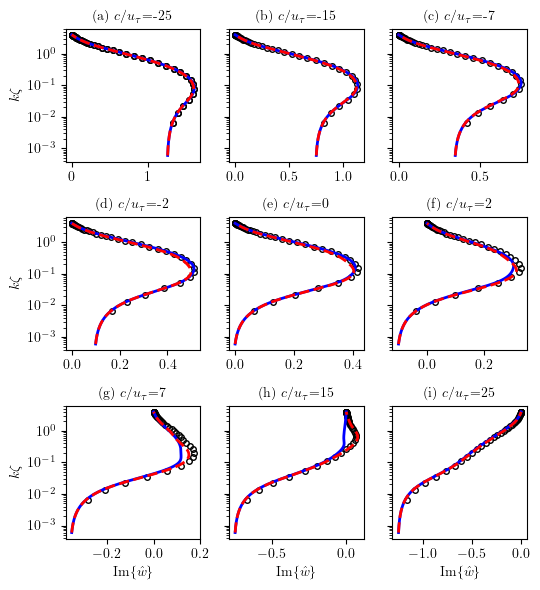

In [457]:
plt.figure(11,figsize=(5.5,6))
font_size=10
for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)

    w_LES_data = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    plt.semilogy(w_LES_data[16,::3].imag,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none',label='LES',markersize=4)
    
    for n in n_num_array_index:
        w_imag_interp = CubicSpline(LES_data[num_data_select].zw[0:-1].flatten(),w_LES_data[16,0:-1].imag)
        w_imag_interp_profile = w_imag_interp(z)
        mape_imw = mape(w_imag_interp_profile,Imw[:,n,num_data_select])
        norm_imw = np.linalg.norm(w_imag_interp_profile-Imw[:,n,num_data_select])
        
        print(num_data_select,n,mape_imw,norm_imw)
        plt.semilogy(Imw[:,n,num_data_select].real, k_wavno*z, color_array_plot_Im[n], 
             linewidth=2, label=rf'$\epsilon_{{\mathrm{{Im}}\{{\hat{{w}}\}}}} = {mape_imw:.0f}$')

        #plt.semilogy(w_imag_interp_profile ,k_wavno*z,color_array_plot_Im[n],linewidth=2)
   
    if num_data_select >= 6:  
        ax1.set_xlabel(r'Im$\{\hat{w}\}$',fontsize=font_size)
    if num_data_select == 0 or num_data_select == 3 or num_data_select == 6:  
        ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    else:
        ax1.set_yticklabels('')
    ax1.tick_params(labelsize=font_size)
    ax1.set_title(f'({chr(97 + num_data_select)}) $c/u_\\tau$={c_array[num_data_select]}', fontsize=font_size)
    #plt.grid(True)    #plt.legend(loc='lower right',fontsize=font_size)

plt.savefig('Imw_profile_apriori.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()

0 0 92.165288654046 33.63493022499154
0 1 92.33103616757691 33.646385722745975
0 4 91.07236909339763 33.56234637873737
0 5 88.99014135139839 33.527077896736806
3 0 99.95152765999595 40.395234521939315
3 1 99.48264981065653 40.22600136721159
3 4 101.0302457042044 40.81817124004556
3 5 101.15170524661154 40.78466328957185
5 0 98.05073715821901 7.397658671234436
5 1 95.9384836424988 7.005522144121298
5 4 102.30088224715641 8.226164609412244
5 5 102.53676466412995 8.147289234244122
8 0 101.44707820855552 4.8144776737552855
8 1 100.54440147930335 4.737303805428792
8 4 97.59508011666071 4.290214279671904
8 5 97.34811037051071 4.424556959765063


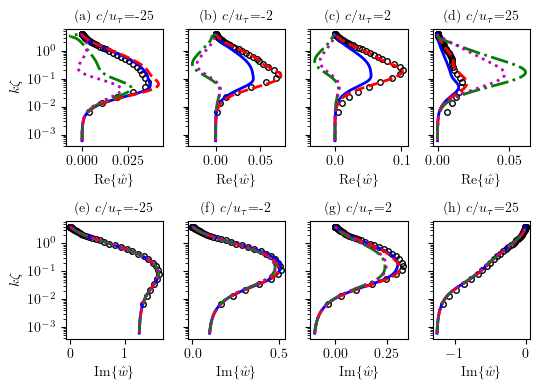

In [507]:
plt.figure(11,figsize=(5.5,4))
font_size=10
counter=1
for num_data_select in [0,3,5,8]:
    ax1=plt.subplot(2,4,counter)


    w_LES_data = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    plt.semilogy(w_LES_data[16,::3].real,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none',label='LES',markersize=4)
    
    for n in n_num_array_index:
        w_real_interp = CubicSpline(LES_data[num_data_select].zw[0:-1].flatten(),w_LES_data[16,0:-1].real)
        w_real_interp_profile = w_imag_interp(z)
        mape_Rew = mape(w_real_interp_profile,Rew[:,n,num_data_select])
        norm_Rew = np.linalg.norm(w_real_interp_profile-Rew[:,n,num_data_select])
        
        print(num_data_select,n,mape_Rew,norm_Rew)
        
        
        plt.semilogy(Rew[:,n,num_data_select].real, k_wavno*z, color_array_plot_Im[n], 
             linewidth=2, label=rf'$\epsilon_{{\mathrm{{Re}}\{{\hat{{w}}\}}}} = {mape_imw:.0f}$')
        ax1.set_xlabel(r'Re$\{\hat{w}\}$',fontsize=font_size)
    
    if counter == 1 or counter == 5:  
        ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    else:
        ax1.set_yticklabels('')
    ax1.tick_params(labelsize=font_size)
    ax1.set_title(f'({chr(97 + counter-1)}) $c/u_\\tau$={c_array[num_data_select]}', fontsize=font_size)

    ax1=plt.subplot(2,4,counter+4)

    w_LES_data = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    plt.semilogy(w_LES_data[16,::3].imag,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none',label='LES',markersize=4)
    
    for n in n_num_array_index:
        w_imag_interp = CubicSpline(LES_data[num_data_select].zw[0:-1].flatten(),w_LES_data[16,0:-1].imag)
        w_imag_interp_profile = w_imag_interp(z)
        mape_imw = mape(w_imag_interp_profile,Imw[:,n,num_data_select])

        plt.semilogy(Imw[:,n,num_data_select].real, k_wavno*z, color_array_plot_Im[n], 
             linewidth=2, label=rf'$\epsilon_{{\mathrm{{Im}}\{{\hat{{w}}\}}}} = {mape_imw:.0f}$')
        ax1.set_xlabel(r'Im$\{\hat{w}\}$',fontsize=font_size)
    
    
    if counter == 1 or counter == 5:  
        ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    else:
        ax1.set_yticklabels('')
    ax1.tick_params(labelsize=font_size)
    ax1.set_title(f'({chr(97 + counter-1+4)}) $c/u_\\tau$={c_array[num_data_select]}', fontsize=font_size)
    #plt.grid(True)    #plt.legend(loc='lower right',fontsize=font_size)
    counter=counter+1
plt.savefig('Rew_Imw_profile_nuT_2x4.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()

0 0 33.63493022499154
0 1 33.646385722745975
1 0 33.61751545487181
1 1 33.64082664047379
2 0 33.60976498226087
2 1 33.65803453484149
3 0 33.61581139061833
3 1 33.703483082007516
4 0 33.62496162768113
4 1 33.735120817216554
5 0 33.64435877947051
5 1 33.7653369528888
6 0 33.8257695845363
6 1 33.80745308867461
7 0 33.540386128824174
7 1 33.57486767608061
8 0 33.51444080667666
8 1 33.53708341872666


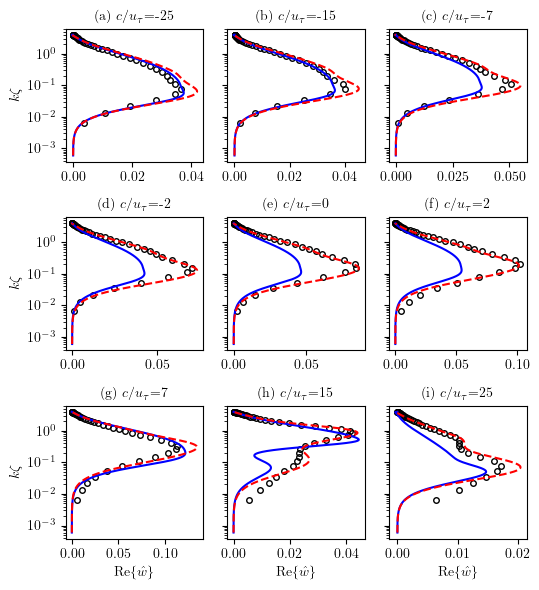

In [460]:
plt.figure(11,figsize=(5.5,6))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    w_LES_data = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    plt.semilogy(w_LES_data[16,::3].real,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none',label=r'$\Re\{\hat{w}\}$ (LES)',markersize=4)
    #plt.semilogy(w_LES_data[16,::3].real,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none')
    
    for n in n_num_array_index:
        w_real_interp = CubicSpline(LES_data[num_data_select].zw[0:-1].flatten(),w_LES_data[16,0:-1].real)
        w_real_interp_profile = w_imag_interp(z)
        mape_Rew = mape(w_real_interp_profile,Rew[:,n,num_data_select])
        norm_Rew = np.linalg.norm(w_real_interp_profile-Rew[:,n,num_data_select])
        
        print(num_data_select,n,norm_Rew)
        
        plt.semilogy(Rew[:,n,num_data_select].real,k_wavno*z,color_array_plot_Im[n])

    if num_data_select >= 6:  
        ax1.set_xlabel(r'Re$\{\hat{w}\}$',fontsize=font_size)
    if num_data_select == 0 or num_data_select == 3 or num_data_select == 6:  
        ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    else:
        ax1.set_yticklabels('')
    ax1.tick_params(labelsize=font_size)
    ax1.set_title(f'({chr(97 + num_data_select)}) $c/u_\\tau$={c_array[num_data_select]}', fontsize=font_size)
    #plt.grid(True)

plt.savefig('Rew_profile_apriori.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()


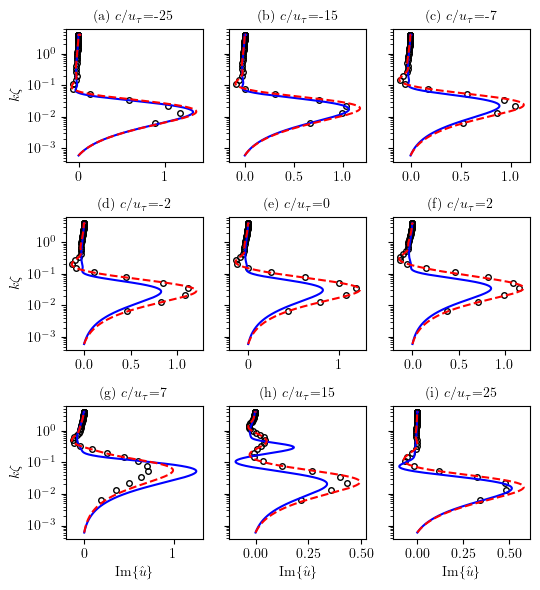

In [48]:
plt.figure(11,figsize=(5.5,6))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    
    u_LES_data = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    plt.semilogy(u_LES_data[16,::3].imag,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none',label='$\Im\{\hat{w}\}$ (LES)',markersize=4)
    
    
    for n in n_num_array_index:
        plt.semilogy(Imu[:,n,num_data_select].real,k_wavno*z,color_array_plot_Im[n],label='$\Im\{\hat{w}\}$ (Model)')
    
    
    
    if num_data_select >= 6:  
        ax1.set_xlabel(r'Im$\{\hat{u}\}$',fontsize=font_size)
    if num_data_select == 0 or num_data_select == 3 or num_data_select == 6:  
        ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    else:
        ax1.set_yticklabels('')
    ax1.tick_params(labelsize=font_size)
    ax1.set_title(f'({chr(97 + num_data_select)}) $c/u_\\tau$={c_array[num_data_select]}', fontsize=font_size)
    #plt.grid(True)

plt.savefig('Imu_profile_apriori.png',format='png',dpi=600,bbox_inches='tight', \
            transparent=False,pad_inches=0.01)
plt.show()   


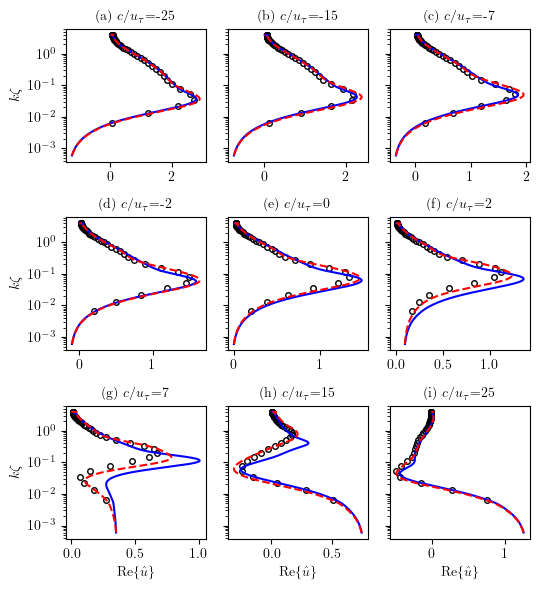

In [49]:
plt.figure(11,figsize=(5.5,6))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    
    u_LES_data = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    plt.semilogy(u_LES_data[16,::3].real,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none',label='$\Im\{\hat{w}\}$ (LES)',markersize=4)
    
    
    for n in n_num_array_index:
        plt.semilogy(Reu[:,n,num_data_select].real,k_wavno*z,color_array_plot_Im[n],label='$\Im\{\hat{w}\}$ (Model)')
    
    
    
    if num_data_select >= 6:  
        ax1.set_xlabel(r'Re$\{\hat{u}\}$',fontsize=font_size)
    if num_data_select == 0 or num_data_select == 3 or num_data_select == 6:  
        ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    else:
        ax1.set_yticklabels('')
    ax1.tick_params(labelsize=font_size)
    ax1.set_title(f'({chr(97 + num_data_select)}) $c/u_\\tau$={c_array[num_data_select]}', fontsize=font_size)
    #plt.grid(True)

plt.savefig('Reu_profile_apriori.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()

#plt.savefig('Reu_profile_WRLES_vs_Model.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)

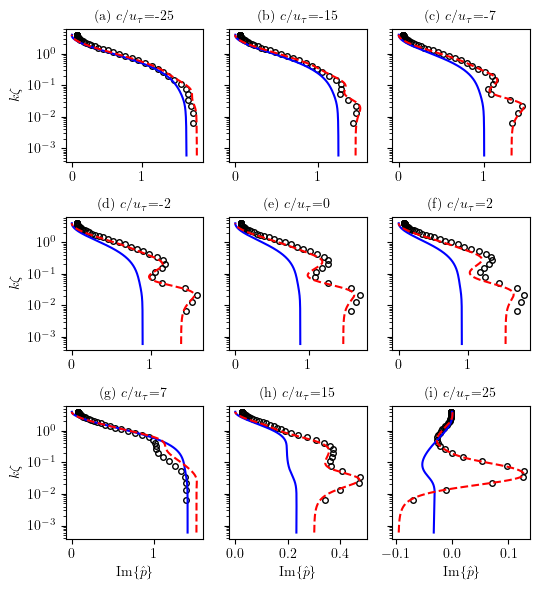

In [50]:
plt.figure(11,figsize=(5.5,6))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    
    p_LES_data = np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')
    #plt.semilogy(p_LES_data[16,:].real,k*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    plt.semilogy(p_LES_data[16,::3].imag,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none',markersize=4)
   
    for n in n_num_array_index:
        plt.semilogy(Imp[:,3,n,num_data_select].real,k_wavno*z,color_array_plot_Im[n])
        
    if num_data_select >= 6:  
        ax1.set_xlabel(r'Im$\{\hat{p}\}$',fontsize=font_size)
    if num_data_select == 0 or num_data_select == 3 or num_data_select == 6:  
        ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    else:
        ax1.set_yticklabels('')
    ax1.tick_params(labelsize=font_size)
    ax1.set_title(f'({chr(97 + num_data_select)}) $c/u_\\tau$={c_array[num_data_select]}', fontsize=font_size)
    #plt.grid(True)
plt.savefig('Imp_profile_apriori.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()
#plt.savefig('Imp_profile_WRLES_vs_Model.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)

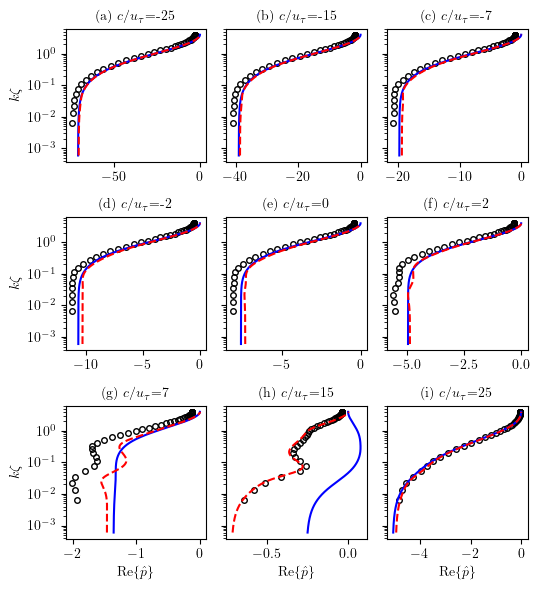

In [51]:
plt.figure(11,figsize=(5.5,6))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    
    p_LES_data = np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')
    plt.semilogy(p_LES_data[16,::3].real,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none',markersize=4)

    for n in n_num_array_index:
        plt.semilogy(Rep[:,3,n,num_data_select].real,k_wavno*z,color_array_plot_Im[n])
        
    if num_data_select >= 6:  
        ax1.set_xlabel(r'Re$\{\hat{p}\}$',fontsize=font_size)
    if num_data_select == 0 or num_data_select == 3 or num_data_select == 6:  
        ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
    else:
        ax1.set_yticklabels('')
    ax1.tick_params(labelsize=font_size)
    ax1.set_title(f'({chr(97 + num_data_select)}) $c/u_\\tau$={c_array[num_data_select]}', fontsize=font_size)
    #plt.grid(True)
plt.savefig('Rep_profile_apriori.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()


\begin{align*}
F_p=\frac{1}{\lambda}\int_{0}^{\lambda}\frac{\widetilde{p}}{\rho_a u_\tau^2}\frac{d\widetilde{\eta}}{dx} \ dx
\end{align*}

In [284]:
Fp=np.zeros((9,5),dtype='float')
wavelength=2*np.pi/k_wavno
detadx=-a*k_wavno*np.sin(k_wavno*x_LES)
for num_data_select in range(9):
    phase_diff=0
    p_induced_visc = 2*Rep[0,3,0,num_data_select]*np.cos(k_wavno*x_LES+phase_diff)*1-1*2*Imp[0,3,0,num_data_select]*np.sin(k_wavno*x_LES+phase_diff)
    p_induced = 2*Rep[0,3,1,num_data_select]*np.cos(k_wavno*x_LES+phase_diff)*1-1*2*Imp[0,3,1,num_data_select]*np.sin(k_wavno*x_LES+phase_diff)
    p_induced_nuT   = 2*Rep[0,3,2,num_data_select]*np.cos(k_wavno*x_LES+phase_diff)*1-1*2*Imp[0,3,2,num_data_select]*np.sin(k_wavno*x_LES+phase_diff)
    p_induced_nuT_2 = 2*Rep[0,3,3,num_data_select]*np.cos(k_wavno*x_LES+phase_diff)*1-1*2*Imp[0,3,3,num_data_select]*np.sin(k_wavno*x_LES+phase_diff)
    
    Fp[num_data_select,1]=(1/wavelength)*np.trapz(p_induced[0:55]*detadx[0:55],x_LES[0:55])#Turb Curv with interpolated stress
    Fp[num_data_select,2]=(1/wavelength)*np.trapz(p_induced_visc[0:55]*detadx[0:55],x_LES[0:55])#Visc Curv
    Fp[num_data_select,3]=(1/wavelength)*np.trapz(p_induced_nuT[0:55]*detadx[0:55],x_LES[0:55])#Turb Curv with modeled-1 stress
    Fp[num_data_select,4]=(1/wavelength)*np.trapz(p_induced_nuT_2[0:55]*detadx[0:55],x_LES[0:55])#Turb Curv with modeled-2 stress
   
    Fp[num_data_select,0]=(1/wavelength)*np.trapz(LES_data[num_data_select].p_w_surf[0:55]*detadx[0:55],x_LES[0:55])#LES

/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/641282676.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  Fp[num_data_select,1]=(1/wavelength)*np.trapz(p_induced[0:55]*detadx[0:55],x_LES[0:55])#Turb Curv with interpolated stress
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/641282676.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  Fp[num_data_select,2]=(1/wavelength)*np.trapz(p_induced_visc[0:55]*detadx[0:55],x_LES[0:55])#Visc Curv
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/641282676.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  Fp[num_data_select,3]=(1/wavelength)*np.trapz(p_induced_nuT[0:55]*detadx[0:55],x_LES[0:55])#Turb Curv with modeled-1 stress
/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/641282676.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  Fp[num_data_se

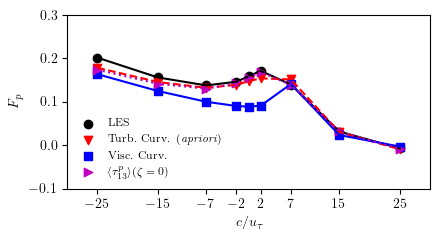

In [754]:
plt.figure(11,figsize=(4.5,2.5))
ax1=plt.subplot(1,1,1)

plt.scatter(c_array[0:-1],Fp[:,0],color='k',label='LES')
plt.scatter(c_array[0:-1],Fp[:,1],color='r',marker='v',label='Turb. Curv. (\emph{apriori})')
plt.scatter(c_array[0:-1],Fp[:,2],color='b',marker='s',label='Visc. Curv.')
plt.scatter(c_array[0:-1],-taup13_mean_surf[:],color='m',marker='>',label=r'$\langle\tau_{13}^p\rangle(\zeta=0)$')


#plt.scatter(c_array[0:-1],Fp[:,3],color='g',marker='o',label='$\\nu_T=u_* \\kappa \\zeta (1-e^{-\\frac{\\zeta Re_\\tau}{25}})$')
#plt.scatter(c_array[0:-1],Fp[:,4],color='m',marker='s',label='$\\nu_T=u_* \\kappa \\zeta (1-e^{-\\frac{\\zeta Re_\\tau}{25}}) e^{-5 k\\zeta}$')

plt.legend(frameon=False,fontsize=8)

plt.plot(c_array[0:-1],Fp[:,0],color='k')
plt.plot(c_array[0:-1],Fp[:,1],color='r',linestyle='--')
plt.plot(c_array[0:-1],Fp[:,2],color='b',linestyle='-')
plt.plot(c_array[0:-1],-taup13_mean_surf[:],color='m',linestyle=':')


#plt.plot(c_array[0:-1],Fp[:,3],color='g',linestyle='-.')
#plt.plot(c_array[0:-1],Fp[:,4],color='m',linestyle=':')


ax1.set_xlabel(r'$c/u_\tau$',fontsize=10)
ax1.set_ylim(-0.1,0.3)
ax1.set_xlim(-30,30)
ax1.set_xticks([-25, -15, -7, -2, 2, 7, 15, 25])
#ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
ax1.set_ylabel(r'$F_p$',fontsize=10)
ax1.tick_params(labelsize=10)

# ax1=plt.subplot(2,1,2)
# num_data_select=0;
# plt.plot(x_LES,LES_data[num_data_select].p_w_surf-np.mean(LES_data[num_data_select].p_w_surf),'k',label='LES')
# plt.plot(x_LES,2*Rep[0,3,0,num_data_select]*np.cos(k_wavno*x_LES)*1-1*2*Imp[0,3,0,num_data_select]*np.sin(k_wavno*x_LES+phase_diff),'m',label='Visc. Curv. Model')
# plt.plot(x_LES,2*Rep[0,3,1,num_data_select]*np.cos(k_wavno*x_LES)*1-1*2*Imp[0,3,1,num_data_select]*np.sin(k_wavno*x_LES+phase_diff),'b--',label='Turb. Curv. Model')
# #plt.legend()

plt.savefig('form_drag_apriori.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

#plt.savefig('form_drag_LES.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)
plt.show()

In [246]:
mape_Turb_Curv_LES=mape(Fp[:,0], Fp[:,1])#Red
mape_Turb_Curv_nuT_1=mape(Fp[:,0], Fp[:,3])#Green
mape_Turb_Curv_nuT_2=mape(Fp[:,0], Fp[:,4])#Magenta
mape_Visc_Curv=mape(Fp[:,0], Fp[:,2])#Blue
print(mape_Turb_Curv_LES,mape_Turb_Curv_nuT_1,mape_Turb_Curv_nuT_2,mape_Visc_Curv)

9.47355503761996 90.96674118561968 64.62465674619794 30.815379945884345


In [ ]:
c_array

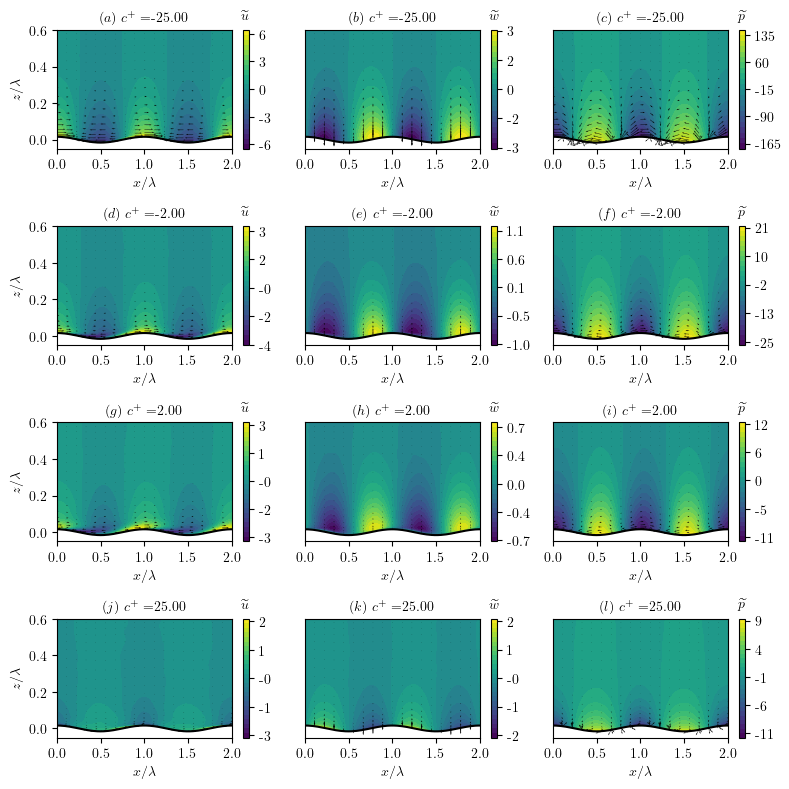

In [517]:
plt.figure(11, figsize=(8,8))
font_size=10
counter = 1
num_levels = 25
wavelength = 2*np.pi/k_wavno
for num_data_select in [0,3,5,8]:
    z_phys_LES = np.zeros((Nx, Nz), dtype='float')
    x_phys_LES = np.zeros((Nx, Nz), dtype='float')
    
    for i in range(Nx):
        zeta_LES = LES_data[num_data_select].zw.flatten()
        z_phys_LES[i, :] = zeta_LES - (zeta_LES/zi - 1) * a * np.cos(k_wavno * x_LES[i])
        x_phys_LES[i, :] = x_LES[i]

    # u subplot
    ax1 = plt.subplot(4, 3, counter)
    c = plt.contourf(x_phys_LES/wavelength, z_phys_LES/wavelength, LES_data[num_data_select].u_w, num_levels, cmap='viridis')
    plt.plot(x_LES/wavelength, a*np.cos(k_wavno*x_LES)/wavelength, 'k')
    #plt.title(r'$c/u_*=$' + f'{c_array[num_data_select]:.2f} (Model)', fontsize=15)
    plt.title(r'$(' + chr(97 + counter - 1) + r') \ c^+=$' + f'{c_array[num_data_select]:.2f}', fontsize=font_size)
    #quiver plot
    step = 6
    x_quiver = x_phys_LES[::step, ::step] / wavelength
    z_quiver = z_phys_LES[::step, ::step] / wavelength
    u_quiver = LES_data[num_data_select].u_w[::step, ::step]
    w_quiver = LES_data[num_data_select].w[::step, ::step]
    
    plt.quiver(x_quiver, z_quiver, u_quiver, 0*w_quiver,scale=70)
    cbar = plt.colorbar(c)
    ticks = np.linspace(np.min(LES_data[num_data_select].u_w), np.max(LES_data[num_data_select].u_w), num=5)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{tick:.0f}" for tick in ticks])
    cbar.ax.tick_params(labelsize=font_size)  # Set colorbar tick font size
    #cbar.ax.set_ylabel(r'$\widetilde{w}$', fontsize=15)
    plt.text(2.1, 0.66, r'$\widetilde{u}$', fontsize=font_size, color='black')

    plt.xlim(0, 2)
    plt.ylim(-0.05, 0.6)
    plt.xlabel(r'$x/\lambda$', fontsize=font_size)
    plt.ylabel(r'$z/\lambda$', fontsize=font_size)

    plt.xticks(np.arange(0,2.5,0.5) ,fontsize=font_size)
    plt.yticks(fontsize=font_size)

    # w subplot
    ax1 = plt.subplot(4, 3, counter + 1)
    c = plt.contourf(x_phys_LES[:, :-1]/wavelength, z_phys_LES[:, :-1]/wavelength, LES_data[num_data_select].w[:, :-1], num_levels, cmap='viridis')
    plt.plot(x_LES/wavelength, a*np.cos(k_wavno*x_LES)/wavelength, 'k')
    #plt.title(r'$c/u_*=$' + f'{c_array[num_data_select]:.2f} (LES)', fontsize=15)
    plt.title(r'$(' + chr(97 + counter ) + r') \ c^+=$' + f'{c_array[num_data_select]:.2f}', fontsize=font_size)

    #quiver plot
    step = 6
    x_quiver = x_phys_LES[::step, ::step] / wavelength
    z_quiver = z_phys_LES[::step, ::step] / wavelength
    u_quiver = LES_data[num_data_select].u_w[::step, ::step]
    w_quiver = LES_data[num_data_select].w[::step, ::step]
    
    plt.quiver(x_quiver, z_quiver, 0*u_quiver, w_quiver,scale=70)

    cbar = plt.colorbar(c)
    ticks = np.linspace(np.min(LES_data[num_data_select].w[:, :-1]), np.max(LES_data[num_data_select].w[:, :-1]), num=5)
    cbar.set_ticks(ticks)
    if num_data_select == 3 or num_data_select == 5:
        cbar.set_ticklabels([f"{tick:.1f}" for tick in ticks])
    else:
        cbar.set_ticklabels([f"{tick:.0f}" for tick in ticks])

    cbar.ax.tick_params(labelsize=font_size)  # Set colorbar tick font size
    #cbar.set_label(r'$\widetilde{w}$', loc='top',fontsize=15)
    plt.text(2.1, 0.66, r'$\widetilde{w}$', fontsize=font_size, color='black')

    
    plt.xlim(0, 2)
    plt.ylim(-0.05, 0.6)
    plt.xlabel(r'$x/\lambda$', fontsize=font_size)
    #plt.ylabel(r'$z/\lambda$', fontsize=15)
    ax1.set_yticks([])
    plt.xticks(np.arange(0,2.5,0.5) ,fontsize=font_size)
    plt.yticks(fontsize=font_size)

    # p subplot
    ax1 = plt.subplot(4, 3, counter + 2)
    c = plt.contourf(x_phys_LES[:, :-1]/wavelength, z_phys_LES[:, :-1]/wavelength, LES_data[num_data_select].p_w_tilde[:, :-1], num_levels, cmap='viridis')
    plt.plot(x_LES/wavelength, a*np.cos(k_wavno*x_LES)/wavelength, 'k')
    #plt.title(r'$c/u_*=$' + f'{c_array[num_data_select]:.2f} (LES)', fontsize=15)
    plt.title(r'$(' + chr(97 + counter +1 ) + r') \ c^+=$' + f'{c_array[num_data_select]:.2f}', fontsize=font_size)

    
    #quiver plot
    # Subsample the data (adjust the step as needed)
    step = 6
    x_quiver = x_phys_LES[::step, ::step] / wavelength
    z_quiver = z_phys_LES[::step, ::step] / wavelength
    u_quiver = LES_data[num_data_select].u_w[::step, ::step]
    w_quiver = LES_data[num_data_select].w[::step, ::step]
    
    plt.quiver(x_quiver, z_quiver, u_quiver, w_quiver,scale=70)

    cbar = plt.colorbar(c)
    ticks = np.linspace(np.min(LES_data[num_data_select].p_w_tilde[:, :-1]), np.max(LES_data[num_data_select].p_w_tilde[:, :-1]), num=5)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{tick:.0f}" for tick in ticks])
    cbar.ax.tick_params(labelsize=font_size)  # Set colorbar tick font size
    #cbar.set_label(r'$\widetilde{w}$', loc='top',fontsize=15)
    plt.text(2.1, 0.66, r'$\widetilde{p}$', fontsize=font_size, color='black')

    
    plt.xlim(0, 2)
    plt.ylim(-0.05, 0.6)
    plt.xlabel(r'$x/\lambda$', fontsize=font_size)
    #plt.ylabel(r'$z/\lambda$', fontsize=15)
    ax1.set_yticks([])
    plt.xticks(np.arange(0,2.5,0.5) ,fontsize=font_size)
    plt.yticks(fontsize=font_size)

    counter += 3

plt.savefig('uwp_contour_LES.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

plt.show()


$z=\zeta-g(\zeta)\eta$

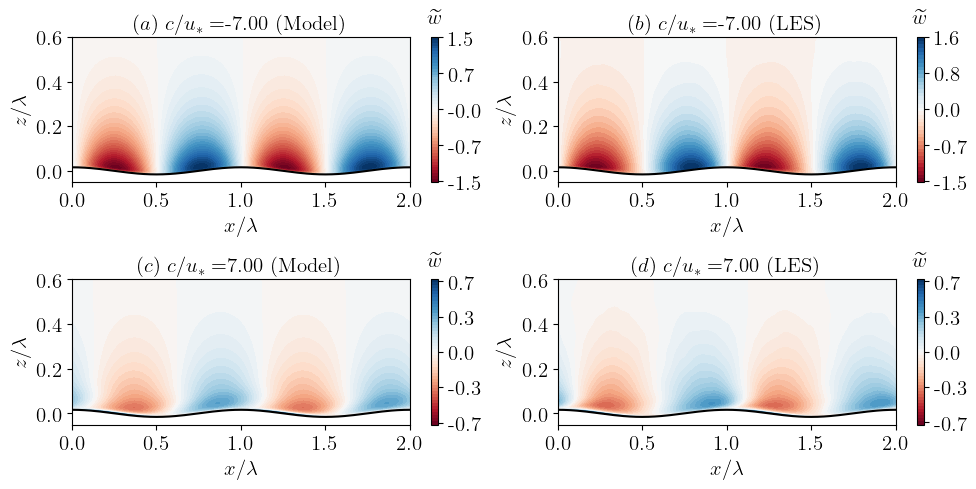

In [508]:
plt.figure(11, figsize=(10,5))

counter = 1
num_levels = 50
wavelength = 2*np.pi/k_wavno
for num_data_select in [2,6]:
    w_induced_model = np.zeros((Nx, np.size(z)), dtype='float')
    z_phys_model = np.zeros((Nx, np.size(z)), dtype='float')
    x_phys_model = np.zeros((Nx, np.size(z)), dtype='float')
    z_phys_LES = np.zeros((Nx, Nz), dtype='float')
    x_phys_LES = np.zeros((Nx, Nz), dtype='float')
    
    for i in range(Nx):
        w_induced_model[i, :] = (
            2 * np.real(Rew[:,1,num_data_select]) * np.cos(k_wavno * x_LES[i]) -
            2 * np.real(Imw[:,1,num_data_select]) * np.sin(k_wavno * x_LES[i])
        )
        z_phys_model[i, :] = z - (z/zi - 1) * a * np.cos(k_wavno * x_LES[i])
        x_phys_model[i, :] = x_LES[i]

    for i in range(Nx):
        zeta_LES = LES_data[num_data_select].zw.flatten()
        z_phys_LES[i, :] = zeta_LES - (zeta_LES/zi - 1) * a * np.cos(k_wavno * x_LES[i])
        x_phys_LES[i, :] = x_LES[i]

    # Model subplot
    ax1 = plt.subplot(2, 2, counter)
    c = plt.contourf(x_phys_model/wavelength, z_phys_model/wavelength, w_induced_model, num_levels, cmap='RdBu')
    plt.plot(x_LES/wavelength, a*np.cos(k_wavno*x_LES)/wavelength, 'k')
    #plt.title(r'$c/u_*=$' + f'{c_array[num_data_select]:.2f} (Model)', fontsize=15)
    plt.title(r'$(' + chr(97 + counter - 1) + r') \ c/u_*=$' + f'{c_array[num_data_select]:.2f} (Model)', fontsize=15)

    cbar = plt.colorbar(c)
    ticks = np.linspace(w_induced_model.min(), w_induced_model.max(), num=5)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in ticks])
    cbar.ax.tick_params(labelsize=15)  # Set colorbar tick font size
    #cbar.ax.set_ylabel(r'$\widetilde{w}$', fontsize=15)
    plt.text(2.1, 0.66, r'$\widetilde{w}$', fontsize=15, color='black')

    plt.xlim(0, 2)
    plt.ylim(-0.05, 0.6)
    plt.xlabel(r'$x/\lambda$', fontsize=15)
    plt.ylabel(r'$z/\lambda$', fontsize=15)

    plt.xticks(np.arange(0,2.5,0.5) ,fontsize=15)
    plt.yticks(fontsize=15)

    # LES subplot
    ax1 = plt.subplot(2, 2, counter + 1)
    c = plt.contourf(x_phys_LES[:, :-1]/wavelength, z_phys_LES[:, :-1]/wavelength, LES_data[num_data_select].w[:, :-1], num_levels, cmap='RdBu')
    plt.plot(x_LES/wavelength, a*np.cos(k_wavno*x_LES)/wavelength, 'k')
    #plt.title(r'$c/u_*=$' + f'{c_array[num_data_select]:.2f} (LES)', fontsize=15)
    plt.title(r'$(' + chr(97 + counter ) + r') \ c/u_*=$' + f'{c_array[num_data_select]:.2f} (LES)', fontsize=15)
 
    cbar = plt.colorbar(c)
    ticks = np.linspace(np.min(LES_data[num_data_select].w[:, :-1]), np.max(LES_data[num_data_select].w[:, :-1]), num=5)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in ticks])
    cbar.ax.tick_params(labelsize=15)  # Set colorbar tick font size
    #cbar.set_label(r'$\widetilde{w}$', loc='top',fontsize=15)
    plt.text(2.1, 0.66, r'$\widetilde{w}$', fontsize=15, color='black')

    
    plt.xlim(0, 2)
    plt.ylim(-0.05, 0.6)
    plt.xlabel(r'$x/\lambda$', fontsize=15)
    plt.ylabel(r'$z/\lambda$', fontsize=15)

    plt.xticks(np.arange(0,2.5,0.5) ,fontsize=15)
    plt.yticks(fontsize=15)

    counter += 2

plt.savefig('w_contour_LES_vs_model_Highlight.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

plt.show()


In [509]:
Rep_interp = np.zeros((Nz,n_num,9),dtype='float')
Imp_interp = np.zeros((Nz,n_num,9),dtype='float')
Reu_interp = np.zeros((Nz,n_num,9),dtype='float')
Imu_interp = np.zeros((Nz,n_num,9),dtype='float')
Rew_interp = np.zeros((Nz,n_num,9),dtype='float')
Imw_interp = np.zeros((Nz,n_num,9),dtype='float')

tau11_hat_model_interp = np.zeros((Nz,n_num,9),dtype='complex')
tau33_hat_model_interp = np.zeros((Nz,n_num,9),dtype='complex')
tau13_hat_model_interp = np.zeros((Nz,n_num,9),dtype='complex')
tau31_hat_model_interp = np.zeros((Nz,n_num,9),dtype='complex')
    
for num_data_select in range(num_data-1): 
    w_hat_LES = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    dwdz_hat_LES = np.gradient(w_hat_LES[16,:],z_data,edge_order=2)
    dudz_hat_LES = np.gradient(u_hat_LES[16,:],z_data,edge_order=2)
    z_data = np.asarray(LES_data[num_data_select].zw).flatten()
    U_data = np.asarray(LES_data[num_data_select].u_mean).flatten()
    U_prime_LES    = np.gradient(U_data,z_data,edge_order=2)
   
    tau11_hat_LES = np.fft.fft(LES_data[num_data_select].tau11+LES_data[num_data_select].tau11_SGS,axis=0,norm='forward')
    tau33_hat_LES = np.fft.fft(LES_data[num_data_select].tau33+LES_data[num_data_select].tau33_SGS,axis=0,norm='forward')
    tau13_hat_LES = np.fft.fft(LES_data[num_data_select].tau13+LES_data[num_data_select].tau13_SGS,axis=0,norm='forward')
    tau31_hat_LES = np.fft.fft(LES_data[num_data_select].tau31+LES_data[num_data_select].tau31_SGS,axis=0,norm='forward')

    tau11_hat_model_interp[:,1,num_data_select] = tau11_hat_LES[16,:]
    tau33_hat_model_interp[:,1,num_data_select] = tau33_hat_LES[16,:]
    tau13_hat_model_interp[:,1,num_data_select] = tau13_hat_LES[16,:]
    tau31_hat_model_interp[:,1,num_data_select] = tau31_hat_LES[16,:]
    

    #nuT_linear = -tau13_mean_tot_LES/U_prime_LES*np.exp(-5*k_wavno*z_data[0:-1])# from LES
    nuT_linear = ustar*kappa*z_data*(1-np.exp(-z_data*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) - nuT_linear*U_prime_LES*(1/zi)*(a/2)
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) 
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,:]-dwdz_hat_LES)

    tau11_hat_model_interp[:,2,num_data_select] = tau11_hat_model
    tau33_hat_model_interp[:,2,num_data_select] = tau33_hat_model
    tau13_hat_model_interp[:,2,num_data_select] = tau13_hat_model
    tau31_hat_model_interp[:,2,num_data_select] = tau31_hat_model
    
    #nuT_linear_2 = -tau31_mean_tot_LES/U_prime_LES*np.exp(-5*k_wavno*z_data[0:-1]) # from LES    
    nuT_linear_2 = ustar*kappa*z_data*(1-np.exp(-z_data*Retau/25))*np.exp(-5*k_wavno*z_data) # 1*0.41*z_data[0:-1]
    tau11_hat_model_2 = 2*nuT_linear_2*dwdz_hat_LES
    tau13_hat_model_2 =  -nuT_linear_2*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) - nuT_linear_2*U_prime_LES*(1/zi)*(a/2)
    tau31_hat_model_2 =  -nuT_linear_2*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) 
    tau33_hat_model_2 =   nuT_linear_2*(1j*k_wavno*u_hat_LES[16,:]-dwdz_hat_LES)

    tau11_hat_model_interp[:,3,num_data_select] = tau11_hat_model_2
    tau33_hat_model_interp[:,3,num_data_select] = tau33_hat_model_2
    tau13_hat_model_interp[:,3,num_data_select] = tau13_hat_model_2
    tau31_hat_model_interp[:,3,num_data_select] = tau31_hat_model_2
    
    for n in range(n_num):
        Rep_interp[1:Nz-1,n,num_data_select] = np.interp(LES_data[num_data_select].zw[1:Nz-1].flatten(),z,np.real(Rep[:,3,n,num_data_select]))
        Rep_interp[0,n,num_data_select]      = np.real(Rep[1,3,n,num_data_select])
        Rep_interp[Nz-1,n,num_data_select]   = np.real(Rep[np.size(z)-3,3,n,num_data_select])
        Imp_interp[1:Nz-1,n,num_data_select] = np.interp(LES_data[num_data_select].zw[1:Nz-1].flatten(),z,np.real(Imp[:,3,n,num_data_select]))
        Imp_interp[0,n,num_data_select]      = np.real(Imp[1,3,n,num_data_select])
        Imp_interp[Nz-1,n,num_data_select]   = np.real(Imp[np.size(z)-3,3,n,num_data_select])


        Reu_interp[1:Nz-1,n,num_data_select] = np.interp(LES_data[num_data_select].zw[1:Nz-1].flatten(),z,np.real(Reu[:,n,num_data_select]))
        Reu_interp[0,n,num_data_select]      = np.real(Reu[1,n,num_data_select])
        Reu_interp[Nz-1,n,num_data_select]   = np.real(Reu[np.size(z)-3,n,num_data_select])
        Imu_interp[1:Nz-1,n,num_data_select] = np.interp(LES_data[num_data_select].zw[1:Nz-1].flatten(),z,np.real(Imu[:,n,num_data_select]))
        Imu_interp[0,n,num_data_select]      = np.real(Imu[1,n,num_data_select])
        Imu_interp[Nz-1,n,num_data_select]   = np.real(Imu[np.size(z)-3,n,num_data_select])

        Rew_interp[1:Nz-1,n,num_data_select] = np.interp(LES_data[num_data_select].zw[1:Nz-1].flatten(),z,np.real(Rew[:,n,num_data_select]))
        Rew_interp[0,n,num_data_select]      = np.real(Rew[1,n,num_data_select])
        Rew_interp[Nz-1,n,num_data_select]   = np.real(Rew[np.size(z)-3,n,num_data_select])
        Imw_interp[1:Nz-1,n,num_data_select] = np.interp(LES_data[num_data_select].zw[1:Nz-1].flatten(),z,np.real(Imw[:,n,num_data_select]))
        Imw_interp[0,n,num_data_select]      = np.real(Imw[1,n,num_data_select])
        Imw_interp[Nz-1,n,num_data_select]   = np.real(Imw[np.size(z)-3,n,num_data_select])


    nuT_linear_3 = ustar*kappa*z_data*(1-np.exp(-z_data*Retau/25))#*np.exp(-5*k_wavno*z_data) # 1*0.41*z_data[0:-1]
    w_hat_interp = np.real(Rew_interp[:,3,num_data_select])+1j*np.real(Imw_interp[:,3,num_data_select])
    u_hat_interp = np.real(Reu_interp[:,3,num_data_select])+1j*np.real(Imu_interp[:,3,num_data_select])
    dwdz_hat_interp = np.gradient(w_hat_interp,z_data,edge_order=2)
    dudz_hat_interp = np.gradient(u_hat_interp,z_data,edge_order=2)
    
    tau11_hat_model_3 = 2*nuT_linear_3*dwdz_hat_interp
    tau13_hat_model_3 =  -nuT_linear_3*(dudz_hat_interp+1j*k_wavno*w_hat_interp) - nuT_linear_3*U_prime_LES*(1/zi)*(a/2)
    tau31_hat_model_3 =  -nuT_linear_3*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) 
    tau33_hat_model_3 =   nuT_linear_3*(1j*k_wavno*u_hat_interp-dwdz_hat_interp)

    tau11_hat_model_interp[:,3,num_data_select] = tau11_hat_model_3
    tau33_hat_model_interp[:,3,num_data_select] = tau33_hat_model_3
    tau13_hat_model_interp[:,3,num_data_select] = tau13_hat_model_3
    tau31_hat_model_interp[:,3,num_data_select] = tau31_hat_model_3

    nuT_linear_4 = ustar*kappa*z_data*(1-np.exp(-z_data*Retau/25))*np.exp(-5*k_wavno*z_data) # 1*0.41*z_data[0:-1]
    w_hat_interp = np.real(Rew_interp[:,4,num_data_select])+1j*np.real(Imw_interp[:,4,num_data_select])
    u_hat_interp = np.real(Reu_interp[:,4,num_data_select])+1j*np.real(Imu_interp[:,4,num_data_select])
    dwdz_hat_interp = np.gradient(w_hat_interp,z_data,edge_order=2)
    dudz_hat_interp = np.gradient(u_hat_interp,z_data,edge_order=2)
    
    tau11_hat_model_4 = 2*nuT_linear_3*dwdz_hat_interp
    tau13_hat_model_4 =  -nuT_linear_3*(dudz_hat_interp+1j*k_wavno*w_hat_interp) - nuT_linear_3*U_prime_LES*(1/zi)*(a/2)
    tau31_hat_model_4 =  -nuT_linear_3*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) 
    tau33_hat_model_4 =   nuT_linear_3*(1j*k_wavno*u_hat_interp-dwdz_hat_interp)

    tau11_hat_model_interp[:,4,num_data_select] = tau11_hat_model_4
    tau33_hat_model_interp[:,4,num_data_select] = tau33_hat_model_4
    tau13_hat_model_interp[:,4,num_data_select] = tau13_hat_model_4
    tau31_hat_model_interp[:,4,num_data_select] = tau31_hat_model_4

    for model_type in range(n_num):
        Rep_interp[0:Nz-1,model_type,num_data_select]     = Rep_interp[0:Nz-1,model_type,num_data_select] -np.real( (1/3)*(tau11_hat_model_interp[0:Nz-1,model_type,num_data_select]+tau33_hat_model_interp[0:Nz-1,model_type,num_data_select]) )
        Imp_interp[0:Nz-1,model_type,num_data_select]     = Imp_interp[0:Nz-1,model_type,num_data_select] -np.imag( (1/3)*(tau11_hat_model_interp[0:Nz-1,model_type,num_data_select]+tau33_hat_model_interp[0:Nz-1,model_type,num_data_select]) )
        
      

/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1299: RuntimeWarning: divide by zero encountered in scalar divide
  b = - (dx2 + dx1) / (dx1 * dx2)
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1300: RuntimeWarning: divide by zero encountered in scalar divide
  c = (2. * dx2 + dx1) / (dx2 * (dx1 + dx2))
/U

In [510]:
# p_induced_visc_2D    = np.zeros((Nx,Nz,num_data-1),dtype='float')
# p_induced_2D         = np.zeros((Nx,Nz,num_data-1),dtype='float')
# p_induced_nuT_2D     = np.zeros((Nx,Nz,num_data-1),dtype='float')
# p_induced_nuT_exp_2D = np.zeros((Nx,Nz,num_data-1),dtype='float')

p_induced_model_2D      = np.zeros((Nx,Nz,n_num,num_data-1),dtype='float')
u_induced_model_2D      = np.zeros((Nx,Nz,n_num,num_data-1),dtype='float')
w_induced_model_2D      = np.zeros((Nx,Nz,n_num,num_data-1),dtype='float')
tau11_induced_model_2D  = np.zeros((Nx,Nz,n_num,num_data-1),dtype='float')
tau33_induced_model_2D  = np.zeros((Nx,Nz,n_num,num_data-1),dtype='float')
tau13_induced_model_2D  = np.zeros((Nx,Nz,n_num,num_data-1),dtype='float')
tau31_induced_model_2D  = np.zeros((Nx,Nz,n_num,num_data-1),dtype='float')


for num_data_select in range(num_data-1):
    
    # for i in range(Nx):
    #     for k in range(Nz):
    #         p_induced_visc_2D[i,k,num_data_select]    = (2*Rep_interp[k,0,num_data_select]*np.cos(k_wavno*x_LES[i])*1-1*2*Imp_interp[k,0,num_data_select]*np.sin(k_wavno*x_LES[i]))
    #         p_induced_2D[i,k,num_data_select]         = (2*Rep_interp[k,1,num_data_select]*np.cos(k_wavno*x_LES[i])*1-1*2*Imp_interp[k,1,num_data_select]*np.sin(k_wavno*x_LES[i]))
    #         p_induced_nuT_2D[i,k,num_data_select]     = (2*Rep_interp[k,2,num_data_select]*np.cos(k_wavno*x_LES[i])*1-1*2*Imp_interp[k,2,num_data_select]*np.sin(k_wavno*x_LES[i]))
    #         p_induced_nuT_exp_2D[i,k,num_data_select] = (2*Rep_interp[k,3,num_data_select]*np.cos(k_wavno*x_LES[i])*1-1*2*Imp_interp[k,3,num_data_select]*np.sin(k_wavno*x_LES[i]))

    for n in range(n_num):
        for i in range(Nx):
            for k in range(Nz):
                p_induced_model_2D[i,k,n,num_data_select]    = (2*Rep_interp[k,n,num_data_select]*np.cos(k_wavno*x_LES[i])*1-1*2*Imp_interp[k,n,num_data_select]*np.sin(k_wavno*x_LES[i]))
                u_induced_model_2D[i,k,n,num_data_select]    = (2*Reu_interp[k,n,num_data_select]*np.cos(k_wavno*x_LES[i])*1-1*2*Imu_interp[k,n,num_data_select]*np.sin(k_wavno*x_LES[i]))
                w_induced_model_2D[i,k,n,num_data_select]    = (2*Rew_interp[k,n,num_data_select]*np.cos(k_wavno*x_LES[i])*1-1*2*Imw_interp[k,n,num_data_select]*np.sin(k_wavno*x_LES[i]))

                Re_tau11 = np.real(tau11_hat_model_interp[:,n,num_data_select])
                Im_tau11 = np.imag(tau11_hat_model_interp[:,n,num_data_select])
                Re_tau33 = np.real(tau33_hat_model_interp[:,n,num_data_select])
                Im_tau33 = np.imag(tau33_hat_model_interp[:,n,num_data_select])
                Re_tau13 = np.real(tau13_hat_model_interp[:,n,num_data_select])
                Im_tau13 = np.imag(tau13_hat_model_interp[:,n,num_data_select])
                Re_tau31 = np.real(tau31_hat_model_interp[:,n,num_data_select])
                Im_tau31 = np.imag(tau31_hat_model_interp[:,n,num_data_select])
                
                
                tau11_induced_model_2D[i,k,n,num_data_select]    = (2*Re_tau11[k]*np.cos(k_wavno*x_LES[i])*1-1*2*Im_tau11[k]*np.sin(k_wavno*x_LES[i]))
                tau33_induced_model_2D[i,k,n,num_data_select]    = (2*Re_tau33[k]*np.cos(k_wavno*x_LES[i])*1-1*2*Im_tau33[k]*np.sin(k_wavno*x_LES[i]))
                tau13_induced_model_2D[i,k,n,num_data_select]    = (2*Re_tau13[k]*np.cos(k_wavno*x_LES[i])*1-1*2*Im_tau13[k]*np.sin(k_wavno*x_LES[i]))
                tau31_induced_model_2D[i,k,n,num_data_select]    = (2*Re_tau31[k]*np.cos(k_wavno*x_LES[i])*1-1*2*Im_tau31[k]*np.sin(k_wavno*x_LES[i]))
                

In [ ]:
plt.figure(11,figsize=(30,50))
counter=1
for num_data_select in range(9):
    
    ax1=plt.subplot(9,3,counter)
    plt.contourf(x_LES,LES_data[num_data_select].zw.flatten(),np.transpose(p_induced_model_2D[:,:,1,num_data_select]),22)
    plt.colorbar()
    plt.title(r'$\widetilde{p}$ (Model)')
    
    ax1=plt.subplot(9,3,counter+1)
    plt.contourf(x_LES,LES_data[num_data_select].zw.flatten(),np.transpose(LES_data[num_data_select].p_w_tilde),22)
    plt.colorbar()
    plt.title(r'$\widetilde{p}$ (LES)')

    ax1=plt.subplot(9,3,counter+2)
    plt.semilogy(np.mean(np.abs(p_induced_model_2D[:,:,0,num_data_select]),axis=0),LES_data[num_data_select].zw.flatten(),'b')
    plt.semilogy(np.mean(np.abs(p_induced_model_2D[:,:,1,num_data_select]),axis=0),LES_data[num_data_select].zw.flatten(),'r')
    plt.semilogy(np.mean(np.abs(p_induced_model_2D[:,:,2,num_data_select]),axis=0),LES_data[num_data_select].zw.flatten(),'m')
    plt.semilogy(np.mean(np.abs(p_induced_model_2D[:,:,3,num_data_select]),axis=0),LES_data[num_data_select].zw.flatten(),'g')
    
    plt.semilogy(np.mean(np.abs(LES_data[num_data_select].p_w_tilde[:,:]),axis=0),LES_data[num_data_select].zw.flatten(),'k',marker='o')
    
    counter=counter+3
plt.show()

In [ ]:
plt.figure(11,figsize=(30,50))
counter=1
for num_data_select in range(9):
    
    ax1=plt.subplot(9,3,counter)
    plt.contourf(x_LES,LES_data[num_data_select].zw.flatten(),np.transpose(tau33_induced_model_2D[:,:,4,num_data_select]),22)
    ax1.set_ylim(0,0.2)
    ax1.set_xlim(0,5)
    
    plt.colorbar()
    plt.title(r'$\widetilde{\tau}_{33}$ (Model)')
    
    ax1=plt.subplot(9,3,counter+1)
    plt.contourf(x_LES,LES_data[num_data_select].zw.flatten(),np.transpose(LES_data[num_data_select].tau33+LES_data[num_data_select].tau33_SGS),22)
    ax1.set_ylim(0,0.2)
    ax1.set_xlim(0,5)
 
    plt.colorbar()
    plt.title(r'$\widetilde{\tau}_{33}$ (LES)')

    # ax1=plt.subplot(9,3,counter+2)
    # plt.semilogy(np.mean(np.abs(p_induced_model_2D[:,:,0,num_data_select]),axis=0),LES_data[num_data_select].zw.flatten(),'b')
    # plt.semilogy(np.mean(np.abs(p_induced_model_2D[:,:,1,num_data_select]),axis=0),LES_data[num_data_select].zw.flatten(),'r')
    # plt.semilogy(np.mean(np.abs(p_induced_model_2D[:,:,2,num_data_select]),axis=0),LES_data[num_data_select].zw.flatten(),'m')
    # plt.semilogy(np.mean(np.abs(p_induced_model_2D[:,:,3,num_data_select]),axis=0),LES_data[num_data_select].zw.flatten(),'g')
    
    # plt.semilogy(np.mean(np.abs(LES_data[num_data_select].p_w_tilde[:,:]),axis=0),LES_data[num_data_select].zw.flatten(),'k',marker='o')
    
    counter=counter+3
plt.show()

$$ \tau_{ij}^p=J^{-1} p \frac{\partial \xi_j}{\partial x_i}$$

\begin{align*}
\tau_{ij}^p=\begin{bmatrix}
\tau_{11}^p & \tau_{12}^p & \tau_{13}^p\\
\tau_{21}^p & \tau_{22}^p & \tau_{23}^p\\
\tau_{31}^p & \tau_{32}^p & \tau_{33}^p
\end{bmatrix}=
\begin{bmatrix}
p/\zeta_z & 0 & p\zeta_x/\zeta_z\\
0& p/\zeta_z & p\zeta_y/\zeta_z\\
0&0&p
\end{bmatrix}
\end{align*}

In [511]:
taup_11_model = np.zeros((Nx,Nz,n_num,num_data),dtype='float') 
taup_13_model = np.zeros((Nx,Nz,n_num,num_data),dtype='float') 
taup_33_model = np.zeros((Nx,Nz,n_num,num_data),dtype='float') 

for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    g_func = z_data/zi-1
    dgdz_func = 1/zi
    zetaz_J   = np.zeros((Nx,Nz),dtype='float64')
    zetax_J   = np.zeros((Nx,Nz),dtype='float64')
    
    for i in range(Nx):
           for k in range(Nz):
               eta_wave = a*np.cos(k_wavno*x_LES[i])
               eta_x_wave = -a*k_wavno*np.sin(k_wavno*x_LES[i])
               zetaz_J[i,k] = 1/(1-dgdz_func*eta_wave)
               zetax_J[i,k] = g_func[k]*eta_x_wave/(1-dgdz_func*eta_wave)

    # taup_11_model[:,:,0,n] = p_induced_visc_2D[:,:,n]/zetaz_J[:,:]
    # taup_11_model[:,:,1,n] = p_induced_2D[:,:,n]/zetaz_J[:,:]
    # taup_11_model[:,:,2,n] = p_induced_nuT_2D[:,:,n]/zetaz_J[:,:]
    # taup_11_model[:,:,3,n] = p_induced_nuT_exp_2D[:,:,n]/zetaz_J[:,:]

    # taup_13_model[:,:,0,n] = p_induced_visc_2D[:,:,n]*zetax_J[:,:]/zetaz_J[:,:]
    # taup_13_model[:,:,1,n] = p_induced_2D[:,:,n]*zetax_J[:,:]/zetaz_J[:,:]
    # taup_13_model[:,:,2,n] = p_induced_nuT_2D[:,:,n]*zetax_J[:,:]/zetaz_J[:,:]
    # taup_13_model[:,:,3,n] = p_induced_nuT_exp_2D[:,:,n]*zetax_J[:,:]/zetaz_J[:,:]

    # taup_33_model[:,:,0,n] = p_induced_visc_2D[:,:,n]
    # taup_33_model[:,:,1,n] = p_induced_2D[:,:,n]
    # taup_33_model[:,:,2,n] = p_induced_nuT_2D[:,:,n]
    # taup_33_model[:,:,3,n] = p_induced_nuT_exp_2D[:,:,n]

    for model_type in range(n_num):
        taup_11_model[:,:,model_type,n] = p_induced_model_2D[:,:,model_type,n]/zetaz_J[:,:]
        taup_13_model[:,:,model_type,n] = p_induced_model_2D[:,:,model_type,n]*zetax_J[:,:]/zetaz_J[:,:]
        taup_33_model[:,:,model_type,n] = p_induced_model_2D[:,:,model_type,n]
    
    


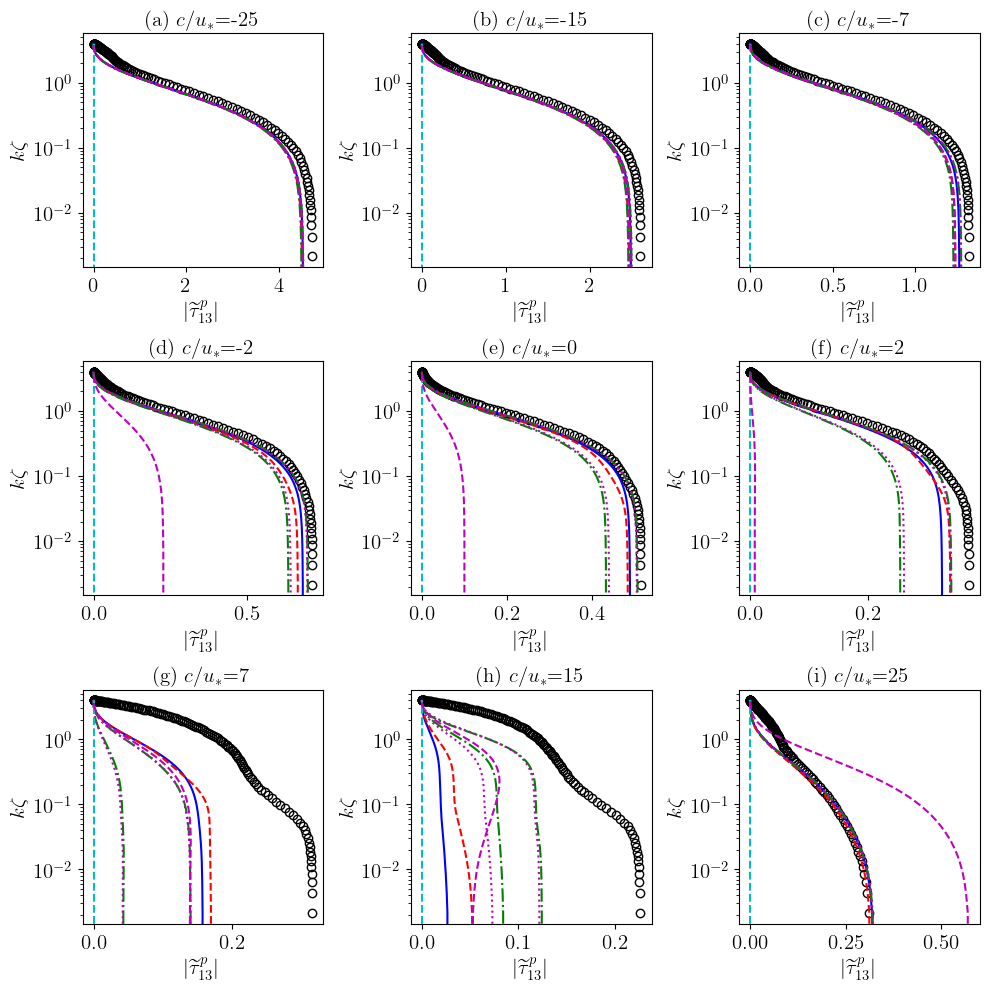

In [512]:
plt.figure(11,figsize=(10,10))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    plt.semilogy(np.mean(np.abs(LES_data[num_data_select].taup_13),axis=0),k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
        
    for model_type in range(n_num):
        plt.semilogy(np.mean(np.abs(taup_13_model[:,:,model_type,num_data_select]),axis=0),k_wavno*LES_data[num_data_select].zw,color_array_plot[model_type] )
    
        
    #plt.semilogy(np.abs(p_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{p}|$ (LES)')
    ax1.set_xlabel(r'$|\widetilde{\tau}^p_{13}|$',fontsize=15)
    ax1.set_title(f'({chr(97 + num_data_select)}) $c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
plt.savefig('taup_33_magnitude_LES_vs_model.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()

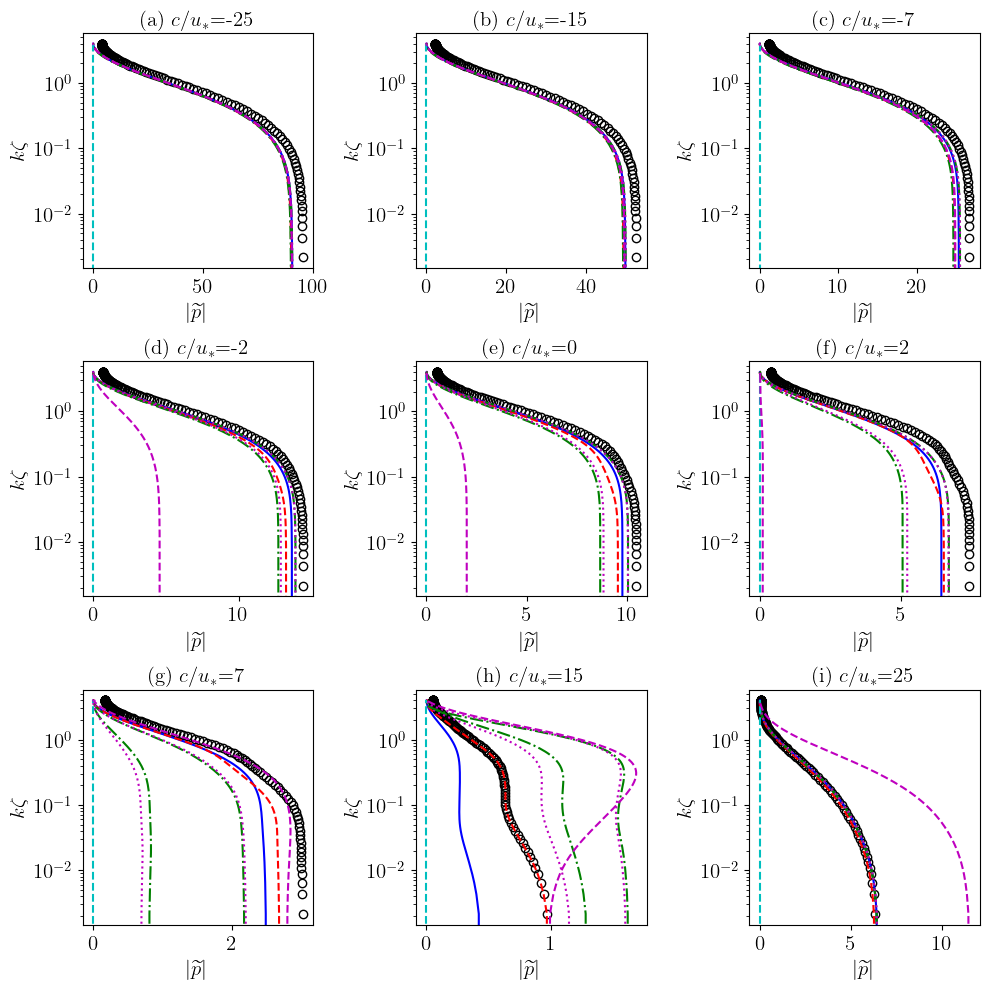

In [513]:
plt.figure(11,figsize=(10,10))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    plt.semilogy(np.mean(np.abs(LES_data[num_data_select].p_w_tilde[:,:]),axis=0),k_wavno*LES_data[num_data_select].zw.flatten(),'ko',markerfacecolor='none')
   
    for model_type in range(n_num):
        plt.semilogy(np.mean(np.abs(p_induced_model_2D[:,:,model_type,num_data_select]),axis=0),k_wavno*LES_data[num_data_select].zw,color_array_plot[model_type] )
    
        
    #plt.semilogy(np.abs(p_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{p}|$ (LES)')
    ax1.set_xlabel(r'$|\widetilde{p}|$',fontsize=15)
    ax1.set_title(f'({chr(97 + num_data_select)}) $c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
plt.savefig('p_induced_magnitude_LES_vs_model.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)
plt.show()   

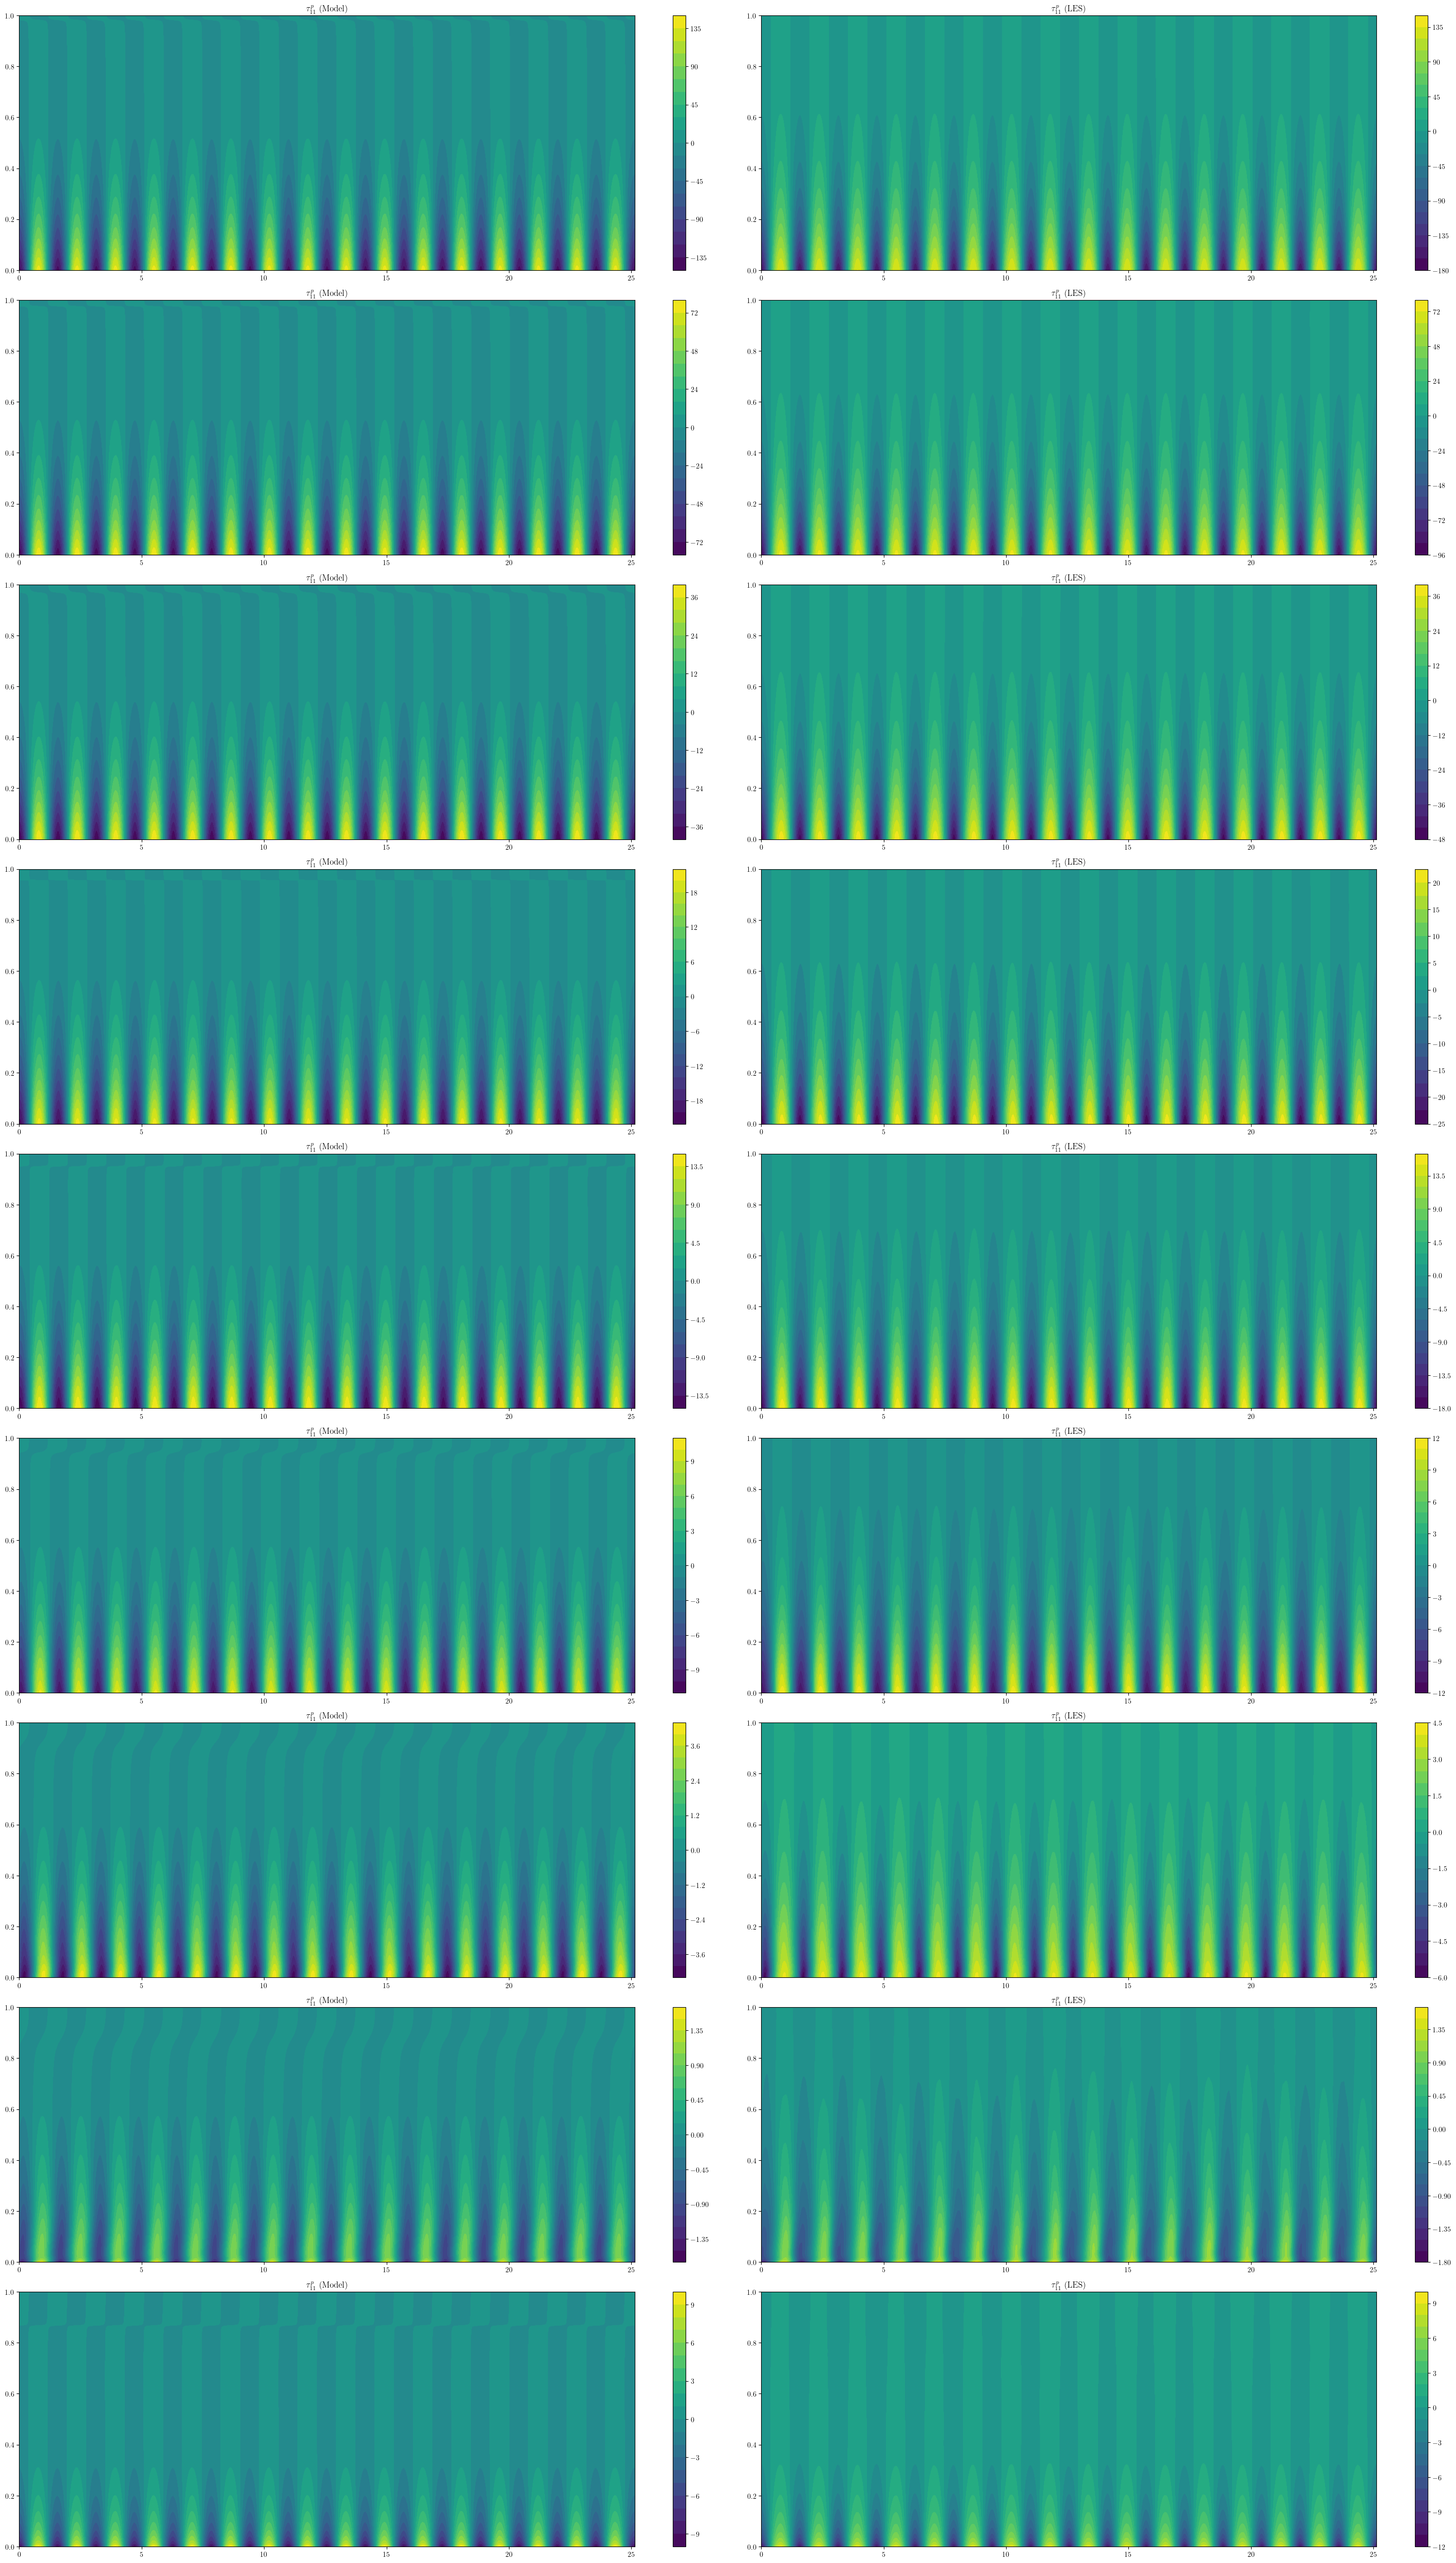

In [514]:
plt.figure(11,figsize=(30,50))
counter=1
for num_data_select in range(9):
    
    ax1=plt.subplot(9,2,counter)
    plt.contourf(x_LES,LES_data[num_data_select].zw.flatten(),np.transpose(taup_33_model[:,:,1,num_data_select]),22)
    plt.colorbar()
    plt.title(r'$\tau_{11}^p$ (Model)')
    
    ax1=plt.subplot(9,2,counter+1)
    plt.contourf(x_LES,LES_data[num_data_select].zw.flatten(),np.transpose(LES_data[num_data_select].taup_33),22)
    plt.colorbar()
    plt.title(r'$\tau_{11}^p$ (LES)')
    
    counter=counter+2
plt.show()

In [ ]:
plt.figure(11,figsize=(30,50))

counter=1
for n in range(9):
    ax1=plt.subplot(9,3,counter)
    plt.contourf(x_LES,LES_data[num_data_select].zw.flatten(),np.transpose(LES_data[n].v_w_phase_avg - np.mean( LES_data[n].v_w_phase_avg,axis=0)))
    plt.colorbar()

    ax1=plt.subplot(9,3,counter+1)
    plt.contourf(x_LES,LES_data[num_data_select].zw.flatten(),np.transpose(LES_data[n].u_w_phase_avg - np.mean( LES_data[n].u_w_phase_avg,axis=0)))
    plt.colorbar()

    ax1=plt.subplot(9,3,counter+2)
    plt.contourf(x_LES,LES_data[num_data_select].zw.flatten(),np.transpose(LES_data[n].w_phase_avg - np.mean( LES_data[n].w_phase_avg,axis=0)))
    plt.colorbar()

    counter+=3
plt.show()

In [515]:
#wave-induced energy budget : comparison with eddy viscosity model
tau13_wave_production = np.zeros((Nz,num_data),dtype='float64')
taup_13_production    = np.zeros((Nz,num_data),dtype='float64')
taup_13_production_2    = np.zeros((Nz,num_data),dtype='float64')
taup_13_production_2_model    = np.zeros((Nz,n_num,num_data),dtype='float64')
wave_production_mean  = np.zeros((Nz,num_data),dtype='float64')

wave_to_turbulence_transfer = np.zeros((Nz,num_data),dtype='float64')
wave_viscous_dissipation    = np.zeros((Nz,num_data),dtype='float64')
wave_SGS_dissipation        = np.zeros((Nz,num_data),dtype='float64')


wave_transport                     = np.zeros((Nz,num_data),dtype='float64')
wave_transport_model                     = np.zeros((Nz,n_num,num_data),dtype='float64')

Ew_transport                       = np.zeros((Nz,num_data),dtype='float64')
ui_tilde_taui3_tilde_transport     = np.zeros((Nz,num_data),dtype='float64')
ui_tilde_taui3_tilde_transport_model     = np.zeros((Nz,n_num,num_data),dtype='float64')

ui_tilde_taup_i3_tilde_transport         = np.zeros((Nz,num_data),dtype='float64')
ui_tilde_taup_i3_tilde_transport_model   = np.zeros((Nz,n_num,num_data),dtype='float64')

ui_tilde_taui3_nu_tilde_transport        = np.zeros((Nz,num_data),dtype='float64')
ui_tilde_taui3_nu_tilde_transport_model  = np.zeros((Nz,n_num,num_data),dtype='float64')

ui_tilde_taui3_SGS_tilde_transport       = np.zeros((Nz,num_data),dtype='float64')

for n in range(num_data-1):
    
    #Advection TKE term
    TKE_tilde = np.zeros((Nx,Nz),dtype='float64')  
    W_tilde   = np.zeros((Nx,Nz),dtype='float64')  
    z_data = np.asarray(LES_data[n].zw).flatten()
    U_data = np.asarray(LES_data[n].u_mean).flatten()
    dudz_TKE = np.gradient(U_data,z_data,edge_order=2)
    
    TKE_tilde = LES_TKE_data[n].TKE-np.mean(LES_TKE_data[n].TKE,axis=0)
    W_tilde   = LES_data[n].W_phase_avg-np.mean(LES_data[n].W_phase_avg,axis=0)    
    ####################################################################################################
    #Convective Transport
    uiuiU_TKE = np.zeros((Nx,Nz),dtype='float64')
    uiuiW_TKE = np.zeros((Nx,Nz),dtype='float64')

    ddx_uiuiU = np.zeros((Nx,Nz),dtype='float64')
    ddz_uiuiW = np.zeros((Nx,Nz),dtype='float64')

    uiuiU_TKE = 0.5*(LES_data[n].uiuiU_phase_avg - (LES_data[n].uu_w_phase_avg+LES_data[n].vv_w_phase_avg+LES_data[n].ww_phase_avg)*LES_data[n].U_phase_avg \
                -2*LES_data[n].u_w_phase_avg*(LES_data[n].uU_phase_avg-LES_data[n].u_w_phase_avg*LES_data[n].U_phase_avg) \
                -2*LES_data[n].v_w_phase_avg*(LES_data[n].vU_phase_avg-LES_data[n].v_w_phase_avg*LES_data[n].U_phase_avg) \
                -2*LES_data[n].w_phase_avg*(LES_data[n].wU_phase_avg-LES_data[n].w_phase_avg*LES_data[n].U_phase_avg));
                
    uiuiW_TKE = 0.5*(LES_data[n].uiuiW_phase_avg - (LES_data[n].uu_w_phase_avg+LES_data[n].vv_w_phase_avg+LES_data[n].ww_phase_avg)*LES_data[n].W_phase_avg \
                -2*LES_data[n].u_w_phase_avg*(LES_data[n].uW_phase_avg-LES_data[n].u_w_phase_avg*LES_data[n].W_phase_avg) \
                -2*LES_data[n].v_w_phase_avg*(LES_data[n].vW_phase_avg-LES_data[n].v_w_phase_avg*LES_data[n].W_phase_avg) \
                -2*LES_data[n].w_phase_avg*(LES_data[n].wW_phase_avg-LES_data[n].w_phase_avg*LES_data[n].W_phase_avg));
    
    for k in range(Nz):
        ddx_uiuiU[:,k] = ddxi_fft(uiuiU_TKE[:,k], x_LES, kx)
    for i in range(Nx):
        ddz_uiuiW[i,:] = np.gradient(uiuiW_TKE[i,:], z_data, edge_order=2)
    
    
    #pressure transport
    ddx_pp_Up = np.zeros((Nx,Nz),dtype='float64')
    ddz_pp_Wp = np.zeros((Nx,Nz),dtype='float64')
    for k in range(Nz):
        ddx_pp_Up[:,k] = ddxi_fft(LES_TKE_data[n].pp_Up_TKE[:,k], x_LES, kx)
    for i in range(Nx):
        ddz_pp_Wp[i,:] = np.gradient(LES_TKE_data[n].pp_Wp_TKE[i,:], z_data, edge_order=2)
    
    
    #viscous transport
    ddx_upi_taup_nu_i1 = np.zeros((Nx,Nz),dtype='float64')
    ddz_upi_taup_nu_i3 = np.zeros((Nx,Nz),dtype='float64')
    for k in range(Nz):
        ddx_upi_taup_nu_i1[:,k] = ddxi_fft(LES_TKE_data[n].upi_taup_nu_i1_TKE[:,k], x_LES, kx)
    for i in range(Nx):
        ddz_upi_taup_nu_i3[i,:] = np.gradient(LES_TKE_data[n].upi_taup_nu_i3_TKE[i,:], z_data, edge_order=2)
    
    
    ####################################################################################################
    #Production term
    tau11   = np.zeros((Nx,Nz),dtype='float64')
    tau21   = np.zeros((Nx,Nz),dtype='float64')
    tau31   = np.zeros((Nx,Nz),dtype='float64')
    tau13   = np.zeros((Nx,Nz),dtype='float64')
    tau23   = np.zeros((Nx,Nz),dtype='float64')
    tau33   = np.zeros((Nx,Nz),dtype='float64')
    
    tau11_tilde  = np.zeros((Nx,Nz),dtype='float64')
    tau21_tilde  = np.zeros((Nx,Nz),dtype='float64')
    tau31_tilde  = np.zeros((Nx,Nz),dtype='float64')
    tau13_tilde  = np.zeros((Nx,Nz),dtype='float64')
    tau23_tilde  = np.zeros((Nx,Nz),dtype='float64')
    tau33_tilde  = np.zeros((Nx,Nz),dtype='float64')
    
    tau11_mean   = np.zeros((Nz,1),dtype='float64')
    tau21_mean   = np.zeros((Nz,1),dtype='float64')
    tau31_mean   = np.zeros((Nz,1),dtype='float64')
    tau13_mean   = np.zeros((Nz,1),dtype='float64')
    tau23_mean   = np.zeros((Nz,1),dtype='float64')
    tau33_mean   = np.zeros((Nz,1),dtype='float64')
    
    tau11  = LES_data[n].uU_phase_avg - LES_data[n].u_w_phase_avg*LES_data[n].U_phase_avg
    tau21  = LES_data[n].vU_phase_avg - LES_data[n].v_w_phase_avg*LES_data[n].U_phase_avg
    tau31  = LES_data[n].wU_phase_avg -   LES_data[n].w_phase_avg*LES_data[n].U_phase_avg

    tau13  = LES_data[n].uW_phase_avg - LES_data[n].u_w_phase_avg*LES_data[n].W_phase_avg
    tau23  = LES_data[n].vW_phase_avg - LES_data[n].v_w_phase_avg*LES_data[n].W_phase_avg
    tau33  = LES_data[n].wW_phase_avg -   LES_data[n].w_phase_avg*LES_data[n].W_phase_avg

    #tau11 = tau11 - (1/3)*(tau11+tau33)
    #tau33 = tau33 - (1/3)*(tau11+tau33)
    
    tau11_mean = np.mean(tau11,axis=0)
    tau21_mean = np.mean(tau21,axis=0)
    tau31_mean = np.mean(tau31,axis=0)

    tau13_mean = np.mean(tau13,axis=0)
    tau23_mean = np.mean(tau23,axis=0)
    tau33_mean = np.mean(tau33,axis=0)

    tau11_tilde = tau11 - tau11_mean
    tau21_tilde = tau21 - tau21_mean
    tau31_tilde = tau31 - tau31_mean

    tau13_tilde = tau13 - tau13_mean
    tau23_tilde = tau23 - tau23_mean
    tau33_tilde = tau33 - tau33_mean


    u_tilde      = np.zeros((Nx,Nz),dtype='float64')
    v_tilde      = np.zeros((Nx,Nz),dtype='float64')
    w_tilde      = np.zeros((Nx,Nz),dtype='float64')
    ddx_u_tilde  = np.zeros((Nx,Nz),dtype='float64')
    ddx_v_tilde  = np.zeros((Nx,Nz),dtype='float64')
    ddx_w_tilde  = np.zeros((Nx,Nz),dtype='float64')
    ddz_u_tilde  = np.zeros((Nx,Nz),dtype='float64')
    ddz_v_tilde  = np.zeros((Nx,Nz),dtype='float64')
    ddz_w_tilde  = np.zeros((Nx,Nz),dtype='float64')
    u_mean_TKE   = np.zeros((Nx,Nz),dtype='float64')


    u_tilde_model      = np.zeros((Nx,Nz,n_num),dtype='float64')
    v_tilde_model      = np.zeros((Nx,Nz,n_num),dtype='float64')
    w_tilde_model      = np.zeros((Nx,Nz,n_num),dtype='float64')
    ddx_u_tilde_model  = np.zeros((Nx,Nz,n_num),dtype='float64')
    ddx_v_tilde_model  = np.zeros((Nx,Nz,n_num),dtype='float64')
    ddx_w_tilde_model  = np.zeros((Nx,Nz,n_num),dtype='float64')
    ddz_u_tilde_model  = np.zeros((Nx,Nz,n_num),dtype='float64')
    ddz_v_tilde_model  = np.zeros((Nx,Nz,n_num),dtype='float64')
    ddz_w_tilde_model  = np.zeros((Nx,Nz,n_num),dtype='float64')
    
    
    u_tilde    = LES_data[n].u_w_phase_avg - np.mean( LES_data[n].u_w_phase_avg,axis=0)
    v_tilde    = LES_data[n].v_w_phase_avg - np.mean( LES_data[n].v_w_phase_avg,axis=0)
    w_tilde    =   LES_data[n].w_phase_avg - np.mean(   LES_data[n].w_phase_avg,axis=0)

    
    for k in range(Nz):
        ddx_u_tilde[:,k] = ddxi_fft(u_tilde[:,k],x_LES,kx)
        ddx_v_tilde[:,k] = ddxi_fft(v_tilde[:,k],x_LES,kx)
        ddx_w_tilde[:,k] = ddxi_fft(w_tilde[:,k],x_LES,kx)


    for i in range(Nx):
        ddz_u_tilde[i,:] = np.gradient(u_tilde[i,:],z_data,edge_order=2)
        ddz_v_tilde[i,:] = np.gradient(v_tilde[i,:],z_data,edge_order=2)
        ddz_w_tilde[i,:] = np.gradient(w_tilde[i,:],z_data,edge_order=2)

    for model_type in range(n_num):
        u_tilde_model[:,:,model_type] = u_induced_model_2D[:,:,model_type,n]
        w_tilde_model[:,:,model_type] = w_induced_model_2D[:,:,model_type,n]
        
        for k in range(Nz):
            ddx_u_tilde_model[:,k,model_type] = ddxi_fft(u_induced_model_2D[:,k,model_type,n],x_LES,kx)
            ddx_w_tilde_model[:,k,model_type] = ddxi_fft(w_induced_model_2D[:,k,model_type,n],x_LES,kx)
        for i in range(Nx):
            ddz_u_tilde_model[i,:,model_type] = np.gradient(u_induced_model_2D[i,:,model_type,n],z_data,edge_order=2)
            ddz_w_tilde_model[i,:,model_type] = np.gradient(w_induced_model_2D[i,:,model_type,n],z_data,edge_order=2)


        
    

    ############################################################################################################################################
    #Wave-induced energy budget
    ############################################################################################################################################

    #Transport terms
    #wave-induced energy transport
    E_wave  = np.zeros((Nx,Nz),dtype='float')
    W_tilde = np.zeros((Nx,Nz),dtype='float')
    E_wave  = 0.5*(u_tilde*u_tilde+v_tilde*v_tilde+w_tilde*w_tilde)
    W_tilde = LES_data[n].W
    Ew_transport[:,n]=np.gradient(np.mean(E_wave*W_tilde,axis=0),z_data,edge_order=2)

    ############################################################################################################################################

    #wave-induced turbulent transport
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dwdz_hat_LES = np.gradient(w_hat_LES[16,:],z_data,edge_order=2)
    dudz_hat_LES = np.gradient(u_hat_LES[16,:],z_data,edge_order=2)
    
    #tau11_hat_LES = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward')
    #tau33_hat_LES = np.fft.fft(LES_data[n].tau33+LES_data[n].tau33_SGS,axis=0,norm='forward')
    
    #nuT_linear = -tau13_mean_tot_LES/U_prime_LES*np.exp(-5*k_wavno*z_data[0:-1])# from LES
    nuT_linear = ustar*kappa*z_data*(1-np.exp(-z_data*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) - nuT_linear*dudz_TKE*(1/zi)*(a/2)
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) 
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,:]-dwdz_hat_LES)

    #nuT_linear_2 = -tau31_mean_tot_LES/U_prime_LES*np.exp(-5*k_wavno*z_data[0:-1]) # from LES    
    nuT_linear_2 = c1_fit_const[num_data_select]*ustar*kappa*z_data*(1-np.exp(-z_data*Retau/25))*np.exp(-5*k_wavno*z_data)*(1-z_data)**(c2_const)#ustar*kappa*z_data*(1-np.exp(-z_data*Retau/25))*np.exp(-5*k_wavno*z_data) # 1*0.41*z_data[0:-1]
    tau11_hat_model_2 = 2*nuT_linear_2*dwdz_hat_LES
    tau13_hat_model_2 =  -nuT_linear_2*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) - nuT_linear_2*dudz_TKE*(1/zi)*(a/2)
    tau31_hat_model_2 =  -nuT_linear_2*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) 
    tau33_hat_model_2 =   nuT_linear_2*(1j*k_wavno*u_hat_LES[16,:]-dwdz_hat_LES)
    
    ui_tilde_taui3_tilde=np.zeros((Nx,Nz),dtype='float')
    ui_tilde_taui3_tilde=u_tilde*tau13_tilde+v_tilde*tau23_tilde+w_tilde*tau33_tilde
    ui_tilde_taui3_tilde_transport[:,n]=np.gradient(np.mean(ui_tilde_taui3_tilde,axis=0),z_data,edge_order=2)

    for model_type in range(n_num):
        ui_tilde_taui3_tilde=np.zeros((Nx,Nz),dtype='float')
        ui_tilde_taui3_tilde = u_tilde_model[:,:,model_type]*tau13_induced_model_2D[:,:,model_type,num_data_select] \
                              +w_tilde_model[:,:,model_type]*tau33_induced_model_2D[:,:,model_type,num_data_select]
        
        # if model_type==1:
        #    ui_tilde_taui3_tilde = u_tilde_model[:,:,model_type]*tau13_tilde+w_tilde_model[:,:,model_type]*tau33_tilde
        #    ui_tilde_taui3_tilde_transport_model[:,model_type,n] = np.gradient(np.mean(ui_tilde_taui3_tilde,axis=0),z_data,edge_order=2)
        # if model_type==2:
        #    ui_tilde_taui3_tilde = u_tilde_model[:,:,model_type]*tau13_hat_model+w_tilde_model[:,:,model_type]*tau33_hat_model
        #    ui_tilde_taui3_tilde_transport_model[:,model_type,n] = np.gradient(np.mean(ui_tilde_taui3_tilde,axis=0),z_data,edge_order=2)
        # if model_type==3:
        #    ui_tilde_taui3_tilde = u_tilde_model[:,:,model_type]*tau13_hat_model_2+w_tilde_model[:,:,model_type]*tau33_hat_model_2
        #    ui_tilde_taui3_tilde_transport_model[:,model_type,n] = np.gradient(np.mean(ui_tilde_taui3_tilde,axis=0),z_data,edge_order=2)
        
    ############################################################################################################################################

    #wave-induced pressure transport
    taup_11_tilde = np.zeros((Nx,Nz),dtype='float')
    taup_13_tilde = np.zeros((Nx,Nz),dtype='float')
    taup_11_mean  = np.zeros((Nx,Nz),dtype='float')
    taup_13_mean  = np.zeros((Nx,Nz),dtype='float')
    taup_33_tilde = np.zeros((Nx,Nz),dtype='float')
    taup_33_mean  = np.zeros((Nx,Nz),dtype='float')
    
    taup_11_tilde = LES_data[n].taup_11
    taup_13_tilde = LES_data[n].taup_13
    taup_33_tilde = LES_data[n].taup_33
    
    taup_11_mean = LES_data[n].taup_11_mean
    taup_13_mean = LES_data[n].taup_13_mean
    taup_33_mean = LES_data[n].taup_33_mean

    ui_tilde_taup_i3_tilde=np.zeros((Nx,Nz),dtype='float')
    ui_tilde_taup_i3_tilde=u_tilde*taup_13_tilde + w_tilde*taup_33_tilde
    ui_tilde_taup_i3_tilde_transport[:,n]=np.gradient(np.mean(ui_tilde_taup_i3_tilde,axis=0),z_data,edge_order=2)

    for model_type in range(n_num):
        ui_tilde_taup_i3_tilde=np.zeros((Nx,Nz),dtype='float')
        ui_tilde_taup_i3_tilde=u_tilde_model[:,:,model_type] *taup_13_model[:,:,model_type,n] + w_tilde_model[:,:,model_type] *taup_33_model[:,:,model_type,n]
        ui_tilde_taup_i3_tilde_transport_model[:,model_type,n] = np.gradient(np.mean(ui_tilde_taup_i3_tilde,axis=0),z_data,edge_order=2)

    
    #wave-induced viscous stress transport    
    tau11_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    tau21_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    tau31_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    
    tau13_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    tau23_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    tau33_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    
    tau13_nu_mean=np.zeros((Nx,Nz),dtype='float')
    tau23_nu_mean=np.zeros((Nx,Nz),dtype='float')
    tau33_nu_mean=np.zeros((Nx,Nz),dtype='float')

    tau11_nu_tilde = LES_data[n].tau11_nu
    tau21_nu_tilde = LES_data[n].tau21_nu
    tau31_nu_tilde = LES_data[n].tau31_nu
    
    tau13_nu_tilde = LES_data[n].tau13_nu
    tau23_nu_tilde = LES_data[n].tau23_nu
    tau33_nu_tilde = LES_data[n].tau33_nu
    
    tau13_nu_mean = LES_data[n].tau13_nu_mean
    tau23_nu_mean = LES_data[n].tau23_nu_mean
    tau33_nu_mean = LES_data[n].tau33_nu_mean

    ui_tilde_taui3_nu_tilde=np.zeros((Nx,Nz),dtype='float')    
    ui_tilde_taui3_nu_tilde=u_tilde*tau13_nu_tilde+v_tilde*tau23_nu_tilde+w_tilde*tau33_nu_tilde
    ui_tilde_taui3_nu_tilde_transport[:,n]=np.gradient(np.mean(ui_tilde_taui3_nu_tilde,axis=0),z_data,edge_order=2)

    for model_type in range(n_num):
        ui_tilde_taui3_nu_tilde=np.zeros((Nx,Nz),dtype='float')    
        ui_tilde_taui3_nu_tilde=  u_tilde_model[:,:,model_type]*tau13_nu_tilde \
                                 +v_tilde_model[:,:,model_type]*tau23_nu_tilde \
                                 +w_tilde_model[:,:,model_type]*tau33_nu_tilde
        ui_tilde_taui3_nu_tilde_transport_model[:,model_type,n]=np.gradient(np.mean(ui_tilde_taui3_nu_tilde,axis=0),z_data,edge_order=2)

   
    #wave-induced SGS stress transport   
    tau11_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    tau21_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    tau31_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
   
    tau13_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    tau23_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    tau33_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    
    tau13_SGS_mean=np.zeros((Nx,Nz),dtype='float')
    tau23_SGS_mean=np.zeros((Nx,Nz),dtype='float')
    tau33_SGS_mean=np.zeros((Nx,Nz),dtype='float')

    tau11_SGS_tilde = LES_data[n].tau11_SGS-0*(1/3)*(LES_data[n].tau11_SGS+LES_data[n].tau33_SGS)
    tau21_SGS_tilde = LES_data[n].tau21_SGS
    tau31_SGS_tilde = LES_data[n].tau31_SGS
    tau13_SGS_tilde = LES_data[n].tau13_SGS
    tau23_SGS_tilde = LES_data[n].tau23_SGS
    tau33_SGS_tilde = LES_data[n].tau33_SGS-0*(1/3)*(LES_data[n].tau11_SGS+LES_data[n].tau33_SGS)
    
    tau13_SGS_mean = LES_data[n].tau13_SGS_mean
    tau23_SGS_mean = LES_data[n].tau23_SGS_mean
    tau33_SGS_mean = LES_data[n].tau33_SGS_mean

    ui_tilde_taui3_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    ui_tilde_taui3_SGS_tilde=u_tilde*tau13_SGS_tilde+v_tilde*tau23_SGS_tilde+w_tilde*tau33_SGS_tilde
    ui_tilde_taui3_SGS_tilde_transport[:,n]=np.gradient(np.mean(ui_tilde_taui3_SGS_tilde,axis=0),z_data,edge_order=2)

    wave_transport[:,n] =    0*Ew_transport[:,n] \
                           + 1*ui_tilde_taui3_tilde_transport[:,n] \
                           + ui_tilde_taup_i3_tilde_transport[:,n] \
                           + ui_tilde_taui3_nu_tilde_transport[:,n] \
                           + 0*ui_tilde_taui3_SGS_tilde_transport[:,n]

    for model_type in range(n_num):
        wave_transport_model[:,model_type, n] =    0*Ew_transport[:,n] \
                                                   + ui_tilde_taui3_tilde_transport_model[:,model_type,n] \
                                                   + ui_tilde_taup_i3_tilde_transport_model[:,model_type,n] \
                                                   + ui_tilde_taui3_nu_tilde_transport_model[:,model_type,n] \
                                                   + 0*ui_tilde_taui3_SGS_tilde_transport[:,n]


    ###################################################################################################################################
    #Production terms
    tau13_wave                 = np.zeros((Nx,Nz),dtype='float')
    tau13_wave_mean            = np.zeros((Nz,1) ,dtype='float')
    
    tau13_wave                 = u_tilde*W_tilde
    tau13_wave_mean            = np.mean(tau13_wave,axis=0)
    tau13_wave_production[:,n] = tau13_wave_mean*dudz_TKE

    taup_13_production_2[:,n]        = -np.mean(  taup_11_tilde*ddx_u_tilde +     0 +     0 \
                                                + taup_13_tilde*ddz_u_tilde +     0 +     taup_33_tilde*ddz_w_tilde, axis=0)

    for model_type in range(n_num):
        taup_13_production_2_model[:,model_type,n] = -np.mean(  taup_11_model[:,:,model_type,n]*ddx_u_tilde_model[:,:,model_type]  +     0 +     0 \
                                                              + taup_13_model[:,:,model_type,n]*ddz_u_tilde_model[:,:,model_type]  +     0    \
                                                              + taup_33_model[:,:,model_type,n]*ddz_w_tilde_model[:,:,model_type] , axis=0)
 

    taup_13_production[:,n]    =  taup_13_mean*dudz_TKE

    wave_production_mean[:,n]        =  tau13_wave_production[:,n] + 0*taup_13_production[:,n]  
    
    wave_to_turbulence_transfer[:,n] = -np.mean(  tau11_tilde*ddx_u_tilde +     tau21_tilde*ddx_v_tilde +     tau31_tilde*ddx_w_tilde \
                                                + tau13_tilde*ddz_u_tilde +     tau23_tilde*ddz_v_tilde +     tau33_tilde*ddz_w_tilde, axis=0)
    
    wave_viscous_dissipation[:,n]    = -np.mean(  tau11_nu_tilde*ddx_u_tilde +     tau21_nu_tilde*ddx_v_tilde +     tau31_nu_tilde*ddx_w_tilde \
                                                + tau13_nu_tilde*ddz_u_tilde +     tau23_nu_tilde*ddz_v_tilde +     tau33_nu_tilde*ddz_w_tilde, axis=0)
    
    wave_SGS_dissipation[:,n]        = -np.mean(  tau11_SGS_tilde*ddx_u_tilde +     tau21_SGS_tilde*ddx_v_tilde +     tau31_SGS_tilde*ddx_w_tilde \
                                                + tau13_SGS_tilde*ddz_u_tilde +     tau23_SGS_tilde*ddz_v_tilde +     tau33_SGS_tilde*ddz_w_tilde, axis=0)

    

/var/folders/b3/r_0g9bm16qv2jbpkgrhll7v80000gn/T/ipykernel_89120/4151210201.py:364: RuntimeWarning: invalid value encountered in multiply
  + taup_33_model[:,:,model_type,n]*ddz_w_tilde_model[:,:,model_type] , axis=0)


In [ ]:
# plt.figure(18,figsize=(10,10))
# font_size=15
# for n in range(num_data-1):
#     a1x=plt.subplot(3,3,n+1)
#     # plt.semilogy(ui_tilde_taup_i3_tilde_transport[:,n],z_data,color='c',linestyle='-',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (visc)')
#     # plt.semilogy(ui_tilde_taup_i3_tilde_transport_model[:,0,n],z_data,color='r',linestyle='-',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (visc)')
#     # plt.semilogy(ui_tilde_taup_i3_tilde_transport_model[:,1,n],z_data,color='b',linestyle='-',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (visc)')
#     # plt.semilogy(ui_tilde_taup_i3_tilde_transport_model[:,2,n],z_data,color='k',linestyle='-',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (visc)')
#     # plt.semilogy(ui_tilde_taup_i3_tilde_transport_model[:,3,n],z_data,color='m',linestyle='-',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (visc)')

#     plt.semilogy(taup_13_production_2[:,n],z_data,color='c',linestyle='-',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (visc)')
#     plt.semilogy(taup_13_production_2_model[:,0,n],z_data,color='r',linestyle='-',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (visc)')
#     plt.semilogy(taup_13_production_2_model[:,1,n],z_data,color='b',linestyle='-',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (visc)')
#     plt.semilogy(taup_13_production_2_model[:,2,n],z_data,color='k',linestyle='-',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (visc)')
#     plt.semilogy(taup_13_production_2_model[:,3,n],z_data,color='m',linestyle='-',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (visc)')
# plt.show()

0
1
2
3
4
5
6
7
8
8 legend


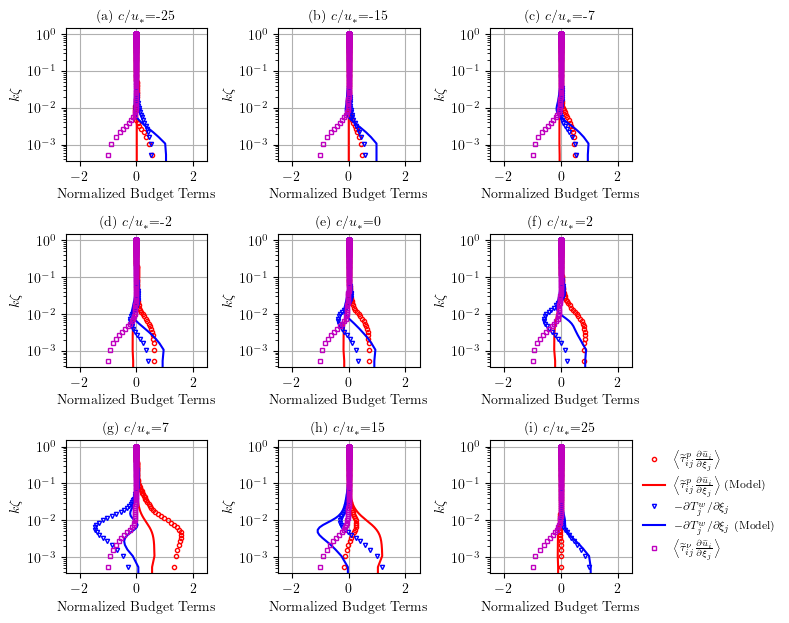

In [516]:
plt.figure(18,figsize=(8,8))
font_size=10
power_norm=0
model_type=5
for n in range(num_data-1):
    if n<num_data-1:
        print(n)
        ax1=plt.subplot(4,3,n+1)
        ax1.set_title(f'({chr(97 + n)}) $c/u_*$={c_array[n]}', fontsize=font_size)
    else:
        print(n,num_data)
        ax1=plt.subplot(4,3,n+2)
        ax1.set_title(f'({chr(97 + n)}) Flat wall', fontsize=font_size)
    normalisation=np.abs(1/wave_viscous_dissipation[0,n])
    
    #plt.semilogy(-normalisation*wave_production_mean[:,n],linestyle='--',z_data,color='r',label=r'$-\langle\tau_{ij}^w\rangle\frac{\partial \langle u_i\rangle}{\partial \xi_j}$')

    plt.semilogy(-normalisation*taup_13_production_2[:,n],z_data,color='r',marker='o',markersize=3,markerfacecolor='none',label=r'$\left\langle\widetilde{\tau}_{ij}^{p}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$',linestyle='none')
    plt.semilogy(-normalisation*taup_13_production_2_model[0:-1,model_type,n],z_data[0:-1],color='r',linestyle='-',label=r'$\left\langle\widetilde{\tau}_{ij}^{p}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$ (Model)')
    
    plt.semilogy(-normalisation*wave_transport[:,n],z_data,color='b',marker='v',markersize=3,markerfacecolor='none',label=r'$-{\partial T^w_j}/{\partial \xi_j}$',linestyle='none')
    plt.semilogy(-normalisation*wave_transport_model[0:-1,model_type,n],z_data[0:-1],color='b',linestyle='-',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (Model)')

    #plt.semilogy(-normalisation* ui_tilde_taup_i3_tilde_transport_model[:,1,n],z_data,color='c',linestyle='--',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (visc)')
    #plt.semilogy(-normalisation* ui_tilde_taup_i3_tilde_transport[:,n],z_data,color='b',linestyle='--',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (visc)')
   
    
    plt.semilogy(-normalisation*wave_viscous_dissipation[:,n],z_data,color='m',marker='s',markersize=3,markerfacecolor='none',label=r'$\left\langle\widetilde{\tau}_{ij}^\nu\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$',linestyle='none')
    
    
    #plt.semilogy(-normalisation*wave_to_turbulence_transfer[:,n],z_data,color='k',label=r'$\left\langle\widetilde{\tau}_{ij}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$')
    #plt.semilogy(-normalisation*wave_SGS_dissipation[:,n],z_data,color='c',label=r'$\left\langle\widetilde{\tau}_{ij}^{\mathrm{SGS}}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$')
    
    # plt.semilogy(normalisation*(-0*wave_production_mean[:,n] \
    #              -taup_13_production_2[:,n] \
    #              -wave_transport[:,n] \
    #              -0*wave_to_turbulence_transfer[:,n] \
    #              -wave_viscous_dissipation[:,n] \
    #              -0*wave_SGS_dissipation[:,n]),z_data,color='c',linestyle='-',label='total')

    # plt.semilogy(normalisation*(-0*wave_production_mean[0:-1,n] \
    #              -taup_13_production_2_model[0:-1,model_type,n] \
    #              -wave_transport_model[0:-1,model_type,n] \
    #              -0*wave_to_turbulence_transfer[0:-1,n] \
    #              -wave_viscous_dissipation[0:-1,n] \
    #              -0*wave_SGS_dissipation[0:-1,n]),z_data[0:-1],color='k',linestyle='--',label='total (Model)')

   
    if n==num_data-2:
        print(n,'legend')
        plt.legend(bbox_to_anchor=[1.01, 1], fontsize=8, frameon=False)
    
        
    plt.grid(True)
    ax1.tick_params(labelsize=font_size)
    
   # ax1.set_xlim(-np.abs((wave_viscous_dissipation[0,n]))-100,np.abs((wave_viscous_dissipation[0,n]))+100)
   # ax1.set_xticks([normalisation*(np.round(-np.abs((wave_viscous_dissipation[0,n])))-10),0,normalisation*(10+np.round(np.abs((wave_viscous_dissipation[0,n]))))] )
    ax1.set_xlim(-2.5,2.5)
   # ax1.set_xticks([-1.5,-1,-0.5,0,0.5,1,1.5] )
    
    ax1.set_ylabel('$k \zeta$',fontsize=font_size)
    ax1.set_xlabel('Normalized Budget Terms',fontsize=font_size)

#plt.savefig('wave_energy_budget.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)
plt.savefig('wave_energy_budget_nuT2_comparison.png',format='png',dpi=600,bbox_inches='tight',
            transparent=False,pad_inches=0.01)

    
plt.show()

In [ ]:
plt.figure(18,figsize=(5,5))
font_size=10
power_norm=0
model_type=3
reduced_array = np.array([0, 3, 5, 8])
counter=1
for n in reduced_array: 
    print(n)
    ax1=plt.subplot(2,2,counter)
    ax1.set_title(f'({chr(97 + counter-1)}) $c/u_*$={c_array[n]}', fontsize=font_size)
    normalisation=np.abs(1/wave_viscous_dissipation[0,n])
    
    #plt.semilogy(-normalisation*wave_production_mean[:,n],linestyle='--',z_data,color='r',label=r'$-\langle\tau_{ij}^w\rangle\frac{\partial \langle u_i\rangle}{\partial \xi_j}$')

    #plt.semilogy(-normalisation*taup_13_production_2[:,n],z_data,color='r',linestyle='-',label=r'$\left\langle\widetilde{\tau}_{ij}^{p}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$')
    plt.semilogy(-normalisation*taup_13_production_2_model[:,model_type,n],z_data,color='r',linestyle='--',label=r'$\left\langle\widetilde{\tau}_{ij}^{p}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$ (Model)')
    
    #plt.semilogy(-normalisation*wave_transport[:,n],z_data,color='b',label=r'$-{\partial T^w_j}/{\partial \xi_j}$')
    plt.semilogy(-normalisation*wave_transport_model[:,model_type,n],z_data,color='b',linestyle='--',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (Model)')

  
    plt.semilogy(-normalisation*wave_viscous_dissipation[:,n],z_data,color='m',label=r'$\left\langle\widetilde{\tau}_{ij}^\nu\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$')
        
    # plt.semilogy(normalisation*(-1*wave_production_mean[:,n] \
    #              -taup_13_production_2[:,n] \
    #              -wave_transport[:,n] \
    #              -1*wave_to_turbulence_transfer[:,n] \
    #              -wave_viscous_dissipation[:,n] \
    #              -1*wave_SGS_dissipation[:,n]),z_data,color='k',linestyle=':',label='total')

    plt.semilogy(normalisation*(-1*wave_production_mean[:,n] \
                 -taup_13_production_2_model[:,model_type,n] \
                 -wave_transport_model[:,model_type,n] \
                 -1*wave_to_turbulence_transfer[:,n] \
                 -wave_viscous_dissipation[:,n] \
                 -1*wave_SGS_dissipation[:,n]),z_data,color='k',linestyle='--',label='total (Model)')

    ax1.set_xlim(-1.5,1.5)
    if n==7:
        print(n,'legend')
        plt.legend(loc='upper right', fontsize=font_size-6, frameon=False)
    
        
    plt.grid(True)
    ax1.tick_params(labelsize=font_size)
        
    ax1.set_ylabel('$k \zeta$',fontsize=font_size)
    ax1.set_xlabel('Normalized Budget Terms',fontsize=font_size)
    counter=counter+1


plt.savefig('wave_energy_budget_nuT_comparison_2x2_a.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

    
plt.show()

In [358]:
#w-momentum term by term balance
plt.figure(18,figsize=(8,16))
font_size=10
plot_real=1
for num_data_select in range(9):
    
    z_data = np.asarray(LES_data[num_data_select].zw).flatten()
    U_data = np.asarray(LES_data[num_data_select].u_mean).flatten()
    U_prime_LES    = np.gradient(U_data,z_data,edge_order=2)
    w_hat_LES= np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    dwhatdz=np.gradient(w_hat_LES[16,:],z_data,edge_order=2)
    d2whatdz2=np.gradient(dwhatdz,z_data,edge_order=2)

    nuT_linear_2 = ustar*kappa*z_data*(1-np.exp(-z_data*Retau/25))*np.exp(-5*k_wavno*z_data) # 1*0.41*z_data[0:-1]
    tau11_hat_model_2 = 2*nuT_linear_2*dwdz_hat_LES
    tau13_hat_model_2 =  -nuT_linear_2*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) - nuT_linear_2*dudz_TKE*(1/zi)*(a/2)
    tau31_hat_model_2 =  -nuT_linear_2*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) 
    tau33_hat_model_2 =   nuT_linear_2*(1j*k_wavno*u_hat_LES[16,:]-dwdz_hat_LES)
    dtau33_dzeta_model_2 = np.gradient(tau33_hat_model_2,z_data,edge_order=2)
    
    
    tau31_nu_hat_LES= np.fft.fft(LES_data[num_data_select].tau31_nu,axis=0,norm='forward')
    tau33_nu_hat_LES= np.fft.fft(LES_data[num_data_select].tau33_nu,axis=0,norm='forward')
    dtau33_nu_dzeta = np.gradient(tau33_nu_hat_LES[16,:],z_data,edge_order=2)
    
    tau31_hat_LES = np.fft.fft(LES_data[num_data_select].tau31+LES_data[num_data_select].tau31_SGS,axis=0,norm='forward')
    tau33_hat_LES = np.fft.fft(LES_data[num_data_select].tau33_d+LES_data[num_data_select].tau33_d_SGS,axis=0,norm='forward')
    dtau33_dzeta = np.gradient(tau33_hat_LES[16,:],z_data,edge_order=2)
    
    tau31_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau31_wave,axis=0,norm='forward')
    tau33_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau33_wave,axis=0,norm='forward')
    dtau33_wave_dzeta = np.gradient(tau33_wave_hat_LES[16,:],z_data,edge_order=2)
    
    p_hat_LES= np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')
    p_hat_model_2 = np.real(Rep_interp[:,3,num_data_select])+1j*np.real(Imp_interp[:,3,num_data_select])
    
    dphatdz=np.gradient(p_hat_LES[16,:],z_data,edge_order=2)
    dphatdz_model=np.gradient(p_hat_model_2,z_data,edge_order=2)
    
    
    
    adv_term=(U_data-c_array[num_data_select])*1j*k_wavno*w_hat_LES[16,:]
    dpdz_term=dphatdz
    #visc_term=-nu*(-k_wavno**2*w_hat_LES[16,:]+d2whatdz2)#1j*k_wavno*tau31_nu_hat_LES[16,:]+dtau33_nu_dzeta
    visc_term=1j*k_wavno*tau31_nu_hat_LES[16,:]+dtau33_nu_dzeta
    turb_term=1j*k_wavno*tau31_hat_LES[16,:]+dtau33_dzeta
    turb_term_model=1j*k_wavno*tau31_hat_model_2+dtau33_dzeta_model_2
    
    wave_term=1j*k_wavno*tau31_wave_hat_LES[16,:]+dtau33_wave_dzeta
    full_term=adv_term+dpdz_term+visc_term+turb_term+wave_term

    if 1-plot_real:
        ax1=plt.subplot(6,3,num_data_select+1)
    
        plt.semilogy(adv_term.imag,z_data,'g',linewidth=1)
        plt.semilogy(dpdz_term.imag,z_data,'b',linewidth=1)
        plt.semilogy(dphatdz_model.imag,z_data,'b--',linewidth=1)
        
        plt.semilogy(visc_term.imag,z_data,'k',linewidth=1)
        plt.semilogy(turb_term.imag,z_data,'r',linewidth=1)
        plt.semilogy(turb_term_model.imag,z_data,'r--',linewidth=1)
        
        plt.semilogy(wave_term.imag,z_data,'m',linewidth=1)
        plt.semilogy(full_term.imag,z_data,'c',linewidth=1)
        
        ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=font_size)
        if num_data_select == 0:
            ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
        ax1.set_xlabel(r'Imag',fontsize=font_size)
        
        ax1.tick_params(labelsize=font_size)

    if plot_real:
        ax1=plt.subplot(6,3,9+num_data_select+1)
        
        plt.semilogy(adv_term.real,z_data,'g',linewidth=1)
        plt.semilogy(dpdz_term.real,z_data,'b',linewidth=1)
        plt.semilogy(dphatdz_model.real,z_data,'b--',linewidth=1)
        
        plt.semilogy(visc_term.real,z_data,'k',linewidth=1)
        plt.semilogy(turb_term.real,z_data,'r',linewidth=1)
        plt.semilogy(turb_term_model.real,z_data,'c--',linewidth=1)
        
        plt.semilogy(wave_term.real,z_data,'m',linewidth=1)
        plt.semilogy(full_term.real,z_data,'c',linewidth=1)
        ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=font_size)
        if num_data_select == 0:
            ax1.set_ylabel(r'$k\zeta$',fontsize=font_size)
        ax1.set_xlabel(r'Real',fontsize=font_size)
        
        ax1.tick_params(labelsize=font_size)

    # ax1=plt.subplot(9,3,num_data_select*3+3)
    # plt.semilogy(w_hat_LES[16,:].real,z_data,'ro')
    # plt.semilogy(w_hat_LES[16,:].imag,z_data,'bv')
    # ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
plt.savefig('w_momentum_budget_model_vs_LES_real.png',format='png',dpi=600,bbox_inches='tight',
                transparent=False,pad_inches=0.01)

plt.show()

/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1299: RuntimeWarning: divide by zero encountered in scalar divide
  b = - (dx2 + dx1) / (dx1 * dx2)
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1300: RuntimeWarning: divide by zero encountered in scalar divide
  c = (2. * dx2 + dx1) / (dx2 * (dx1 + dx2))
/Users/

ValueError: operands could not be broadcast together with shapes (144,) (143,) 